In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from __future__ import annotations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images[:7000]
test_images = test_images[:3000]
train_labels = train_labels[:7000]
test_labels = test_labels[:3000]

train_images = train_images.reshape((7000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((3000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
class Individual:
    def __init__(self, generation: int=0) -> None:
        self.generation = generation
        self.gene = [0 if np.random.random() < 0.5 else 1 for _ in range(17)]
        self.eval = 0

    def _evaluate(self, X_train, X_test, y_train, y_test) -> None:
        self.model = keras.Sequential()
        self.model.add(layers.Conv2D(2 ** (int("".join(map(str, self.gene[2:4])), 2) + 4), (3, 3), activation='relu', input_shape=(28, 28, 1)))
        self.model.add(layers.MaxPooling2D((2, 2)))
        for i in range(1, int("".join(map(str, self.gene[0:2])), 2)):
            self.model.add(layers.Conv2D(2 ** (int("".join(map(str, self.gene[2:4])), 2) + 4), (3, 3), activation="relu"))
            if (i % 2) != 0:
                self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Flatten())
        for _ in range(int("".join(map(str, self.gene[9:11])), 2) + 1):
            self.model.add(keras.layers.Dense(int("".join(map(str, self.gene[11:17])), 2) + 1, activation="relu"))
        self.model.add(layers.Dense(10, activation='softmax'))

        self.model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        self.model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

        loss, accuracy = self.model.evaluate(test_images, test_labels, verbose=False)

        self.loss = loss
        self.eval = accuracy

    def crossover(self, other_individual: Individual) -> list[Individual]:
        cut = round(np.random.rand() * len(self.gene))
        child1 = other_individual.gene[0:cut] + self.gene[cut::]
        child2 = self.gene[0:cut] + other_individual.gene[cut::]

        children = [Individual(self.generation + 1), Individual(self.generation + 1)]

        children[0].gene = child1
        children[1].gene = child2

        return children

    def mutation(self, mutation_rate: float) -> Individual:
        for i in range(len(self.gene)):
            if np.random.random() < mutation_rate:
                if self.gene[i]:
                    self.gene[i] = 0
                else:
                    self.gene[i] = 1
        return self

    def __repr__(self):
        return f"""Generation: {self.generation}
Gene: {self.gene}
{int("".join(map(str, self.gene[0:2])), 2) + 1} camadas convolucionais com {int("".join(map(str, self.gene[2:9])), 2) + 1} neurons
{int("".join(map(str, self.gene[9:11])), 2) + 1} camadas densas com {int("".join(map(str, self.gene[11:17])), 2) + 1} neurons
"""

In [ ]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = None
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []
        self.frontier = []

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.eval, reverse=True)

    def best_individual(self) -> Individual:
        maximum = max(self.pareto, key=lambda x: x.eval)
        threshold_first = maximum.eval * 0.05
        interval = [individual for individual in self.pareto if maximum.eval - threshold_first <= maximum.eval <= maximum.eval + threshold_first]
        minimum = min(interval, key=lambda x:x.loss)
        threshold_second = minimum.loss * 0.05
        interval2 = [individual for individual in interval if minimum.loss - threshold_second <= minimum.loss <= minimum.loss + threshold_second]
        if len(interval2) == 1:
            return minimum
        else:
            return max(interval2, key=lambda x: x.eval)

    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.eval
        return sum

    def select_parent(self, size:int) -> int:
        return np.random.randint(size)

    def visualize_generation(self) -> None:
        best = self.population[0]
        print(f"G:{self.population[0].generation} -> ",
              f"Eval: {round(best.eval, 2)}",
              f" Gene: {best.gene}")

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for i in tqdm(range(len(self.population))):
            self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)


        for i in range(generations):
            for individual in self.population:
                frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.population)

                if frontier:
                    self.pareto.append(individual)
            self.frontier.append(self.pareto)
            new_population = []
            if len(self.pareto) == 1:
                for _ in range(0, self.population_size, 2):
                    parent1 = self.select_parent(len(self.pareto))
                    parent2 = self.select_parent(self.population_size)

                    children = self.pareto[parent1].crossover(self.population[parent2])

                    new_population.append(children[0].mutation(mutation_rate))
                    new_population.append(children[1].mutation(mutation_rate))
                    self.best_solution = self.pareto[0]
            else:
                for _ in range(0, self.population_size, 2):
                    parent1 = self.select_parent(len(self.pareto))
                    parent2 = self.select_parent(len(self.pareto))

                    children = self.pareto[parent1].crossover(self.pareto[parent2])

                    new_population.append(children[0].mutation(mutation_rate))
                    new_population.append(children[1].mutation(mutation_rate))
                    self.best_solution = self.best_individual()
            print(f"Best Solution -> G:{self.best_solution.generation} -> ",
              f"Eval: {round(self.best_solution.eval, 3)}",
              f" Gene: {self.best_solution.gene}")
            print(f"Generation {i + 1}")

            self.population = list(new_population)

            for i in tqdm(range(len(self.population))):
                self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)

        self.frontier = [item for row in self.frontier for item in row]

        self.pareto_frontier = []
        for individual in self.frontier:
            frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.frontier)

            if frontier:
                self.pareto_frontier.append(individual)

        return self.best_solution

Generation 0


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 14s 81ms/step - loss: 1.2950 - accuracy: 0.5638 - val_loss: 0.6222 - val_accuracy: 0.8100
Epoch 2/10
88/88 [==============================] - 8s 89ms/step - loss: 0.4075 - accuracy: 0.8802 - val_loss: 0.3358 - val_accuracy: 0.8971
Epoch 3/10
88/88 [==============================] - 5s 61ms/step - loss: 0.2629 - accuracy: 0.9250 - val_loss: 0.2213 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 8s 91ms/step - loss: 0.2048 - accuracy: 0.9391 - val_loss: 0.2062 - val_accuracy: 0.9400
Epoch 5/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1682 - accuracy: 0.9518 - val_loss: 0.2188 - val_accuracy: 0.9379
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1332 - accuracy: 0.9598 - val_loss: 0.2731 - val_accuracy: 0.9229
Epoch 7/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1134 - accuracy: 0.9650 - val_loss: 0.1560 - val_accuracy: 0.9543
Epoch 8/10
8

 10%|█         | 1/10 [00:58<08:47, 58.59s/it]

Epoch 1/10
88/88 [==============================] - 6s 54ms/step - loss: 1.9897 - accuracy: 0.2384 - val_loss: 1.7105 - val_accuracy: 0.3564
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 1.5982 - accuracy: 0.3311 - val_loss: 1.4952 - val_accuracy: 0.3807
Epoch 3/10
88/88 [==============================] - 3s 33ms/step - loss: 1.4429 - accuracy: 0.4027 - val_loss: 1.3673 - val_accuracy: 0.4407
Epoch 4/10
88/88 [==============================] - 3s 34ms/step - loss: 1.3142 - accuracy: 0.4836 - val_loss: 1.3005 - val_accuracy: 0.4836
Epoch 5/10
88/88 [==============================] - 5s 54ms/step - loss: 1.1944 - accuracy: 0.5434 - val_loss: 1.2275 - val_accuracy: 0.5536
Epoch 6/10
88/88 [==============================] - 3s 34ms/step - loss: 1.0963 - accuracy: 0.5968 - val_loss: 1.0899 - val_accuracy: 0.6479
Epoch 7/10
88/88 [==============================] - 3s 34ms/step - loss: 1.0009 - accuracy: 0.6418 - val_loss: 0.9963 - val_accuracy: 0.6750
Epoch 8/10
88

 20%|██        | 2/10 [01:35<06:06, 45.80s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 0.6921 - accuracy: 0.7970 - val_loss: 0.3328 - val_accuracy: 0.8936
Epoch 2/10
88/88 [==============================] - 5s 58ms/step - loss: 0.2602 - accuracy: 0.9268 - val_loss: 0.2546 - val_accuracy: 0.9193
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1766 - accuracy: 0.9507 - val_loss: 0.2227 - val_accuracy: 0.9286
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1222 - accuracy: 0.9638 - val_loss: 0.1861 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 4s 46ms/step - loss: 0.0848 - accuracy: 0.9754 - val_loss: 0.1482 - val_accuracy: 0.9457
Epoch 6/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0669 - accuracy: 0.9805 - val_loss: 0.1832 - val_accuracy: 0.9457
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0459 - accuracy: 0.9891 - val_loss: 0.1427 - val_accuracy: 0.9607
Epoch 8/10
88

 30%|███       | 3/10 [02:19<05:16, 45.15s/it]

Epoch 1/10
88/88 [==============================] - 23s 252ms/step - loss: 0.8062 - accuracy: 0.7443 - val_loss: 0.3222 - val_accuracy: 0.9107
Epoch 2/10
88/88 [==============================] - 20s 228ms/step - loss: 0.2262 - accuracy: 0.9391 - val_loss: 0.2527 - val_accuracy: 0.9200
Epoch 3/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1464 - accuracy: 0.9568 - val_loss: 0.1334 - val_accuracy: 0.9664
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0957 - accuracy: 0.9732 - val_loss: 0.1390 - val_accuracy: 0.9643
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0738 - accuracy: 0.9782 - val_loss: 0.1410 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0632 - accuracy: 0.9805 - val_loss: 0.1347 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0469 - accuracy: 0.9848 - val_loss: 0.1159 - val_accuracy: 0.9671

 40%|████      | 4/10 [06:48<13:19, 133.24s/it]

Epoch 1/10
88/88 [==============================] - 4s 43ms/step - loss: 0.5895 - accuracy: 0.8370 - val_loss: 0.3396 - val_accuracy: 0.8907
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2289 - accuracy: 0.9321 - val_loss: 0.2310 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1460 - accuracy: 0.9564 - val_loss: 0.1751 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0936 - accuracy: 0.9741 - val_loss: 0.1424 - val_accuracy: 0.9586
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0638 - accuracy: 0.9846 - val_loss: 0.1702 - val_accuracy: 0.9407
Epoch 6/10
88/88 [==============================] - 5s 60ms/step - loss: 0.0446 - accuracy: 0.9896 - val_loss: 0.1489 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0295 - accuracy: 0.9946 - val_loss: 0.1288 - val_accuracy: 0.9571
Epoch 8/10
88

 50%|█████     | 5/10 [07:30<08:22, 100.48s/it]

Epoch 1/10
88/88 [==============================] - 4s 29ms/step - loss: 2.0216 - accuracy: 0.2343 - val_loss: 1.7134 - val_accuracy: 0.4007
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 1.4672 - accuracy: 0.5121 - val_loss: 1.2149 - val_accuracy: 0.6314
Epoch 3/10
88/88 [==============================] - 3s 33ms/step - loss: 1.1143 - accuracy: 0.6223 - val_loss: 0.9958 - val_accuracy: 0.6521
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 0.9284 - accuracy: 0.6630 - val_loss: 0.8655 - val_accuracy: 0.6836
Epoch 5/10
88/88 [==============================] - 2s 23ms/step - loss: 0.8215 - accuracy: 0.6796 - val_loss: 0.7589 - val_accuracy: 0.7093
Epoch 6/10
88/88 [==============================] - 2s 21ms/step - loss: 0.7291 - accuracy: 0.7188 - val_loss: 0.7336 - val_accuracy: 0.7271
Epoch 7/10
88/88 [==============================] - 2s 21ms/step - loss: 0.6260 - accuracy: 0.7930 - val_loss: 0.5941 - val_accuracy: 0.7986
Epoch 8/10
88

 60%|██████    | 6/10 [07:56<05:00, 75.00s/it] 

Epoch 1/10
88/88 [==============================] - 3s 19ms/step - loss: 1.8164 - accuracy: 0.3121 - val_loss: 1.2209 - val_accuracy: 0.6043
Epoch 2/10
88/88 [==============================] - 1s 16ms/step - loss: 1.0078 - accuracy: 0.6621 - val_loss: 0.7909 - val_accuracy: 0.7521
Epoch 3/10
88/88 [==============================] - 1s 16ms/step - loss: 0.6864 - accuracy: 0.8061 - val_loss: 0.5802 - val_accuracy: 0.8307
Epoch 4/10
88/88 [==============================] - 1s 16ms/step - loss: 0.4948 - accuracy: 0.8604 - val_loss: 0.4738 - val_accuracy: 0.8671
Epoch 5/10
88/88 [==============================] - 1s 17ms/step - loss: 0.3965 - accuracy: 0.8925 - val_loss: 0.4243 - val_accuracy: 0.8764
Epoch 6/10
88/88 [==============================] - 2s 23ms/step - loss: 0.3343 - accuracy: 0.9098 - val_loss: 0.3796 - val_accuracy: 0.8900
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 0.3027 - accuracy: 0.9148 - val_loss: 0.3525 - val_accuracy: 0.8979
Epoch 8/10
88

 70%|███████   | 7/10 [08:13<02:48, 56.31s/it]

Epoch 1/10
88/88 [==============================] - 6s 65ms/step - loss: 1.1961 - accuracy: 0.5664 - val_loss: 0.6935 - val_accuracy: 0.8021
Epoch 2/10
88/88 [==============================] - 6s 66ms/step - loss: 0.5575 - accuracy: 0.8489 - val_loss: 0.4887 - val_accuracy: 0.8736
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.3615 - accuracy: 0.9050 - val_loss: 0.3578 - val_accuracy: 0.9079
Epoch 4/10
88/88 [==============================] - 6s 73ms/step - loss: 0.2707 - accuracy: 0.9284 - val_loss: 0.3607 - val_accuracy: 0.9086
Epoch 5/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2219 - accuracy: 0.9418 - val_loss: 0.3005 - val_accuracy: 0.9236
Epoch 6/10
88/88 [==============================] - 6s 65ms/step - loss: 0.1869 - accuracy: 0.9493 - val_loss: 0.2788 - val_accuracy: 0.9250
Epoch 7/10
88/88 [==============================] - 6s 66ms/step - loss: 0.1477 - accuracy: 0.9604 - val_loss: 0.2620 - val_accuracy: 0.9264
Epoch 8/10
88

 80%|████████  | 8/10 [09:11<01:53, 56.85s/it]

Epoch 1/10
88/88 [==============================] - 10s 98ms/step - loss: 2.3022 - accuracy: 0.1086 - val_loss: 2.3022 - val_accuracy: 0.0986
Epoch 2/10
88/88 [==============================] - 8s 87ms/step - loss: 2.3014 - accuracy: 0.1061 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 3/10
88/88 [==============================] - 8s 86ms/step - loss: 2.3010 - accuracy: 0.1116 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 4/10
88/88 [==============================] - 9s 101ms/step - loss: 2.3006 - accuracy: 0.1116 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 5/10
88/88 [==============================] - 7s 78ms/step - loss: 2.3004 - accuracy: 0.1116 - val_loss: 2.3021 - val_accuracy: 0.1136
Epoch 6/10
88/88 [==============================] - 8s 96ms/step - loss: 2.3003 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 7/10
88/88 [==============================] - 7s 78ms/step - loss: 2.3002 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 8/10


 90%|█████████ | 9/10 [10:36<01:05, 65.56s/it]

Epoch 1/10
88/88 [==============================] - 5s 52ms/step - loss: 2.0108 - accuracy: 0.3157 - val_loss: 1.8374 - val_accuracy: 0.3821
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 1.7925 - accuracy: 0.3837 - val_loss: 1.7199 - val_accuracy: 0.3914
Epoch 3/10
88/88 [==============================] - 3s 34ms/step - loss: 1.6752 - accuracy: 0.3913 - val_loss: 1.6186 - val_accuracy: 0.4079
Epoch 4/10
88/88 [==============================] - 3s 34ms/step - loss: 1.5956 - accuracy: 0.4086 - val_loss: 1.5542 - val_accuracy: 0.4150
Epoch 5/10
88/88 [==============================] - 5s 52ms/step - loss: 1.5271 - accuracy: 0.4155 - val_loss: 1.5030 - val_accuracy: 0.4171
Epoch 6/10
88/88 [==============================] - 3s 40ms/step - loss: 1.4825 - accuracy: 0.4227 - val_loss: 1.4587 - val_accuracy: 0.4329
Epoch 7/10
88/88 [==============================] - 4s 46ms/step - loss: 1.4412 - accuracy: 0.4296 - val_loss: 1.4260 - val_accuracy: 0.4521
Epoch 8/10
88

100%|██████████| 10/10 [11:19<00:00, 67.91s/it]


Best Solution -> G:0 ->  Eval: 0.954  Gene: [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Generation 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 7s 73ms/step - loss: 0.6423 - accuracy: 0.8114 - val_loss: 0.3202 - val_accuracy: 0.9086
Epoch 2/10
88/88 [==============================] - 6s 63ms/step - loss: 0.2339 - accuracy: 0.9329 - val_loss: 0.2588 - val_accuracy: 0.9186
Epoch 3/10
88/88 [==============================] - 7s 81ms/step - loss: 0.1491 - accuracy: 0.9579 - val_loss: 0.1741 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 6s 63ms/step - loss: 0.0967 - accuracy: 0.9716 - val_loss: 0.1793 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 7s 79ms/step - loss: 0.0713 - accuracy: 0.9818 - val_loss: 0.1719 - val_accuracy: 0.9500
Epoch 6/10
88/88 [==============================] - 6s 63ms/step - loss: 0.0500 - accuracy: 0.9868 - val_loss: 0.1455 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 7s 79ms/step - loss: 0.0349 - accuracy: 0.9923 - val_loss: 0.1363 - val_accuracy: 0.9579
Epoch 8/10
88

 10%|█         | 1/10 [01:23<12:34, 83.81s/it]

Epoch 1/10
88/88 [==============================] - 21s 224ms/step - loss: 0.8226 - accuracy: 0.7393 - val_loss: 0.2912 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 21s 241ms/step - loss: 0.1639 - accuracy: 0.9529 - val_loss: 0.1637 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 20s 224ms/step - loss: 0.0998 - accuracy: 0.9700 - val_loss: 0.1477 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0667 - accuracy: 0.9798 - val_loss: 0.1458 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0558 - accuracy: 0.9825 - val_loss: 0.1712 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0490 - accuracy: 0.9839 - val_loss: 0.1314 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 20s 224ms/step - loss: 0.0361 - accuracy: 0.9873 - val_loss: 0.1704 - val_accuracy: 0.9593

 20%|██        | 2/10 [05:52<25:38, 192.29s/it]

Epoch 1/10
88/88 [==============================] - 5s 39ms/step - loss: 1.2855 - accuracy: 0.5496 - val_loss: 0.5343 - val_accuracy: 0.8300
Epoch 2/10
88/88 [==============================] - 3s 36ms/step - loss: 0.3300 - accuracy: 0.9055 - val_loss: 0.2674 - val_accuracy: 0.9150
Epoch 3/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1919 - accuracy: 0.9459 - val_loss: 0.1855 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1461 - accuracy: 0.9559 - val_loss: 0.1659 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1135 - accuracy: 0.9652 - val_loss: 0.3020 - val_accuracy: 0.9121
Epoch 6/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0951 - accuracy: 0.9704 - val_loss: 0.1376 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 5s 55ms/step - loss: 0.0782 - accuracy: 0.9764 - val_loss: 0.1383 - val_accuracy: 0.9579
Epoch 8/10
88

 30%|███       | 3/10 [06:32<14:20, 122.87s/it]

Epoch 1/10
88/88 [==============================] - 21s 226ms/step - loss: 1.0281 - accuracy: 0.6598 - val_loss: 0.3667 - val_accuracy: 0.8800
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.2497 - accuracy: 0.9304 - val_loss: 0.1982 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 20s 225ms/step - loss: 0.1445 - accuracy: 0.9588 - val_loss: 0.2154 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 20s 223ms/step - loss: 0.1155 - accuracy: 0.9664 - val_loss: 0.2134 - val_accuracy: 0.9350
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0862 - accuracy: 0.9755 - val_loss: 0.1605 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 20s 223ms/step - loss: 0.0637 - accuracy: 0.9798 - val_loss: 0.1836 - val_accuracy: 0.9443
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0520 - accuracy: 0.9839 - val_loss: 0.1515 - val_accuracy: 0.9536

 40%|████      | 4/10 [10:58<17:56, 179.43s/it]

Epoch 1/10
88/88 [==============================] - 24s 255ms/step - loss: 0.8509 - accuracy: 0.7462 - val_loss: 0.3600 - val_accuracy: 0.8893
Epoch 2/10
88/88 [==============================] - 20s 225ms/step - loss: 0.2114 - accuracy: 0.9391 - val_loss: 0.1515 - val_accuracy: 0.9564
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1205 - accuracy: 0.9638 - val_loss: 0.1659 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 20s 223ms/step - loss: 0.0838 - accuracy: 0.9737 - val_loss: 0.1437 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0621 - accuracy: 0.9816 - val_loss: 0.1866 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 20s 225ms/step - loss: 0.0491 - accuracy: 0.9829 - val_loss: 0.1109 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0310 - accuracy: 0.9911 - val_loss: 0.1104 - val_accuracy: 0.9693

 50%|█████     | 5/10 [14:31<15:57, 191.60s/it]

Epoch 1/10
88/88 [==============================] - 22s 244ms/step - loss: 0.8733 - accuracy: 0.7284 - val_loss: 0.2748 - val_accuracy: 0.9221
Epoch 2/10
88/88 [==============================] - 20s 222ms/step - loss: 0.1963 - accuracy: 0.9425 - val_loss: 0.1991 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 20s 225ms/step - loss: 0.1340 - accuracy: 0.9609 - val_loss: 0.1907 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1009 - accuracy: 0.9688 - val_loss: 0.1295 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 19s 222ms/step - loss: 0.0766 - accuracy: 0.9764 - val_loss: 0.1335 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0638 - accuracy: 0.9800 - val_loss: 0.1519 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 20s 224ms/step - loss: 0.0479 - accuracy: 0.9843 - val_loss: 0.1447 - val_accuracy: 0.9621

 60%|██████    | 6/10 [18:02<13:12, 198.19s/it]

Epoch 1/10
88/88 [==============================] - 4s 39ms/step - loss: 1.3063 - accuracy: 0.5880 - val_loss: 0.4956 - val_accuracy: 0.8621
Epoch 2/10
88/88 [==============================] - 3s 36ms/step - loss: 0.3248 - accuracy: 0.9089 - val_loss: 0.2659 - val_accuracy: 0.9171
Epoch 3/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1947 - accuracy: 0.9463 - val_loss: 0.1711 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1536 - accuracy: 0.9586 - val_loss: 0.1454 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1169 - accuracy: 0.9652 - val_loss: 0.1869 - val_accuracy: 0.9421
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.0970 - accuracy: 0.9707 - val_loss: 0.1224 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 5s 53ms/step - loss: 0.0804 - accuracy: 0.9752 - val_loss: 0.1190 - val_accuracy: 0.9657
Epoch 8/10
88

 70%|███████   | 7/10 [18:40<07:17, 145.84s/it]

Epoch 1/10
88/88 [==============================] - 21s 225ms/step - loss: 0.9862 - accuracy: 0.6623 - val_loss: 0.3146 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.2393 - accuracy: 0.9312 - val_loss: 0.2068 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 20s 224ms/step - loss: 0.1418 - accuracy: 0.9575 - val_loss: 0.2287 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1112 - accuracy: 0.9654 - val_loss: 0.1986 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 20s 223ms/step - loss: 0.0711 - accuracy: 0.9755 - val_loss: 0.1268 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0550 - accuracy: 0.9816 - val_loss: 0.1742 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0534 - accuracy: 0.9827 - val_loss: 0.1386 - val_accuracy: 0.9643

 80%|████████  | 8/10 [22:11<05:33, 166.63s/it]

Epoch 1/10
88/88 [==============================] - 7s 69ms/step - loss: 0.8011 - accuracy: 0.7421 - val_loss: 0.3430 - val_accuracy: 0.9021
Epoch 2/10
88/88 [==============================] - 6s 68ms/step - loss: 0.2388 - accuracy: 0.9321 - val_loss: 0.2529 - val_accuracy: 0.9171
Epoch 3/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1580 - accuracy: 0.9554 - val_loss: 0.1892 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 6s 73ms/step - loss: 0.1035 - accuracy: 0.9704 - val_loss: 0.1497 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 5s 62ms/step - loss: 0.0689 - accuracy: 0.9823 - val_loss: 0.1735 - val_accuracy: 0.9550
Epoch 6/10
88/88 [==============================] - 6s 73ms/step - loss: 0.0511 - accuracy: 0.9855 - val_loss: 0.1916 - val_accuracy: 0.9407
Epoch 7/10
88/88 [==============================] - 5s 62ms/step - loss: 0.0364 - accuracy: 0.9918 - val_loss: 0.1713 - val_accuracy: 0.9464
Epoch 8/10
88

 90%|█████████ | 9/10 [23:36<02:20, 140.88s/it]

Epoch 1/10
88/88 [==============================] - 3s 25ms/step - loss: 2.2107 - accuracy: 0.1727 - val_loss: 2.0688 - val_accuracy: 0.2829
Epoch 2/10
88/88 [==============================] - 2s 22ms/step - loss: 1.8835 - accuracy: 0.3680 - val_loss: 1.5558 - val_accuracy: 0.4514
Epoch 3/10
88/88 [==============================] - 2s 22ms/step - loss: 1.1873 - accuracy: 0.5998 - val_loss: 0.8549 - val_accuracy: 0.7407
Epoch 4/10
88/88 [==============================] - 3s 30ms/step - loss: 0.7475 - accuracy: 0.7877 - val_loss: 0.6412 - val_accuracy: 0.8121
Epoch 5/10
88/88 [==============================] - 3s 29ms/step - loss: 0.5852 - accuracy: 0.8307 - val_loss: 0.5380 - val_accuracy: 0.8436
Epoch 6/10
88/88 [==============================] - 2s 22ms/step - loss: 0.4941 - accuracy: 0.8573 - val_loss: 0.4916 - val_accuracy: 0.8571
Epoch 7/10
88/88 [==============================] - 2s 22ms/step - loss: 0.4329 - accuracy: 0.8766 - val_loss: 0.4257 - val_accuracy: 0.8764
Epoch 8/10
88

100%|██████████| 10/10 [23:59<00:00, 143.97s/it]


Best Solution -> G:1 ->  Eval: 0.967  Gene: [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Generation 2


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 20s 217ms/step - loss: 0.7702 - accuracy: 0.7777 - val_loss: 0.2248 - val_accuracy: 0.9250
Epoch 2/10
88/88 [==============================] - 20s 226ms/step - loss: 0.1706 - accuracy: 0.9500 - val_loss: 0.2112 - val_accuracy: 0.9321
Epoch 3/10
88/88 [==============================] - 19s 213ms/step - loss: 0.1194 - accuracy: 0.9648 - val_loss: 0.1774 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0824 - accuracy: 0.9745 - val_loss: 0.1379 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 19s 214ms/step - loss: 0.0588 - accuracy: 0.9804 - val_loss: 0.1336 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 20s 225ms/step - loss: 0.0446 - accuracy: 0.9871 - val_loss: 0.1194 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 19s 211ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.1358 - val_accuracy: 0.9564

 10%|█         | 1/10 [03:17<29:41, 197.99s/it]

Epoch 1/10
88/88 [==============================] - 21s 229ms/step - loss: 0.8778 - accuracy: 0.7032 - val_loss: 0.2205 - val_accuracy: 0.9393
Epoch 2/10
88/88 [==============================] - 19s 215ms/step - loss: 0.1756 - accuracy: 0.9495 - val_loss: 0.1498 - val_accuracy: 0.9614
Epoch 3/10
88/88 [==============================] - 20s 225ms/step - loss: 0.1129 - accuracy: 0.9646 - val_loss: 0.1985 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 19s 213ms/step - loss: 0.0778 - accuracy: 0.9739 - val_loss: 0.1391 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0595 - accuracy: 0.9802 - val_loss: 0.1203 - val_accuracy: 0.9679
Epoch 6/10
88/88 [==============================] - 19s 215ms/step - loss: 0.0446 - accuracy: 0.9879 - val_loss: 0.1189 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.1594 - val_accuracy: 0.9521

 20%|██        | 2/10 [06:39<26:39, 199.95s/it]

Epoch 1/10
88/88 [==============================] - 20s 218ms/step - loss: 0.8110 - accuracy: 0.7418 - val_loss: 0.2950 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 20s 224ms/step - loss: 0.2034 - accuracy: 0.9413 - val_loss: 0.1932 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 19s 221ms/step - loss: 0.1197 - accuracy: 0.9645 - val_loss: 0.1681 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 20s 221ms/step - loss: 0.0892 - accuracy: 0.9721 - val_loss: 0.1865 - val_accuracy: 0.9393
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0723 - accuracy: 0.9779 - val_loss: 0.1031 - val_accuracy: 0.9729
Epoch 6/10
88/88 [==============================] - 19s 217ms/step - loss: 0.0465 - accuracy: 0.9841 - val_loss: 0.1309 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0409 - accuracy: 0.9870 - val_loss: 0.1798 - val_accuracy: 0.9457

 30%|███       | 3/10 [10:04<23:37, 202.48s/it]

Epoch 1/10
88/88 [==============================] - 21s 231ms/step - loss: 0.7683 - accuracy: 0.7521 - val_loss: 0.3047 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 19s 221ms/step - loss: 0.1852 - accuracy: 0.9473 - val_loss: 0.1486 - val_accuracy: 0.9543
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1120 - accuracy: 0.9657 - val_loss: 0.1503 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 19s 219ms/step - loss: 0.0895 - accuracy: 0.9725 - val_loss: 0.1544 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0733 - accuracy: 0.9777 - val_loss: 0.1770 - val_accuracy: 0.9450
Epoch 6/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0567 - accuracy: 0.9818 - val_loss: 0.1104 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 0.1517 - val_accuracy: 0.9643

 40%|████      | 4/10 [13:30<20:22, 203.73s/it]

Epoch 1/10
88/88 [==============================] - 9s 93ms/step - loss: 1.3388 - accuracy: 0.5525 - val_loss: 0.5196 - val_accuracy: 0.8471
Epoch 2/10
88/88 [==============================] - 7s 78ms/step - loss: 0.3949 - accuracy: 0.8864 - val_loss: 0.3159 - val_accuracy: 0.9029
Epoch 3/10
88/88 [==============================] - 8s 90ms/step - loss: 0.2388 - accuracy: 0.9364 - val_loss: 0.2225 - val_accuracy: 0.9357
Epoch 4/10
88/88 [==============================] - 8s 90ms/step - loss: 0.1602 - accuracy: 0.9527 - val_loss: 0.2125 - val_accuracy: 0.9307
Epoch 5/10
88/88 [==============================] - 7s 78ms/step - loss: 0.1198 - accuracy: 0.9668 - val_loss: 0.1494 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0980 - accuracy: 0.9727 - val_loss: 0.1760 - val_accuracy: 0.9479
Epoch 7/10
88/88 [==============================] - 7s 80ms/step - loss: 0.0847 - accuracy: 0.9766 - val_loss: 0.1369 - val_accuracy: 0.9571
Epoch 8/10
88

 50%|█████     | 5/10 [14:55<13:23, 160.80s/it]

Epoch 1/10
88/88 [==============================] - 22s 239ms/step - loss: 0.8263 - accuracy: 0.7391 - val_loss: 0.2371 - val_accuracy: 0.9350
Epoch 2/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1945 - accuracy: 0.9425 - val_loss: 0.1602 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1206 - accuracy: 0.9629 - val_loss: 0.1495 - val_accuracy: 0.9536
Epoch 4/10
88/88 [==============================] - 20s 222ms/step - loss: 0.0803 - accuracy: 0.9766 - val_loss: 0.1231 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0624 - accuracy: 0.9812 - val_loss: 0.1399 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0539 - accuracy: 0.9839 - val_loss: 0.1081 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 222ms/step - loss: 0.0363 - accuracy: 0.9889 - val_loss: 0.1546 - val_accuracy: 0.9571

 60%|██████    | 6/10 [19:20<13:05, 196.45s/it]

Epoch 1/10
88/88 [==============================] - 22s 235ms/step - loss: 0.8798 - accuracy: 0.7166 - val_loss: 0.2634 - val_accuracy: 0.9343
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.2165 - accuracy: 0.9393 - val_loss: 0.1838 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 20s 223ms/step - loss: 0.1218 - accuracy: 0.9638 - val_loss: 0.2048 - val_accuracy: 0.9343
Epoch 4/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0953 - accuracy: 0.9704 - val_loss: 0.1137 - val_accuracy: 0.9686
Epoch 5/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0680 - accuracy: 0.9798 - val_loss: 0.1722 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0528 - accuracy: 0.9846 - val_loss: 0.1085 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0373 - accuracy: 0.9902 - val_loss: 0.1151 - val_accuracy: 0.9714

 70%|███████   | 7/10 [22:52<10:04, 201.35s/it]

Epoch 1/10
88/88 [==============================] - 8s 84ms/step - loss: 0.8290 - accuracy: 0.7407 - val_loss: 0.3227 - val_accuracy: 0.9050
Epoch 2/10
88/88 [==============================] - 7s 76ms/step - loss: 0.2878 - accuracy: 0.9157 - val_loss: 0.2915 - val_accuracy: 0.9121
Epoch 3/10
88/88 [==============================] - 8s 88ms/step - loss: 0.1843 - accuracy: 0.9491 - val_loss: 0.2140 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 6s 72ms/step - loss: 0.1413 - accuracy: 0.9604 - val_loss: 0.1737 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 8s 89ms/step - loss: 0.0945 - accuracy: 0.9754 - val_loss: 0.1678 - val_accuracy: 0.9493
Epoch 6/10
88/88 [==============================] - 7s 76ms/step - loss: 0.0721 - accuracy: 0.9800 - val_loss: 0.1612 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 7s 85ms/step - loss: 0.0525 - accuracy: 0.9862 - val_loss: 0.1696 - val_accuracy: 0.9579
Epoch 8/10
88

 80%|████████  | 8/10 [24:05<05:21, 160.72s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.9256 - accuracy: 0.7139 - val_loss: 0.2888 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 20s 230ms/step - loss: 0.2108 - accuracy: 0.9395 - val_loss: 0.1561 - val_accuracy: 0.9557
Epoch 3/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1233 - accuracy: 0.9621 - val_loss: 0.2129 - val_accuracy: 0.9271
Epoch 4/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0854 - accuracy: 0.9750 - val_loss: 0.1666 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0568 - accuracy: 0.9839 - val_loss: 0.1216 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0388 - accuracy: 0.9891 - val_loss: 0.1229 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.1337 - val_accuracy: 0.9621

 90%|█████████ | 9/10 [27:38<02:56, 176.99s/it]

Epoch 1/10
88/88 [==============================] - 21s 229ms/step - loss: 0.6811 - accuracy: 0.7868 - val_loss: 0.2508 - val_accuracy: 0.9171
Epoch 2/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1613 - accuracy: 0.9496 - val_loss: 0.1432 - val_accuracy: 0.9521
Epoch 3/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0992 - accuracy: 0.9700 - val_loss: 0.1239 - val_accuracy: 0.9621
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0636 - accuracy: 0.9800 - val_loss: 0.1554 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 19s 218ms/step - loss: 0.0513 - accuracy: 0.9845 - val_loss: 0.1053 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0377 - accuracy: 0.9887 - val_loss: 0.1715 - val_accuracy: 0.9486
Epoch 7/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.1289 - val_accuracy: 0.9650

100%|██████████| 10/10 [31:04<00:00, 186.47s/it]


Best Solution -> G:1 ->  Eval: 0.97  Gene: [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Generation 3


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 257ms/step - loss: 0.8807 - accuracy: 0.7177 - val_loss: 0.2569 - val_accuracy: 0.9286
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1839 - accuracy: 0.9471 - val_loss: 0.1597 - val_accuracy: 0.9571
Epoch 3/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1166 - accuracy: 0.9650 - val_loss: 0.1298 - val_accuracy: 0.9643
Epoch 4/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0829 - accuracy: 0.9755 - val_loss: 0.1162 - val_accuracy: 0.9664
Epoch 5/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0552 - accuracy: 0.9834 - val_loss: 0.1414 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0421 - accuracy: 0.9880 - val_loss: 0.1282 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0271 - accuracy: 0.9909 - val_loss: 0.1220 - val_accuracy: 0.9664

 10%|█         | 1/10 [04:28<40:19, 268.88s/it]

Epoch 1/10
88/88 [==============================] - 21s 223ms/step - loss: 0.7861 - accuracy: 0.7505 - val_loss: 0.2221 - val_accuracy: 0.9307
Epoch 2/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1935 - accuracy: 0.9436 - val_loss: 0.1935 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1252 - accuracy: 0.9613 - val_loss: 0.1733 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0940 - accuracy: 0.9721 - val_loss: 0.1211 - val_accuracy: 0.9586
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0684 - accuracy: 0.9770 - val_loss: 0.1419 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0617 - accuracy: 0.9807 - val_loss: 0.1258 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0367 - accuracy: 0.9893 - val_loss: 0.1370 - val_accuracy: 0.9657

 20%|██        | 2/10 [07:54<30:51, 231.40s/it]

Epoch 1/10
88/88 [==============================] - 21s 224ms/step - loss: 0.9362 - accuracy: 0.7243 - val_loss: 0.3080 - val_accuracy: 0.9157
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.2475 - accuracy: 0.9287 - val_loss: 0.2190 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 19s 218ms/step - loss: 0.1550 - accuracy: 0.9557 - val_loss: 0.1687 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1136 - accuracy: 0.9670 - val_loss: 0.1578 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0867 - accuracy: 0.9746 - val_loss: 0.1595 - val_accuracy: 0.9500
Epoch 6/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0628 - accuracy: 0.9818 - val_loss: 0.1464 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0590 - accuracy: 0.9821 - val_loss: 0.1454 - val_accuracy: 0.9571

 30%|███       | 3/10 [11:22<25:45, 220.84s/it]

Epoch 1/10
88/88 [==============================] - 23s 246ms/step - loss: 0.8198 - accuracy: 0.7434 - val_loss: 0.3263 - val_accuracy: 0.9071
Epoch 2/10
88/88 [==============================] - 20s 223ms/step - loss: 0.2090 - accuracy: 0.9350 - val_loss: 0.2045 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1262 - accuracy: 0.9652 - val_loss: 0.1592 - val_accuracy: 0.9486
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0851 - accuracy: 0.9743 - val_loss: 0.1455 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0619 - accuracy: 0.9816 - val_loss: 0.1699 - val_accuracy: 0.9493
Epoch 6/10
88/88 [==============================] - 19s 219ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 0.1582 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0374 - accuracy: 0.9891 - val_loss: 0.1529 - val_accuracy: 0.9543

 40%|████      | 4/10 [15:47<23:51, 238.53s/it]

Epoch 1/10
88/88 [==============================] - 22s 236ms/step - loss: 0.7260 - accuracy: 0.7718 - val_loss: 0.2312 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 19s 220ms/step - loss: 0.1760 - accuracy: 0.9471 - val_loss: 0.1763 - val_accuracy: 0.9457
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1063 - accuracy: 0.9670 - val_loss: 0.1424 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 20s 227ms/step - loss: 0.0807 - accuracy: 0.9757 - val_loss: 0.1086 - val_accuracy: 0.9743
Epoch 5/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0511 - accuracy: 0.9852 - val_loss: 0.1129 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0384 - accuracy: 0.9887 - val_loss: 0.1721 - val_accuracy: 0.9471
Epoch 7/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 0.1254 - val_accuracy: 0.9700

 50%|█████     | 5/10 [20:13<20:41, 248.32s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.8618 - accuracy: 0.7255 - val_loss: 0.2673 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1981 - accuracy: 0.9413 - val_loss: 0.2796 - val_accuracy: 0.9107
Epoch 3/10
88/88 [==============================] - 20s 226ms/step - loss: 0.1274 - accuracy: 0.9645 - val_loss: 0.1776 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0890 - accuracy: 0.9721 - val_loss: 0.1553 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0692 - accuracy: 0.9773 - val_loss: 0.1227 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0520 - accuracy: 0.9837 - val_loss: 0.1348 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0391 - accuracy: 0.9871 - val_loss: 0.1480 - val_accuracy: 0.9579

 60%|██████    | 6/10 [24:42<17:00, 255.16s/it]

Epoch 1/10
88/88 [==============================] - 23s 256ms/step - loss: 0.7242 - accuracy: 0.7713 - val_loss: 0.2075 - val_accuracy: 0.9429
Epoch 2/10
88/88 [==============================] - 20s 229ms/step - loss: 0.1544 - accuracy: 0.9555 - val_loss: 0.1571 - val_accuracy: 0.9486
Epoch 3/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0995 - accuracy: 0.9705 - val_loss: 0.1328 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0677 - accuracy: 0.9804 - val_loss: 0.1111 - val_accuracy: 0.9643
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0477 - accuracy: 0.9862 - val_loss: 0.1389 - val_accuracy: 0.9550
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.1006 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0325 - accuracy: 0.9891 - val_loss: 0.1312 - val_accuracy: 0.9600

 70%|███████   | 7/10 [28:18<12:07, 242.65s/it]

Epoch 1/10
88/88 [==============================] - 23s 249ms/step - loss: 0.7055 - accuracy: 0.7805 - val_loss: 0.2437 - val_accuracy: 0.9257
Epoch 2/10
88/88 [==============================] - 20s 228ms/step - loss: 0.1580 - accuracy: 0.9538 - val_loss: 0.2299 - val_accuracy: 0.9279
Epoch 3/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0998 - accuracy: 0.9689 - val_loss: 0.1428 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0649 - accuracy: 0.9804 - val_loss: 0.1194 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0440 - accuracy: 0.9868 - val_loss: 0.1461 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0396 - accuracy: 0.9875 - val_loss: 0.1358 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.1350 - val_accuracy: 0.9686

 80%|████████  | 8/10 [32:44<08:19, 249.93s/it]

Epoch 1/10
88/88 [==============================] - 22s 244ms/step - loss: 0.8403 - accuracy: 0.7352 - val_loss: 0.2788 - val_accuracy: 0.9136
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1915 - accuracy: 0.9450 - val_loss: 0.1996 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 20s 233ms/step - loss: 0.1207 - accuracy: 0.9632 - val_loss: 0.1695 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0925 - accuracy: 0.9721 - val_loss: 0.1445 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0731 - accuracy: 0.9768 - val_loss: 0.1211 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0488 - accuracy: 0.9855 - val_loss: 0.1397 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.1308 - val_accuracy: 0.9600

 90%|█████████ | 9/10 [36:24<04:00, 240.72s/it]

Epoch 1/10
88/88 [==============================] - 24s 262ms/step - loss: 0.8849 - accuracy: 0.7043 - val_loss: 0.3123 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.2487 - accuracy: 0.9300 - val_loss: 0.2176 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1616 - accuracy: 0.9538 - val_loss: 0.1739 - val_accuracy: 0.9486
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0980 - accuracy: 0.9716 - val_loss: 0.1444 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 23s 256ms/step - loss: 0.0811 - accuracy: 0.9755 - val_loss: 0.1024 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0531 - accuracy: 0.9854 - val_loss: 0.1310 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0359 - accuracy: 0.9880 - val_loss: 0.1428 - val_accuracy: 0.9593

100%|██████████| 10/10 [40:50<00:00, 245.06s/it]


Best Solution -> G:2 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Generation 4


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 26s 280ms/step - loss: 0.8220 - accuracy: 0.7420 - val_loss: 0.2424 - val_accuracy: 0.9286
Epoch 2/10
88/88 [==============================] - 24s 275ms/step - loss: 0.1994 - accuracy: 0.9457 - val_loss: 0.2170 - val_accuracy: 0.9336
Epoch 3/10
88/88 [==============================] - 24s 272ms/step - loss: 0.1309 - accuracy: 0.9613 - val_loss: 0.1223 - val_accuracy: 0.9707
Epoch 4/10
88/88 [==============================] - 24s 278ms/step - loss: 0.0820 - accuracy: 0.9764 - val_loss: 0.1162 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 24s 274ms/step - loss: 0.0708 - accuracy: 0.9795 - val_loss: 0.1666 - val_accuracy: 0.9493
Epoch 6/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0520 - accuracy: 0.9829 - val_loss: 0.1159 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0336 - accuracy: 0.9912 - val_loss: 0.1256 - val_accuracy: 0.9664

 10%|█         | 1/10 [04:28<40:15, 268.44s/it]

Epoch 1/10
88/88 [==============================] - 25s 275ms/step - loss: 1.2358 - accuracy: 0.5779 - val_loss: 0.5214 - val_accuracy: 0.8479
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.3166 - accuracy: 0.9100 - val_loss: 0.2431 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1808 - accuracy: 0.9514 - val_loss: 0.2023 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1369 - accuracy: 0.9616 - val_loss: 0.2055 - val_accuracy: 0.9386
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.1174 - accuracy: 0.9664 - val_loss: 0.1762 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0842 - accuracy: 0.9745 - val_loss: 0.1823 - val_accuracy: 0.9486
Epoch 7/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0867 - accuracy: 0.9734 - val_loss: 0.1595 - val_accuracy: 0.9529

 20%|██        | 2/10 [08:08<31:58, 239.87s/it]

Epoch 1/10
88/88 [==============================] - 22s 238ms/step - loss: 0.8704 - accuracy: 0.7221 - val_loss: 0.3134 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 20s 227ms/step - loss: 0.2024 - accuracy: 0.9391 - val_loss: 0.1794 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1301 - accuracy: 0.9614 - val_loss: 0.1836 - val_accuracy: 0.9486
Epoch 4/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0919 - accuracy: 0.9725 - val_loss: 0.1391 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0656 - accuracy: 0.9784 - val_loss: 0.1181 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0492 - accuracy: 0.9834 - val_loss: 0.1434 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0410 - accuracy: 0.9877 - val_loss: 0.2018 - val_accuracy: 0.9443

 30%|███       | 3/10 [11:39<26:28, 226.89s/it]

Epoch 1/10
88/88 [==============================] - 23s 242ms/step - loss: 1.1150 - accuracy: 0.6313 - val_loss: 0.3962 - val_accuracy: 0.8836
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.3034 - accuracy: 0.9184 - val_loss: 0.2302 - val_accuracy: 0.9279
Epoch 3/10
88/88 [==============================] - 21s 232ms/step - loss: 0.1950 - accuracy: 0.9439 - val_loss: 0.1934 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1408 - accuracy: 0.9588 - val_loss: 0.2903 - val_accuracy: 0.9050
Epoch 5/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1033 - accuracy: 0.9723 - val_loss: 0.1788 - val_accuracy: 0.9436
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0766 - accuracy: 0.9757 - val_loss: 0.1679 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0667 - accuracy: 0.9784 - val_loss: 0.1721 - val_accuracy: 0.9521

 40%|████      | 4/10 [15:12<22:06, 221.11s/it]

Epoch 1/10
88/88 [==============================] - 8s 81ms/step - loss: 0.9546 - accuracy: 0.6873 - val_loss: 0.3226 - val_accuracy: 0.8986
Epoch 2/10
88/88 [==============================] - 8s 94ms/step - loss: 0.2502 - accuracy: 0.9259 - val_loss: 0.2088 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1537 - accuracy: 0.9568 - val_loss: 0.1702 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 7s 84ms/step - loss: 0.1158 - accuracy: 0.9646 - val_loss: 0.1532 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 8s 96ms/step - loss: 0.0913 - accuracy: 0.9732 - val_loss: 0.2034 - val_accuracy: 0.9429
Epoch 6/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0665 - accuracy: 0.9818 - val_loss: 0.1467 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0515 - accuracy: 0.9857 - val_loss: 0.1624 - val_accuracy: 0.9529
Epoch 8/10


 50%|█████     | 5/10 [16:36<14:19, 171.82s/it]

Epoch 1/10
88/88 [==============================] - 8s 85ms/step - loss: 0.8270 - accuracy: 0.7427 - val_loss: 0.3120 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 7s 77ms/step - loss: 0.2772 - accuracy: 0.9212 - val_loss: 0.2584 - val_accuracy: 0.9171
Epoch 3/10
88/88 [==============================] - 7s 78ms/step - loss: 0.1733 - accuracy: 0.9466 - val_loss: 0.1928 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 7s 82ms/step - loss: 0.1092 - accuracy: 0.9712 - val_loss: 0.1736 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 6s 69ms/step - loss: 0.0729 - accuracy: 0.9793 - val_loss: 0.1789 - val_accuracy: 0.9407
Epoch 6/10
88/88 [==============================] - 7s 82ms/step - loss: 0.0536 - accuracy: 0.9850 - val_loss: 0.1453 - val_accuracy: 0.9493
Epoch 7/10
88/88 [==============================] - 6s 73ms/step - loss: 0.0373 - accuracy: 0.9909 - val_loss: 0.1367 - val_accuracy: 0.9543
Epoch 8/10
88

 60%|██████    | 6/10 [18:00<09:28, 142.03s/it]

Epoch 1/10
88/88 [==============================] - 10s 99ms/step - loss: 1.0884 - accuracy: 0.6427 - val_loss: 0.3671 - val_accuracy: 0.8893
Epoch 2/10
88/88 [==============================] - 8s 95ms/step - loss: 0.2539 - accuracy: 0.9284 - val_loss: 0.2125 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 8s 85ms/step - loss: 0.1568 - accuracy: 0.9539 - val_loss: 0.1652 - val_accuracy: 0.9471
Epoch 4/10
88/88 [==============================] - 8s 96ms/step - loss: 0.1133 - accuracy: 0.9673 - val_loss: 0.1927 - val_accuracy: 0.9386
Epoch 5/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0905 - accuracy: 0.9729 - val_loss: 0.1350 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 9s 97ms/step - loss: 0.0742 - accuracy: 0.9768 - val_loss: 0.1675 - val_accuracy: 0.9464
Epoch 7/10
88/88 [==============================] - 8s 96ms/step - loss: 0.0679 - accuracy: 0.9779 - val_loss: 0.1269 - val_accuracy: 0.9629
Epoch 8/10
8

 70%|███████   | 7/10 [20:24<07:08, 142.78s/it]

Epoch 1/10
88/88 [==============================] - 21s 233ms/step - loss: 0.8761 - accuracy: 0.7000 - val_loss: 0.2568 - val_accuracy: 0.9257
Epoch 2/10
88/88 [==============================] - 20s 222ms/step - loss: 0.2088 - accuracy: 0.9402 - val_loss: 0.1858 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1385 - accuracy: 0.9580 - val_loss: 0.1450 - val_accuracy: 0.9621
Epoch 4/10
88/88 [==============================] - 21s 242ms/step - loss: 0.1055 - accuracy: 0.9691 - val_loss: 0.1300 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0777 - accuracy: 0.9761 - val_loss: 0.1702 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0621 - accuracy: 0.9804 - val_loss: 0.1248 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 19s 219ms/step - loss: 0.0409 - accuracy: 0.9871 - val_loss: 0.1391 - val_accuracy: 0.9607

 80%|████████  | 8/10 [23:50<05:25, 162.71s/it]

Epoch 1/10
88/88 [==============================] - 21s 231ms/step - loss: 0.6854 - accuracy: 0.7980 - val_loss: 0.2105 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1606 - accuracy: 0.9538 - val_loss: 0.2045 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 20s 222ms/step - loss: 0.0992 - accuracy: 0.9698 - val_loss: 0.1375 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0649 - accuracy: 0.9816 - val_loss: 0.1298 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 20s 222ms/step - loss: 0.0563 - accuracy: 0.9811 - val_loss: 0.1120 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0358 - accuracy: 0.9887 - val_loss: 0.1219 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0268 - accuracy: 0.9911 - val_loss: 0.1059 - val_accuracy: 0.9729

 90%|█████████ | 9/10 [27:20<02:57, 177.49s/it]

Epoch 1/10
88/88 [==============================] - 10s 98ms/step - loss: 1.0855 - accuracy: 0.6636 - val_loss: 0.4997 - val_accuracy: 0.8500
Epoch 2/10
88/88 [==============================] - 8s 89ms/step - loss: 0.3155 - accuracy: 0.9134 - val_loss: 0.2310 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 9s 97ms/step - loss: 0.1883 - accuracy: 0.9477 - val_loss: 0.1919 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 8s 87ms/step - loss: 0.1326 - accuracy: 0.9616 - val_loss: 0.1736 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 9s 97ms/step - loss: 0.1022 - accuracy: 0.9702 - val_loss: 0.1321 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 9s 101ms/step - loss: 0.0807 - accuracy: 0.9762 - val_loss: 0.1735 - val_accuracy: 0.9507
Epoch 7/10
88/88 [==============================] - 8s 89ms/step - loss: 0.0680 - accuracy: 0.9796 - val_loss: 0.1557 - val_accuracy: 0.9571
Epoch 8/10


100%|██████████| 10/10 [29:44<00:00, 178.47s/it]


Best Solution -> G:2 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Generation 5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 11s 109ms/step - loss: 1.0592 - accuracy: 0.6673 - val_loss: 0.3901 - val_accuracy: 0.8793
Epoch 2/10
88/88 [==============================] - 8s 88ms/step - loss: 0.2779 - accuracy: 0.9179 - val_loss: 0.2448 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 9s 98ms/step - loss: 0.1622 - accuracy: 0.9539 - val_loss: 0.2346 - val_accuracy: 0.9314
Epoch 4/10
88/88 [==============================] - 8s 94ms/step - loss: 0.1257 - accuracy: 0.9630 - val_loss: 0.1873 - val_accuracy: 0.9479
Epoch 5/10
88/88 [==============================] - 8s 86ms/step - loss: 0.0958 - accuracy: 0.9725 - val_loss: 0.2060 - val_accuracy: 0.9336
Epoch 6/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0798 - accuracy: 0.9754 - val_loss: 0.2242 - val_accuracy: 0.9357
Epoch 7/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0696 - accuracy: 0.9771 - val_loss: 0.1936 - val_accuracy: 0.9443
Epoch 8/10


 10%|█         | 1/10 [01:25<12:49, 85.50s/it]

Epoch 1/10
88/88 [==============================] - 21s 228ms/step - loss: 0.8806 - accuracy: 0.7259 - val_loss: 0.2518 - val_accuracy: 0.9357
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.2008 - accuracy: 0.9413 - val_loss: 0.1838 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1362 - accuracy: 0.9609 - val_loss: 0.1454 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0899 - accuracy: 0.9729 - val_loss: 0.1486 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0732 - accuracy: 0.9779 - val_loss: 0.1451 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0577 - accuracy: 0.9836 - val_loss: 0.1810 - val_accuracy: 0.9479
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0527 - accuracy: 0.9812 - val_loss: 0.1352 - val_accuracy: 0.9664

 20%|██        | 2/10 [04:52<20:56, 157.02s/it]

Epoch 1/10
88/88 [==============================] - 10s 100ms/step - loss: 0.8000 - accuracy: 0.7714 - val_loss: 0.3036 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 8s 89ms/step - loss: 0.1919 - accuracy: 0.9441 - val_loss: 0.1688 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 9s 98ms/step - loss: 0.1160 - accuracy: 0.9666 - val_loss: 0.1228 - val_accuracy: 0.9671
Epoch 4/10
88/88 [==============================] - 9s 99ms/step - loss: 0.0852 - accuracy: 0.9734 - val_loss: 0.1303 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 9s 98ms/step - loss: 0.0685 - accuracy: 0.9782 - val_loss: 0.1632 - val_accuracy: 0.9464
Epoch 6/10
88/88 [==============================] - 9s 98ms/step - loss: 0.0473 - accuracy: 0.9854 - val_loss: 0.1300 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 9s 97ms/step - loss: 0.0370 - accuracy: 0.9891 - val_loss: 0.1322 - val_accuracy: 0.9621
Epoch 8/10


 30%|███       | 3/10 [06:19<14:35, 125.12s/it]

Epoch 1/10
88/88 [==============================] - 23s 246ms/step - loss: 0.9383 - accuracy: 0.6957 - val_loss: 0.3442 - val_accuracy: 0.8879
Epoch 2/10
88/88 [==============================] - 20s 230ms/step - loss: 0.2228 - accuracy: 0.9393 - val_loss: 0.2008 - val_accuracy: 0.9443
Epoch 3/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1447 - accuracy: 0.9604 - val_loss: 0.1754 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0934 - accuracy: 0.9730 - val_loss: 0.1145 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0751 - accuracy: 0.9775 - val_loss: 0.1250 - val_accuracy: 0.9679
Epoch 6/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0607 - accuracy: 0.9821 - val_loss: 0.1531 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0467 - accuracy: 0.9859 - val_loss: 0.1208 - val_accuracy: 0.9636

 40%|████      | 4/10 [10:45<18:03, 180.59s/it]

Epoch 1/10
88/88 [==============================] - 10s 98ms/step - loss: 1.0680 - accuracy: 0.6625 - val_loss: 0.3608 - val_accuracy: 0.8729
Epoch 2/10
88/88 [==============================] - 9s 98ms/step - loss: 0.2188 - accuracy: 0.9391 - val_loss: 0.2243 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 8s 87ms/step - loss: 0.1429 - accuracy: 0.9580 - val_loss: 0.1865 - val_accuracy: 0.9357
Epoch 4/10
88/88 [==============================] - 9s 97ms/step - loss: 0.1061 - accuracy: 0.9673 - val_loss: 0.2309 - val_accuracy: 0.9236
Epoch 5/10
88/88 [==============================] - 9s 99ms/step - loss: 0.0852 - accuracy: 0.9755 - val_loss: 0.1285 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0617 - accuracy: 0.9818 - val_loss: 0.1189 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0529 - accuracy: 0.9843 - val_loss: 0.1172 - val_accuracy: 0.9671
Epoch 8/10
8

 50%|█████     | 5/10 [13:09<13:57, 167.50s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.9679 - accuracy: 0.6868 - val_loss: 0.3175 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1977 - accuracy: 0.9443 - val_loss: 0.2483 - val_accuracy: 0.9264
Epoch 3/10
88/88 [==============================] - 20s 233ms/step - loss: 0.1214 - accuracy: 0.9645 - val_loss: 0.1931 - val_accuracy: 0.9379
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0904 - accuracy: 0.9736 - val_loss: 0.1658 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0682 - accuracy: 0.9800 - val_loss: 0.1337 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0639 - accuracy: 0.9814 - val_loss: 0.1317 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.1262 - val_accuracy: 0.9686

 60%|██████    | 6/10 [17:37<13:26, 201.74s/it]

Epoch 1/10
88/88 [==============================] - 23s 249ms/step - loss: 0.8904 - accuracy: 0.7104 - val_loss: 0.2969 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 20s 227ms/step - loss: 0.2186 - accuracy: 0.9388 - val_loss: 0.1881 - val_accuracy: 0.9443
Epoch 3/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1366 - accuracy: 0.9607 - val_loss: 0.1952 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0937 - accuracy: 0.9721 - val_loss: 0.1644 - val_accuracy: 0.9500
Epoch 5/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0678 - accuracy: 0.9811 - val_loss: 0.1327 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0510 - accuracy: 0.9829 - val_loss: 0.1323 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0402 - accuracy: 0.9889 - val_loss: 0.1791 - val_accuracy: 0.9479

 70%|███████   | 7/10 [22:03<11:07, 222.64s/it]

Epoch 1/10
88/88 [==============================] - 23s 247ms/step - loss: 1.0612 - accuracy: 0.6623 - val_loss: 0.3847 - val_accuracy: 0.8850
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.2606 - accuracy: 0.9241 - val_loss: 0.2474 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 20s 228ms/step - loss: 0.1614 - accuracy: 0.9527 - val_loss: 0.2199 - val_accuracy: 0.9286
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1102 - accuracy: 0.9682 - val_loss: 0.1736 - val_accuracy: 0.9471
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0939 - accuracy: 0.9698 - val_loss: 0.1549 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 20s 227ms/step - loss: 0.0714 - accuracy: 0.9780 - val_loss: 0.1521 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0537 - accuracy: 0.9841 - val_loss: 0.1298 - val_accuracy: 0.9621

 80%|████████  | 8/10 [25:38<07:20, 220.18s/it]

Epoch 1/10
88/88 [==============================] - 10s 100ms/step - loss: 0.7957 - accuracy: 0.7573 - val_loss: 0.2613 - val_accuracy: 0.9200
Epoch 2/10
88/88 [==============================] - 8s 87ms/step - loss: 0.2049 - accuracy: 0.9391 - val_loss: 0.2015 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1326 - accuracy: 0.9602 - val_loss: 0.1891 - val_accuracy: 0.9436
Epoch 4/10
88/88 [==============================] - 9s 100ms/step - loss: 0.0965 - accuracy: 0.9723 - val_loss: 0.1212 - val_accuracy: 0.9700
Epoch 5/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0680 - accuracy: 0.9784 - val_loss: 0.1246 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 9s 97ms/step - loss: 0.0648 - accuracy: 0.9791 - val_loss: 0.0938 - val_accuracy: 0.9764
Epoch 7/10
88/88 [==============================] - 9s 100ms/step - loss: 0.0414 - accuracy: 0.9889 - val_loss: 0.1115 - val_accuracy: 0.9729
Epoch 8/1

 90%|█████████ | 9/10 [28:02<03:16, 196.33s/it]

Epoch 1/10
88/88 [==============================] - 23s 241ms/step - loss: 0.7871 - accuracy: 0.7507 - val_loss: 0.3049 - val_accuracy: 0.9164
Epoch 2/10
88/88 [==============================] - 20s 227ms/step - loss: 0.1881 - accuracy: 0.9421 - val_loss: 0.1737 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1038 - accuracy: 0.9716 - val_loss: 0.1396 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0732 - accuracy: 0.9780 - val_loss: 0.1612 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 20s 225ms/step - loss: 0.0642 - accuracy: 0.9809 - val_loss: 0.1083 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0412 - accuracy: 0.9877 - val_loss: 0.1190 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 20s 224ms/step - loss: 0.0343 - accuracy: 0.9902 - val_loss: 0.1496 - val_accuracy: 0.9629

100%|██████████| 10/10 [32:28<00:00, 194.89s/it]


Best Solution -> G:2 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Generation 6


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 9s 91ms/step - loss: 0.8654 - accuracy: 0.7491 - val_loss: 0.3140 - val_accuracy: 0.9136
Epoch 2/10
88/88 [==============================] - 9s 102ms/step - loss: 0.2003 - accuracy: 0.9384 - val_loss: 0.1832 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 9s 103ms/step - loss: 0.1232 - accuracy: 0.9623 - val_loss: 0.1791 - val_accuracy: 0.9471
Epoch 4/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0927 - accuracy: 0.9725 - val_loss: 0.1659 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 9s 102ms/step - loss: 0.0731 - accuracy: 0.9761 - val_loss: 0.1318 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 9s 104ms/step - loss: 0.0489 - accuracy: 0.9846 - val_loss: 0.1466 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0424 - accuracy: 0.9861 - val_loss: 0.2407 - val_accuracy: 0.9421
Epoch 8/1

 10%|█         | 1/10 [02:24<21:44, 144.89s/it]

Epoch 1/10
88/88 [==============================] - 21s 225ms/step - loss: 0.9185 - accuracy: 0.7089 - val_loss: 0.3316 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.2378 - accuracy: 0.9334 - val_loss: 0.2027 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 19s 221ms/step - loss: 0.1471 - accuracy: 0.9584 - val_loss: 0.1864 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1024 - accuracy: 0.9711 - val_loss: 0.1570 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0667 - accuracy: 0.9809 - val_loss: 0.1449 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0574 - accuracy: 0.9823 - val_loss: 0.1431 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0477 - accuracy: 0.9870 - val_loss: 0.1553 - val_accuracy: 0.9579

 20%|██        | 2/10 [05:51<24:11, 181.45s/it]

Epoch 1/10
88/88 [==============================] - 8s 84ms/step - loss: 0.8692 - accuracy: 0.7395 - val_loss: 0.2931 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 8s 93ms/step - loss: 0.2159 - accuracy: 0.9362 - val_loss: 0.2086 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 8s 91ms/step - loss: 0.1392 - accuracy: 0.9598 - val_loss: 0.1848 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 7s 81ms/step - loss: 0.1072 - accuracy: 0.9670 - val_loss: 0.1180 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0749 - accuracy: 0.9775 - val_loss: 0.1268 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 7s 82ms/step - loss: 0.0633 - accuracy: 0.9786 - val_loss: 0.1140 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0451 - accuracy: 0.9884 - val_loss: 0.1413 - val_accuracy: 0.9586
Epoch 8/10
88

 30%|███       | 3/10 [07:11<15:45, 135.08s/it]

Epoch 1/10
88/88 [==============================] - 22s 238ms/step - loss: 0.7980 - accuracy: 0.7430 - val_loss: 0.3086 - val_accuracy: 0.9007
Epoch 2/10
88/88 [==============================] - 20s 224ms/step - loss: 0.1868 - accuracy: 0.9448 - val_loss: 0.1577 - val_accuracy: 0.9514
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1164 - accuracy: 0.9663 - val_loss: 0.1549 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0784 - accuracy: 0.9754 - val_loss: 0.1383 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0576 - accuracy: 0.9805 - val_loss: 0.1336 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0436 - accuracy: 0.9862 - val_loss: 0.1351 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0321 - accuracy: 0.9904 - val_loss: 0.1789 - val_accuracy: 0.9529

 40%|████      | 4/10 [11:37<18:39, 186.56s/it]

Epoch 1/10
88/88 [==============================] - 9s 85ms/step - loss: 1.7204 - accuracy: 0.3696 - val_loss: 1.3817 - val_accuracy: 0.4571
Epoch 2/10
88/88 [==============================] - 8s 89ms/step - loss: 1.0598 - accuracy: 0.6282 - val_loss: 0.8853 - val_accuracy: 0.7271
Epoch 3/10
88/88 [==============================] - 7s 80ms/step - loss: 0.7129 - accuracy: 0.7659 - val_loss: 0.6363 - val_accuracy: 0.8064
Epoch 4/10
88/88 [==============================] - 8s 92ms/step - loss: 0.5116 - accuracy: 0.8473 - val_loss: 0.4737 - val_accuracy: 0.8700
Epoch 5/10
88/88 [==============================] - 8s 89ms/step - loss: 0.3851 - accuracy: 0.8943 - val_loss: 0.4380 - val_accuracy: 0.8771
Epoch 6/10
88/88 [==============================] - 7s 82ms/step - loss: 0.3071 - accuracy: 0.9179 - val_loss: 0.5116 - val_accuracy: 0.8714
Epoch 7/10
88/88 [==============================] - 8s 92ms/step - loss: 0.2611 - accuracy: 0.9282 - val_loss: 0.3856 - val_accuracy: 0.9107
Epoch 8/10
88

 50%|█████     | 5/10 [13:01<12:28, 149.72s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 1.1673 - accuracy: 0.5945 - val_loss: 0.4119 - val_accuracy: 0.8700
Epoch 2/10
88/88 [==============================] - 20s 223ms/step - loss: 0.3059 - accuracy: 0.9087 - val_loss: 0.3312 - val_accuracy: 0.8964
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1833 - accuracy: 0.9475 - val_loss: 0.2290 - val_accuracy: 0.9357
Epoch 4/10
88/88 [==============================] - 20s 226ms/step - loss: 0.1395 - accuracy: 0.9600 - val_loss: 0.2088 - val_accuracy: 0.9436
Epoch 5/10
88/88 [==============================] - 20s 226ms/step - loss: 0.1069 - accuracy: 0.9695 - val_loss: 0.1600 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0807 - accuracy: 0.9768 - val_loss: 0.1941 - val_accuracy: 0.9471
Epoch 7/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0710 - accuracy: 0.9791 - val_loss: 0.1957 - val_accuracy: 0.9536

 60%|██████    | 6/10 [16:27<11:14, 168.67s/it]

Epoch 1/10
88/88 [==============================] - 22s 238ms/step - loss: 0.8575 - accuracy: 0.7318 - val_loss: 0.2604 - val_accuracy: 0.9186
Epoch 2/10
88/88 [==============================] - 19s 219ms/step - loss: 0.1895 - accuracy: 0.9484 - val_loss: 0.2085 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1245 - accuracy: 0.9623 - val_loss: 0.1460 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 20s 224ms/step - loss: 0.0915 - accuracy: 0.9757 - val_loss: 0.1400 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 20s 223ms/step - loss: 0.0719 - accuracy: 0.9770 - val_loss: 0.1292 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0475 - accuracy: 0.9854 - val_loss: 0.1588 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0441 - accuracy: 0.9879 - val_loss: 0.1341 - val_accuracy: 0.9614

 70%|███████   | 7/10 [19:52<09:02, 180.75s/it]

Epoch 1/10
88/88 [==============================] - 9s 95ms/step - loss: 0.7933 - accuracy: 0.7555 - val_loss: 0.2225 - val_accuracy: 0.9429
Epoch 2/10
88/88 [==============================] - 8s 89ms/step - loss: 0.1809 - accuracy: 0.9488 - val_loss: 0.1583 - val_accuracy: 0.9493
Epoch 3/10
88/88 [==============================] - 7s 78ms/step - loss: 0.1191 - accuracy: 0.9646 - val_loss: 0.1380 - val_accuracy: 0.9579
Epoch 4/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0861 - accuracy: 0.9752 - val_loss: 0.1294 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 7s 80ms/step - loss: 0.0667 - accuracy: 0.9786 - val_loss: 0.1356 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0505 - accuracy: 0.9850 - val_loss: 0.2082 - val_accuracy: 0.9443
Epoch 7/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0450 - accuracy: 0.9861 - val_loss: 0.1037 - val_accuracy: 0.9707
Epoch 8/10
88

 80%|████████  | 8/10 [21:16<04:59, 149.95s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.8882 - accuracy: 0.7195 - val_loss: 0.2619 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 19s 216ms/step - loss: 0.2203 - accuracy: 0.9359 - val_loss: 0.1565 - val_accuracy: 0.9571
Epoch 3/10
88/88 [==============================] - 20s 226ms/step - loss: 0.1290 - accuracy: 0.9614 - val_loss: 0.1520 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 19s 214ms/step - loss: 0.1037 - accuracy: 0.9684 - val_loss: 0.1535 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0647 - accuracy: 0.9807 - val_loss: 0.1042 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 19s 217ms/step - loss: 0.0470 - accuracy: 0.9864 - val_loss: 0.1184 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0476 - accuracy: 0.9837 - val_loss: 0.1376 - val_accuracy: 0.9557

 90%|█████████ | 9/10 [24:38<02:46, 166.23s/it]

Epoch 1/10
88/88 [==============================] - 20s 217ms/step - loss: 0.8594 - accuracy: 0.7271 - val_loss: 0.2803 - val_accuracy: 0.9107
Epoch 2/10
88/88 [==============================] - 20s 228ms/step - loss: 0.1890 - accuracy: 0.9441 - val_loss: 0.2006 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 19s 217ms/step - loss: 0.1208 - accuracy: 0.9623 - val_loss: 0.1198 - val_accuracy: 0.9693
Epoch 4/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0801 - accuracy: 0.9773 - val_loss: 0.1670 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 19s 216ms/step - loss: 0.0790 - accuracy: 0.9750 - val_loss: 0.1506 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 20s 224ms/step - loss: 0.0588 - accuracy: 0.9830 - val_loss: 0.1236 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 20s 223ms/step - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.1227 - val_accuracy: 0.9650

100%|██████████| 10/10 [28:04<00:00, 168.42s/it]


Best Solution -> G:2 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Generation 7


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 9s 94ms/step - loss: 0.7676 - accuracy: 0.7625 - val_loss: 0.2901 - val_accuracy: 0.9036
Epoch 2/10
88/88 [==============================] - 7s 81ms/step - loss: 0.1873 - accuracy: 0.9445 - val_loss: 0.2471 - val_accuracy: 0.9200
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1296 - accuracy: 0.9611 - val_loss: 0.1486 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0840 - accuracy: 0.9750 - val_loss: 0.1659 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0699 - accuracy: 0.9795 - val_loss: 0.1121 - val_accuracy: 0.9729
Epoch 6/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0584 - accuracy: 0.9802 - val_loss: 0.1329 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 7s 79ms/step - loss: 0.0524 - accuracy: 0.9836 - val_loss: 0.1408 - val_accuracy: 0.9571
Epoch 8/10
88

 10%|█         | 1/10 [01:24<12:40, 84.44s/it]

Epoch 1/10
88/88 [==============================] - 9s 83ms/step - loss: 0.9578 - accuracy: 0.6916 - val_loss: 0.3750 - val_accuracy: 0.8850
Epoch 2/10
88/88 [==============================] - 8s 90ms/step - loss: 0.2559 - accuracy: 0.9259 - val_loss: 0.1926 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 8s 89ms/step - loss: 0.1614 - accuracy: 0.9504 - val_loss: 0.2513 - val_accuracy: 0.9221
Epoch 4/10
88/88 [==============================] - 7s 81ms/step - loss: 0.1255 - accuracy: 0.9609 - val_loss: 0.1461 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 8s 91ms/step - loss: 0.0853 - accuracy: 0.9732 - val_loss: 0.1695 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 7s 79ms/step - loss: 0.0593 - accuracy: 0.9812 - val_loss: 0.1446 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 8s 94ms/step - loss: 0.0506 - accuracy: 0.9837 - val_loss: 0.1136 - val_accuracy: 0.9679
Epoch 8/10
88

 20%|██        | 2/10 [02:48<11:15, 84.38s/it]

Epoch 1/10
88/88 [==============================] - 10s 96ms/step - loss: 0.8720 - accuracy: 0.7304 - val_loss: 0.3013 - val_accuracy: 0.9071
Epoch 2/10
88/88 [==============================] - 8s 96ms/step - loss: 0.2294 - accuracy: 0.9312 - val_loss: 0.1727 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 7s 83ms/step - loss: 0.1530 - accuracy: 0.9552 - val_loss: 0.1650 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 8s 96ms/step - loss: 0.1079 - accuracy: 0.9689 - val_loss: 0.1674 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 9s 98ms/step - loss: 0.0887 - accuracy: 0.9725 - val_loss: 0.1321 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 7s 84ms/step - loss: 0.0728 - accuracy: 0.9780 - val_loss: 0.1398 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0527 - accuracy: 0.9821 - val_loss: 0.1313 - val_accuracy: 0.9643
Epoch 8/10
8

 30%|███       | 3/10 [04:13<09:51, 84.43s/it]

Epoch 1/10
88/88 [==============================] - 22s 247ms/step - loss: 0.9805 - accuracy: 0.6823 - val_loss: 0.3813 - val_accuracy: 0.8836
Epoch 2/10
88/88 [==============================] - 19s 221ms/step - loss: 0.2294 - accuracy: 0.9345 - val_loss: 0.2448 - val_accuracy: 0.9214
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1364 - accuracy: 0.9614 - val_loss: 0.1692 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 19s 219ms/step - loss: 0.0928 - accuracy: 0.9739 - val_loss: 0.1532 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0746 - accuracy: 0.9768 - val_loss: 0.1399 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0541 - accuracy: 0.9827 - val_loss: 0.1511 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 20s 221ms/step - loss: 0.0437 - accuracy: 0.9877 - val_loss: 0.1232 - val_accuracy: 0.9643

 40%|████      | 4/10 [07:38<13:12, 132.05s/it]

Epoch 1/10
88/88 [==============================] - 22s 235ms/step - loss: 0.8565 - accuracy: 0.7379 - val_loss: 0.2687 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 19s 221ms/step - loss: 0.2000 - accuracy: 0.9418 - val_loss: 0.1646 - val_accuracy: 0.9514
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1331 - accuracy: 0.9595 - val_loss: 0.1204 - val_accuracy: 0.9679
Epoch 4/10
88/88 [==============================] - 20s 222ms/step - loss: 0.0907 - accuracy: 0.9718 - val_loss: 0.1187 - val_accuracy: 0.9671
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0608 - accuracy: 0.9807 - val_loss: 0.1280 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0503 - accuracy: 0.9839 - val_loss: 0.0918 - val_accuracy: 0.9750
Epoch 7/10
88/88 [==============================] - 19s 222ms/step - loss: 0.0339 - accuracy: 0.9896 - val_loss: 0.1092 - val_accuracy: 0.9736

 50%|█████     | 5/10 [11:03<13:12, 158.54s/it]

Epoch 1/10
88/88 [==============================] - 21s 233ms/step - loss: 0.9561 - accuracy: 0.6930 - val_loss: 0.3410 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 19s 221ms/step - loss: 0.2741 - accuracy: 0.9255 - val_loss: 0.2247 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1555 - accuracy: 0.9564 - val_loss: 0.1648 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.1193 - accuracy: 0.9643 - val_loss: 0.2061 - val_accuracy: 0.9471
Epoch 5/10
88/88 [==============================] - 20s 223ms/step - loss: 0.1011 - accuracy: 0.9702 - val_loss: 0.1580 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0755 - accuracy: 0.9779 - val_loss: 0.2115 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0654 - accuracy: 0.9793 - val_loss: 0.1560 - val_accuracy: 0.9579

 60%|██████    | 6/10 [14:28<11:37, 174.39s/it]

Epoch 1/10
88/88 [==============================] - 22s 235ms/step - loss: 1.1275 - accuracy: 0.6071 - val_loss: 0.4658 - val_accuracy: 0.8443
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.2788 - accuracy: 0.9243 - val_loss: 0.2548 - val_accuracy: 0.9179
Epoch 3/10
88/88 [==============================] - 19s 220ms/step - loss: 0.1680 - accuracy: 0.9498 - val_loss: 0.2590 - val_accuracy: 0.9207
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1394 - accuracy: 0.9613 - val_loss: 0.1866 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0910 - accuracy: 0.9712 - val_loss: 0.1425 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0737 - accuracy: 0.9798 - val_loss: 0.1792 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 20s 222ms/step - loss: 0.0596 - accuracy: 0.9812 - val_loss: 0.1648 - val_accuracy: 0.9600

 70%|███████   | 7/10 [17:57<09:16, 185.54s/it]

Epoch 1/10
88/88 [==============================] - 8s 83ms/step - loss: 0.7981 - accuracy: 0.7584 - val_loss: 0.2394 - val_accuracy: 0.9300
Epoch 2/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1978 - accuracy: 0.9446 - val_loss: 0.1785 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1158 - accuracy: 0.9655 - val_loss: 0.1491 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 7s 78ms/step - loss: 0.0853 - accuracy: 0.9748 - val_loss: 0.1330 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 8s 91ms/step - loss: 0.0658 - accuracy: 0.9809 - val_loss: 0.1515 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 7s 82ms/step - loss: 0.0598 - accuracy: 0.9805 - val_loss: 0.1451 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0405 - accuracy: 0.9880 - val_loss: 0.1205 - val_accuracy: 0.9664
Epoch 8/10
88

 80%|████████  | 8/10 [19:21<05:06, 153.32s/it]

Epoch 1/10
88/88 [==============================] - 9s 89ms/step - loss: 0.7856 - accuracy: 0.7659 - val_loss: 0.2766 - val_accuracy: 0.9107
Epoch 2/10
88/88 [==============================] - 8s 91ms/step - loss: 0.1964 - accuracy: 0.9466 - val_loss: 0.1818 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 7s 82ms/step - loss: 0.1192 - accuracy: 0.9630 - val_loss: 0.1620 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0911 - accuracy: 0.9739 - val_loss: 0.1774 - val_accuracy: 0.9400
Epoch 5/10
88/88 [==============================] - 8s 96ms/step - loss: 0.0658 - accuracy: 0.9787 - val_loss: 0.1493 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 7s 80ms/step - loss: 0.0601 - accuracy: 0.9827 - val_loss: 0.1758 - val_accuracy: 0.9429
Epoch 7/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0352 - accuracy: 0.9904 - val_loss: 0.1100 - val_accuracy: 0.9764
Epoch 8/10
88

 90%|█████████ | 9/10 [20:42<02:10, 130.64s/it]

Epoch 1/10
88/88 [==============================] - 23s 237ms/step - loss: 1.1674 - accuracy: 0.5998 - val_loss: 0.4043 - val_accuracy: 0.8721
Epoch 2/10
88/88 [==============================] - 19s 219ms/step - loss: 0.2609 - accuracy: 0.9284 - val_loss: 0.2523 - val_accuracy: 0.9264
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1564 - accuracy: 0.9559 - val_loss: 0.2135 - val_accuracy: 0.9371
Epoch 4/10
88/88 [==============================] - 19s 219ms/step - loss: 0.1279 - accuracy: 0.9616 - val_loss: 0.2420 - val_accuracy: 0.9279
Epoch 5/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0877 - accuracy: 0.9734 - val_loss: 0.2132 - val_accuracy: 0.9350
Epoch 6/10
88/88 [==============================] - 19s 217ms/step - loss: 0.0674 - accuracy: 0.9796 - val_loss: 0.1122 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0557 - accuracy: 0.9827 - val_loss: 0.1453 - val_accuracy: 0.9550

100%|██████████| 10/10 [24:06<00:00, 144.63s/it]


Best Solution -> G:2 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Generation 8


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 9s 86ms/step - loss: 0.8176 - accuracy: 0.7550 - val_loss: 0.2453 - val_accuracy: 0.9286
Epoch 2/10
88/88 [==============================] - 8s 93ms/step - loss: 0.2173 - accuracy: 0.9398 - val_loss: 0.1580 - val_accuracy: 0.9579
Epoch 3/10
88/88 [==============================] - 8s 95ms/step - loss: 0.1301 - accuracy: 0.9623 - val_loss: 0.1365 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 8s 86ms/step - loss: 0.0984 - accuracy: 0.9704 - val_loss: 0.1425 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 8s 91ms/step - loss: 0.0708 - accuracy: 0.9807 - val_loss: 0.1439 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0670 - accuracy: 0.9777 - val_loss: 0.1403 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 7s 84ms/step - loss: 0.0474 - accuracy: 0.9873 - val_loss: 0.1058 - val_accuracy: 0.9679
Epoch 8/10
88

 10%|█         | 1/10 [01:24<12:39, 84.43s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 1.3199 - accuracy: 0.5870 - val_loss: 0.4435 - val_accuracy: 0.8621
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 0.3158 - accuracy: 0.9098 - val_loss: 0.2196 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1909 - accuracy: 0.9443 - val_loss: 0.1874 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1493 - accuracy: 0.9564 - val_loss: 0.1663 - val_accuracy: 0.9479
Epoch 5/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1206 - accuracy: 0.9646 - val_loss: 0.1525 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1024 - accuracy: 0.9688 - val_loss: 0.1479 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 4s 48ms/step - loss: 0.0876 - accuracy: 0.9748 - val_loss: 0.1280 - val_accuracy: 0.9607
Epoch 8/10
88

 20%|██        | 2/10 [02:03<07:42, 57.86s/it]

Epoch 1/10
88/88 [==============================] - 23s 243ms/step - loss: 0.8303 - accuracy: 0.7220 - val_loss: 0.2725 - val_accuracy: 0.9200
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.2244 - accuracy: 0.9321 - val_loss: 0.1613 - val_accuracy: 0.9579
Epoch 3/10
88/88 [==============================] - 22s 255ms/step - loss: 0.1233 - accuracy: 0.9639 - val_loss: 0.1701 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0838 - accuracy: 0.9736 - val_loss: 0.1549 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0685 - accuracy: 0.9779 - val_loss: 0.1330 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0514 - accuracy: 0.9829 - val_loss: 0.1022 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0320 - accuracy: 0.9893 - val_loss: 0.1177 - val_accuracy: 0.9707

 30%|███       | 3/10 [05:47<15:36, 133.82s/it]

Epoch 1/10
88/88 [==============================] - 9s 94ms/step - loss: 0.8914 - accuracy: 0.7293 - val_loss: 0.2698 - val_accuracy: 0.9200
Epoch 2/10
88/88 [==============================] - 7s 82ms/step - loss: 0.2228 - accuracy: 0.9370 - val_loss: 0.1721 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1381 - accuracy: 0.9609 - val_loss: 0.1755 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0983 - accuracy: 0.9696 - val_loss: 0.1204 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0734 - accuracy: 0.9786 - val_loss: 0.1751 - val_accuracy: 0.9457
Epoch 6/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0576 - accuracy: 0.9829 - val_loss: 0.1128 - val_accuracy: 0.9729
Epoch 7/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0459 - accuracy: 0.9857 - val_loss: 0.0910 - val_accuracy: 0.9757
Epoch 8/10
88

 40%|████      | 4/10 [07:11<11:25, 114.18s/it]

Epoch 1/10
88/88 [==============================] - 21s 223ms/step - loss: 0.6623 - accuracy: 0.7868 - val_loss: 0.2106 - val_accuracy: 0.9314
Epoch 2/10
88/88 [==============================] - 20s 229ms/step - loss: 0.1410 - accuracy: 0.9577 - val_loss: 0.1291 - val_accuracy: 0.9593
Epoch 3/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0946 - accuracy: 0.9723 - val_loss: 0.1277 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 19s 222ms/step - loss: 0.0606 - accuracy: 0.9816 - val_loss: 0.1337 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0522 - accuracy: 0.9850 - val_loss: 0.1312 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0348 - accuracy: 0.9902 - val_loss: 0.1301 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0228 - accuracy: 0.9943 - val_loss: 0.1490 - val_accuracy: 0.9621

 50%|█████     | 5/10 [10:37<12:15, 147.16s/it]

Epoch 1/10
88/88 [==============================] - 21s 231ms/step - loss: 0.8150 - accuracy: 0.7402 - val_loss: 0.2802 - val_accuracy: 0.9164
Epoch 2/10
88/88 [==============================] - 19s 219ms/step - loss: 0.2051 - accuracy: 0.9393 - val_loss: 0.1706 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1264 - accuracy: 0.9659 - val_loss: 0.1509 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0990 - accuracy: 0.9707 - val_loss: 0.1388 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0738 - accuracy: 0.9793 - val_loss: 0.1331 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0558 - accuracy: 0.9830 - val_loss: 0.1150 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0480 - accuracy: 0.9854 - val_loss: 0.0969 - val_accuracy: 0.9729

 60%|██████    | 6/10 [14:03<11:08, 167.05s/it]

Epoch 1/10
88/88 [==============================] - 22s 234ms/step - loss: 0.7809 - accuracy: 0.7546 - val_loss: 0.2924 - val_accuracy: 0.9171
Epoch 2/10
88/88 [==============================] - 19s 221ms/step - loss: 0.2044 - accuracy: 0.9418 - val_loss: 0.1676 - val_accuracy: 0.9507
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1204 - accuracy: 0.9639 - val_loss: 0.1298 - val_accuracy: 0.9621
Epoch 4/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0860 - accuracy: 0.9757 - val_loss: 0.1202 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0683 - accuracy: 0.9802 - val_loss: 0.1773 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0496 - accuracy: 0.9843 - val_loss: 0.1589 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 20s 225ms/step - loss: 0.0413 - accuracy: 0.9852 - val_loss: 0.1150 - val_accuracy: 0.9664

 70%|███████   | 7/10 [17:27<08:57, 179.30s/it]

Epoch 1/10
88/88 [==============================] - 9s 92ms/step - loss: 0.9582 - accuracy: 0.6927 - val_loss: 0.3666 - val_accuracy: 0.8836
Epoch 2/10
88/88 [==============================] - 7s 79ms/step - loss: 0.2328 - accuracy: 0.9293 - val_loss: 0.2029 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1457 - accuracy: 0.9559 - val_loss: 0.1592 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 7s 81ms/step - loss: 0.1109 - accuracy: 0.9657 - val_loss: 0.1503 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0778 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0717 - accuracy: 0.9802 - val_loss: 0.1311 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0608 - accuracy: 0.9812 - val_loss: 0.1038 - val_accuracy: 0.9729
Epoch 8/10
88

 80%|████████  | 8/10 [18:52<04:58, 149.07s/it]

Epoch 1/10
88/88 [==============================] - 20s 220ms/step - loss: 0.7155 - accuracy: 0.7827 - val_loss: 0.2512 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1853 - accuracy: 0.9461 - val_loss: 0.1365 - val_accuracy: 0.9629
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1128 - accuracy: 0.9659 - val_loss: 0.1663 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 19s 218ms/step - loss: 0.0722 - accuracy: 0.9779 - val_loss: 0.1304 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0531 - accuracy: 0.9843 - val_loss: 0.1092 - val_accuracy: 0.9736
Epoch 6/10
88/88 [==============================] - 19s 219ms/step - loss: 0.0389 - accuracy: 0.9868 - val_loss: 0.1488 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0248 - accuracy: 0.9939 - val_loss: 0.1306 - val_accuracy: 0.9657

 90%|█████████ | 9/10 [22:17<02:46, 166.71s/it]

Epoch 1/10
88/88 [==============================] - 9s 96ms/step - loss: 0.9594 - accuracy: 0.6832 - val_loss: 0.3462 - val_accuracy: 0.8857
Epoch 2/10
88/88 [==============================] - 7s 82ms/step - loss: 0.2439 - accuracy: 0.9318 - val_loss: 0.1968 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1607 - accuracy: 0.9539 - val_loss: 0.1463 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 8s 92ms/step - loss: 0.1102 - accuracy: 0.9670 - val_loss: 0.1933 - val_accuracy: 0.9436
Epoch 5/10
88/88 [==============================] - 7s 78ms/step - loss: 0.0825 - accuracy: 0.9745 - val_loss: 0.1362 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0677 - accuracy: 0.9777 - val_loss: 0.1863 - val_accuracy: 0.9393
Epoch 7/10
88/88 [==============================] - 7s 78ms/step - loss: 0.0564 - accuracy: 0.9818 - val_loss: 0.1337 - val_accuracy: 0.9579
Epoch 8/10
88

100%|██████████| 10/10 [23:37<00:00, 141.71s/it]


Best Solution -> G:2 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Generation 9


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 4s 38ms/step - loss: 1.1433 - accuracy: 0.6388 - val_loss: 0.4272 - val_accuracy: 0.8629
Epoch 2/10
88/88 [==============================] - 2s 24ms/step - loss: 0.3422 - accuracy: 0.8934 - val_loss: 0.3221 - val_accuracy: 0.9007
Epoch 3/10
88/88 [==============================] - 2s 26ms/step - loss: 0.2331 - accuracy: 0.9287 - val_loss: 0.2128 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1730 - accuracy: 0.9489 - val_loss: 0.2317 - val_accuracy: 0.9221
Epoch 5/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1430 - accuracy: 0.9588 - val_loss: 0.1774 - val_accuracy: 0.9421
Epoch 6/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1289 - accuracy: 0.9604 - val_loss: 0.2034 - val_accuracy: 0.9314
Epoch 7/10
88/88 [==============================] - 2s 28ms/step - loss: 0.0984 - accuracy: 0.9709 - val_loss: 0.1383 - val_accuracy: 0.9600
Epoch 8/10
88

 10%|█         | 1/10 [00:25<03:48, 25.34s/it]

Epoch 1/10
88/88 [==============================] - 9s 96ms/step - loss: 0.7904 - accuracy: 0.7646 - val_loss: 0.2292 - val_accuracy: 0.9343
Epoch 2/10
88/88 [==============================] - 8s 95ms/step - loss: 0.1942 - accuracy: 0.9432 - val_loss: 0.1637 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 7s 83ms/step - loss: 0.1217 - accuracy: 0.9621 - val_loss: 0.1755 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 8s 94ms/step - loss: 0.0926 - accuracy: 0.9723 - val_loss: 0.1184 - val_accuracy: 0.9643
Epoch 5/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0734 - accuracy: 0.9775 - val_loss: 0.1183 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 8s 86ms/step - loss: 0.0528 - accuracy: 0.9832 - val_loss: 0.1203 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0473 - accuracy: 0.9854 - val_loss: 0.1055 - val_accuracy: 0.9721
Epoch 8/10
88

 20%|██        | 2/10 [01:49<07:59, 59.89s/it]

Epoch 1/10
88/88 [==============================] - 21s 233ms/step - loss: 0.7337 - accuracy: 0.7691 - val_loss: 0.2517 - val_accuracy: 0.9193
Epoch 2/10
88/88 [==============================] - 19s 221ms/step - loss: 0.1683 - accuracy: 0.9513 - val_loss: 0.1914 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1000 - accuracy: 0.9732 - val_loss: 0.1458 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 19s 221ms/step - loss: 0.0733 - accuracy: 0.9762 - val_loss: 0.1034 - val_accuracy: 0.9729
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0492 - accuracy: 0.9861 - val_loss: 0.1101 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 19s 220ms/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.1086 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.0952 - val_accuracy: 0.9693

 30%|███       | 3/10 [05:13<14:39, 125.62s/it]

Epoch 1/10
88/88 [==============================] - 10s 97ms/step - loss: 0.8944 - accuracy: 0.7334 - val_loss: 0.2443 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 7s 83ms/step - loss: 0.2070 - accuracy: 0.9425 - val_loss: 0.1617 - val_accuracy: 0.9521
Epoch 3/10
88/88 [==============================] - 8s 94ms/step - loss: 0.1388 - accuracy: 0.9582 - val_loss: 0.1358 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 7s 83ms/step - loss: 0.1001 - accuracy: 0.9711 - val_loss: 0.1544 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0757 - accuracy: 0.9777 - val_loss: 0.1688 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0752 - accuracy: 0.9762 - val_loss: 0.1216 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0531 - accuracy: 0.9845 - val_loss: 0.0945 - val_accuracy: 0.9729
Epoch 8/10
8

 40%|████      | 4/10 [06:38<10:59, 109.85s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.9005 - accuracy: 0.7171 - val_loss: 0.3723 - val_accuracy: 0.8814
Epoch 2/10
88/88 [==============================] - 22s 246ms/step - loss: 0.2110 - accuracy: 0.9402 - val_loss: 0.1739 - val_accuracy: 0.9493
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1173 - accuracy: 0.9688 - val_loss: 0.1488 - val_accuracy: 0.9536
Epoch 4/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0794 - accuracy: 0.9745 - val_loss: 0.1361 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0749 - accuracy: 0.9782 - val_loss: 0.1175 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0460 - accuracy: 0.9854 - val_loss: 0.0950 - val_accuracy: 0.9743
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.1240 - val_accuracy: 0.9650

 50%|█████     | 5/10 [10:28<12:44, 152.96s/it]

Epoch 1/10
88/88 [==============================] - 8s 85ms/step - loss: 0.7899 - accuracy: 0.7666 - val_loss: 0.2344 - val_accuracy: 0.9343
Epoch 2/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1933 - accuracy: 0.9418 - val_loss: 0.1718 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 8s 92ms/step - loss: 0.1299 - accuracy: 0.9605 - val_loss: 0.1558 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 7s 83ms/step - loss: 0.0881 - accuracy: 0.9727 - val_loss: 0.1377 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0727 - accuracy: 0.9782 - val_loss: 0.1197 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0548 - accuracy: 0.9830 - val_loss: 0.1476 - val_accuracy: 0.9557
Epoch 7/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 0.1241 - val_accuracy: 0.9650
Epoch 8/10
88

 60%|██████    | 6/10 [11:49<08:34, 128.59s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.9415 - accuracy: 0.6641 - val_loss: 0.2597 - val_accuracy: 0.9307
Epoch 2/10
88/88 [==============================] - 20s 223ms/step - loss: 0.1965 - accuracy: 0.9439 - val_loss: 0.2324 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1233 - accuracy: 0.9655 - val_loss: 0.1432 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0877 - accuracy: 0.9741 - val_loss: 0.1999 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0583 - accuracy: 0.9836 - val_loss: 0.1541 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.1265 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 223ms/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.1169 - val_accuracy: 0.9657

 70%|███████   | 7/10 [15:15<07:42, 154.02s/it]

Epoch 1/10
88/88 [==============================] - 9s 95ms/step - loss: 0.8323 - accuracy: 0.7502 - val_loss: 0.2632 - val_accuracy: 0.9257
Epoch 2/10
88/88 [==============================] - 9s 98ms/step - loss: 0.1995 - accuracy: 0.9430 - val_loss: 0.1685 - val_accuracy: 0.9550
Epoch 3/10
88/88 [==============================] - 7s 84ms/step - loss: 0.1286 - accuracy: 0.9616 - val_loss: 0.1402 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 8s 96ms/step - loss: 0.0937 - accuracy: 0.9732 - val_loss: 0.1233 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 8s 91ms/step - loss: 0.0722 - accuracy: 0.9782 - val_loss: 0.1243 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 7s 83ms/step - loss: 0.0628 - accuracy: 0.9820 - val_loss: 0.1557 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0583 - accuracy: 0.9812 - val_loss: 0.1078 - val_accuracy: 0.9729
Epoch 8/10
88

 80%|████████  | 8/10 [16:38<04:22, 131.17s/it]

Epoch 1/10
88/88 [==============================] - 21s 228ms/step - loss: 1.5406 - accuracy: 0.4214 - val_loss: 0.8157 - val_accuracy: 0.7314
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.5485 - accuracy: 0.8487 - val_loss: 0.3847 - val_accuracy: 0.8886
Epoch 3/10
88/88 [==============================] - 21s 241ms/step - loss: 0.3106 - accuracy: 0.9173 - val_loss: 0.3347 - val_accuracy: 0.9150
Epoch 4/10
88/88 [==============================] - 20s 225ms/step - loss: 0.2153 - accuracy: 0.9409 - val_loss: 0.2365 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1704 - accuracy: 0.9543 - val_loss: 0.2240 - val_accuracy: 0.9464
Epoch 6/10
88/88 [==============================] - 20s 227ms/step - loss: 0.1296 - accuracy: 0.9636 - val_loss: 0.1937 - val_accuracy: 0.9493
Epoch 7/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1153 - accuracy: 0.9666 - val_loss: 0.1824 - val_accuracy: 0.9500

 90%|█████████ | 9/10 [21:03<02:53, 173.18s/it]

Epoch 1/10
88/88 [==============================] - 22s 242ms/step - loss: 0.7892 - accuracy: 0.7391 - val_loss: 0.2393 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 20s 227ms/step - loss: 0.1876 - accuracy: 0.9470 - val_loss: 0.2023 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 21s 242ms/step - loss: 0.1194 - accuracy: 0.9663 - val_loss: 0.1966 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0861 - accuracy: 0.9734 - val_loss: 0.1363 - val_accuracy: 0.9586
Epoch 5/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0575 - accuracy: 0.9827 - val_loss: 0.1228 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0427 - accuracy: 0.9875 - val_loss: 0.1270 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0278 - accuracy: 0.9929 - val_loss: 0.1117 - val_accuracy: 0.9721

100%|██████████| 10/10 [24:34<00:00, 147.50s/it]


Best Solution -> G:2 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Generation 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 9s 87ms/step - loss: 0.9362 - accuracy: 0.7116 - val_loss: 0.3091 - val_accuracy: 0.9071
Epoch 2/10
88/88 [==============================] - 8s 96ms/step - loss: 0.2254 - accuracy: 0.9393 - val_loss: 0.2023 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 8s 95ms/step - loss: 0.1378 - accuracy: 0.9605 - val_loss: 0.2470 - val_accuracy: 0.9214
Epoch 4/10
88/88 [==============================] - 7s 85ms/step - loss: 0.1120 - accuracy: 0.9663 - val_loss: 0.1530 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 8s 96ms/step - loss: 0.0802 - accuracy: 0.9784 - val_loss: 0.1321 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 7s 82ms/step - loss: 0.0594 - accuracy: 0.9807 - val_loss: 0.1275 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 8s 94ms/step - loss: 0.0522 - accuracy: 0.9839 - val_loss: 0.1528 - val_accuracy: 0.9536
Epoch 8/10
88

 10%|█         | 1/10 [01:24<12:42, 84.71s/it]

Epoch 1/10
88/88 [==============================] - 23s 245ms/step - loss: 0.8249 - accuracy: 0.7336 - val_loss: 0.2628 - val_accuracy: 0.9329
Epoch 2/10
88/88 [==============================] - 22s 252ms/step - loss: 0.2220 - accuracy: 0.9373 - val_loss: 0.2739 - val_accuracy: 0.9136
Epoch 3/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1352 - accuracy: 0.9627 - val_loss: 0.1788 - val_accuracy: 0.9436
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0996 - accuracy: 0.9709 - val_loss: 0.1771 - val_accuracy: 0.9436
Epoch 5/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0784 - accuracy: 0.9787 - val_loss: 0.1567 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 21s 232ms/step - loss: 0.0533 - accuracy: 0.9839 - val_loss: 0.1447 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0407 - accuracy: 0.9868 - val_loss: 0.1542 - val_accuracy: 0.9579

 20%|██        | 2/10 [05:52<25:41, 192.67s/it]

Epoch 1/10
88/88 [==============================] - 25s 264ms/step - loss: 0.7192 - accuracy: 0.7755 - val_loss: 0.2650 - val_accuracy: 0.9229
Epoch 2/10
88/88 [==============================] - 23s 265ms/step - loss: 0.1847 - accuracy: 0.9470 - val_loss: 0.1624 - val_accuracy: 0.9550
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1235 - accuracy: 0.9629 - val_loss: 0.1174 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0733 - accuracy: 0.9786 - val_loss: 0.1141 - val_accuracy: 0.9671
Epoch 5/10
88/88 [==============================] - 23s 267ms/step - loss: 0.0727 - accuracy: 0.9775 - val_loss: 0.1011 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0448 - accuracy: 0.9871 - val_loss: 0.0977 - val_accuracy: 0.9757
Epoch 7/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0295 - accuracy: 0.9904 - val_loss: 0.1071 - val_accuracy: 0.9757

 30%|███       | 3/10 [09:50<24:51, 213.10s/it]

Epoch 1/10
88/88 [==============================] - 11s 88ms/step - loss: 0.9657 - accuracy: 0.7125 - val_loss: 0.2995 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 9s 98ms/step - loss: 0.2321 - accuracy: 0.9341 - val_loss: 0.2103 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 8s 95ms/step - loss: 0.1570 - accuracy: 0.9546 - val_loss: 0.1732 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 8s 86ms/step - loss: 0.1180 - accuracy: 0.9657 - val_loss: 0.1695 - val_accuracy: 0.9450
Epoch 5/10
88/88 [==============================] - 9s 97ms/step - loss: 0.0840 - accuracy: 0.9770 - val_loss: 0.1534 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 8s 94ms/step - loss: 0.0769 - accuracy: 0.9757 - val_loss: 0.1223 - val_accuracy: 0.9679
Epoch 7/10
88/88 [==============================] - 8s 88ms/step - loss: 0.0617 - accuracy: 0.9825 - val_loss: 0.1192 - val_accuracy: 0.9657
Epoch 8/10
8

 40%|████      | 4/10 [11:17<16:19, 163.25s/it]

Epoch 1/10
88/88 [==============================] - 10s 103ms/step - loss: 0.8734 - accuracy: 0.7459 - val_loss: 0.2751 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 9s 101ms/step - loss: 0.2246 - accuracy: 0.9364 - val_loss: 0.1718 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 8s 91ms/step - loss: 0.1452 - accuracy: 0.9561 - val_loss: 0.1365 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 9s 103ms/step - loss: 0.0940 - accuracy: 0.9732 - val_loss: 0.1191 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 9s 104ms/step - loss: 0.0735 - accuracy: 0.9782 - val_loss: 0.1639 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0603 - accuracy: 0.9798 - val_loss: 0.1314 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 9s 105ms/step - loss: 0.0428 - accuracy: 0.9850 - val_loss: 0.1395 - val_accuracy: 0.9586
Epoch 8

 50%|█████     | 5/10 [13:41<13:02, 156.44s/it]

Epoch 1/10
88/88 [==============================] - 10s 99ms/step - loss: 0.8539 - accuracy: 0.7320 - val_loss: 0.3159 - val_accuracy: 0.9007
Epoch 2/10
88/88 [==============================] - 7s 82ms/step - loss: 0.2092 - accuracy: 0.9402 - val_loss: 0.2197 - val_accuracy: 0.9279
Epoch 3/10
88/88 [==============================] - 8s 96ms/step - loss: 0.1348 - accuracy: 0.9586 - val_loss: 0.1547 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 8s 96ms/step - loss: 0.0969 - accuracy: 0.9721 - val_loss: 0.1656 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 8s 86ms/step - loss: 0.0684 - accuracy: 0.9782 - val_loss: 0.1329 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 8s 94ms/step - loss: 0.0581 - accuracy: 0.9811 - val_loss: 0.1713 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.1472 - val_accuracy: 0.9557
Epoch 8/10
8

 60%|██████    | 6/10 [15:06<08:47, 131.99s/it]

Epoch 1/10
88/88 [==============================] - 21s 229ms/step - loss: 0.7305 - accuracy: 0.7686 - val_loss: 0.2510 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1768 - accuracy: 0.9505 - val_loss: 0.1571 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1075 - accuracy: 0.9671 - val_loss: 0.1462 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0812 - accuracy: 0.9777 - val_loss: 0.1545 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0658 - accuracy: 0.9789 - val_loss: 0.1648 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0488 - accuracy: 0.9837 - val_loss: 0.1302 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0247 - accuracy: 0.9927 - val_loss: 0.1515 - val_accuracy: 0.9614

 70%|███████   | 7/10 [19:31<08:47, 175.72s/it]

Epoch 1/10
88/88 [==============================] - 10s 97ms/step - loss: 1.1360 - accuracy: 0.6579 - val_loss: 0.4558 - val_accuracy: 0.8571
Epoch 2/10
88/88 [==============================] - 7s 85ms/step - loss: 0.2915 - accuracy: 0.9148 - val_loss: 0.2778 - val_accuracy: 0.9314
Epoch 3/10
88/88 [==============================] - 9s 97ms/step - loss: 0.1840 - accuracy: 0.9461 - val_loss: 0.2367 - val_accuracy: 0.9243
Epoch 4/10
88/88 [==============================] - 8s 95ms/step - loss: 0.1375 - accuracy: 0.9616 - val_loss: 0.1868 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 8s 85ms/step - loss: 0.1011 - accuracy: 0.9686 - val_loss: 0.1720 - val_accuracy: 0.9493
Epoch 6/10
88/88 [==============================] - 9s 107ms/step - loss: 0.0806 - accuracy: 0.9752 - val_loss: 0.1435 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 9s 97ms/step - loss: 0.0670 - accuracy: 0.9807 - val_loss: 0.1440 - val_accuracy: 0.9614
Epoch 8/10


 80%|████████  | 8/10 [21:56<05:31, 165.78s/it]

Epoch 1/10
88/88 [==============================] - 25s 266ms/step - loss: 0.8637 - accuracy: 0.7164 - val_loss: 0.3215 - val_accuracy: 0.8914
Epoch 2/10
88/88 [==============================] - 24s 273ms/step - loss: 0.1940 - accuracy: 0.9454 - val_loss: 0.1658 - val_accuracy: 0.9550
Epoch 3/10
88/88 [==============================] - 25s 280ms/step - loss: 0.1242 - accuracy: 0.9613 - val_loss: 0.1685 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0802 - accuracy: 0.9771 - val_loss: 0.1282 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0706 - accuracy: 0.9791 - val_loss: 0.1408 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0461 - accuracy: 0.9861 - val_loss: 0.1174 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0372 - accuracy: 0.9875 - val_loss: 0.1683 - val_accuracy: 0.9486

 90%|█████████ | 9/10 [26:24<03:17, 197.88s/it]

Epoch 1/10
88/88 [==============================] - 24s 263ms/step - loss: 0.8633 - accuracy: 0.7218 - val_loss: 0.3125 - val_accuracy: 0.9050
Epoch 2/10
88/88 [==============================] - 23s 259ms/step - loss: 0.2097 - accuracy: 0.9414 - val_loss: 0.2078 - val_accuracy: 0.9286
Epoch 3/10
88/88 [==============================] - 23s 265ms/step - loss: 0.1313 - accuracy: 0.9630 - val_loss: 0.1228 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1037 - accuracy: 0.9704 - val_loss: 0.1713 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0701 - accuracy: 0.9796 - val_loss: 0.0943 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0585 - accuracy: 0.9811 - val_loss: 0.1065 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0361 - accuracy: 0.9893 - val_loss: 0.1068 - val_accuracy: 0.9721

100%|██████████| 10/10 [30:53<00:00, 185.33s/it]


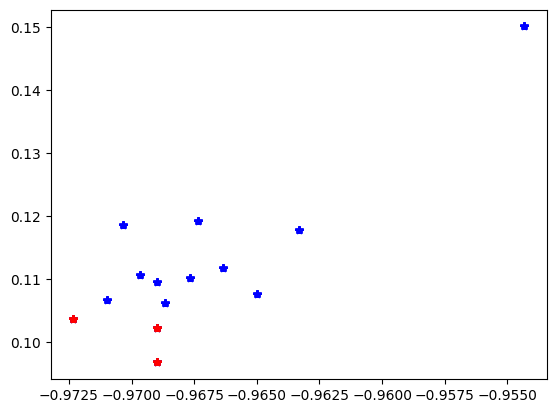

In [ ]:
ga = GeneticAlgorithm(10, train_images, test_images, train_labels, test_labels)
result = ga.solve(generations=10)
frontier_loss = []
frontier_acc = []
for individual in ga.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")

Generation 0


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 39s 395ms/step - loss: 0.7338 - accuracy: 0.7879 - val_loss: 0.2355 - val_accuracy: 0.9243
Epoch 2/10
88/88 [==============================] - 22s 251ms/step - loss: 0.1874 - accuracy: 0.9463 - val_loss: 0.1745 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 23s 266ms/step - loss: 0.1207 - accuracy: 0.9634 - val_loss: 0.1434 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 26s 294ms/step - loss: 0.0880 - accuracy: 0.9754 - val_loss: 0.1429 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0606 - accuracy: 0.9823 - val_loss: 0.1114 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 24s 270ms/step - loss: 0.0399 - accuracy: 0.9873 - val_loss: 0.1168 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0327 - accuracy: 0.9898 - val_loss: 0.1493 - val_accuracy: 0.9579

 10%|█         | 1/10 [04:11<37:40, 251.13s/it]

Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 1.1491 - accuracy: 0.6441 - val_loss: 0.3983 - val_accuracy: 0.8886
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.3024 - accuracy: 0.9125 - val_loss: 0.2495 - val_accuracy: 0.9250
Epoch 3/10
88/88 [==============================] - 4s 50ms/step - loss: 0.1929 - accuracy: 0.9466 - val_loss: 0.1989 - val_accuracy: 0.9371
Epoch 4/10
88/88 [==============================] - 4s 48ms/step - loss: 0.1412 - accuracy: 0.9616 - val_loss: 0.1823 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1078 - accuracy: 0.9691 - val_loss: 0.1582 - val_accuracy: 0.9464
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0901 - accuracy: 0.9745 - val_loss: 0.1445 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 5s 60ms/step - loss: 0.0752 - accuracy: 0.9787 - val_loss: 0.1306 - val_accuracy: 0.9643
Epoch 8/10
88

 20%|██        | 2/10 [04:53<17:05, 128.21s/it]

Epoch 1/10
88/88 [==============================] - 4s 32ms/step - loss: 1.3259 - accuracy: 0.5966 - val_loss: 0.5651 - val_accuracy: 0.8307
Epoch 2/10
88/88 [==============================] - 2s 24ms/step - loss: 0.4236 - accuracy: 0.8725 - val_loss: 0.3789 - val_accuracy: 0.8814
Epoch 3/10
88/88 [==============================] - 2s 24ms/step - loss: 0.3011 - accuracy: 0.9100 - val_loss: 0.3254 - val_accuracy: 0.8921
Epoch 4/10
88/88 [==============================] - 3s 30ms/step - loss: 0.2243 - accuracy: 0.9377 - val_loss: 0.2249 - val_accuracy: 0.9221
Epoch 5/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1767 - accuracy: 0.9475 - val_loss: 0.1955 - val_accuracy: 0.9314
Epoch 6/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1415 - accuracy: 0.9564 - val_loss: 0.1591 - val_accuracy: 0.9436
Epoch 7/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1226 - accuracy: 0.9616 - val_loss: 0.1704 - val_accuracy: 0.9407
Epoch 8/10
88

 30%|███       | 3/10 [05:36<10:24, 89.19s/it] 

Epoch 1/10
88/88 [==============================] - 3s 26ms/step - loss: 1.8455 - accuracy: 0.3198 - val_loss: 1.2816 - val_accuracy: 0.5629
Epoch 2/10
88/88 [==============================] - 2s 26ms/step - loss: 0.9371 - accuracy: 0.6577 - val_loss: 0.7658 - val_accuracy: 0.7536
Epoch 3/10
88/88 [==============================] - 3s 30ms/step - loss: 0.5573 - accuracy: 0.8395 - val_loss: 0.4972 - val_accuracy: 0.8514
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.3914 - accuracy: 0.8918 - val_loss: 0.4254 - val_accuracy: 0.8814
Epoch 5/10
88/88 [==============================] - 2s 27ms/step - loss: 0.3114 - accuracy: 0.9114 - val_loss: 0.3588 - val_accuracy: 0.8986
Epoch 6/10
88/88 [==============================] - 2s 23ms/step - loss: 0.2649 - accuracy: 0.9286 - val_loss: 0.2958 - val_accuracy: 0.9186
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2217 - accuracy: 0.9404 - val_loss: 0.2950 - val_accuracy: 0.9186
Epoch 8/10
88

 40%|████      | 4/10 [06:03<06:29, 64.97s/it]

Epoch 1/10
88/88 [==============================] - 8s 82ms/step - loss: 1.4407 - accuracy: 0.4970 - val_loss: 0.7224 - val_accuracy: 0.7850
Epoch 2/10
88/88 [==============================] - 8s 85ms/step - loss: 0.4431 - accuracy: 0.8723 - val_loss: 0.3818 - val_accuracy: 0.8843
Epoch 3/10
88/88 [==============================] - 7s 80ms/step - loss: 0.2885 - accuracy: 0.9159 - val_loss: 0.3124 - val_accuracy: 0.9057
Epoch 4/10
88/88 [==============================] - 7s 83ms/step - loss: 0.2079 - accuracy: 0.9413 - val_loss: 0.2432 - val_accuracy: 0.9243
Epoch 5/10
88/88 [==============================] - 8s 88ms/step - loss: 0.1574 - accuracy: 0.9530 - val_loss: 0.2325 - val_accuracy: 0.9321
Epoch 6/10
88/88 [==============================] - 7s 75ms/step - loss: 0.1260 - accuracy: 0.9627 - val_loss: 0.1813 - val_accuracy: 0.9486
Epoch 7/10
88/88 [==============================] - 6s 73ms/step - loss: 0.0929 - accuracy: 0.9737 - val_loss: 0.2098 - val_accuracy: 0.9343
Epoch 8/10
88

 50%|█████     | 5/10 [07:16<05:39, 67.86s/it]

Epoch 1/10
88/88 [==============================] - 4s 32ms/step - loss: 0.9087 - accuracy: 0.7298 - val_loss: 0.3989 - val_accuracy: 0.8750
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.3179 - accuracy: 0.9059 - val_loss: 0.2675 - val_accuracy: 0.9200
Epoch 3/10
88/88 [==============================] - 3s 29ms/step - loss: 0.2045 - accuracy: 0.9384 - val_loss: 0.2483 - val_accuracy: 0.9307
Epoch 4/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1514 - accuracy: 0.9557 - val_loss: 0.2071 - val_accuracy: 0.9350
Epoch 5/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1152 - accuracy: 0.9682 - val_loss: 0.1946 - val_accuracy: 0.9421
Epoch 6/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0811 - accuracy: 0.9777 - val_loss: 0.1810 - val_accuracy: 0.9457
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0652 - accuracy: 0.9814 - val_loss: 0.1427 - val_accuracy: 0.9564
Epoch 8/10
88

 60%|██████    | 6/10 [07:59<03:57, 59.41s/it]

Epoch 1/10
88/88 [==============================] - 5s 41ms/step - loss: 1.3326 - accuracy: 0.6141 - val_loss: 0.5423 - val_accuracy: 0.8250
Epoch 2/10
88/88 [==============================] - 2s 25ms/step - loss: 0.4222 - accuracy: 0.8680 - val_loss: 0.3174 - val_accuracy: 0.8979
Epoch 3/10
88/88 [==============================] - 2s 26ms/step - loss: 0.2687 - accuracy: 0.9214 - val_loss: 0.2502 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2187 - accuracy: 0.9357 - val_loss: 0.2834 - val_accuracy: 0.9214
Epoch 5/10
88/88 [==============================] - 2s 23ms/step - loss: 0.1777 - accuracy: 0.9473 - val_loss: 0.1838 - val_accuracy: 0.9371
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1399 - accuracy: 0.9573 - val_loss: 0.2245 - val_accuracy: 0.9293
Epoch 7/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1294 - accuracy: 0.9613 - val_loss: 0.1895 - val_accuracy: 0.9486
Epoch 8/10
88

 70%|███████   | 7/10 [08:43<02:42, 54.14s/it]

Epoch 1/10
88/88 [==============================] - 26s 282ms/step - loss: 1.1356 - accuracy: 0.6234 - val_loss: 0.4203 - val_accuracy: 0.8721
Epoch 2/10
88/88 [==============================] - 24s 271ms/step - loss: 0.2640 - accuracy: 0.9212 - val_loss: 0.2251 - val_accuracy: 0.9236
Epoch 3/10
88/88 [==============================] - 25s 284ms/step - loss: 0.1695 - accuracy: 0.9500 - val_loss: 0.1787 - val_accuracy: 0.9436
Epoch 4/10
88/88 [==============================] - 25s 283ms/step - loss: 0.1181 - accuracy: 0.9648 - val_loss: 0.1822 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0905 - accuracy: 0.9736 - val_loss: 0.1428 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 26s 297ms/step - loss: 0.0671 - accuracy: 0.9814 - val_loss: 0.1194 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 25s 290ms/step - loss: 0.0549 - accuracy: 0.9825 - val_loss: 0.2350 - val_accuracy: 0.9336

 80%|████████  | 8/10 [13:11<04:04, 122.48s/it]

Epoch 1/10
88/88 [==============================] - 10s 98ms/step - loss: 1.3035 - accuracy: 0.5657 - val_loss: 0.5660 - val_accuracy: 0.8343
Epoch 2/10
88/88 [==============================] - 9s 99ms/step - loss: 0.3869 - accuracy: 0.8916 - val_loss: 0.3020 - val_accuracy: 0.9136
Epoch 3/10
88/88 [==============================] - 10s 109ms/step - loss: 0.2168 - accuracy: 0.9377 - val_loss: 0.2758 - val_accuracy: 0.9207
Epoch 4/10
88/88 [==============================] - 8s 88ms/step - loss: 0.1639 - accuracy: 0.9539 - val_loss: 0.1827 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 10s 114ms/step - loss: 0.1304 - accuracy: 0.9625 - val_loss: 0.1941 - val_accuracy: 0.9457
Epoch 6/10
88/88 [==============================] - 10s 110ms/step - loss: 0.1056 - accuracy: 0.9689 - val_loss: 0.1540 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 8s 86ms/step - loss: 0.0810 - accuracy: 0.9743 - val_loss: 0.1385 - val_accuracy: 0.9621
Epoch 

 90%|█████████ | 9/10 [15:36<02:09, 129.45s/it]

Epoch 1/10
88/88 [==============================] - 3s 27ms/step - loss: 1.7168 - accuracy: 0.4491 - val_loss: 0.9126 - val_accuracy: 0.7214
Epoch 2/10
88/88 [==============================] - 2s 24ms/step - loss: 0.5036 - accuracy: 0.8537 - val_loss: 0.3621 - val_accuracy: 0.8964
Epoch 3/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2784 - accuracy: 0.9209 - val_loss: 0.2621 - val_accuracy: 0.9221
Epoch 4/10
88/88 [==============================] - 3s 40ms/step - loss: 0.2152 - accuracy: 0.9379 - val_loss: 0.2139 - val_accuracy: 0.9379
Epoch 5/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1833 - accuracy: 0.9446 - val_loss: 0.1907 - val_accuracy: 0.9393
Epoch 6/10
88/88 [==============================] - 2s 25ms/step - loss: 0.1521 - accuracy: 0.9580 - val_loss: 0.1725 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1305 - accuracy: 0.9614 - val_loss: 0.1783 - val_accuracy: 0.9514
Epoch 8/10
88

100%|██████████| 10/10 [16:19<00:00, 97.97s/it] 


Best Solution -> G:0 ->  Eval: 0.963  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
Generation 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 1.0438 - accuracy: 0.6959 - val_loss: 0.3155 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 5s 59ms/step - loss: 0.2651 - accuracy: 0.9246 - val_loss: 0.1970 - val_accuracy: 0.9486
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1823 - accuracy: 0.9468 - val_loss: 0.1694 - val_accuracy: 0.9536
Epoch 4/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1392 - accuracy: 0.9568 - val_loss: 0.1331 - val_accuracy: 0.9643
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1039 - accuracy: 0.9680 - val_loss: 0.1263 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 5s 54ms/step - loss: 0.0937 - accuracy: 0.9716 - val_loss: 0.1108 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0710 - accuracy: 0.9796 - val_loss: 0.1403 - val_accuracy: 0.9600
Epoch 8/10
88

 10%|█         | 1/10 [00:41<06:12, 41.37s/it]

Epoch 1/10
88/88 [==============================] - 26s 284ms/step - loss: 0.7328 - accuracy: 0.7775 - val_loss: 0.2259 - val_accuracy: 0.9314
Epoch 2/10
88/88 [==============================] - 23s 263ms/step - loss: 0.1932 - accuracy: 0.9427 - val_loss: 0.1945 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1278 - accuracy: 0.9623 - val_loss: 0.1717 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 25s 287ms/step - loss: 0.0854 - accuracy: 0.9736 - val_loss: 0.1143 - val_accuracy: 0.9671
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0610 - accuracy: 0.9802 - val_loss: 0.1305 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 26s 298ms/step - loss: 0.0486 - accuracy: 0.9837 - val_loss: 0.1217 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 26s 298ms/step - loss: 0.0365 - accuracy: 0.9900 - val_loss: 0.1356 - val_accuracy: 0.9629

 20%|██        | 2/10 [04:56<22:17, 167.23s/it]

Epoch 1/10
88/88 [==============================] - 6s 54ms/step - loss: 0.9777 - accuracy: 0.6943 - val_loss: 0.3548 - val_accuracy: 0.8871
Epoch 2/10
88/88 [==============================] - 4s 45ms/step - loss: 0.2670 - accuracy: 0.9205 - val_loss: 0.1907 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 6s 70ms/step - loss: 0.1631 - accuracy: 0.9536 - val_loss: 0.1566 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1277 - accuracy: 0.9616 - val_loss: 0.1575 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1011 - accuracy: 0.9688 - val_loss: 0.1296 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 6s 71ms/step - loss: 0.0802 - accuracy: 0.9746 - val_loss: 0.1298 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 5s 59ms/step - loss: 0.0651 - accuracy: 0.9804 - val_loss: 0.1134 - val_accuracy: 0.9629
Epoch 8/10
88

 30%|███       | 3/10 [06:21<15:05, 129.41s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 1.1537 - accuracy: 0.6448 - val_loss: 0.3609 - val_accuracy: 0.8886
Epoch 2/10
88/88 [==============================] - 5s 56ms/step - loss: 0.2818 - accuracy: 0.9218 - val_loss: 0.2699 - val_accuracy: 0.9129
Epoch 3/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1965 - accuracy: 0.9432 - val_loss: 0.2015 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1436 - accuracy: 0.9613 - val_loss: 0.1852 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1165 - accuracy: 0.9663 - val_loss: 0.1436 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1016 - accuracy: 0.9696 - val_loss: 0.2006 - val_accuracy: 0.9379
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0831 - accuracy: 0.9732 - val_loss: 0.1544 - val_accuracy: 0.9536
Epoch 8/10
88

 40%|████      | 4/10 [07:04<09:31, 95.26s/it] 

Epoch 1/10
88/88 [==============================] - 4s 40ms/step - loss: 0.9722 - accuracy: 0.7150 - val_loss: 0.3150 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 4s 49ms/step - loss: 0.2595 - accuracy: 0.9236 - val_loss: 0.2110 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1801 - accuracy: 0.9482 - val_loss: 0.1892 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1410 - accuracy: 0.9602 - val_loss: 0.1961 - val_accuracy: 0.9321
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1145 - accuracy: 0.9671 - val_loss: 0.1215 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 5s 61ms/step - loss: 0.0955 - accuracy: 0.9707 - val_loss: 0.1252 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0773 - accuracy: 0.9766 - val_loss: 0.1244 - val_accuracy: 0.9664
Epoch 8/10
88

 50%|█████     | 5/10 [07:46<06:21, 76.26s/it]

Epoch 1/10
88/88 [==============================] - 4s 41ms/step - loss: 1.2088 - accuracy: 0.6250 - val_loss: 0.4565 - val_accuracy: 0.8636
Epoch 2/10
88/88 [==============================] - 5s 55ms/step - loss: 0.3193 - accuracy: 0.9091 - val_loss: 0.3230 - val_accuracy: 0.8950
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2242 - accuracy: 0.9348 - val_loss: 0.2199 - val_accuracy: 0.9271
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1610 - accuracy: 0.9520 - val_loss: 0.1814 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1304 - accuracy: 0.9600 - val_loss: 0.2598 - val_accuracy: 0.9179
Epoch 6/10
88/88 [==============================] - 5s 53ms/step - loss: 0.1114 - accuracy: 0.9679 - val_loss: 0.1411 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 3s 35ms/step - loss: 0.0874 - accuracy: 0.9741 - val_loss: 0.1452 - val_accuracy: 0.9521
Epoch 8/10
88

 60%|██████    | 6/10 [08:29<04:19, 64.85s/it]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.6743 - accuracy: 0.7893 - val_loss: 0.2401 - val_accuracy: 0.9400
Epoch 2/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1708 - accuracy: 0.9529 - val_loss: 0.1580 - val_accuracy: 0.9550
Epoch 3/10
88/88 [==============================] - 22s 255ms/step - loss: 0.1103 - accuracy: 0.9684 - val_loss: 0.1379 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0829 - accuracy: 0.9748 - val_loss: 0.1520 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0498 - accuracy: 0.9846 - val_loss: 0.1568 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0377 - accuracy: 0.9880 - val_loss: 0.1269 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0285 - accuracy: 0.9929 - val_loss: 0.1212 - val_accuracy: 0.9686

 70%|███████   | 7/10 [12:54<06:31, 130.47s/it]

Epoch 1/10
88/88 [==============================] - 5s 52ms/step - loss: 1.7664 - accuracy: 0.3566 - val_loss: 1.3954 - val_accuracy: 0.5279
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 1.1738 - accuracy: 0.6066 - val_loss: 1.1181 - val_accuracy: 0.6743
Epoch 3/10
88/88 [==============================] - 3s 37ms/step - loss: 0.9585 - accuracy: 0.7007 - val_loss: 0.9606 - val_accuracy: 0.6786
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.8253 - accuracy: 0.7243 - val_loss: 0.8330 - val_accuracy: 0.7071
Epoch 5/10
88/88 [==============================] - 5s 55ms/step - loss: 0.7139 - accuracy: 0.7621 - val_loss: 0.7617 - val_accuracy: 0.8079
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.5890 - accuracy: 0.8630 - val_loss: 0.6362 - val_accuracy: 0.8393
Epoch 7/10
88/88 [==============================] - 3s 37ms/step - loss: 0.5134 - accuracy: 0.8827 - val_loss: 0.5848 - val_accuracy: 0.8543
Epoch 8/10
88

 80%|████████  | 8/10 [13:35<03:23, 101.87s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 1.1251 - accuracy: 0.6625 - val_loss: 0.3602 - val_accuracy: 0.8864
Epoch 2/10
88/88 [==============================] - 5s 56ms/step - loss: 0.2877 - accuracy: 0.9107 - val_loss: 0.2411 - val_accuracy: 0.9286
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1765 - accuracy: 0.9491 - val_loss: 0.1834 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1308 - accuracy: 0.9614 - val_loss: 0.2033 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 5s 63ms/step - loss: 0.1034 - accuracy: 0.9682 - val_loss: 0.1560 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0860 - accuracy: 0.9752 - val_loss: 0.1808 - val_accuracy: 0.9443
Epoch 7/10
88/88 [==============================] - 3s 40ms/step - loss: 0.0707 - accuracy: 0.9793 - val_loss: 0.1434 - val_accuracy: 0.9593
Epoch 8/10
88

 90%|█████████ | 9/10 [14:18<01:23, 83.61s/it] 

Epoch 1/10
88/88 [==============================] - 26s 280ms/step - loss: 0.7145 - accuracy: 0.7607 - val_loss: 0.2118 - val_accuracy: 0.9393
Epoch 2/10
88/88 [==============================] - 25s 281ms/step - loss: 0.1808 - accuracy: 0.9455 - val_loss: 0.1661 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 24s 274ms/step - loss: 0.1104 - accuracy: 0.9684 - val_loss: 0.1277 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0892 - accuracy: 0.9730 - val_loss: 0.1587 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 29s 326ms/step - loss: 0.0558 - accuracy: 0.9855 - val_loss: 0.1099 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 28s 316ms/step - loss: 0.0445 - accuracy: 0.9855 - val_loss: 0.1393 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0389 - accuracy: 0.9884 - val_loss: 0.1097 - val_accuracy: 0.9693

100%|██████████| 10/10 [18:45<00:00, 112.54s/it]


Best Solution -> G:1 ->  Eval: 0.965  Gene: [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1]
Generation 2


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.6914 - accuracy: 0.7795 - val_loss: 0.2525 - val_accuracy: 0.9179
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1590 - accuracy: 0.9546 - val_loss: 0.2065 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1063 - accuracy: 0.9659 - val_loss: 0.1774 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0849 - accuracy: 0.9734 - val_loss: 0.1577 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0553 - accuracy: 0.9843 - val_loss: 0.1280 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0391 - accuracy: 0.9882 - val_loss: 0.1629 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0306 - accuracy: 0.9907 - val_loss: 0.1194 - val_accuracy: 0.9650

 10%|█         | 1/10 [04:25<39:51, 265.69s/it]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.6091 - accuracy: 0.8155 - val_loss: 0.1508 - val_accuracy: 0.9529
Epoch 2/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1476 - accuracy: 0.9552 - val_loss: 0.1532 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0914 - accuracy: 0.9730 - val_loss: 0.1291 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0566 - accuracy: 0.9827 - val_loss: 0.1149 - val_accuracy: 0.9671
Epoch 5/10
88/88 [==============================] - 24s 279ms/step - loss: 0.0414 - accuracy: 0.9875 - val_loss: 0.1005 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.1025 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 24s 274ms/step - loss: 0.0202 - accuracy: 0.9945 - val_loss: 0.1374 - val_accuracy: 0.9593

 20%|██        | 2/10 [08:53<35:37, 267.13s/it]

Epoch 1/10
88/88 [==============================] - 29s 322ms/step - loss: 0.8211 - accuracy: 0.7414 - val_loss: 0.2581 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 29s 326ms/step - loss: 0.1776 - accuracy: 0.9468 - val_loss: 0.1790 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 29s 328ms/step - loss: 0.1206 - accuracy: 0.9602 - val_loss: 0.1450 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 29s 330ms/step - loss: 0.0792 - accuracy: 0.9771 - val_loss: 0.1240 - val_accuracy: 0.9664
Epoch 5/10
88/88 [==============================] - 28s 317ms/step - loss: 0.0555 - accuracy: 0.9821 - val_loss: 0.1261 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 28s 313ms/step - loss: 0.0439 - accuracy: 0.9882 - val_loss: 0.1006 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 27s 309ms/step - loss: 0.0468 - accuracy: 0.9845 - val_loss: 0.1146 - val_accuracy: 0.9657

 30%|███       | 3/10 [13:32<31:46, 272.40s/it]

Epoch 1/10
88/88 [==============================] - 3s 31ms/step - loss: 0.8903 - accuracy: 0.7679 - val_loss: 0.3726 - val_accuracy: 0.8736
Epoch 2/10
88/88 [==============================] - 3s 31ms/step - loss: 0.2858 - accuracy: 0.9212 - val_loss: 0.2737 - val_accuracy: 0.9179
Epoch 3/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1996 - accuracy: 0.9459 - val_loss: 0.2180 - val_accuracy: 0.9364
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 0.1516 - accuracy: 0.9595 - val_loss: 0.1996 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1252 - accuracy: 0.9661 - val_loss: 0.1885 - val_accuracy: 0.9464
Epoch 6/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1004 - accuracy: 0.9725 - val_loss: 0.1655 - val_accuracy: 0.9543
Epoch 7/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0818 - accuracy: 0.9770 - val_loss: 0.1563 - val_accuracy: 0.9543
Epoch 8/10
88

 40%|████      | 4/10 [14:00<17:35, 175.88s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 1.0942 - accuracy: 0.6798 - val_loss: 0.3774 - val_accuracy: 0.8864
Epoch 2/10
88/88 [==============================] - 5s 62ms/step - loss: 0.3055 - accuracy: 0.9091 - val_loss: 0.2405 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2046 - accuracy: 0.9432 - val_loss: 0.2410 - val_accuracy: 0.9243
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1621 - accuracy: 0.9520 - val_loss: 0.2021 - val_accuracy: 0.9336
Epoch 5/10
88/88 [==============================] - 4s 50ms/step - loss: 0.1306 - accuracy: 0.9596 - val_loss: 0.1661 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1111 - accuracy: 0.9675 - val_loss: 0.1444 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0922 - accuracy: 0.9757 - val_loss: 0.1593 - val_accuracy: 0.9500
Epoch 8/10
88

 50%|█████     | 5/10 [14:43<10:40, 128.15s/it]

Epoch 1/10
88/88 [==============================] - 25s 270ms/step - loss: 0.8848 - accuracy: 0.7220 - val_loss: 0.2904 - val_accuracy: 0.9136
Epoch 2/10
88/88 [==============================] - 22s 251ms/step - loss: 0.2068 - accuracy: 0.9429 - val_loss: 0.1638 - val_accuracy: 0.9543
Epoch 3/10
88/88 [==============================] - 23s 267ms/step - loss: 0.1343 - accuracy: 0.9600 - val_loss: 0.1476 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 23s 267ms/step - loss: 0.0859 - accuracy: 0.9739 - val_loss: 0.1365 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 23s 255ms/step - loss: 0.0676 - accuracy: 0.9821 - val_loss: 0.1469 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0588 - accuracy: 0.9825 - val_loss: 0.1674 - val_accuracy: 0.9486
Epoch 7/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0484 - accuracy: 0.9839 - val_loss: 0.1475 - val_accuracy: 0.9550

 60%|██████    | 6/10 [19:12<11:43, 175.76s/it]

Epoch 1/10
88/88 [==============================] - 7s 55ms/step - loss: 0.9727 - accuracy: 0.6925 - val_loss: 0.3410 - val_accuracy: 0.8950
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2818 - accuracy: 0.9171 - val_loss: 0.2065 - val_accuracy: 0.9314
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1860 - accuracy: 0.9475 - val_loss: 0.1924 - val_accuracy: 0.9350
Epoch 4/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1365 - accuracy: 0.9625 - val_loss: 0.1542 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1039 - accuracy: 0.9695 - val_loss: 0.1377 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0761 - accuracy: 0.9800 - val_loss: 0.1511 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 5s 58ms/step - loss: 0.0685 - accuracy: 0.9795 - val_loss: 0.1116 - val_accuracy: 0.9664
Epoch 8/10
88

 70%|███████   | 7/10 [20:37<07:18, 146.05s/it]

Epoch 1/10
88/88 [==============================] - 25s 267ms/step - loss: 0.7207 - accuracy: 0.7716 - val_loss: 0.2988 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 21s 245ms/step - loss: 0.1803 - accuracy: 0.9473 - val_loss: 0.1767 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 23s 265ms/step - loss: 0.1117 - accuracy: 0.9657 - val_loss: 0.1461 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0859 - accuracy: 0.9743 - val_loss: 0.1514 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0589 - accuracy: 0.9818 - val_loss: 0.1973 - val_accuracy: 0.9421
Epoch 6/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0426 - accuracy: 0.9879 - val_loss: 0.1142 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0335 - accuracy: 0.9907 - val_loss: 0.1216 - val_accuracy: 0.9664

 80%|████████  | 8/10 [24:27<05:45, 172.83s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 1.3712 - accuracy: 0.5425 - val_loss: 0.5141 - val_accuracy: 0.8264
Epoch 2/10
88/88 [==============================] - 5s 62ms/step - loss: 0.3654 - accuracy: 0.8943 - val_loss: 0.2711 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2062 - accuracy: 0.9420 - val_loss: 0.2459 - val_accuracy: 0.9257
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1646 - accuracy: 0.9520 - val_loss: 0.1871 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 5s 53ms/step - loss: 0.1311 - accuracy: 0.9625 - val_loss: 0.1860 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1014 - accuracy: 0.9680 - val_loss: 0.1645 - val_accuracy: 0.9521
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0847 - accuracy: 0.9752 - val_loss: 0.1851 - val_accuracy: 0.9493
Epoch 8/10
88

 90%|█████████ | 9/10 [25:11<02:12, 132.61s/it]

Epoch 1/10
88/88 [==============================] - 6s 54ms/step - loss: 1.5412 - accuracy: 0.4627 - val_loss: 0.6484 - val_accuracy: 0.8079
Epoch 2/10
88/88 [==============================] - 5s 52ms/step - loss: 0.4309 - accuracy: 0.8737 - val_loss: 0.3666 - val_accuracy: 0.8800
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2694 - accuracy: 0.9207 - val_loss: 0.2558 - val_accuracy: 0.9286
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2131 - accuracy: 0.9379 - val_loss: 0.2535 - val_accuracy: 0.9236
Epoch 5/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1786 - accuracy: 0.9477 - val_loss: 0.2630 - val_accuracy: 0.9214
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1547 - accuracy: 0.9532 - val_loss: 0.2094 - val_accuracy: 0.9343
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1274 - accuracy: 0.9616 - val_loss: 0.1700 - val_accuracy: 0.9514
Epoch 8/10
88

100%|██████████| 10/10 [25:55<00:00, 155.57s/it]


Best Solution -> G:1 ->  Eval: 0.969  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
Generation 3


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.6940 - accuracy: 0.7779 - val_loss: 0.2365 - val_accuracy: 0.9257
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.1581 - accuracy: 0.9534 - val_loss: 0.2147 - val_accuracy: 0.9336
Epoch 3/10
88/88 [==============================] - 23s 266ms/step - loss: 0.1065 - accuracy: 0.9645 - val_loss: 0.1147 - val_accuracy: 0.9686
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0637 - accuracy: 0.9802 - val_loss: 0.1153 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0480 - accuracy: 0.9839 - val_loss: 0.1248 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0365 - accuracy: 0.9887 - val_loss: 0.1366 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0214 - accuracy: 0.9943 - val_loss: 0.1236 - val_accuracy: 0.9671

 10%|█         | 1/10 [03:47<34:03, 227.06s/it]

Epoch 1/10
88/88 [==============================] - 5s 48ms/step - loss: 1.1615 - accuracy: 0.6716 - val_loss: 0.3712 - val_accuracy: 0.8879
Epoch 2/10
88/88 [==============================] - 5s 56ms/step - loss: 0.2938 - accuracy: 0.9136 - val_loss: 0.2432 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2000 - accuracy: 0.9409 - val_loss: 0.1866 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1528 - accuracy: 0.9563 - val_loss: 0.1728 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1229 - accuracy: 0.9643 - val_loss: 0.1552 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1030 - accuracy: 0.9686 - val_loss: 0.1316 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0877 - accuracy: 0.9732 - val_loss: 0.1315 - val_accuracy: 0.9621
Epoch 8/10
88

 20%|██        | 2/10 [05:11<19:04, 143.04s/it]

Epoch 1/10
88/88 [==============================] - 24s 253ms/step - loss: 0.7710 - accuracy: 0.7568 - val_loss: 0.2419 - val_accuracy: 0.9200
Epoch 2/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1731 - accuracy: 0.9545 - val_loss: 0.1548 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1110 - accuracy: 0.9682 - val_loss: 0.1043 - val_accuracy: 0.9721
Epoch 4/10
88/88 [==============================] - 23s 256ms/step - loss: 0.0729 - accuracy: 0.9762 - val_loss: 0.1130 - val_accuracy: 0.9707
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0604 - accuracy: 0.9816 - val_loss: 0.1040 - val_accuracy: 0.9729
Epoch 6/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0433 - accuracy: 0.9873 - val_loss: 0.1230 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0399 - accuracy: 0.9884 - val_loss: 0.1090 - val_accuracy: 0.9707

 30%|███       | 3/10 [09:40<23:24, 200.60s/it]

Epoch 1/10
88/88 [==============================] - 21s 231ms/step - loss: 0.7336 - accuracy: 0.7695 - val_loss: 0.2666 - val_accuracy: 0.9171
Epoch 2/10
88/88 [==============================] - 22s 244ms/step - loss: 0.1797 - accuracy: 0.9471 - val_loss: 0.1928 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 20s 226ms/step - loss: 0.1108 - accuracy: 0.9684 - val_loss: 0.1347 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0750 - accuracy: 0.9782 - val_loss: 0.1392 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0573 - accuracy: 0.9820 - val_loss: 0.1320 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0387 - accuracy: 0.9893 - val_loss: 0.1304 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0267 - accuracy: 0.9925 - val_loss: 0.1276 - val_accuracy: 0.9657

 40%|████      | 4/10 [13:15<20:37, 206.31s/it]

Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 1.1494 - accuracy: 0.6293 - val_loss: 0.3715 - val_accuracy: 0.8850
Epoch 2/10
88/88 [==============================] - 5s 55ms/step - loss: 0.2916 - accuracy: 0.9173 - val_loss: 0.2207 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1829 - accuracy: 0.9479 - val_loss: 0.1859 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1384 - accuracy: 0.9577 - val_loss: 0.1592 - val_accuracy: 0.9379
Epoch 5/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1030 - accuracy: 0.9698 - val_loss: 0.1379 - val_accuracy: 0.9493
Epoch 6/10
88/88 [==============================] - 5s 57ms/step - loss: 0.0840 - accuracy: 0.9748 - val_loss: 0.1313 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0675 - accuracy: 0.9814 - val_loss: 0.1271 - val_accuracy: 0.9600
Epoch 8/10
88

 50%|█████     | 5/10 [13:58<12:16, 147.36s/it]

Epoch 1/10
88/88 [==============================] - 23s 253ms/step - loss: 0.8196 - accuracy: 0.7395 - val_loss: 0.2491 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 20s 228ms/step - loss: 0.1656 - accuracy: 0.9536 - val_loss: 0.1447 - val_accuracy: 0.9564
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1007 - accuracy: 0.9714 - val_loss: 0.1317 - val_accuracy: 0.9664
Epoch 4/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0716 - accuracy: 0.9777 - val_loss: 0.1212 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0542 - accuracy: 0.9830 - val_loss: 0.1250 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0412 - accuracy: 0.9877 - val_loss: 0.1268 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0326 - accuracy: 0.9896 - val_loss: 0.1210 - val_accuracy: 0.9621

 60%|██████    | 6/10 [18:24<12:30, 187.63s/it]

Epoch 1/10
88/88 [==============================] - 22s 236ms/step - loss: 0.7851 - accuracy: 0.7536 - val_loss: 0.2826 - val_accuracy: 0.9207
Epoch 2/10
88/88 [==============================] - 22s 245ms/step - loss: 0.2017 - accuracy: 0.9432 - val_loss: 0.1934 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1291 - accuracy: 0.9634 - val_loss: 0.1625 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0855 - accuracy: 0.9750 - val_loss: 0.1451 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0700 - accuracy: 0.9798 - val_loss: 0.1199 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 24s 268ms/step - loss: 0.0531 - accuracy: 0.9845 - val_loss: 0.1352 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0402 - accuracy: 0.9877 - val_loss: 0.1370 - val_accuracy: 0.9621

 70%|███████   | 7/10 [22:08<09:59, 199.75s/it]

Epoch 1/10
88/88 [==============================] - 7s 63ms/step - loss: 1.4754 - accuracy: 0.5073 - val_loss: 0.8461 - val_accuracy: 0.7336
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.5124 - accuracy: 0.8495 - val_loss: 0.3535 - val_accuracy: 0.8964
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2853 - accuracy: 0.9186 - val_loss: 0.2672 - val_accuracy: 0.9271
Epoch 4/10
88/88 [==============================] - 5s 55ms/step - loss: 0.2142 - accuracy: 0.9379 - val_loss: 0.2170 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1676 - accuracy: 0.9518 - val_loss: 0.2334 - val_accuracy: 0.9314
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1393 - accuracy: 0.9577 - val_loss: 0.2099 - val_accuracy: 0.9414
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1232 - accuracy: 0.9657 - val_loss: 0.1847 - val_accuracy: 0.9479
Epoch 8/10
88

 80%|████████  | 8/10 [23:32<05:25, 162.81s/it]

Epoch 1/10
88/88 [==============================] - 25s 269ms/step - loss: 0.7385 - accuracy: 0.7730 - val_loss: 0.2795 - val_accuracy: 0.9171
Epoch 2/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1675 - accuracy: 0.9529 - val_loss: 0.1709 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 24s 271ms/step - loss: 0.1073 - accuracy: 0.9691 - val_loss: 0.1989 - val_accuracy: 0.9350
Epoch 4/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.1663 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 24s 270ms/step - loss: 0.0580 - accuracy: 0.9818 - val_loss: 0.1729 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0397 - accuracy: 0.9887 - val_loss: 0.1874 - val_accuracy: 0.9436
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0246 - accuracy: 0.9927 - val_loss: 0.1241 - val_accuracy: 0.9650

 90%|█████████ | 9/10 [27:28<03:05, 185.61s/it]

Epoch 1/10
88/88 [==============================] - 24s 258ms/step - loss: 0.7769 - accuracy: 0.7671 - val_loss: 0.2452 - val_accuracy: 0.9243
Epoch 2/10
88/88 [==============================] - 23s 267ms/step - loss: 0.2078 - accuracy: 0.9389 - val_loss: 0.1947 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1213 - accuracy: 0.9664 - val_loss: 0.1774 - val_accuracy: 0.9371
Epoch 4/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0791 - accuracy: 0.9786 - val_loss: 0.1715 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0622 - accuracy: 0.9820 - val_loss: 0.1631 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0525 - accuracy: 0.9834 - val_loss: 0.1036 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0405 - accuracy: 0.9870 - val_loss: 0.1729 - val_accuracy: 0.9493

100%|██████████| 10/10 [31:20<00:00, 188.00s/it]


Best Solution -> G:2 ->  Eval: 0.971  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Generation 4


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 1.0610 - accuracy: 0.6829 - val_loss: 0.3500 - val_accuracy: 0.8871
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2419 - accuracy: 0.9284 - val_loss: 0.1897 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 6s 64ms/step - loss: 0.1495 - accuracy: 0.9550 - val_loss: 0.1530 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1159 - accuracy: 0.9655 - val_loss: 0.1523 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0961 - accuracy: 0.9725 - val_loss: 0.1362 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 5s 60ms/step - loss: 0.0809 - accuracy: 0.9745 - val_loss: 0.1408 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 4s 46ms/step - loss: 0.0635 - accuracy: 0.9802 - val_loss: 0.1249 - val_accuracy: 0.9600
Epoch 8/10
88

 10%|█         | 1/10 [01:23<12:33, 83.69s/it]

Epoch 1/10
88/88 [==============================] - 25s 262ms/step - loss: 1.5208 - accuracy: 0.4313 - val_loss: 0.9036 - val_accuracy: 0.7079
Epoch 2/10
88/88 [==============================] - 21s 241ms/step - loss: 0.5787 - accuracy: 0.7921 - val_loss: 0.4329 - val_accuracy: 0.8914
Epoch 3/10
88/88 [==============================] - 23s 260ms/step - loss: 0.2840 - accuracy: 0.9246 - val_loss: 0.3068 - val_accuracy: 0.9171
Epoch 4/10
88/88 [==============================] - 21s 242ms/step - loss: 0.1827 - accuracy: 0.9495 - val_loss: 0.2511 - val_accuracy: 0.9243
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1458 - accuracy: 0.9618 - val_loss: 0.2250 - val_accuracy: 0.9364
Epoch 6/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1136 - accuracy: 0.9682 - val_loss: 0.2289 - val_accuracy: 0.9400
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0929 - accuracy: 0.9739 - val_loss: 0.2107 - val_accuracy: 0.9479

 20%|██        | 2/10 [05:50<25:30, 191.28s/it]

Epoch 1/10
88/88 [==============================] - 24s 266ms/step - loss: 1.0562 - accuracy: 0.6798 - val_loss: 0.3695 - val_accuracy: 0.8871
Epoch 2/10
88/88 [==============================] - 23s 262ms/step - loss: 0.2653 - accuracy: 0.9232 - val_loss: 0.2239 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1580 - accuracy: 0.9563 - val_loss: 0.2134 - val_accuracy: 0.9321
Epoch 4/10
88/88 [==============================] - 24s 273ms/step - loss: 0.1054 - accuracy: 0.9688 - val_loss: 0.1284 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0765 - accuracy: 0.9804 - val_loss: 0.1378 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0657 - accuracy: 0.9811 - val_loss: 0.1193 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0477 - accuracy: 0.9854 - val_loss: 0.1310 - val_accuracy: 0.9614

 30%|███       | 3/10 [10:18<26:24, 226.40s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 0.9656 - accuracy: 0.7246 - val_loss: 0.3411 - val_accuracy: 0.9014
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2804 - accuracy: 0.9132 - val_loss: 0.1946 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1627 - accuracy: 0.9509 - val_loss: 0.2037 - val_accuracy: 0.9307
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1220 - accuracy: 0.9632 - val_loss: 0.1409 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0925 - accuracy: 0.9725 - val_loss: 0.1668 - val_accuracy: 0.9457
Epoch 6/10
88/88 [==============================] - 4s 48ms/step - loss: 0.0723 - accuracy: 0.9770 - val_loss: 0.1358 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0613 - accuracy: 0.9793 - val_loss: 0.1582 - val_accuracy: 0.9543
Epoch 8/10
88

 40%|████      | 4/10 [11:00<15:20, 153.49s/it]

Epoch 1/10
88/88 [==============================] - 21s 232ms/step - loss: 0.7435 - accuracy: 0.7738 - val_loss: 0.2492 - val_accuracy: 0.9250
Epoch 2/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1867 - accuracy: 0.9439 - val_loss: 0.2090 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1177 - accuracy: 0.9657 - val_loss: 0.1334 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0778 - accuracy: 0.9779 - val_loss: 0.1141 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0600 - accuracy: 0.9830 - val_loss: 0.1288 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0444 - accuracy: 0.9879 - val_loss: 0.1163 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0356 - accuracy: 0.9884 - val_loss: 0.1002 - val_accuracy: 0.9729

 50%|█████     | 5/10 [14:35<14:38, 175.63s/it]

Epoch 1/10
88/88 [==============================] - 4s 40ms/step - loss: 1.1086 - accuracy: 0.6798 - val_loss: 0.3516 - val_accuracy: 0.8957
Epoch 2/10
88/88 [==============================] - 4s 47ms/step - loss: 0.2873 - accuracy: 0.9195 - val_loss: 0.2200 - val_accuracy: 0.9336
Epoch 3/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1821 - accuracy: 0.9471 - val_loss: 0.2043 - val_accuracy: 0.9314
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1380 - accuracy: 0.9614 - val_loss: 0.1638 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1134 - accuracy: 0.9659 - val_loss: 0.1533 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0913 - accuracy: 0.9730 - val_loss: 0.1620 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0812 - accuracy: 0.9734 - val_loss: 0.1494 - val_accuracy: 0.9564
Epoch 8/10
88

 60%|██████    | 6/10 [15:14<08:37, 129.48s/it]

Epoch 1/10
88/88 [==============================] - 4s 39ms/step - loss: 1.0267 - accuracy: 0.6991 - val_loss: 0.3995 - val_accuracy: 0.8750
Epoch 2/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2992 - accuracy: 0.9159 - val_loss: 0.2061 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1835 - accuracy: 0.9470 - val_loss: 0.1991 - val_accuracy: 0.9314
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1334 - accuracy: 0.9629 - val_loss: 0.1518 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1123 - accuracy: 0.9673 - val_loss: 0.1432 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0882 - accuracy: 0.9746 - val_loss: 0.1324 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 5s 60ms/step - loss: 0.0731 - accuracy: 0.9775 - val_loss: 0.1448 - val_accuracy: 0.9571
Epoch 8/10
88

 70%|███████   | 7/10 [15:55<05:01, 100.43s/it]

Epoch 1/10
88/88 [==============================] - 22s 239ms/step - loss: 0.7206 - accuracy: 0.7663 - val_loss: 0.2843 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1612 - accuracy: 0.9521 - val_loss: 0.1632 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1124 - accuracy: 0.9670 - val_loss: 0.1272 - val_accuracy: 0.9579
Epoch 4/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0784 - accuracy: 0.9784 - val_loss: 0.1095 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0618 - accuracy: 0.9795 - val_loss: 0.1184 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0436 - accuracy: 0.9870 - val_loss: 0.1431 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0338 - accuracy: 0.9900 - val_loss: 0.1086 - val_accuracy: 0.9721

 80%|████████  | 8/10 [20:21<05:06, 153.01s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.6897 - accuracy: 0.7752 - val_loss: 0.2420 - val_accuracy: 0.9200
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1618 - accuracy: 0.9532 - val_loss: 0.1636 - val_accuracy: 0.9514
Epoch 3/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0930 - accuracy: 0.9746 - val_loss: 0.1787 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0730 - accuracy: 0.9786 - val_loss: 0.1302 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0410 - accuracy: 0.9895 - val_loss: 0.1183 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0344 - accuracy: 0.9886 - val_loss: 0.1162 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 0.1205 - val_accuracy: 0.9664

 90%|█████████ | 9/10 [24:49<03:09, 189.01s/it]

Epoch 1/10
88/88 [==============================] - 22s 239ms/step - loss: 0.7135 - accuracy: 0.7816 - val_loss: 0.2430 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1546 - accuracy: 0.9582 - val_loss: 0.2004 - val_accuracy: 0.9364
Epoch 3/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0998 - accuracy: 0.9714 - val_loss: 0.1211 - val_accuracy: 0.9686
Epoch 4/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0764 - accuracy: 0.9766 - val_loss: 0.1216 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0528 - accuracy: 0.9868 - val_loss: 0.1365 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0452 - accuracy: 0.9843 - val_loss: 0.0997 - val_accuracy: 0.9729
Epoch 7/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0286 - accuracy: 0.9920 - val_loss: 0.1094 - val_accuracy: 0.9650

100%|██████████| 10/10 [28:28<00:00, 170.85s/it]


Best Solution -> G:3 ->  Eval: 0.971  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Generation 5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 1.1251 - accuracy: 0.6589 - val_loss: 0.4652 - val_accuracy: 0.8614
Epoch 2/10
88/88 [==============================] - 4s 48ms/step - loss: 0.3633 - accuracy: 0.8932 - val_loss: 0.3246 - val_accuracy: 0.9007
Epoch 3/10
88/88 [==============================] - 3s 35ms/step - loss: 0.2431 - accuracy: 0.9295 - val_loss: 0.2514 - val_accuracy: 0.9229
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1821 - accuracy: 0.9475 - val_loss: 0.2061 - val_accuracy: 0.9314
Epoch 5/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1389 - accuracy: 0.9588 - val_loss: 0.1635 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 4s 51ms/step - loss: 0.1181 - accuracy: 0.9650 - val_loss: 0.1552 - val_accuracy: 0.9443
Epoch 7/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0953 - accuracy: 0.9709 - val_loss: 0.1628 - val_accuracy: 0.9557
Epoch 8/10
88

 10%|█         | 1/10 [00:42<06:22, 42.55s/it]

Epoch 1/10
88/88 [==============================] - 6s 53ms/step - loss: 1.1045 - accuracy: 0.6666 - val_loss: 0.4548 - val_accuracy: 0.8700
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.3290 - accuracy: 0.9075 - val_loss: 0.2810 - val_accuracy: 0.9150
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2210 - accuracy: 0.9379 - val_loss: 0.2020 - val_accuracy: 0.9393
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1627 - accuracy: 0.9525 - val_loss: 0.1759 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1310 - accuracy: 0.9634 - val_loss: 0.1532 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1140 - accuracy: 0.9688 - val_loss: 0.1451 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0888 - accuracy: 0.9752 - val_loss: 0.1324 - val_accuracy: 0.9550
Epoch 8/10
88

 20%|██        | 2/10 [01:23<05:31, 41.45s/it]

Epoch 1/10
88/88 [==============================] - 24s 264ms/step - loss: 0.6949 - accuracy: 0.7845 - val_loss: 0.2269 - val_accuracy: 0.9371
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1691 - accuracy: 0.9507 - val_loss: 0.1686 - val_accuracy: 0.9443
Epoch 3/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1051 - accuracy: 0.9696 - val_loss: 0.1588 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0778 - accuracy: 0.9750 - val_loss: 0.1839 - val_accuracy: 0.9400
Epoch 5/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0533 - accuracy: 0.9845 - val_loss: 0.1054 - val_accuracy: 0.9679
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0350 - accuracy: 0.9900 - val_loss: 0.0983 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0332 - accuracy: 0.9896 - val_loss: 0.1067 - val_accuracy: 0.9636

 30%|███       | 3/10 [05:06<14:31, 124.43s/it]

Epoch 1/10
88/88 [==============================] - 22s 244ms/step - loss: 0.6417 - accuracy: 0.8012 - val_loss: 0.2674 - val_accuracy: 0.9164
Epoch 2/10
88/88 [==============================] - 23s 264ms/step - loss: 0.1609 - accuracy: 0.9516 - val_loss: 0.1684 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0964 - accuracy: 0.9711 - val_loss: 0.1367 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0712 - accuracy: 0.9768 - val_loss: 0.1325 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0474 - accuracy: 0.9854 - val_loss: 0.1281 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0400 - accuracy: 0.9882 - val_loss: 0.0932 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0306 - accuracy: 0.9911 - val_loss: 0.1659 - val_accuracy: 0.9457

 40%|████      | 4/10 [09:31<18:00, 180.13s/it]

Epoch 1/10
88/88 [==============================] - 24s 258ms/step - loss: 0.7171 - accuracy: 0.7807 - val_loss: 0.2811 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1880 - accuracy: 0.9484 - val_loss: 0.1844 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 24s 269ms/step - loss: 0.1137 - accuracy: 0.9663 - val_loss: 0.1507 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0835 - accuracy: 0.9759 - val_loss: 0.1459 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0588 - accuracy: 0.9837 - val_loss: 0.1810 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0478 - accuracy: 0.9862 - val_loss: 0.1453 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0353 - accuracy: 0.9904 - val_loss: 0.1041 - val_accuracy: 0.9721

 50%|█████     | 5/10 [13:15<16:19, 195.92s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 1.1916 - accuracy: 0.6179 - val_loss: 0.4364 - val_accuracy: 0.8657
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.3451 - accuracy: 0.8995 - val_loss: 0.2899 - val_accuracy: 0.9057
Epoch 3/10
88/88 [==============================] - 5s 60ms/step - loss: 0.2242 - accuracy: 0.9354 - val_loss: 0.2243 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1680 - accuracy: 0.9520 - val_loss: 0.1600 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1405 - accuracy: 0.9571 - val_loss: 0.1863 - val_accuracy: 0.9436
Epoch 6/10
88/88 [==============================] - 6s 64ms/step - loss: 0.1137 - accuracy: 0.9655 - val_loss: 0.1734 - val_accuracy: 0.9479
Epoch 7/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1003 - accuracy: 0.9714 - val_loss: 0.1232 - val_accuracy: 0.9664
Epoch 8/10
88

 60%|██████    | 6/10 [14:39<10:31, 157.79s/it]

Epoch 1/10
88/88 [==============================] - 24s 258ms/step - loss: 0.6968 - accuracy: 0.7918 - val_loss: 0.2400 - val_accuracy: 0.9321
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1749 - accuracy: 0.9513 - val_loss: 0.1816 - val_accuracy: 0.9521
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1106 - accuracy: 0.9657 - val_loss: 0.1217 - val_accuracy: 0.9679
Epoch 4/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0680 - accuracy: 0.9796 - val_loss: 0.1091 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0522 - accuracy: 0.9846 - val_loss: 0.1155 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0348 - accuracy: 0.9900 - val_loss: 0.1160 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.1293 - val_accuracy: 0.9693

 70%|███████   | 7/10 [18:25<08:59, 179.95s/it]

Epoch 1/10
88/88 [==============================] - 5s 48ms/step - loss: 1.4588 - accuracy: 0.5082 - val_loss: 0.6696 - val_accuracy: 0.7793
Epoch 2/10
88/88 [==============================] - 5s 53ms/step - loss: 0.4778 - accuracy: 0.8611 - val_loss: 0.3666 - val_accuracy: 0.8857
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2758 - accuracy: 0.9237 - val_loss: 0.2421 - val_accuracy: 0.9307
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2009 - accuracy: 0.9404 - val_loss: 0.2446 - val_accuracy: 0.9236
Epoch 5/10
88/88 [==============================] - 6s 65ms/step - loss: 0.1565 - accuracy: 0.9538 - val_loss: 0.2006 - val_accuracy: 0.9379
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1415 - accuracy: 0.9591 - val_loss: 0.1645 - val_accuracy: 0.9436
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1108 - accuracy: 0.9670 - val_loss: 0.1895 - val_accuracy: 0.9407
Epoch 8/10
88

 80%|████████  | 8/10 [19:08<04:33, 136.53s/it]

Epoch 1/10
88/88 [==============================] - 6s 57ms/step - loss: 0.9881 - accuracy: 0.6954 - val_loss: 0.3401 - val_accuracy: 0.8907
Epoch 2/10
88/88 [==============================] - 4s 48ms/step - loss: 0.2591 - accuracy: 0.9229 - val_loss: 0.2023 - val_accuracy: 0.9314
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1640 - accuracy: 0.9534 - val_loss: 0.1590 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1252 - accuracy: 0.9632 - val_loss: 0.1891 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1023 - accuracy: 0.9705 - val_loss: 0.1408 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0748 - accuracy: 0.9768 - val_loss: 0.1088 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0589 - accuracy: 0.9805 - val_loss: 0.1512 - val_accuracy: 0.9500
Epoch 8/10
88

 90%|█████████ | 9/10 [20:32<02:00, 120.06s/it]

Epoch 1/10
88/88 [==============================] - 22s 234ms/step - loss: 0.5831 - accuracy: 0.8252 - val_loss: 0.2811 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1438 - accuracy: 0.9570 - val_loss: 0.1878 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0892 - accuracy: 0.9746 - val_loss: 0.1059 - val_accuracy: 0.9650
Epoch 4/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0736 - accuracy: 0.9773 - val_loss: 0.1561 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0482 - accuracy: 0.9845 - val_loss: 0.1118 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0259 - accuracy: 0.9925 - val_loss: 0.1884 - val_accuracy: 0.9436
Epoch 7/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.1394 - val_accuracy: 0.9621

100%|██████████| 10/10 [24:59<00:00, 149.91s/it]


Best Solution -> G:4 ->  Eval: 0.974  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 6


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 0.7823 - accuracy: 0.7496 - val_loss: 0.2643 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 21s 242ms/step - loss: 0.1788 - accuracy: 0.9488 - val_loss: 0.1860 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 22s 255ms/step - loss: 0.1139 - accuracy: 0.9668 - val_loss: 0.1607 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0830 - accuracy: 0.9746 - val_loss: 0.1387 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0586 - accuracy: 0.9821 - val_loss: 0.1229 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0442 - accuracy: 0.9870 - val_loss: 0.1164 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0298 - accuracy: 0.9898 - val_loss: 0.0947 - val_accuracy: 0.9736

 10%|█         | 1/10 [04:25<39:51, 265.70s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.7034 - accuracy: 0.7837 - val_loss: 0.2339 - val_accuracy: 0.9279
Epoch 2/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1577 - accuracy: 0.9534 - val_loss: 0.1498 - val_accuracy: 0.9571
Epoch 3/10
88/88 [==============================] - 21s 242ms/step - loss: 0.1126 - accuracy: 0.9671 - val_loss: 0.1222 - val_accuracy: 0.9671
Epoch 4/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0651 - accuracy: 0.9811 - val_loss: 0.1416 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0646 - accuracy: 0.9795 - val_loss: 0.1286 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0450 - accuracy: 0.9875 - val_loss: 0.1241 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.1235 - val_accuracy: 0.9650

 20%|██        | 2/10 [08:52<35:30, 266.35s/it]

Epoch 1/10
88/88 [==============================] - 21s 226ms/step - loss: 0.8522 - accuracy: 0.7298 - val_loss: 0.3417 - val_accuracy: 0.8921
Epoch 2/10
88/88 [==============================] - 22s 249ms/step - loss: 0.2272 - accuracy: 0.9377 - val_loss: 0.1999 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 20s 227ms/step - loss: 0.1415 - accuracy: 0.9607 - val_loss: 0.1812 - val_accuracy: 0.9471
Epoch 4/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1003 - accuracy: 0.9704 - val_loss: 0.1630 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0740 - accuracy: 0.9782 - val_loss: 0.1299 - val_accuracy: 0.9679
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0594 - accuracy: 0.9821 - val_loss: 0.1800 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 22s 243ms/step - loss: 0.0423 - accuracy: 0.9866 - val_loss: 0.1537 - val_accuracy: 0.9529

 30%|███       | 3/10 [13:18<31:02, 266.08s/it]

Epoch 1/10
88/88 [==============================] - 6s 52ms/step - loss: 1.3760 - accuracy: 0.5502 - val_loss: 0.4614 - val_accuracy: 0.8700
Epoch 2/10
88/88 [==============================] - 4s 46ms/step - loss: 0.3855 - accuracy: 0.8916 - val_loss: 0.3443 - val_accuracy: 0.8993
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2362 - accuracy: 0.9332 - val_loss: 0.2357 - val_accuracy: 0.9393
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1720 - accuracy: 0.9538 - val_loss: 0.2391 - val_accuracy: 0.9264
Epoch 5/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1410 - accuracy: 0.9589 - val_loss: 0.1687 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1083 - accuracy: 0.9680 - val_loss: 0.1538 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 3s 37ms/step - loss: 0.0961 - accuracy: 0.9714 - val_loss: 0.1409 - val_accuracy: 0.9614
Epoch 8/10
88

 40%|████      | 4/10 [13:59<17:43, 177.27s/it]

Epoch 1/10
88/88 [==============================] - 23s 253ms/step - loss: 0.7438 - accuracy: 0.7607 - val_loss: 0.2304 - val_accuracy: 0.9257
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1741 - accuracy: 0.9470 - val_loss: 0.1540 - val_accuracy: 0.9550
Epoch 3/10
88/88 [==============================] - 22s 255ms/step - loss: 0.1115 - accuracy: 0.9654 - val_loss: 0.1658 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0796 - accuracy: 0.9761 - val_loss: 0.1170 - val_accuracy: 0.9707
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0521 - accuracy: 0.9841 - val_loss: 0.1269 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0391 - accuracy: 0.9884 - val_loss: 0.1215 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0300 - accuracy: 0.9895 - val_loss: 0.1346 - val_accuracy: 0.9714

 50%|█████     | 5/10 [18:25<17:25, 209.17s/it]

Epoch 1/10
88/88 [==============================] - 9s 93ms/step - loss: 0.7347 - accuracy: 0.7739 - val_loss: 0.3122 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 8s 95ms/step - loss: 0.2534 - accuracy: 0.9280 - val_loss: 0.2275 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 7s 84ms/step - loss: 0.1519 - accuracy: 0.9566 - val_loss: 0.1776 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 8s 96ms/step - loss: 0.1096 - accuracy: 0.9689 - val_loss: 0.1572 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 6s 69ms/step - loss: 0.0713 - accuracy: 0.9814 - val_loss: 0.1654 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 9s 102ms/step - loss: 0.0509 - accuracy: 0.9861 - val_loss: 0.1451 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 7s 77ms/step - loss: 0.0330 - accuracy: 0.9927 - val_loss: 0.1767 - val_accuracy: 0.9457
Epoch 8/10
8

 60%|██████    | 6/10 [19:44<11:00, 165.17s/it]

Epoch 1/10
88/88 [==============================] - 24s 267ms/step - loss: 0.9235 - accuracy: 0.7170 - val_loss: 0.4101 - val_accuracy: 0.8836
Epoch 2/10
88/88 [==============================] - 21s 242ms/step - loss: 0.2276 - accuracy: 0.9366 - val_loss: 0.2675 - val_accuracy: 0.9186
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1366 - accuracy: 0.9623 - val_loss: 0.1855 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1080 - accuracy: 0.9659 - val_loss: 0.1850 - val_accuracy: 0.9436
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0772 - accuracy: 0.9755 - val_loss: 0.1698 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0626 - accuracy: 0.9823 - val_loss: 0.1412 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0405 - accuracy: 0.9871 - val_loss: 0.1564 - val_accuracy: 0.9550

 70%|███████   | 7/10 [24:10<09:54, 198.02s/it]

Epoch 1/10
88/88 [==============================] - 25s 277ms/step - loss: 0.8408 - accuracy: 0.7236 - val_loss: 0.3563 - val_accuracy: 0.8836
Epoch 2/10
88/88 [==============================] - 24s 277ms/step - loss: 0.2051 - accuracy: 0.9413 - val_loss: 0.1678 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1271 - accuracy: 0.9629 - val_loss: 0.1505 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 25s 279ms/step - loss: 0.0939 - accuracy: 0.9736 - val_loss: 0.0960 - val_accuracy: 0.9743
Epoch 5/10
88/88 [==============================] - 24s 274ms/step - loss: 0.0565 - accuracy: 0.9820 - val_loss: 0.1982 - val_accuracy: 0.9407
Epoch 6/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0458 - accuracy: 0.9871 - val_loss: 0.1204 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 25s 279ms/step - loss: 0.0349 - accuracy: 0.9889 - val_loss: 0.1065 - val_accuracy: 0.9693

 80%|████████  | 8/10 [28:14<07:05, 212.65s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 1.8671 - accuracy: 0.3475 - val_loss: 1.4570 - val_accuracy: 0.4757
Epoch 2/10
88/88 [==============================] - 22s 255ms/step - loss: 1.2663 - accuracy: 0.5689 - val_loss: 1.1133 - val_accuracy: 0.6557
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.8832 - accuracy: 0.7275 - val_loss: 0.7455 - val_accuracy: 0.7721
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.5669 - accuracy: 0.8402 - val_loss: 0.4906 - val_accuracy: 0.8600
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.4152 - accuracy: 0.8888 - val_loss: 0.4614 - val_accuracy: 0.8736
Epoch 6/10
88/88 [==============================] - 22s 256ms/step - loss: 0.3091 - accuracy: 0.9184 - val_loss: 0.3985 - val_accuracy: 0.8836
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.2798 - accuracy: 0.9232 - val_loss: 0.3433 - val_accuracy: 0.8979

 90%|█████████ | 9/10 [32:40<03:49, 229.37s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 0.9120 - accuracy: 0.7361 - val_loss: 0.2938 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2428 - accuracy: 0.9280 - val_loss: 0.1878 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1551 - accuracy: 0.9554 - val_loss: 0.1609 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1153 - accuracy: 0.9661 - val_loss: 0.1446 - val_accuracy: 0.9500
Epoch 5/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0960 - accuracy: 0.9691 - val_loss: 0.1500 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 5s 54ms/step - loss: 0.0771 - accuracy: 0.9780 - val_loss: 0.1269 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0634 - accuracy: 0.9798 - val_loss: 0.1318 - val_accuracy: 0.9593
Epoch 8/10
88

100%|██████████| 10/10 [33:22<00:00, 200.29s/it]


Best Solution -> G:4 ->  Eval: 0.974  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 7


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 10s 104ms/step - loss: 0.9789 - accuracy: 0.7046 - val_loss: 0.3087 - val_accuracy: 0.9086
Epoch 2/10
88/88 [==============================] - 8s 87ms/step - loss: 0.2443 - accuracy: 0.9329 - val_loss: 0.2458 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 9s 105ms/step - loss: 0.1684 - accuracy: 0.9529 - val_loss: 0.2201 - val_accuracy: 0.9257
Epoch 4/10
88/88 [==============================] - 7s 84ms/step - loss: 0.1282 - accuracy: 0.9629 - val_loss: 0.1559 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 9s 103ms/step - loss: 0.0966 - accuracy: 0.9727 - val_loss: 0.1256 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 9s 107ms/step - loss: 0.0771 - accuracy: 0.9766 - val_loss: 0.1436 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 8s 88ms/step - loss: 0.0625 - accuracy: 0.9825 - val_loss: 0.1786 - val_accuracy: 0.9421
Epoch 8/

 10%|█         | 1/10 [01:27<13:05, 87.31s/it]

Epoch 1/10
88/88 [==============================] - 23s 257ms/step - loss: 0.7952 - accuracy: 0.7543 - val_loss: 0.2328 - val_accuracy: 0.9329
Epoch 2/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1886 - accuracy: 0.9457 - val_loss: 0.1685 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1163 - accuracy: 0.9668 - val_loss: 0.1258 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0845 - accuracy: 0.9759 - val_loss: 0.1051 - val_accuracy: 0.9671
Epoch 5/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0683 - accuracy: 0.9802 - val_loss: 0.1153 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0468 - accuracy: 0.9857 - val_loss: 0.1055 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0319 - accuracy: 0.9916 - val_loss: 0.0967 - val_accuracy: 0.9743

 20%|██        | 2/10 [05:10<22:16, 167.05s/it]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.6489 - accuracy: 0.7961 - val_loss: 0.2088 - val_accuracy: 0.9386
Epoch 2/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1642 - accuracy: 0.9548 - val_loss: 0.1577 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 22s 255ms/step - loss: 0.1023 - accuracy: 0.9704 - val_loss: 0.1640 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0772 - accuracy: 0.9754 - val_loss: 0.1530 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0632 - accuracy: 0.9796 - val_loss: 0.1355 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0380 - accuracy: 0.9891 - val_loss: 0.1329 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0279 - accuracy: 0.9907 - val_loss: 0.1234 - val_accuracy: 0.9664

 30%|███       | 3/10 [09:35<24:44, 212.10s/it]

Epoch 1/10
88/88 [==============================] - 24s 257ms/step - loss: 0.7223 - accuracy: 0.7743 - val_loss: 0.2294 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1643 - accuracy: 0.9518 - val_loss: 0.1341 - val_accuracy: 0.9664
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0963 - accuracy: 0.9720 - val_loss: 0.1321 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0678 - accuracy: 0.9800 - val_loss: 0.1278 - val_accuracy: 0.9586
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0577 - accuracy: 0.9836 - val_loss: 0.1303 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0477 - accuracy: 0.9845 - val_loss: 0.1230 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 22s 244ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.1195 - val_accuracy: 0.9729

 40%|████      | 4/10 [14:01<23:19, 233.23s/it]

Epoch 1/10
88/88 [==============================] - 24s 254ms/step - loss: 0.7570 - accuracy: 0.7718 - val_loss: 0.2440 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1795 - accuracy: 0.9514 - val_loss: 0.1809 - val_accuracy: 0.9364
Epoch 3/10
88/88 [==============================] - 21s 241ms/step - loss: 0.1132 - accuracy: 0.9671 - val_loss: 0.1210 - val_accuracy: 0.9643
Epoch 4/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0899 - accuracy: 0.9729 - val_loss: 0.1715 - val_accuracy: 0.9500
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0638 - accuracy: 0.9795 - val_loss: 0.1377 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0482 - accuracy: 0.9855 - val_loss: 0.1119 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.1205 - val_accuracy: 0.9657

 50%|█████     | 5/10 [18:28<20:27, 245.45s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 0.9878 - accuracy: 0.6866 - val_loss: 0.3536 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 3s 40ms/step - loss: 0.2609 - accuracy: 0.9243 - val_loss: 0.2135 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 5s 54ms/step - loss: 0.1668 - accuracy: 0.9504 - val_loss: 0.1814 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1216 - accuracy: 0.9630 - val_loss: 0.2054 - val_accuracy: 0.9250
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1012 - accuracy: 0.9704 - val_loss: 0.1402 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0774 - accuracy: 0.9771 - val_loss: 0.1405 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 5s 59ms/step - loss: 0.0569 - accuracy: 0.9825 - val_loss: 0.1286 - val_accuracy: 0.9643
Epoch 8/10
88

 60%|██████    | 6/10 [19:11<11:46, 176.57s/it]

Epoch 1/10
88/88 [==============================] - 7s 76ms/step - loss: 0.8217 - accuracy: 0.7564 - val_loss: 0.3775 - val_accuracy: 0.8900
Epoch 2/10
88/88 [==============================] - 8s 90ms/step - loss: 0.3090 - accuracy: 0.9100 - val_loss: 0.3437 - val_accuracy: 0.8986
Epoch 3/10
88/88 [==============================] - 6s 70ms/step - loss: 0.2029 - accuracy: 0.9420 - val_loss: 0.2359 - val_accuracy: 0.9307
Epoch 4/10
88/88 [==============================] - 8s 86ms/step - loss: 0.1435 - accuracy: 0.9607 - val_loss: 0.2177 - val_accuracy: 0.9371
Epoch 5/10
88/88 [==============================] - 6s 70ms/step - loss: 0.1103 - accuracy: 0.9696 - val_loss: 0.2189 - val_accuracy: 0.9371
Epoch 6/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0856 - accuracy: 0.9775 - val_loss: 0.1857 - val_accuracy: 0.9507
Epoch 7/10
88/88 [==============================] - 6s 69ms/step - loss: 0.0673 - accuracy: 0.9814 - val_loss: 0.2175 - val_accuracy: 0.9314
Epoch 8/10
88

 70%|███████   | 7/10 [20:23<07:07, 142.38s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 0.9879 - accuracy: 0.7096 - val_loss: 0.3306 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2779 - accuracy: 0.9209 - val_loss: 0.2438 - val_accuracy: 0.9171
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1813 - accuracy: 0.9482 - val_loss: 0.1698 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1326 - accuracy: 0.9609 - val_loss: 0.1667 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1037 - accuracy: 0.9691 - val_loss: 0.1467 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0841 - accuracy: 0.9752 - val_loss: 0.1465 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 4s 50ms/step - loss: 0.0660 - accuracy: 0.9811 - val_loss: 0.1317 - val_accuracy: 0.9607
Epoch 8/10
88

 80%|████████  | 8/10 [21:05<03:40, 110.50s/it]

Epoch 1/10
88/88 [==============================] - 22s 238ms/step - loss: 0.8553 - accuracy: 0.7386 - val_loss: 0.2385 - val_accuracy: 0.9343
Epoch 2/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1783 - accuracy: 0.9482 - val_loss: 0.2160 - val_accuracy: 0.9243
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1075 - accuracy: 0.9695 - val_loss: 0.1392 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0890 - accuracy: 0.9725 - val_loss: 0.1426 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0603 - accuracy: 0.9821 - val_loss: 0.1185 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0563 - accuracy: 0.9846 - val_loss: 0.1341 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0346 - accuracy: 0.9914 - val_loss: 0.1268 - val_accuracy: 0.9600

 90%|█████████ | 9/10 [25:31<02:38, 158.97s/it]

Epoch 1/10
88/88 [==============================] - 24s 264ms/step - loss: 0.7194 - accuracy: 0.7834 - val_loss: 0.3155 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1779 - accuracy: 0.9502 - val_loss: 0.2202 - val_accuracy: 0.9329
Epoch 3/10
88/88 [==============================] - 23s 266ms/step - loss: 0.1106 - accuracy: 0.9679 - val_loss: 0.1854 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0846 - accuracy: 0.9752 - val_loss: 0.1390 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0532 - accuracy: 0.9857 - val_loss: 0.1044 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0389 - accuracy: 0.9882 - val_loss: 0.1251 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0262 - accuracy: 0.9912 - val_loss: 0.1203 - val_accuracy: 0.9629

100%|██████████| 10/10 [29:57<00:00, 179.70s/it]


Best Solution -> G:4 ->  Eval: 0.974  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 8


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 25s 262ms/step - loss: 0.7433 - accuracy: 0.7627 - val_loss: 0.2309 - val_accuracy: 0.9321
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1674 - accuracy: 0.9521 - val_loss: 0.1486 - val_accuracy: 0.9557
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1011 - accuracy: 0.9711 - val_loss: 0.1382 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0734 - accuracy: 0.9762 - val_loss: 0.1115 - val_accuracy: 0.9700
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0513 - accuracy: 0.9852 - val_loss: 0.1048 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0389 - accuracy: 0.9877 - val_loss: 0.1237 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 22s 244ms/step - loss: 0.0260 - accuracy: 0.9930 - val_loss: 0.1263 - val_accuracy: 0.9636

 10%|█         | 1/10 [03:48<34:15, 228.39s/it]

Epoch 1/10
88/88 [==============================] - 11s 111ms/step - loss: 0.8876 - accuracy: 0.7321 - val_loss: 0.3465 - val_accuracy: 0.8957
Epoch 2/10
88/88 [==============================] - 9s 102ms/step - loss: 0.2414 - accuracy: 0.9282 - val_loss: 0.2312 - val_accuracy: 0.9264
Epoch 3/10
88/88 [==============================] - 8s 90ms/step - loss: 0.1528 - accuracy: 0.9536 - val_loss: 0.1297 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 10s 108ms/step - loss: 0.1233 - accuracy: 0.9607 - val_loss: 0.1721 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 8s 89ms/step - loss: 0.0851 - accuracy: 0.9739 - val_loss: 0.1294 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 9s 104ms/step - loss: 0.0661 - accuracy: 0.9787 - val_loss: 0.1264 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 9s 106ms/step - loss: 0.0587 - accuracy: 0.9825 - val_loss: 0.1339 - val_accuracy: 0.9571
Epoch 

 20%|██        | 2/10 [06:12<23:52, 179.10s/it]

Epoch 1/10
88/88 [==============================] - 24s 262ms/step - loss: 0.8305 - accuracy: 0.7427 - val_loss: 0.3463 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 21s 242ms/step - loss: 0.2490 - accuracy: 0.9304 - val_loss: 0.1908 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1411 - accuracy: 0.9629 - val_loss: 0.1377 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0905 - accuracy: 0.9761 - val_loss: 0.1273 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0705 - accuracy: 0.9782 - val_loss: 0.1533 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.1668 - val_accuracy: 0.9521
Epoch 7/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0477 - accuracy: 0.9864 - val_loss: 0.1217 - val_accuracy: 0.9671

 30%|███       | 3/10 [10:38<25:29, 218.52s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 1.0875 - accuracy: 0.6391 - val_loss: 0.3640 - val_accuracy: 0.8957
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.2675 - accuracy: 0.9245 - val_loss: 0.2485 - val_accuracy: 0.9179
Epoch 3/10
88/88 [==============================] - 23s 256ms/step - loss: 0.1648 - accuracy: 0.9509 - val_loss: 0.1969 - val_accuracy: 0.9343
Epoch 4/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1163 - accuracy: 0.9654 - val_loss: 0.1676 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0996 - accuracy: 0.9698 - val_loss: 0.1667 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0838 - accuracy: 0.9759 - val_loss: 0.1349 - val_accuracy: 0.9679
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0646 - accuracy: 0.9807 - val_loss: 0.1839 - val_accuracy: 0.9443

 40%|████      | 4/10 [14:20<21:58, 219.81s/it]

Epoch 1/10
88/88 [==============================] - 22s 235ms/step - loss: 0.6894 - accuracy: 0.7929 - val_loss: 0.2092 - val_accuracy: 0.9250
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1694 - accuracy: 0.9536 - val_loss: 0.1726 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1145 - accuracy: 0.9657 - val_loss: 0.1815 - val_accuracy: 0.9343
Epoch 4/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0815 - accuracy: 0.9766 - val_loss: 0.1322 - val_accuracy: 0.9671
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0589 - accuracy: 0.9807 - val_loss: 0.1144 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0444 - accuracy: 0.9884 - val_loss: 0.0908 - val_accuracy: 0.9764
Epoch 7/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0282 - accuracy: 0.9918 - val_loss: 0.1063 - val_accuracy: 0.9671

 50%|█████     | 5/10 [18:45<19:41, 236.35s/it]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 0.7312 - accuracy: 0.7761 - val_loss: 0.2346 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 21s 241ms/step - loss: 0.1575 - accuracy: 0.9538 - val_loss: 0.1454 - val_accuracy: 0.9550
Epoch 3/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0968 - accuracy: 0.9702 - val_loss: 0.1653 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0691 - accuracy: 0.9773 - val_loss: 0.1321 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0455 - accuracy: 0.9862 - val_loss: 0.1410 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0368 - accuracy: 0.9886 - val_loss: 0.1208 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0248 - accuracy: 0.9911 - val_loss: 0.1176 - val_accuracy: 0.9707

 60%|██████    | 6/10 [23:11<16:25, 246.35s/it]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.7662 - accuracy: 0.7582 - val_loss: 0.2586 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1790 - accuracy: 0.9511 - val_loss: 0.1849 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1197 - accuracy: 0.9664 - val_loss: 0.1424 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0841 - accuracy: 0.9750 - val_loss: 0.1224 - val_accuracy: 0.9643
Epoch 5/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0655 - accuracy: 0.9800 - val_loss: 0.1345 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 0.1084 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0411 - accuracy: 0.9880 - val_loss: 0.1086 - val_accuracy: 0.9657

 70%|███████   | 7/10 [27:39<12:40, 253.46s/it]

Epoch 1/10
88/88 [==============================] - 4s 39ms/step - loss: 1.0630 - accuracy: 0.6677 - val_loss: 0.3886 - val_accuracy: 0.8914
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2999 - accuracy: 0.9136 - val_loss: 0.2171 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.2118 - accuracy: 0.9396 - val_loss: 0.1761 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1574 - accuracy: 0.9552 - val_loss: 0.1721 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1300 - accuracy: 0.9621 - val_loss: 0.1479 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1020 - accuracy: 0.9700 - val_loss: 0.1534 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 5s 57ms/step - loss: 0.0891 - accuracy: 0.9720 - val_loss: 0.1328 - val_accuracy: 0.9650
Epoch 8/10
88

 80%|████████  | 8/10 [28:22<06:12, 186.31s/it]

Epoch 1/10
88/88 [==============================] - 22s 240ms/step - loss: 0.5982 - accuracy: 0.8191 - val_loss: 0.2318 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1584 - accuracy: 0.9559 - val_loss: 0.1653 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1012 - accuracy: 0.9698 - val_loss: 0.1468 - val_accuracy: 0.9536
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0662 - accuracy: 0.9807 - val_loss: 0.0944 - val_accuracy: 0.9721
Epoch 5/10
88/88 [==============================] - 24s 273ms/step - loss: 0.0538 - accuracy: 0.9850 - val_loss: 0.1091 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0396 - accuracy: 0.9862 - val_loss: 0.1278 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.1033 - val_accuracy: 0.9729

 90%|█████████ | 9/10 [32:11<03:19, 199.63s/it]

Epoch 1/10
88/88 [==============================] - 24s 258ms/step - loss: 1.0095 - accuracy: 0.6764 - val_loss: 0.3179 - val_accuracy: 0.8986
Epoch 2/10
88/88 [==============================] - 21s 243ms/step - loss: 0.2236 - accuracy: 0.9416 - val_loss: 0.2320 - val_accuracy: 0.9314
Epoch 3/10
88/88 [==============================] - 23s 265ms/step - loss: 0.1502 - accuracy: 0.9563 - val_loss: 0.1784 - val_accuracy: 0.9436
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.1141 - accuracy: 0.9654 - val_loss: 0.1415 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0847 - accuracy: 0.9739 - val_loss: 0.1394 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0636 - accuracy: 0.9812 - val_loss: 0.1386 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0570 - accuracy: 0.9829 - val_loss: 0.1109 - val_accuracy: 0.9671

100%|██████████| 10/10 [36:36<00:00, 219.67s/it]


Best Solution -> G:4 ->  Eval: 0.974  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 9


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 6s 57ms/step - loss: 1.2075 - accuracy: 0.6059 - val_loss: 0.3995 - val_accuracy: 0.8907
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2914 - accuracy: 0.9173 - val_loss: 0.2290 - val_accuracy: 0.9379
Epoch 3/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1894 - accuracy: 0.9418 - val_loss: 0.1578 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1398 - accuracy: 0.9564 - val_loss: 0.1683 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1133 - accuracy: 0.9648 - val_loss: 0.1549 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0879 - accuracy: 0.9745 - val_loss: 0.2374 - val_accuracy: 0.9350
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0895 - accuracy: 0.9723 - val_loss: 0.1266 - val_accuracy: 0.9614
Epoch 8/10
88

 10%|█         | 1/10 [01:24<12:36, 84.10s/it]

Epoch 1/10
88/88 [==============================] - 22s 239ms/step - loss: 0.7716 - accuracy: 0.7621 - val_loss: 0.2326 - val_accuracy: 0.9436
Epoch 2/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1822 - accuracy: 0.9482 - val_loss: 0.1453 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1135 - accuracy: 0.9661 - val_loss: 0.2219 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0868 - accuracy: 0.9716 - val_loss: 0.1594 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0625 - accuracy: 0.9812 - val_loss: 0.1186 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0439 - accuracy: 0.9871 - val_loss: 0.1189 - val_accuracy: 0.9679
Epoch 7/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0466 - accuracy: 0.9859 - val_loss: 0.1355 - val_accuracy: 0.9621

 20%|██        | 2/10 [05:49<25:26, 190.85s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.6932 - accuracy: 0.7820 - val_loss: 0.2277 - val_accuracy: 0.9314
Epoch 2/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1645 - accuracy: 0.9529 - val_loss: 0.1608 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1057 - accuracy: 0.9679 - val_loss: 0.1498 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0758 - accuracy: 0.9770 - val_loss: 0.1544 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0533 - accuracy: 0.9850 - val_loss: 0.1192 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.1351 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.1269 - val_accuracy: 0.9643

 30%|███       | 3/10 [10:15<26:15, 225.01s/it]

Epoch 1/10
88/88 [==============================] - 25s 272ms/step - loss: 0.9235 - accuracy: 0.7041 - val_loss: 0.2959 - val_accuracy: 0.9100
Epoch 2/10
88/88 [==============================] - 24s 268ms/step - loss: 0.1886 - accuracy: 0.9454 - val_loss: 0.2154 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1160 - accuracy: 0.9679 - val_loss: 0.1476 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 25s 282ms/step - loss: 0.0875 - accuracy: 0.9748 - val_loss: 0.1319 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0615 - accuracy: 0.9802 - val_loss: 0.1375 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 25s 278ms/step - loss: 0.0535 - accuracy: 0.9843 - val_loss: 0.1126 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.1089 - val_accuracy: 0.9700

 40%|████      | 4/10 [14:41<24:06, 241.14s/it]

Epoch 1/10
88/88 [==============================] - 29s 317ms/step - loss: 0.6886 - accuracy: 0.7814 - val_loss: 0.2184 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 32s 370ms/step - loss: 0.1538 - accuracy: 0.9563 - val_loss: 0.1920 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 40s 457ms/step - loss: 0.1070 - accuracy: 0.9680 - val_loss: 0.1410 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 29s 335ms/step - loss: 0.0718 - accuracy: 0.9771 - val_loss: 0.1520 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 24s 272ms/step - loss: 0.0572 - accuracy: 0.9839 - val_loss: 0.1109 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0352 - accuracy: 0.9889 - val_loss: 0.1013 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.1599 - val_accuracy: 0.9550

 50%|█████     | 5/10 [20:07<22:39, 271.82s/it]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.6507 - accuracy: 0.7948 - val_loss: 0.2476 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 23s 266ms/step - loss: 0.1659 - accuracy: 0.9561 - val_loss: 0.1507 - val_accuracy: 0.9507
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1040 - accuracy: 0.9702 - val_loss: 0.1101 - val_accuracy: 0.9707
Epoch 4/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0742 - accuracy: 0.9775 - val_loss: 0.1102 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0640 - accuracy: 0.9825 - val_loss: 0.1077 - val_accuracy: 0.9714
Epoch 6/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0463 - accuracy: 0.9873 - val_loss: 0.1436 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0306 - accuracy: 0.9905 - val_loss: 0.1163 - val_accuracy: 0.9700

 60%|██████    | 6/10 [23:54<17:05, 256.46s/it]

Epoch 1/10
88/88 [==============================] - 25s 269ms/step - loss: 0.7711 - accuracy: 0.7416 - val_loss: 0.2630 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 21s 241ms/step - loss: 0.1631 - accuracy: 0.9532 - val_loss: 0.1825 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 23s 262ms/step - loss: 0.1062 - accuracy: 0.9695 - val_loss: 0.1310 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0738 - accuracy: 0.9784 - val_loss: 0.1341 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0539 - accuracy: 0.9850 - val_loss: 0.1431 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0452 - accuracy: 0.9848 - val_loss: 0.1001 - val_accuracy: 0.9721
Epoch 7/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0319 - accuracy: 0.9904 - val_loss: 0.1311 - val_accuracy: 0.9614

 70%|███████   | 7/10 [28:19<12:58, 259.48s/it]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.8164 - accuracy: 0.7346 - val_loss: 0.2315 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 24s 274ms/step - loss: 0.1907 - accuracy: 0.9438 - val_loss: 0.1760 - val_accuracy: 0.9443
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1212 - accuracy: 0.9629 - val_loss: 0.1204 - val_accuracy: 0.9657
Epoch 4/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0802 - accuracy: 0.9761 - val_loss: 0.1258 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0682 - accuracy: 0.9804 - val_loss: 0.1169 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0490 - accuracy: 0.9857 - val_loss: 0.1298 - val_accuracy: 0.9721
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0411 - accuracy: 0.9868 - val_loss: 0.1392 - val_accuracy: 0.9629

 80%|████████  | 8/10 [32:45<08:42, 261.47s/it]

Epoch 1/10
88/88 [==============================] - 27s 283ms/step - loss: 0.7358 - accuracy: 0.7641 - val_loss: 0.1986 - val_accuracy: 0.9421
Epoch 2/10
88/88 [==============================] - 24s 279ms/step - loss: 0.1693 - accuracy: 0.9505 - val_loss: 0.1334 - val_accuracy: 0.9543
Epoch 3/10
88/88 [==============================] - 28s 324ms/step - loss: 0.1116 - accuracy: 0.9670 - val_loss: 0.1358 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 29s 332ms/step - loss: 0.0724 - accuracy: 0.9771 - val_loss: 0.1182 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 27s 313ms/step - loss: 0.0506 - accuracy: 0.9846 - val_loss: 0.0914 - val_accuracy: 0.9757
Epoch 6/10
88/88 [==============================] - 33s 381ms/step - loss: 0.0401 - accuracy: 0.9891 - val_loss: 0.1008 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 36s 407ms/step - loss: 0.0255 - accuracy: 0.9932 - val_loss: 0.0947 - val_accuracy: 0.9693

 90%|█████████ | 9/10 [38:14<04:42, 282.62s/it]

Epoch 1/10
88/88 [==============================] - 32s 352ms/step - loss: 0.6816 - accuracy: 0.7971 - val_loss: 0.2651 - val_accuracy: 0.9171
Epoch 2/10
88/88 [==============================] - 26s 297ms/step - loss: 0.1660 - accuracy: 0.9521 - val_loss: 0.1598 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 24s 275ms/step - loss: 0.1099 - accuracy: 0.9650 - val_loss: 0.1248 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0774 - accuracy: 0.9773 - val_loss: 0.1088 - val_accuracy: 0.9643
Epoch 5/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0493 - accuracy: 0.9848 - val_loss: 0.1368 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 24s 268ms/step - loss: 0.0436 - accuracy: 0.9857 - val_loss: 0.1234 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0341 - accuracy: 0.9887 - val_loss: 0.0949 - val_accuracy: 0.9729

100%|██████████| 10/10 [42:43<00:00, 256.33s/it]


Best Solution -> G:4 ->  Eval: 0.974  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 25s 273ms/step - loss: 0.6950 - accuracy: 0.7993 - val_loss: 0.2504 - val_accuracy: 0.9179
Epoch 2/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1584 - accuracy: 0.9545 - val_loss: 0.1256 - val_accuracy: 0.9657
Epoch 3/10
88/88 [==============================] - 23s 264ms/step - loss: 0.1097 - accuracy: 0.9663 - val_loss: 0.1650 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 24s 277ms/step - loss: 0.0813 - accuracy: 0.9746 - val_loss: 0.1387 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0529 - accuracy: 0.9859 - val_loss: 0.0963 - val_accuracy: 0.9743
Epoch 6/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0400 - accuracy: 0.9868 - val_loss: 0.1842 - val_accuracy: 0.9493
Epoch 7/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.1209 - val_accuracy: 0.9693

 10%|█         | 1/10 [03:50<34:34, 230.48s/it]

Epoch 1/10
88/88 [==============================] - 25s 269ms/step - loss: 0.7155 - accuracy: 0.7814 - val_loss: 0.3092 - val_accuracy: 0.9014
Epoch 2/10
88/88 [==============================] - 23s 268ms/step - loss: 0.1935 - accuracy: 0.9450 - val_loss: 0.1707 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 21s 237ms/step - loss: 0.1172 - accuracy: 0.9630 - val_loss: 0.1308 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 24s 273ms/step - loss: 0.0786 - accuracy: 0.9775 - val_loss: 0.1304 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0659 - accuracy: 0.9805 - val_loss: 0.1202 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0507 - accuracy: 0.9857 - val_loss: 0.1251 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0358 - accuracy: 0.9896 - val_loss: 0.1065 - val_accuracy: 0.9679

 20%|██        | 2/10 [07:41<30:47, 230.99s/it]

Epoch 1/10
88/88 [==============================] - 23s 243ms/step - loss: 1.5492 - accuracy: 0.4439 - val_loss: 1.0172 - val_accuracy: 0.6057
Epoch 2/10
88/88 [==============================] - 24s 276ms/step - loss: 0.7110 - accuracy: 0.7352 - val_loss: 0.6545 - val_accuracy: 0.7629
Epoch 3/10
88/88 [==============================] - 21s 242ms/step - loss: 0.3689 - accuracy: 0.8843 - val_loss: 0.3334 - val_accuracy: 0.9093
Epoch 4/10
88/88 [==============================] - 23s 266ms/step - loss: 0.2100 - accuracy: 0.9427 - val_loss: 0.3311 - val_accuracy: 0.9021
Epoch 5/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1739 - accuracy: 0.9509 - val_loss: 0.2403 - val_accuracy: 0.9279
Epoch 6/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1324 - accuracy: 0.9588 - val_loss: 0.2980 - val_accuracy: 0.9150
Epoch 7/10
88/88 [==============================] - 25s 279ms/step - loss: 0.1153 - accuracy: 0.9675 - val_loss: 0.2389 - val_accuracy: 0.9279

 30%|███       | 3/10 [12:09<28:54, 247.81s/it]

Epoch 1/10
88/88 [==============================] - 25s 268ms/step - loss: 0.7332 - accuracy: 0.7812 - val_loss: 0.2510 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1717 - accuracy: 0.9468 - val_loss: 0.1644 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1041 - accuracy: 0.9688 - val_loss: 0.1177 - val_accuracy: 0.9679
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0734 - accuracy: 0.9770 - val_loss: 0.1332 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0517 - accuracy: 0.9832 - val_loss: 0.1494 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0466 - accuracy: 0.9855 - val_loss: 0.1373 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0288 - accuracy: 0.9914 - val_loss: 0.1266 - val_accuracy: 0.9657

 40%|████      | 4/10 [16:38<25:36, 256.06s/it]

Epoch 1/10
88/88 [==============================] - 25s 270ms/step - loss: 0.7156 - accuracy: 0.7818 - val_loss: 0.2221 - val_accuracy: 0.9279
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1709 - accuracy: 0.9500 - val_loss: 0.2026 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 23s 266ms/step - loss: 0.1088 - accuracy: 0.9680 - val_loss: 0.1320 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0680 - accuracy: 0.9787 - val_loss: 0.1230 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0547 - accuracy: 0.9830 - val_loss: 0.1302 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0361 - accuracy: 0.9904 - val_loss: 0.1079 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0309 - accuracy: 0.9893 - val_loss: 0.1223 - val_accuracy: 0.9629

 50%|█████     | 5/10 [20:31<20:38, 247.75s/it]

Epoch 1/10
88/88 [==============================] - 11s 115ms/step - loss: 0.8246 - accuracy: 0.7541 - val_loss: 0.2614 - val_accuracy: 0.9236
Epoch 2/10
88/88 [==============================] - 8s 94ms/step - loss: 0.2103 - accuracy: 0.9400 - val_loss: 0.1971 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 8s 95ms/step - loss: 0.1321 - accuracy: 0.9609 - val_loss: 0.1600 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 9s 107ms/step - loss: 0.0963 - accuracy: 0.9693 - val_loss: 0.1343 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 8s 88ms/step - loss: 0.0699 - accuracy: 0.9773 - val_loss: 0.1367 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 10s 111ms/step - loss: 0.0635 - accuracy: 0.9773 - val_loss: 0.1420 - val_accuracy: 0.9543
Epoch 7/10
88/88 [==============================] - 9s 100ms/step - loss: 0.0451 - accuracy: 0.9862 - val_loss: 0.1516 - val_accuracy: 0.9557
Epoch 8

 60%|██████    | 6/10 [22:56<14:10, 212.71s/it]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.7062 - accuracy: 0.7875 - val_loss: 0.2054 - val_accuracy: 0.9307
Epoch 2/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1647 - accuracy: 0.9507 - val_loss: 0.1713 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0989 - accuracy: 0.9688 - val_loss: 0.1519 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0720 - accuracy: 0.9764 - val_loss: 0.1258 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0604 - accuracy: 0.9821 - val_loss: 0.1078 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0345 - accuracy: 0.9887 - val_loss: 0.0978 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0274 - accuracy: 0.9902 - val_loss: 0.1217 - val_accuracy: 0.9671

 70%|███████   | 7/10 [27:24<11:32, 230.94s/it]

Epoch 1/10
88/88 [==============================] - 27s 292ms/step - loss: 0.9023 - accuracy: 0.6938 - val_loss: 0.3048 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 25s 281ms/step - loss: 0.2007 - accuracy: 0.9388 - val_loss: 0.1612 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 27s 305ms/step - loss: 0.1186 - accuracy: 0.9659 - val_loss: 0.1639 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0903 - accuracy: 0.9737 - val_loss: 0.1300 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0637 - accuracy: 0.9818 - val_loss: 0.1190 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 25s 289ms/step - loss: 0.0484 - accuracy: 0.9837 - val_loss: 0.1226 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 27s 306ms/step - loss: 0.0467 - accuracy: 0.9859 - val_loss: 0.1331 - val_accuracy: 0.9671

 80%|████████  | 8/10 [31:51<08:04, 242.29s/it]

Epoch 1/10
88/88 [==============================] - 27s 291ms/step - loss: 0.7392 - accuracy: 0.7648 - val_loss: 0.2532 - val_accuracy: 0.9193
Epoch 2/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1694 - accuracy: 0.9516 - val_loss: 0.1626 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 24s 275ms/step - loss: 0.1059 - accuracy: 0.9689 - val_loss: 0.1653 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 26s 295ms/step - loss: 0.0691 - accuracy: 0.9796 - val_loss: 0.1466 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 25s 286ms/step - loss: 0.0582 - accuracy: 0.9814 - val_loss: 0.1322 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 24s 279ms/step - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.1340 - val_accuracy: 0.9679
Epoch 7/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0305 - accuracy: 0.9891 - val_loss: 0.1344 - val_accuracy: 0.9600

 90%|█████████ | 9/10 [36:19<04:10, 250.51s/it]

Epoch 1/10
88/88 [==============================] - 24s 265ms/step - loss: 0.7835 - accuracy: 0.7550 - val_loss: 0.2751 - val_accuracy: 0.9100
Epoch 2/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1700 - accuracy: 0.9509 - val_loss: 0.1498 - val_accuracy: 0.9621
Epoch 3/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0978 - accuracy: 0.9702 - val_loss: 0.1382 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0642 - accuracy: 0.9798 - val_loss: 0.1124 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0564 - accuracy: 0.9827 - val_loss: 0.1313 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0510 - accuracy: 0.9827 - val_loss: 0.1032 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.1323 - val_accuracy: 0.9650

100%|██████████| 10/10 [40:45<00:00, 244.56s/it]


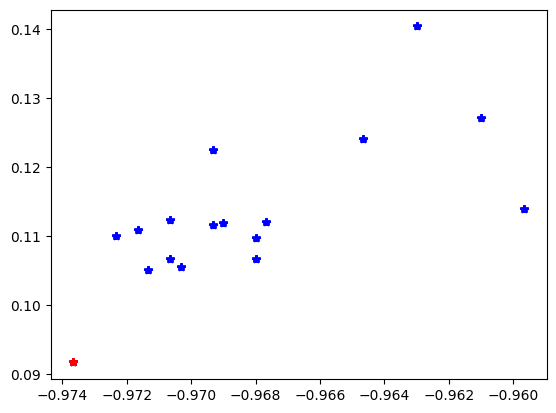

In [ ]:
ga2 = GeneticAlgorithm(10, train_images, test_images, train_labels, test_labels)
result = ga2.solve(generations=10)
frontier_loss = []
frontier_acc = []
for individual in ga2.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga2.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")

In [ ]:
ga3 = GeneticAlgorithm(10, train_images, test_images, train_labels, test_labels)
result = ga3.solve(generations=10)
frontier_loss = []
frontier_acc = []
for individual in ga3.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga3.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)

Generation 0


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 9s 64ms/step - loss: 2.3023 - accuracy: 0.1063 - val_loss: 2.3021 - val_accuracy: 0.1136
Epoch 2/10
88/88 [==============================] - 3s 39ms/step - loss: 2.3014 - accuracy: 0.1116 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 2.3009 - accuracy: 0.1116 - val_loss: 2.3019 - val_accuracy: 0.1136
Epoch 4/10
88/88 [==============================] - 5s 57ms/step - loss: 2.3006 - accuracy: 0.1116 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 2.3004 - accuracy: 0.1116 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 2.3003 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 7/10
88/88 [==============================] - 4s 48ms/step - loss: 2.3002 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 8/10
88

 10%|█         | 1/10 [00:46<06:58, 46.54s/it]

Epoch 1/10
88/88 [==============================] - 6s 47ms/step - loss: 1.1743 - accuracy: 0.6234 - val_loss: 0.5429 - val_accuracy: 0.8421
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.3345 - accuracy: 0.9023 - val_loss: 0.3694 - val_accuracy: 0.8857
Epoch 3/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1900 - accuracy: 0.9461 - val_loss: 0.2435 - val_accuracy: 0.9243
Epoch 4/10
88/88 [==============================] - 4s 48ms/step - loss: 0.1543 - accuracy: 0.9530 - val_loss: 0.1678 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1135 - accuracy: 0.9655 - val_loss: 0.1653 - val_accuracy: 0.9493
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1049 - accuracy: 0.9661 - val_loss: 0.1699 - val_accuracy: 0.9464
Epoch 7/10
88/88 [==============================] - 5s 63ms/step - loss: 0.0811 - accuracy: 0.9741 - val_loss: 0.1302 - val_accuracy: 0.9586
Epoch 8/10
88

 20%|██        | 2/10 [01:31<06:04, 45.51s/it]

Epoch 1/10
88/88 [==============================] - 26s 278ms/step - loss: 1.4961 - accuracy: 0.4411 - val_loss: 0.7061 - val_accuracy: 0.7979
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.4976 - accuracy: 0.8604 - val_loss: 0.4109 - val_accuracy: 0.8700
Epoch 3/10
88/88 [==============================] - 26s 296ms/step - loss: 0.2845 - accuracy: 0.9230 - val_loss: 0.2972 - val_accuracy: 0.9057
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.2022 - accuracy: 0.9434 - val_loss: 0.2302 - val_accuracy: 0.9357
Epoch 5/10
88/88 [==============================] - 24s 271ms/step - loss: 0.1586 - accuracy: 0.9539 - val_loss: 0.2220 - val_accuracy: 0.9386
Epoch 6/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1408 - accuracy: 0.9584 - val_loss: 0.2201 - val_accuracy: 0.9350
Epoch 7/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1093 - accuracy: 0.9704 - val_loss: 0.2120 - val_accuracy: 0.9414

 30%|███       | 3/10 [06:00<17:13, 147.58s/it]

Epoch 1/10
88/88 [==============================] - 9s 85ms/step - loss: 0.9628 - accuracy: 0.6943 - val_loss: 0.3025 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 9s 100ms/step - loss: 0.2352 - accuracy: 0.9320 - val_loss: 0.1828 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 9s 98ms/step - loss: 0.1496 - accuracy: 0.9573 - val_loss: 0.2080 - val_accuracy: 0.9343
Epoch 4/10
88/88 [==============================] - 8s 89ms/step - loss: 0.1139 - accuracy: 0.9668 - val_loss: 0.1543 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 9s 102ms/step - loss: 0.0860 - accuracy: 0.9748 - val_loss: 0.1264 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0648 - accuracy: 0.9805 - val_loss: 0.1292 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 9s 108ms/step - loss: 0.0621 - accuracy: 0.9789 - val_loss: 0.1421 - val_accuracy: 0.9571
Epoch 8/10

 40%|████      | 4/10 [08:25<14:38, 146.44s/it]

Epoch 1/10
88/88 [==============================] - 4s 39ms/step - loss: 2.0228 - accuracy: 0.2611 - val_loss: 1.6385 - val_accuracy: 0.4414
Epoch 2/10
88/88 [==============================] - 5s 60ms/step - loss: 1.4376 - accuracy: 0.4900 - val_loss: 1.2269 - val_accuracy: 0.5929
Epoch 3/10
88/88 [==============================] - 5s 57ms/step - loss: 1.1089 - accuracy: 0.6702 - val_loss: 0.9798 - val_accuracy: 0.7564
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.9222 - accuracy: 0.7763 - val_loss: 0.8341 - val_accuracy: 0.7807
Epoch 5/10
88/88 [==============================] - 3s 40ms/step - loss: 0.8158 - accuracy: 0.7945 - val_loss: 0.7573 - val_accuracy: 0.8071
Epoch 6/10
88/88 [==============================] - 5s 52ms/step - loss: 0.7444 - accuracy: 0.8082 - val_loss: 0.7270 - val_accuracy: 0.7957
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.6841 - accuracy: 0.8007 - val_loss: 0.6694 - val_accuracy: 0.8093
Epoch 8/10
88

 50%|█████     | 5/10 [09:06<09:03, 108.74s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 0.8471 - accuracy: 0.7448 - val_loss: 0.3585 - val_accuracy: 0.8936
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2628 - accuracy: 0.9207 - val_loss: 0.2965 - val_accuracy: 0.9043
Epoch 3/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1645 - accuracy: 0.9546 - val_loss: 0.2909 - val_accuracy: 0.9100
Epoch 4/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1169 - accuracy: 0.9627 - val_loss: 0.1881 - val_accuracy: 0.9386
Epoch 5/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0795 - accuracy: 0.9777 - val_loss: 0.1627 - val_accuracy: 0.9550
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0638 - accuracy: 0.9802 - val_loss: 0.2077 - val_accuracy: 0.9286
Epoch 7/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0442 - accuracy: 0.9875 - val_loss: 0.1666 - val_accuracy: 0.9493
Epoch 8/10
88

 60%|██████    | 6/10 [10:31<06:42, 100.52s/it]

Epoch 1/10
88/88 [==============================] - 4s 37ms/step - loss: 1.3247 - accuracy: 0.5805 - val_loss: 0.5007 - val_accuracy: 0.8400
Epoch 2/10
88/88 [==============================] - 3s 37ms/step - loss: 0.3690 - accuracy: 0.8902 - val_loss: 0.3013 - val_accuracy: 0.9107
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2402 - accuracy: 0.9280 - val_loss: 0.2046 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2035 - accuracy: 0.9384 - val_loss: 0.2136 - val_accuracy: 0.9329
Epoch 5/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1594 - accuracy: 0.9507 - val_loss: 0.1588 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1388 - accuracy: 0.9598 - val_loss: 0.1763 - val_accuracy: 0.9450
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1132 - accuracy: 0.9652 - val_loss: 0.1510 - val_accuracy: 0.9550
Epoch 8/10
88

 70%|███████   | 7/10 [10:59<03:50, 76.86s/it] 

Epoch 1/10
88/88 [==============================] - 4s 31ms/step - loss: 1.0194 - accuracy: 0.6861 - val_loss: 0.3961 - val_accuracy: 0.8829
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 0.3328 - accuracy: 0.9118 - val_loss: 0.2855 - val_accuracy: 0.9186
Epoch 3/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2454 - accuracy: 0.9346 - val_loss: 0.2474 - val_accuracy: 0.9307
Epoch 4/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1947 - accuracy: 0.9445 - val_loss: 0.2726 - val_accuracy: 0.9121
Epoch 5/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1583 - accuracy: 0.9564 - val_loss: 0.2141 - val_accuracy: 0.9329
Epoch 6/10
88/88 [==============================] - 2s 25ms/step - loss: 0.1301 - accuracy: 0.9646 - val_loss: 0.1968 - val_accuracy: 0.9379
Epoch 7/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1047 - accuracy: 0.9712 - val_loss: 0.1819 - val_accuracy: 0.9371
Epoch 8/10
88

 80%|████████  | 8/10 [11:42<02:11, 65.97s/it]

Epoch 1/10
88/88 [==============================] - 6s 51ms/step - loss: 1.6419 - accuracy: 0.4557 - val_loss: 0.8641 - val_accuracy: 0.7279
Epoch 2/10
88/88 [==============================] - 3s 37ms/step - loss: 0.5822 - accuracy: 0.8254 - val_loss: 0.4976 - val_accuracy: 0.8379
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.3973 - accuracy: 0.8868 - val_loss: 0.3567 - val_accuracy: 0.8864
Epoch 4/10
88/88 [==============================] - 5s 59ms/step - loss: 0.2979 - accuracy: 0.9132 - val_loss: 0.3659 - val_accuracy: 0.8850
Epoch 5/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2557 - accuracy: 0.9277 - val_loss: 0.2862 - val_accuracy: 0.9200
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2263 - accuracy: 0.9354 - val_loss: 0.2678 - val_accuracy: 0.9157
Epoch 7/10
88/88 [==============================] - 4s 48ms/step - loss: 0.1870 - accuracy: 0.9480 - val_loss: 0.2672 - val_accuracy: 0.9264
Epoch 8/10
88

 90%|█████████ | 9/10 [12:24<00:58, 58.59s/it]

Epoch 1/10
88/88 [==============================] - 6s 49ms/step - loss: 1.0694 - accuracy: 0.6775 - val_loss: 0.3166 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2551 - accuracy: 0.9259 - val_loss: 0.2232 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1744 - accuracy: 0.9484 - val_loss: 0.1517 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 5s 51ms/step - loss: 0.1315 - accuracy: 0.9629 - val_loss: 0.1472 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1041 - accuracy: 0.9670 - val_loss: 0.1612 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0798 - accuracy: 0.9762 - val_loss: 0.1312 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 5s 57ms/step - loss: 0.0649 - accuracy: 0.9805 - val_loss: 0.1163 - val_accuracy: 0.9600
Epoch 8/10
88

100%|██████████| 10/10 [13:07<00:00, 78.79s/it]


Best Solution -> G:0 ->  Eval: 0.966  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 41ms/step - loss: 1.2912 - accuracy: 0.5552 - val_loss: 0.4736 - val_accuracy: 0.8621
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.3718 - accuracy: 0.8900 - val_loss: 0.2448 - val_accuracy: 0.9279
Epoch 3/10
88/88 [==============================] - 5s 55ms/step - loss: 0.2157 - accuracy: 0.9395 - val_loss: 0.1880 - val_accuracy: 0.9471
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1757 - accuracy: 0.9463 - val_loss: 0.1841 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1272 - accuracy: 0.9600 - val_loss: 0.2409 - val_accuracy: 0.9321
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1141 - accuracy: 0.9643 - val_loss: 0.1485 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 5s 61ms/step - loss: 0.0924 - accuracy: 0.9729 - val_loss: 0.1337 - val_accuracy: 0.9650
Epoch 8/10
88

 10%|█         | 1/10 [01:24<12:39, 84.36s/it]

Epoch 1/10
88/88 [==============================] - 5s 41ms/step - loss: 1.2413 - accuracy: 0.6095 - val_loss: 0.5209 - val_accuracy: 0.8229
Epoch 2/10
88/88 [==============================] - 5s 58ms/step - loss: 0.3669 - accuracy: 0.8879 - val_loss: 0.2902 - val_accuracy: 0.9229
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2230 - accuracy: 0.9348 - val_loss: 0.2166 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1640 - accuracy: 0.9513 - val_loss: 0.1903 - val_accuracy: 0.9457
Epoch 5/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1301 - accuracy: 0.9605 - val_loss: 0.1530 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1093 - accuracy: 0.9691 - val_loss: 0.1552 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0919 - accuracy: 0.9716 - val_loss: 0.1562 - val_accuracy: 0.9493
Epoch 8/10
88

 20%|██        | 2/10 [02:07<08:00, 60.03s/it]

Epoch 1/10
88/88 [==============================] - 3s 27ms/step - loss: 1.1726 - accuracy: 0.6539 - val_loss: 0.5489 - val_accuracy: 0.8529
Epoch 2/10
88/88 [==============================] - 3s 39ms/step - loss: 0.4308 - accuracy: 0.8845 - val_loss: 0.3741 - val_accuracy: 0.8871
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 0.3104 - accuracy: 0.9136 - val_loss: 0.3155 - val_accuracy: 0.9057
Epoch 4/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2499 - accuracy: 0.9304 - val_loss: 0.2984 - val_accuracy: 0.9150
Epoch 5/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2112 - accuracy: 0.9405 - val_loss: 0.2715 - val_accuracy: 0.9129
Epoch 6/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1825 - accuracy: 0.9477 - val_loss: 0.2298 - val_accuracy: 0.9257
Epoch 7/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1541 - accuracy: 0.9555 - val_loss: 0.2394 - val_accuracy: 0.9271
Epoch 8/10
88

 30%|███       | 3/10 [02:35<05:19, 45.58s/it]

Epoch 1/10
88/88 [==============================] - 6s 58ms/step - loss: 1.4913 - accuracy: 0.4886 - val_loss: 0.6500 - val_accuracy: 0.7857
Epoch 2/10
88/88 [==============================] - 4s 45ms/step - loss: 0.4594 - accuracy: 0.8627 - val_loss: 0.3979 - val_accuracy: 0.8764
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2860 - accuracy: 0.9179 - val_loss: 0.2508 - val_accuracy: 0.9307
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2081 - accuracy: 0.9418 - val_loss: 0.1991 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1593 - accuracy: 0.9536 - val_loss: 0.2080 - val_accuracy: 0.9407
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1332 - accuracy: 0.9621 - val_loss: 0.2025 - val_accuracy: 0.9421
Epoch 7/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1179 - accuracy: 0.9650 - val_loss: 0.1575 - val_accuracy: 0.9564
Epoch 8/10
88

 40%|████      | 4/10 [03:18<04:27, 44.56s/it]

Epoch 1/10
88/88 [==============================] - 4s 35ms/step - loss: 1.2456 - accuracy: 0.5954 - val_loss: 0.6380 - val_accuracy: 0.7943
Epoch 2/10
88/88 [==============================] - 3s 36ms/step - loss: 0.4340 - accuracy: 0.8768 - val_loss: 0.3755 - val_accuracy: 0.8871
Epoch 3/10
88/88 [==============================] - 3s 37ms/step - loss: 0.3090 - accuracy: 0.9105 - val_loss: 0.2931 - val_accuracy: 0.9143
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2471 - accuracy: 0.9296 - val_loss: 0.2619 - val_accuracy: 0.9221
Epoch 5/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2088 - accuracy: 0.9423 - val_loss: 0.2374 - val_accuracy: 0.9343
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1768 - accuracy: 0.9489 - val_loss: 0.2307 - val_accuracy: 0.9321
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 0.1499 - accuracy: 0.9586 - val_loss: 0.1915 - val_accuracy: 0.9529
Epoch 8/10
88

 50%|█████     | 5/10 [03:48<03:16, 39.36s/it]

Epoch 1/10
88/88 [==============================] - 7s 55ms/step - loss: 0.9581 - accuracy: 0.7205 - val_loss: 0.2951 - val_accuracy: 0.9071
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2529 - accuracy: 0.9270 - val_loss: 0.2218 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1698 - accuracy: 0.9509 - val_loss: 0.1925 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1271 - accuracy: 0.9613 - val_loss: 0.1436 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0966 - accuracy: 0.9723 - val_loss: 0.1390 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0803 - accuracy: 0.9759 - val_loss: 0.1340 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 6s 65ms/step - loss: 0.0654 - accuracy: 0.9814 - val_loss: 0.1385 - val_accuracy: 0.9586
Epoch 8/10
88

 60%|██████    | 6/10 [04:35<02:47, 41.82s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 0.6195 - accuracy: 0.8300 - val_loss: 0.2756 - val_accuracy: 0.9236
Epoch 2/10
88/88 [==============================] - 4s 46ms/step - loss: 0.2144 - accuracy: 0.9413 - val_loss: 0.2275 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 6s 66ms/step - loss: 0.1392 - accuracy: 0.9566 - val_loss: 0.1610 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0919 - accuracy: 0.9748 - val_loss: 0.1672 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 4s 48ms/step - loss: 0.0644 - accuracy: 0.9841 - val_loss: 0.1311 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 6s 66ms/step - loss: 0.0503 - accuracy: 0.9873 - val_loss: 0.1437 - val_accuracy: 0.9479
Epoch 7/10
88/88 [==============================] - 4s 46ms/step - loss: 0.0372 - accuracy: 0.9898 - val_loss: 0.1558 - val_accuracy: 0.9536
Epoch 8/10
88

 70%|███████   | 7/10 [05:59<02:47, 55.72s/it]

Epoch 1/10
88/88 [==============================] - 6s 51ms/step - loss: 1.6897 - accuracy: 0.4141 - val_loss: 0.8904 - val_accuracy: 0.7093
Epoch 2/10
88/88 [==============================] - 4s 51ms/step - loss: 0.5562 - accuracy: 0.8311 - val_loss: 0.4809 - val_accuracy: 0.8564
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.3087 - accuracy: 0.9118 - val_loss: 0.3026 - val_accuracy: 0.9093
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.2308 - accuracy: 0.9382 - val_loss: 0.2624 - val_accuracy: 0.9293
Epoch 5/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1867 - accuracy: 0.9466 - val_loss: 0.3179 - val_accuracy: 0.9179
Epoch 6/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1631 - accuracy: 0.9536 - val_loss: 0.2334 - val_accuracy: 0.9350
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1443 - accuracy: 0.9607 - val_loss: 0.2579 - val_accuracy: 0.9307
Epoch 8/10
88

 80%|████████  | 8/10 [06:44<01:44, 52.10s/it]

Epoch 1/10
88/88 [==============================] - 4s 31ms/step - loss: 1.4614 - accuracy: 0.5371 - val_loss: 0.6289 - val_accuracy: 0.7943
Epoch 2/10
88/88 [==============================] - 4s 51ms/step - loss: 0.4737 - accuracy: 0.8602 - val_loss: 0.4464 - val_accuracy: 0.8529
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 0.3316 - accuracy: 0.9032 - val_loss: 0.2870 - val_accuracy: 0.9071
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2387 - accuracy: 0.9298 - val_loss: 0.2113 - val_accuracy: 0.9371
Epoch 5/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1813 - accuracy: 0.9445 - val_loss: 0.1863 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1489 - accuracy: 0.9568 - val_loss: 0.1661 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1238 - accuracy: 0.9634 - val_loss: 0.1727 - val_accuracy: 0.9557
Epoch 8/10
88

 90%|█████████ | 9/10 [07:27<00:49, 49.29s/it]

Epoch 1/10
88/88 [==============================] - 7s 63ms/step - loss: 1.1015 - accuracy: 0.6484 - val_loss: 0.3889 - val_accuracy: 0.8914
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.3216 - accuracy: 0.9073 - val_loss: 0.2503 - val_accuracy: 0.9193
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1855 - accuracy: 0.9488 - val_loss: 0.1873 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 6s 67ms/step - loss: 0.1429 - accuracy: 0.9582 - val_loss: 0.1714 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1083 - accuracy: 0.9684 - val_loss: 0.1518 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0884 - accuracy: 0.9729 - val_loss: 0.1972 - val_accuracy: 0.9350
Epoch 7/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0705 - accuracy: 0.9800 - val_loss: 0.1891 - val_accuracy: 0.9379
Epoch 8/10
88

100%|██████████| 10/10 [08:13<00:00, 49.38s/it]


Best Solution -> G:0 ->  Eval: 0.966  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 2


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 0.9104 - accuracy: 0.7409 - val_loss: 0.3448 - val_accuracy: 0.8850
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2535 - accuracy: 0.9257 - val_loss: 0.2122 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 5s 54ms/step - loss: 0.1621 - accuracy: 0.9538 - val_loss: 0.1549 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1202 - accuracy: 0.9661 - val_loss: 0.1393 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0903 - accuracy: 0.9741 - val_loss: 0.1175 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0707 - accuracy: 0.9804 - val_loss: 0.1097 - val_accuracy: 0.9679
Epoch 7/10
88/88 [==============================] - 5s 57ms/step - loss: 0.0646 - accuracy: 0.9807 - val_loss: 0.1014 - val_accuracy: 0.9714
Epoch 8/10
88

 10%|█         | 1/10 [00:44<06:36, 44.07s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 0.9631 - accuracy: 0.7262 - val_loss: 0.3338 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 4s 45ms/step - loss: 0.2597 - accuracy: 0.9279 - val_loss: 0.2206 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1702 - accuracy: 0.9513 - val_loss: 0.2205 - val_accuracy: 0.9343
Epoch 4/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1285 - accuracy: 0.9652 - val_loss: 0.1404 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1003 - accuracy: 0.9700 - val_loss: 0.2459 - val_accuracy: 0.9214
Epoch 6/10
88/88 [==============================] - 5s 58ms/step - loss: 0.0867 - accuracy: 0.9727 - val_loss: 0.1378 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0741 - accuracy: 0.9787 - val_loss: 0.1139 - val_accuracy: 0.9664
Epoch 8/10
88

 20%|██        | 2/10 [01:28<05:54, 44.35s/it]

Epoch 1/10
88/88 [==============================] - 4s 28ms/step - loss: 1.3466 - accuracy: 0.5595 - val_loss: 0.5080 - val_accuracy: 0.8479
Epoch 2/10
88/88 [==============================] - 2s 24ms/step - loss: 0.4014 - accuracy: 0.8793 - val_loss: 0.3356 - val_accuracy: 0.8979
Epoch 3/10
88/88 [==============================] - 3s 35ms/step - loss: 0.2590 - accuracy: 0.9196 - val_loss: 0.2763 - val_accuracy: 0.9179
Epoch 4/10
88/88 [==============================] - 3s 35ms/step - loss: 0.1978 - accuracy: 0.9407 - val_loss: 0.2509 - val_accuracy: 0.9221
Epoch 5/10
88/88 [==============================] - 2s 25ms/step - loss: 0.1661 - accuracy: 0.9504 - val_loss: 0.2024 - val_accuracy: 0.9371
Epoch 6/10
88/88 [==============================] - 2s 25ms/step - loss: 0.1373 - accuracy: 0.9579 - val_loss: 0.1889 - val_accuracy: 0.9457
Epoch 7/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1139 - accuracy: 0.9664 - val_loss: 0.1750 - val_accuracy: 0.9443
Epoch 8/10
88

 30%|███       | 3/10 [01:56<04:17, 36.77s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 0.9747 - accuracy: 0.7025 - val_loss: 0.2673 - val_accuracy: 0.9207
Epoch 2/10
88/88 [==============================] - 5s 52ms/step - loss: 0.2454 - accuracy: 0.9336 - val_loss: 0.2043 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1571 - accuracy: 0.9548 - val_loss: 0.1702 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1160 - accuracy: 0.9666 - val_loss: 0.1320 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0905 - accuracy: 0.9746 - val_loss: 0.1512 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 5s 59ms/step - loss: 0.0772 - accuracy: 0.9787 - val_loss: 0.1119 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0600 - accuracy: 0.9832 - val_loss: 0.1243 - val_accuracy: 0.9579
Epoch 8/10
88

 40%|████      | 4/10 [02:38<03:54, 39.04s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 1.1486 - accuracy: 0.6359 - val_loss: 0.4314 - val_accuracy: 0.8750
Epoch 2/10
88/88 [==============================] - 5s 55ms/step - loss: 0.3518 - accuracy: 0.9002 - val_loss: 0.2718 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 4s 45ms/step - loss: 0.2249 - accuracy: 0.9373 - val_loss: 0.2078 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1631 - accuracy: 0.9543 - val_loss: 0.2028 - val_accuracy: 0.9293
Epoch 5/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1295 - accuracy: 0.9620 - val_loss: 0.1843 - val_accuracy: 0.9493
Epoch 6/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1060 - accuracy: 0.9698 - val_loss: 0.1354 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0845 - accuracy: 0.9757 - val_loss: 0.1384 - val_accuracy: 0.9607
Epoch 8/10
88

 50%|█████     | 5/10 [03:22<03:22, 40.52s/it]

Epoch 1/10
88/88 [==============================] - 6s 56ms/step - loss: 0.9944 - accuracy: 0.7045 - val_loss: 0.3280 - val_accuracy: 0.8957
Epoch 2/10
88/88 [==============================] - 5s 61ms/step - loss: 0.2404 - accuracy: 0.9300 - val_loss: 0.1954 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1549 - accuracy: 0.9557 - val_loss: 0.1785 - val_accuracy: 0.9436
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1169 - accuracy: 0.9643 - val_loss: 0.1657 - val_accuracy: 0.9379
Epoch 5/10
88/88 [==============================] - 4s 51ms/step - loss: 0.0898 - accuracy: 0.9712 - val_loss: 0.1262 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0730 - accuracy: 0.9779 - val_loss: 0.1430 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 4s 46ms/step - loss: 0.0629 - accuracy: 0.9805 - val_loss: 0.1452 - val_accuracy: 0.9500
Epoch 8/10
88

 60%|██████    | 6/10 [04:07<02:49, 42.33s/it]

Epoch 1/10
88/88 [==============================] - 25s 266ms/step - loss: 1.1060 - accuracy: 0.6327 - val_loss: 0.3709 - val_accuracy: 0.8886
Epoch 2/10
88/88 [==============================] - 24s 268ms/step - loss: 0.2544 - accuracy: 0.9248 - val_loss: 0.1926 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1448 - accuracy: 0.9555 - val_loss: 0.1581 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0985 - accuracy: 0.9707 - val_loss: 0.1933 - val_accuracy: 0.9407
Epoch 5/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0755 - accuracy: 0.9773 - val_loss: 0.1642 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0570 - accuracy: 0.9845 - val_loss: 0.1349 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0454 - accuracy: 0.9879 - val_loss: 0.1139 - val_accuracy: 0.9679

 70%|███████   | 7/10 [08:00<05:13, 104.45s/it]

Epoch 1/10
88/88 [==============================] - 6s 53ms/step - loss: 0.9662 - accuracy: 0.7364 - val_loss: 0.3095 - val_accuracy: 0.9136
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2396 - accuracy: 0.9287 - val_loss: 0.1993 - val_accuracy: 0.9379
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1609 - accuracy: 0.9546 - val_loss: 0.1636 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1160 - accuracy: 0.9657 - val_loss: 0.1321 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0903 - accuracy: 0.9712 - val_loss: 0.1392 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0809 - accuracy: 0.9757 - val_loss: 0.1118 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0621 - accuracy: 0.9805 - val_loss: 0.1337 - val_accuracy: 0.9557
Epoch 8/10
88

 80%|████████  | 8/10 [09:24<03:15, 98.00s/it] 

Epoch 1/10
88/88 [==============================] - 5s 41ms/step - loss: 1.0981 - accuracy: 0.6827 - val_loss: 0.3908 - val_accuracy: 0.8829
Epoch 2/10
88/88 [==============================] - 5s 61ms/step - loss: 0.2815 - accuracy: 0.9187 - val_loss: 0.2965 - val_accuracy: 0.9093
Epoch 3/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1796 - accuracy: 0.9471 - val_loss: 0.1527 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1390 - accuracy: 0.9605 - val_loss: 0.1375 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1015 - accuracy: 0.9704 - val_loss: 0.1394 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 4s 46ms/step - loss: 0.0825 - accuracy: 0.9759 - val_loss: 0.1655 - val_accuracy: 0.9450
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0719 - accuracy: 0.9787 - val_loss: 0.1208 - val_accuracy: 0.9657
Epoch 8/10
88

 90%|█████████ | 9/10 [10:48<01:33, 93.52s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 1.1590 - accuracy: 0.6229 - val_loss: 0.5265 - val_accuracy: 0.8457
Epoch 2/10
88/88 [==============================] - 3s 31ms/step - loss: 0.3691 - accuracy: 0.8950 - val_loss: 0.3546 - val_accuracy: 0.8986
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2477 - accuracy: 0.9275 - val_loss: 0.2870 - val_accuracy: 0.9129
Epoch 4/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1814 - accuracy: 0.9475 - val_loss: 0.2240 - val_accuracy: 0.9343
Epoch 5/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1290 - accuracy: 0.9629 - val_loss: 0.1976 - val_accuracy: 0.9400
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1073 - accuracy: 0.9677 - val_loss: 0.2779 - val_accuracy: 0.9207
Epoch 7/10
88/88 [==============================] - 3s 29ms/step - loss: 0.0897 - accuracy: 0.9737 - val_loss: 0.1760 - val_accuracy: 0.9493
Epoch 8/10
88

100%|██████████| 10/10 [11:31<00:00, 69.18s/it]


Best Solution -> G:0 ->  Eval: 0.966  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 3


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 23s 246ms/step - loss: 0.9989 - accuracy: 0.6639 - val_loss: 0.3196 - val_accuracy: 0.8943
Epoch 2/10
88/88 [==============================] - 23s 264ms/step - loss: 0.2370 - accuracy: 0.9341 - val_loss: 0.2066 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 24s 269ms/step - loss: 0.1509 - accuracy: 0.9571 - val_loss: 0.1989 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1096 - accuracy: 0.9680 - val_loss: 0.1480 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0854 - accuracy: 0.9743 - val_loss: 0.1358 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0647 - accuracy: 0.9800 - val_loss: 0.1470 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0522 - accuracy: 0.9841 - val_loss: 0.1135 - val_accuracy: 0.9671

 10%|█         | 1/10 [04:29<40:22, 269.13s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.6696 - accuracy: 0.8029 - val_loss: 0.3170 - val_accuracy: 0.9000
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1729 - accuracy: 0.9496 - val_loss: 0.1459 - val_accuracy: 0.9579
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1104 - accuracy: 0.9688 - val_loss: 0.1412 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0782 - accuracy: 0.9759 - val_loss: 0.1362 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0543 - accuracy: 0.9854 - val_loss: 0.1320 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0512 - accuracy: 0.9825 - val_loss: 0.1258 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0315 - accuracy: 0.9909 - val_loss: 0.1026 - val_accuracy: 0.9693

 20%|██        | 2/10 [08:54<35:36, 267.09s/it]

Epoch 1/10
88/88 [==============================] - 7s 62ms/step - loss: 1.2041 - accuracy: 0.6098 - val_loss: 0.5649 - val_accuracy: 0.8136
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.4037 - accuracy: 0.8800 - val_loss: 0.3001 - val_accuracy: 0.9050
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2512 - accuracy: 0.9282 - val_loss: 0.2451 - val_accuracy: 0.9193
Epoch 4/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1744 - accuracy: 0.9513 - val_loss: 0.1873 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1425 - accuracy: 0.9589 - val_loss: 0.1833 - val_accuracy: 0.9450
Epoch 6/10
88/88 [==============================] - 4s 48ms/step - loss: 0.1023 - accuracy: 0.9718 - val_loss: 0.1353 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0871 - accuracy: 0.9736 - val_loss: 0.2021 - val_accuracy: 0.9457
Epoch 8/10
88

 30%|███       | 3/10 [10:19<21:25, 183.59s/it]

Epoch 1/10
88/88 [==============================] - 4s 31ms/step - loss: 1.3683 - accuracy: 0.5612 - val_loss: 0.4632 - val_accuracy: 0.8614
Epoch 2/10
88/88 [==============================] - 2s 28ms/step - loss: 0.3377 - accuracy: 0.9020 - val_loss: 0.2482 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 2s 26ms/step - loss: 0.2252 - accuracy: 0.9391 - val_loss: 0.2136 - val_accuracy: 0.9286
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1715 - accuracy: 0.9525 - val_loss: 0.1683 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 3s 28ms/step - loss: 0.1356 - accuracy: 0.9625 - val_loss: 0.1667 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1268 - accuracy: 0.9643 - val_loss: 0.1609 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0985 - accuracy: 0.9716 - val_loss: 0.1480 - val_accuracy: 0.9557
Epoch 8/10
88

 40%|████      | 4/10 [11:01<12:47, 127.95s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 1.0330 - accuracy: 0.6705 - val_loss: 0.3801 - val_accuracy: 0.8793
Epoch 2/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2712 - accuracy: 0.9218 - val_loss: 0.2198 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1741 - accuracy: 0.9488 - val_loss: 0.1811 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1308 - accuracy: 0.9634 - val_loss: 0.1633 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1043 - accuracy: 0.9707 - val_loss: 0.1493 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 5s 54ms/step - loss: 0.0904 - accuracy: 0.9721 - val_loss: 0.1481 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 3s 37ms/step - loss: 0.0709 - accuracy: 0.9787 - val_loss: 0.1680 - val_accuracy: 0.9514
Epoch 8/10
88

 50%|█████     | 5/10 [11:44<08:07, 97.42s/it] 

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 1.1181 - accuracy: 0.6441 - val_loss: 0.4565 - val_accuracy: 0.8629
Epoch 2/10
88/88 [==============================] - 5s 59ms/step - loss: 0.3254 - accuracy: 0.9032 - val_loss: 0.2587 - val_accuracy: 0.9143
Epoch 3/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1844 - accuracy: 0.9450 - val_loss: 0.1882 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1510 - accuracy: 0.9557 - val_loss: 0.1642 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 7s 76ms/step - loss: 0.1153 - accuracy: 0.9639 - val_loss: 0.1823 - val_accuracy: 0.9457
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0945 - accuracy: 0.9689 - val_loss: 0.1874 - val_accuracy: 0.9450
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0758 - accuracy: 0.9782 - val_loss: 0.1771 - val_accuracy: 0.9529
Epoch 8/10
88

 60%|██████    | 6/10 [13:09<06:12, 93.02s/it]

Epoch 1/10
88/88 [==============================] - 7s 63ms/step - loss: 1.1028 - accuracy: 0.6289 - val_loss: 0.4336 - val_accuracy: 0.8764
Epoch 2/10
88/88 [==============================] - 4s 49ms/step - loss: 0.2691 - accuracy: 0.9216 - val_loss: 0.2286 - val_accuracy: 0.9264
Epoch 3/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1793 - accuracy: 0.9461 - val_loss: 0.2075 - val_accuracy: 0.9343
Epoch 4/10
88/88 [==============================] - 6s 66ms/step - loss: 0.1394 - accuracy: 0.9596 - val_loss: 0.1915 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1080 - accuracy: 0.9673 - val_loss: 0.1551 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0884 - accuracy: 0.9732 - val_loss: 0.1731 - val_accuracy: 0.9464
Epoch 7/10
88/88 [==============================] - 6s 71ms/step - loss: 0.0804 - accuracy: 0.9759 - val_loss: 0.1635 - val_accuracy: 0.9529
Epoch 8/10
88

 70%|███████   | 7/10 [14:00<03:58, 79.33s/it]

Epoch 1/10
88/88 [==============================] - 6s 56ms/step - loss: 0.9779 - accuracy: 0.7155 - val_loss: 0.3652 - val_accuracy: 0.8929
Epoch 2/10
88/88 [==============================] - 5s 59ms/step - loss: 0.2486 - accuracy: 0.9289 - val_loss: 0.1998 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1618 - accuracy: 0.9543 - val_loss: 0.1698 - val_accuracy: 0.9471
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1249 - accuracy: 0.9625 - val_loss: 0.1353 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1087 - accuracy: 0.9682 - val_loss: 0.1517 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0846 - accuracy: 0.9745 - val_loss: 0.1253 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0767 - accuracy: 0.9766 - val_loss: 0.1214 - val_accuracy: 0.9600
Epoch 8/10
88

 80%|████████  | 8/10 [15:24<02:41, 80.83s/it]

Epoch 1/10
88/88 [==============================] - 7s 64ms/step - loss: 1.2125 - accuracy: 0.6016 - val_loss: 0.4788 - val_accuracy: 0.8514
Epoch 2/10
88/88 [==============================] - 4s 47ms/step - loss: 0.3254 - accuracy: 0.8998 - val_loss: 0.2751 - val_accuracy: 0.9143
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1936 - accuracy: 0.9438 - val_loss: 0.1790 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 5s 54ms/step - loss: 0.1514 - accuracy: 0.9545 - val_loss: 0.1411 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 5s 53ms/step - loss: 0.1159 - accuracy: 0.9650 - val_loss: 0.1313 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0953 - accuracy: 0.9696 - val_loss: 0.1818 - val_accuracy: 0.9479
Epoch 7/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0805 - accuracy: 0.9757 - val_loss: 0.2547 - val_accuracy: 0.9200
Epoch 8/10
88

 90%|█████████ | 9/10 [16:49<01:22, 82.13s/it]

Epoch 1/10
88/88 [==============================] - 31s 312ms/step - loss: 0.9888 - accuracy: 0.6727 - val_loss: 0.2803 - val_accuracy: 0.9136
Epoch 2/10
88/88 [==============================] - 27s 309ms/step - loss: 0.2320 - accuracy: 0.9296 - val_loss: 0.1510 - val_accuracy: 0.9557
Epoch 3/10
88/88 [==============================] - 28s 324ms/step - loss: 0.1355 - accuracy: 0.9620 - val_loss: 0.1926 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 26s 299ms/step - loss: 0.1065 - accuracy: 0.9689 - val_loss: 0.1412 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 26s 299ms/step - loss: 0.0790 - accuracy: 0.9764 - val_loss: 0.1516 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 27s 309ms/step - loss: 0.0618 - accuracy: 0.9800 - val_loss: 0.1518 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 25s 285ms/step - loss: 0.0488 - accuracy: 0.9854 - val_loss: 0.1427 - val_accuracy: 0.9593

100%|██████████| 10/10 [22:19<00:00, 133.97s/it]


Best Solution -> G:0 ->  Eval: 0.966  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 4


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 23s 244ms/step - loss: 1.0169 - accuracy: 0.6536 - val_loss: 0.3401 - val_accuracy: 0.9036
Epoch 2/10
88/88 [==============================] - 24s 277ms/step - loss: 0.2421 - accuracy: 0.9271 - val_loss: 0.2017 - val_accuracy: 0.9486
Epoch 3/10
88/88 [==============================] - 21s 241ms/step - loss: 0.1600 - accuracy: 0.9548 - val_loss: 0.1767 - val_accuracy: 0.9486
Epoch 4/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1133 - accuracy: 0.9659 - val_loss: 0.1791 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0840 - accuracy: 0.9752 - val_loss: 0.1329 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0618 - accuracy: 0.9812 - val_loss: 0.1529 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 24s 268ms/step - loss: 0.0488 - accuracy: 0.9870 - val_loss: 0.1436 - val_accuracy: 0.9621

 10%|█         | 1/10 [03:48<34:18, 228.77s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 0.9071 - accuracy: 0.7348 - val_loss: 0.2910 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2243 - accuracy: 0.9330 - val_loss: 0.2273 - val_accuracy: 0.9221
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1432 - accuracy: 0.9591 - val_loss: 0.1565 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1118 - accuracy: 0.9648 - val_loss: 0.1378 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0790 - accuracy: 0.9755 - val_loss: 0.1410 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0687 - accuracy: 0.9796 - val_loss: 0.1258 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0591 - accuracy: 0.9820 - val_loss: 0.1112 - val_accuracy: 0.9671
Epoch 8/10
88

 20%|██        | 2/10 [04:28<15:42, 117.82s/it]

Epoch 1/10
88/88 [==============================] - 6s 51ms/step - loss: 1.1899 - accuracy: 0.6030 - val_loss: 0.4750 - val_accuracy: 0.8464
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.3607 - accuracy: 0.8954 - val_loss: 0.2696 - val_accuracy: 0.9179
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.2458 - accuracy: 0.9252 - val_loss: 0.2761 - val_accuracy: 0.9107
Epoch 4/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1864 - accuracy: 0.9438 - val_loss: 0.1950 - val_accuracy: 0.9350
Epoch 5/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1454 - accuracy: 0.9568 - val_loss: 0.1968 - val_accuracy: 0.9421
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1206 - accuracy: 0.9652 - val_loss: 0.1853 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0894 - accuracy: 0.9770 - val_loss: 0.1954 - val_accuracy: 0.9436
Epoch 8/10
88

 30%|███       | 3/10 [05:13<09:49, 84.28s/it] 

Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 1.0564 - accuracy: 0.6884 - val_loss: 0.3425 - val_accuracy: 0.8986
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2621 - accuracy: 0.9289 - val_loss: 0.2196 - val_accuracy: 0.9336
Epoch 3/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1778 - accuracy: 0.9500 - val_loss: 0.1735 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1290 - accuracy: 0.9616 - val_loss: 0.1574 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1091 - accuracy: 0.9661 - val_loss: 0.1260 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0838 - accuracy: 0.9761 - val_loss: 0.1239 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 5s 59ms/step - loss: 0.0666 - accuracy: 0.9798 - val_loss: 0.1394 - val_accuracy: 0.9571
Epoch 8/10
88

 40%|████      | 4/10 [05:53<06:42, 67.04s/it]

Epoch 1/10
88/88 [==============================] - 25s 265ms/step - loss: 1.0256 - accuracy: 0.6616 - val_loss: 0.3006 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 22s 253ms/step - loss: 0.2619 - accuracy: 0.9261 - val_loss: 0.1792 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1440 - accuracy: 0.9579 - val_loss: 0.1588 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 23s 263ms/step - loss: 0.1152 - accuracy: 0.9654 - val_loss: 0.1492 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0764 - accuracy: 0.9777 - val_loss: 0.2019 - val_accuracy: 0.9314
Epoch 6/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0646 - accuracy: 0.9805 - val_loss: 0.1418 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 24s 268ms/step - loss: 0.0564 - accuracy: 0.9820 - val_loss: 0.1502 - val_accuracy: 0.9564

 50%|█████     | 5/10 [10:21<11:36, 139.35s/it]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 1.0184 - accuracy: 0.6589 - val_loss: 0.3635 - val_accuracy: 0.8893
Epoch 2/10
88/88 [==============================] - 23s 265ms/step - loss: 0.2762 - accuracy: 0.9216 - val_loss: 0.1953 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 25s 282ms/step - loss: 0.1761 - accuracy: 0.9484 - val_loss: 0.2046 - val_accuracy: 0.9364
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1174 - accuracy: 0.9645 - val_loss: 0.1641 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 24s 279ms/step - loss: 0.0845 - accuracy: 0.9759 - val_loss: 0.1558 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0630 - accuracy: 0.9812 - val_loss: 0.1782 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0600 - accuracy: 0.9793 - val_loss: 0.1340 - val_accuracy: 0.9629

 60%|██████    | 6/10 [14:50<12:13, 183.42s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 0.9362 - accuracy: 0.7282 - val_loss: 0.2986 - val_accuracy: 0.9100
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2503 - accuracy: 0.9259 - val_loss: 0.2114 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1478 - accuracy: 0.9591 - val_loss: 0.1594 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1084 - accuracy: 0.9670 - val_loss: 0.1623 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0860 - accuracy: 0.9746 - val_loss: 0.1396 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 5s 53ms/step - loss: 0.0677 - accuracy: 0.9793 - val_loss: 0.1225 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 4s 50ms/step - loss: 0.0576 - accuracy: 0.9809 - val_loss: 0.1353 - val_accuracy: 0.9614
Epoch 8/10
88

 70%|███████   | 7/10 [15:34<06:53, 137.98s/it]

Epoch 1/10
88/88 [==============================] - 6s 49ms/step - loss: 2.3024 - accuracy: 0.1027 - val_loss: 2.3023 - val_accuracy: 0.0907
Epoch 2/10
88/88 [==============================] - 5s 54ms/step - loss: 2.3016 - accuracy: 0.1070 - val_loss: 2.3021 - val_accuracy: 0.1136
Epoch 3/10
88/88 [==============================] - 5s 53ms/step - loss: 2.3010 - accuracy: 0.1071 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 4/10
88/88 [==============================] - 4s 45ms/step - loss: 2.3006 - accuracy: 0.1089 - val_loss: 2.3021 - val_accuracy: 0.1136
Epoch 5/10
88/88 [==============================] - 5s 57ms/step - loss: 2.3004 - accuracy: 0.1116 - val_loss: 2.3021 - val_accuracy: 0.1136
Epoch 6/10
88/88 [==============================] - 5s 54ms/step - loss: 2.3003 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 2.3002 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 8/10
88

 80%|████████  | 8/10 [16:59<04:01, 120.89s/it]

Epoch 1/10
88/88 [==============================] - 7s 63ms/step - loss: 1.2794 - accuracy: 0.5675 - val_loss: 0.4448 - val_accuracy: 0.8707
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.3442 - accuracy: 0.9048 - val_loss: 0.2450 - val_accuracy: 0.9257
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2067 - accuracy: 0.9382 - val_loss: 0.2060 - val_accuracy: 0.9393
Epoch 4/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1409 - accuracy: 0.9582 - val_loss: 0.1697 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1090 - accuracy: 0.9679 - val_loss: 0.1337 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0862 - accuracy: 0.9748 - val_loss: 0.1299 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0755 - accuracy: 0.9762 - val_loss: 0.1617 - val_accuracy: 0.9536
Epoch 8/10
88

 90%|█████████ | 9/10 [18:24<01:49, 109.65s/it]

Epoch 1/10
88/88 [==============================] - 23s 241ms/step - loss: 0.9969 - accuracy: 0.6755 - val_loss: 0.3128 - val_accuracy: 0.9050
Epoch 2/10
88/88 [==============================] - 22s 255ms/step - loss: 0.2500 - accuracy: 0.9259 - val_loss: 0.2118 - val_accuracy: 0.9329
Epoch 3/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1498 - accuracy: 0.9561 - val_loss: 0.2166 - val_accuracy: 0.9321
Epoch 4/10
88/88 [==============================] - 23s 264ms/step - loss: 0.1155 - accuracy: 0.9654 - val_loss: 0.1634 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0867 - accuracy: 0.9734 - val_loss: 0.1623 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0672 - accuracy: 0.9807 - val_loss: 0.1437 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0435 - accuracy: 0.9866 - val_loss: 0.1215 - val_accuracy: 0.9636

100%|██████████| 10/10 [22:50<00:00, 137.06s/it]


Best Solution -> G:3 ->  Eval: 0.968  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 6s 52ms/step - loss: 0.8986 - accuracy: 0.7598 - val_loss: 0.3200 - val_accuracy: 0.8964
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2408 - accuracy: 0.9311 - val_loss: 0.1751 - val_accuracy: 0.9493
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1573 - accuracy: 0.9575 - val_loss: 0.1666 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1122 - accuracy: 0.9663 - val_loss: 0.1403 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 3s 37ms/step - loss: 0.0891 - accuracy: 0.9737 - val_loss: 0.1457 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0701 - accuracy: 0.9795 - val_loss: 0.1215 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 4s 50ms/step - loss: 0.0605 - accuracy: 0.9829 - val_loss: 0.1388 - val_accuracy: 0.9593
Epoch 8/10
88

 10%|█         | 1/10 [00:42<06:23, 42.60s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 0.9293 - accuracy: 0.7407 - val_loss: 0.3586 - val_accuracy: 0.8807
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2496 - accuracy: 0.9293 - val_loss: 0.2196 - val_accuracy: 0.9286
Epoch 3/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1731 - accuracy: 0.9504 - val_loss: 0.1528 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1330 - accuracy: 0.9616 - val_loss: 0.1588 - val_accuracy: 0.9500
Epoch 5/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1059 - accuracy: 0.9684 - val_loss: 0.1257 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0899 - accuracy: 0.9730 - val_loss: 0.1238 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 5s 61ms/step - loss: 0.0757 - accuracy: 0.9764 - val_loss: 0.1148 - val_accuracy: 0.9686
Epoch 8/10
88

 20%|██        | 2/10 [01:26<05:45, 43.19s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 0.9341 - accuracy: 0.7243 - val_loss: 0.3178 - val_accuracy: 0.8986
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2446 - accuracy: 0.9298 - val_loss: 0.2136 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1674 - accuracy: 0.9513 - val_loss: 0.2142 - val_accuracy: 0.9250
Epoch 4/10
88/88 [==============================] - 6s 63ms/step - loss: 0.1277 - accuracy: 0.9630 - val_loss: 0.1396 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0968 - accuracy: 0.9734 - val_loss: 0.1329 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 5s 59ms/step - loss: 0.0836 - accuracy: 0.9761 - val_loss: 0.1852 - val_accuracy: 0.9379
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0708 - accuracy: 0.9795 - val_loss: 0.1154 - val_accuracy: 0.9686
Epoch 8/10
88

 30%|███       | 3/10 [02:50<07:12, 61.75s/it]

Epoch 1/10
88/88 [==============================] - 23s 254ms/step - loss: 0.7376 - accuracy: 0.7577 - val_loss: 0.2910 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1644 - accuracy: 0.9548 - val_loss: 0.1454 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1002 - accuracy: 0.9680 - val_loss: 0.1296 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0666 - accuracy: 0.9802 - val_loss: 0.1079 - val_accuracy: 0.9736
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0579 - accuracy: 0.9836 - val_loss: 0.1463 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0416 - accuracy: 0.9875 - val_loss: 0.1138 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0247 - accuracy: 0.9925 - val_loss: 0.1290 - val_accuracy: 0.9679

 40%|████      | 4/10 [07:15<14:14, 142.36s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.8350 - accuracy: 0.7241 - val_loss: 0.2777 - val_accuracy: 0.9164
Epoch 2/10
88/88 [==============================] - 22s 253ms/step - loss: 0.2032 - accuracy: 0.9400 - val_loss: 0.1557 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1211 - accuracy: 0.9648 - val_loss: 0.1595 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0925 - accuracy: 0.9707 - val_loss: 0.1308 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0731 - accuracy: 0.9771 - val_loss: 0.1240 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0612 - accuracy: 0.9800 - val_loss: 0.1495 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0480 - accuracy: 0.9841 - val_loss: 0.1205 - val_accuracy: 0.9621

 50%|█████     | 5/10 [11:00<14:20, 172.06s/it]

Epoch 1/10
88/88 [==============================] - 4s 29ms/step - loss: 0.9041 - accuracy: 0.7273 - val_loss: 0.3417 - val_accuracy: 0.8964
Epoch 2/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2946 - accuracy: 0.9155 - val_loss: 0.2934 - val_accuracy: 0.9079
Epoch 3/10
88/88 [==============================] - 3s 29ms/step - loss: 0.2083 - accuracy: 0.9382 - val_loss: 0.2298 - val_accuracy: 0.9279
Epoch 4/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1564 - accuracy: 0.9554 - val_loss: 0.1879 - val_accuracy: 0.9479
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1233 - accuracy: 0.9632 - val_loss: 0.1950 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0935 - accuracy: 0.9745 - val_loss: 0.1964 - val_accuracy: 0.9343
Epoch 7/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0756 - accuracy: 0.9791 - val_loss: 0.1615 - val_accuracy: 0.9493
Epoch 8/10
88

 60%|██████    | 6/10 [11:29<08:13, 123.26s/it]

Epoch 1/10
88/88 [==============================] - 24s 256ms/step - loss: 0.9396 - accuracy: 0.6954 - val_loss: 0.2879 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 21s 243ms/step - loss: 0.2283 - accuracy: 0.9361 - val_loss: 0.1787 - val_accuracy: 0.9564
Epoch 3/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1270 - accuracy: 0.9620 - val_loss: 0.1502 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0994 - accuracy: 0.9704 - val_loss: 0.2594 - val_accuracy: 0.9214
Epoch 5/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0728 - accuracy: 0.9777 - val_loss: 0.1915 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0579 - accuracy: 0.9811 - val_loss: 0.1568 - val_accuracy: 0.9507
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.1569 - val_accuracy: 0.9557

 70%|███████   | 7/10 [15:13<07:49, 156.36s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 0.9911 - accuracy: 0.7009 - val_loss: 0.3257 - val_accuracy: 0.9007
Epoch 2/10
88/88 [==============================] - 5s 53ms/step - loss: 0.2669 - accuracy: 0.9223 - val_loss: 0.2256 - val_accuracy: 0.9279
Epoch 3/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1844 - accuracy: 0.9475 - val_loss: 0.2065 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1434 - accuracy: 0.9586 - val_loss: 0.1808 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1095 - accuracy: 0.9679 - val_loss: 0.1530 - val_accuracy: 0.9500
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0925 - accuracy: 0.9736 - val_loss: 0.1656 - val_accuracy: 0.9457
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0718 - accuracy: 0.9791 - val_loss: 0.1329 - val_accuracy: 0.9579
Epoch 8/10
88

 80%|████████  | 8/10 [15:56<04:00, 120.28s/it]

Epoch 1/10
88/88 [==============================] - 7s 60ms/step - loss: 1.0980 - accuracy: 0.6550 - val_loss: 0.4594 - val_accuracy: 0.8693
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.3391 - accuracy: 0.8995 - val_loss: 0.2767 - val_accuracy: 0.9250
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2182 - accuracy: 0.9343 - val_loss: 0.2223 - val_accuracy: 0.9250
Epoch 4/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1613 - accuracy: 0.9546 - val_loss: 0.2150 - val_accuracy: 0.9307
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1441 - accuracy: 0.9571 - val_loss: 0.1974 - val_accuracy: 0.9421
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1030 - accuracy: 0.9671 - val_loss: 0.1613 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0879 - accuracy: 0.9721 - val_loss: 0.1734 - val_accuracy: 0.9457
Epoch 8/10
88

 90%|█████████ | 9/10 [16:42<01:36, 96.86s/it] 

Epoch 1/10
88/88 [==============================] - 8s 88ms/step - loss: 0.6087 - accuracy: 0.8259 - val_loss: 0.3075 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 9s 98ms/step - loss: 0.2206 - accuracy: 0.9370 - val_loss: 0.2159 - val_accuracy: 0.9336
Epoch 3/10
88/88 [==============================] - 10s 113ms/step - loss: 0.1440 - accuracy: 0.9584 - val_loss: 0.1831 - val_accuracy: 0.9379
Epoch 4/10
88/88 [==============================] - 7s 83ms/step - loss: 0.0947 - accuracy: 0.9754 - val_loss: 0.1552 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 8s 97ms/step - loss: 0.0656 - accuracy: 0.9811 - val_loss: 0.1398 - val_accuracy: 0.9550
Epoch 6/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0468 - accuracy: 0.9898 - val_loss: 0.1444 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 7s 84ms/step - loss: 0.0306 - accuracy: 0.9948 - val_loss: 0.1474 - val_accuracy: 0.9564
Epoch 8/10


100%|██████████| 10/10 [18:03<00:00, 108.39s/it]


Best Solution -> G:3 ->  Eval: 0.968  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 6


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 4s 30ms/step - loss: 1.1676 - accuracy: 0.6691 - val_loss: 0.4399 - val_accuracy: 0.8671
Epoch 2/10
88/88 [==============================] - 3s 35ms/step - loss: 0.3536 - accuracy: 0.8989 - val_loss: 0.2811 - val_accuracy: 0.9121
Epoch 3/10
88/88 [==============================] - 3s 33ms/step - loss: 0.2375 - accuracy: 0.9373 - val_loss: 0.2160 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 3s 28ms/step - loss: 0.1809 - accuracy: 0.9488 - val_loss: 0.1941 - val_accuracy: 0.9357
Epoch 5/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1445 - accuracy: 0.9602 - val_loss: 0.1684 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 0.1217 - accuracy: 0.9655 - val_loss: 0.1523 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1092 - accuracy: 0.9671 - val_loss: 0.1425 - val_accuracy: 0.9607
Epoch 8/10
88

 10%|█         | 1/10 [00:43<06:30, 43.39s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 0.9599 - accuracy: 0.7325 - val_loss: 0.3135 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2496 - accuracy: 0.9246 - val_loss: 0.2205 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1587 - accuracy: 0.9555 - val_loss: 0.1623 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1162 - accuracy: 0.9663 - val_loss: 0.1462 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0952 - accuracy: 0.9729 - val_loss: 0.1339 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 4s 51ms/step - loss: 0.0808 - accuracy: 0.9770 - val_loss: 0.1243 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0672 - accuracy: 0.9795 - val_loss: 0.1370 - val_accuracy: 0.9657
Epoch 8/10
88

 20%|██        | 2/10 [01:26<05:44, 43.06s/it]

Epoch 1/10
88/88 [==============================] - 7s 62ms/step - loss: 1.0241 - accuracy: 0.6857 - val_loss: 0.3361 - val_accuracy: 0.8950
Epoch 2/10
88/88 [==============================] - 5s 54ms/step - loss: 0.2892 - accuracy: 0.9196 - val_loss: 0.2414 - val_accuracy: 0.9250
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1897 - accuracy: 0.9466 - val_loss: 0.2259 - val_accuracy: 0.9221
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1468 - accuracy: 0.9577 - val_loss: 0.1568 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1125 - accuracy: 0.9661 - val_loss: 0.1601 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0896 - accuracy: 0.9723 - val_loss: 0.1294 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0806 - accuracy: 0.9757 - val_loss: 0.1246 - val_accuracy: 0.9607
Epoch 8/10
88

 30%|███       | 3/10 [02:11<05:08, 44.10s/it]

Epoch 1/10
88/88 [==============================] - 26s 284ms/step - loss: 0.6274 - accuracy: 0.8100 - val_loss: 0.1889 - val_accuracy: 0.9443
Epoch 2/10
88/88 [==============================] - 23s 265ms/step - loss: 0.1518 - accuracy: 0.9561 - val_loss: 0.1412 - val_accuracy: 0.9600
Epoch 3/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0994 - accuracy: 0.9702 - val_loss: 0.1076 - val_accuracy: 0.9707
Epoch 4/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0680 - accuracy: 0.9805 - val_loss: 0.1157 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0488 - accuracy: 0.9839 - val_loss: 0.1355 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0369 - accuracy: 0.9884 - val_loss: 0.1180 - val_accuracy: 0.9721
Epoch 7/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0260 - accuracy: 0.9929 - val_loss: 0.1346 - val_accuracy: 0.9643

 40%|████      | 4/10 [06:09<12:03, 120.62s/it]

Epoch 1/10
88/88 [==============================] - 6s 48ms/step - loss: 0.9037 - accuracy: 0.7411 - val_loss: 0.3170 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2394 - accuracy: 0.9254 - val_loss: 0.2054 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1604 - accuracy: 0.9525 - val_loss: 0.1627 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1209 - accuracy: 0.9629 - val_loss: 0.1388 - val_accuracy: 0.9643
Epoch 5/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0947 - accuracy: 0.9720 - val_loss: 0.1444 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 6s 69ms/step - loss: 0.0739 - accuracy: 0.9782 - val_loss: 0.1244 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0686 - accuracy: 0.9777 - val_loss: 0.1407 - val_accuracy: 0.9543
Epoch 8/10
88

 50%|█████     | 5/10 [07:33<08:57, 107.48s/it]

Epoch 1/10
88/88 [==============================] - 6s 56ms/step - loss: 0.9558 - accuracy: 0.7125 - val_loss: 0.3479 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2880 - accuracy: 0.9177 - val_loss: 0.2576 - val_accuracy: 0.9150
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1938 - accuracy: 0.9436 - val_loss: 0.1861 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1418 - accuracy: 0.9604 - val_loss: 0.1601 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1189 - accuracy: 0.9680 - val_loss: 0.1822 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0953 - accuracy: 0.9737 - val_loss: 0.1426 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 5s 59ms/step - loss: 0.0804 - accuracy: 0.9764 - val_loss: 0.1279 - val_accuracy: 0.9607
Epoch 8/10
88

 60%|██████    | 6/10 [08:57<06:37, 99.43s/it] 

Epoch 1/10
88/88 [==============================] - 3s 24ms/step - loss: 0.9336 - accuracy: 0.7521 - val_loss: 0.3670 - val_accuracy: 0.8929
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 0.3046 - accuracy: 0.9146 - val_loss: 0.2530 - val_accuracy: 0.9171
Epoch 3/10
88/88 [==============================] - 3s 35ms/step - loss: 0.2245 - accuracy: 0.9389 - val_loss: 0.2239 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 2s 20ms/step - loss: 0.1797 - accuracy: 0.9480 - val_loss: 0.2098 - val_accuracy: 0.9336
Epoch 5/10
88/88 [==============================] - 2s 22ms/step - loss: 0.1461 - accuracy: 0.9596 - val_loss: 0.2059 - val_accuracy: 0.9329
Epoch 6/10
88/88 [==============================] - 2s 23ms/step - loss: 0.1206 - accuracy: 0.9663 - val_loss: 0.1923 - val_accuracy: 0.9414
Epoch 7/10
88/88 [==============================] - 2s 20ms/step - loss: 0.1023 - accuracy: 0.9721 - val_loss: 0.1557 - val_accuracy: 0.9486
Epoch 8/10
88

 70%|███████   | 7/10 [09:39<04:02, 80.74s/it]

Epoch 1/10
88/88 [==============================] - 6s 49ms/step - loss: 1.2927 - accuracy: 0.5600 - val_loss: 0.5049 - val_accuracy: 0.8386
Epoch 2/10
88/88 [==============================] - 4s 46ms/step - loss: 0.4432 - accuracy: 0.8616 - val_loss: 0.3628 - val_accuracy: 0.8950
Epoch 3/10
88/88 [==============================] - 5s 60ms/step - loss: 0.2789 - accuracy: 0.9137 - val_loss: 0.2642 - val_accuracy: 0.9221
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2098 - accuracy: 0.9377 - val_loss: 0.2295 - val_accuracy: 0.9286
Epoch 5/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1688 - accuracy: 0.9516 - val_loss: 0.2041 - val_accuracy: 0.9386
Epoch 6/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1519 - accuracy: 0.9550 - val_loss: 0.1684 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1194 - accuracy: 0.9646 - val_loss: 0.1723 - val_accuracy: 0.9521
Epoch 8/10
88

 80%|████████  | 8/10 [11:04<02:44, 82.08s/it]

Epoch 1/10
88/88 [==============================] - 6s 55ms/step - loss: 1.1981 - accuracy: 0.6177 - val_loss: 0.4530 - val_accuracy: 0.8664
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.3407 - accuracy: 0.9004 - val_loss: 0.2934 - val_accuracy: 0.9043
Epoch 3/10
88/88 [==============================] - 4s 50ms/step - loss: 0.1902 - accuracy: 0.9448 - val_loss: 0.2459 - val_accuracy: 0.9264
Epoch 4/10
88/88 [==============================] - 5s 53ms/step - loss: 0.1513 - accuracy: 0.9541 - val_loss: 0.2440 - val_accuracy: 0.9221
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1210 - accuracy: 0.9664 - val_loss: 0.1623 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0967 - accuracy: 0.9727 - val_loss: 0.1805 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 6s 69ms/step - loss: 0.0792 - accuracy: 0.9768 - val_loss: 0.1779 - val_accuracy: 0.9486
Epoch 8/10
88

 90%|█████████ | 9/10 [12:29<01:22, 82.81s/it]

Epoch 1/10
88/88 [==============================] - 5s 51ms/step - loss: 0.9927 - accuracy: 0.7123 - val_loss: 0.3758 - val_accuracy: 0.8857
Epoch 2/10
88/88 [==============================] - 4s 50ms/step - loss: 0.2762 - accuracy: 0.9218 - val_loss: 0.2351 - val_accuracy: 0.9257
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1889 - accuracy: 0.9429 - val_loss: 0.1713 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1492 - accuracy: 0.9563 - val_loss: 0.1418 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 4s 51ms/step - loss: 0.1051 - accuracy: 0.9677 - val_loss: 0.1428 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0911 - accuracy: 0.9718 - val_loss: 0.1329 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0835 - accuracy: 0.9759 - val_loss: 0.1760 - val_accuracy: 0.9400
Epoch 8/10
88

100%|██████████| 10/10 [13:12<00:00, 79.21s/it]


Best Solution -> G:4 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 7


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.7519 - accuracy: 0.7532 - val_loss: 0.2238 - val_accuracy: 0.9271
Epoch 2/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1751 - accuracy: 0.9443 - val_loss: 0.2053 - val_accuracy: 0.9379
Epoch 3/10
88/88 [==============================] - 24s 268ms/step - loss: 0.1244 - accuracy: 0.9643 - val_loss: 0.1657 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0836 - accuracy: 0.9750 - val_loss: 0.1865 - val_accuracy: 0.9450
Epoch 5/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0575 - accuracy: 0.9818 - val_loss: 0.1329 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0462 - accuracy: 0.9855 - val_loss: 0.1770 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0396 - accuracy: 0.9884 - val_loss: 0.1405 - val_accuracy: 0.9657

 10%|█         | 1/10 [04:26<39:56, 266.29s/it]

Epoch 1/10
88/88 [==============================] - 5s 47ms/step - loss: 0.8835 - accuracy: 0.7452 - val_loss: 0.4170 - val_accuracy: 0.8879
Epoch 2/10
88/88 [==============================] - 3s 33ms/step - loss: 0.2923 - accuracy: 0.9150 - val_loss: 0.2756 - val_accuracy: 0.9171
Epoch 3/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1991 - accuracy: 0.9414 - val_loss: 0.2130 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1381 - accuracy: 0.9604 - val_loss: 0.1925 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1068 - accuracy: 0.9704 - val_loss: 0.1912 - val_accuracy: 0.9407
Epoch 6/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0764 - accuracy: 0.9795 - val_loss: 0.1501 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 3s 32ms/step - loss: 0.0594 - accuracy: 0.9830 - val_loss: 0.2096 - val_accuracy: 0.9457
Epoch 8/10
88

 20%|██        | 2/10 [04:59<17:13, 129.19s/it]

Epoch 1/10
88/88 [==============================] - 24s 263ms/step - loss: 1.0237 - accuracy: 0.6637 - val_loss: 0.3142 - val_accuracy: 0.9043
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.2457 - accuracy: 0.9275 - val_loss: 0.1853 - val_accuracy: 0.9457
Epoch 3/10
88/88 [==============================] - 25s 283ms/step - loss: 0.1497 - accuracy: 0.9554 - val_loss: 0.1721 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1082 - accuracy: 0.9688 - val_loss: 0.1861 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0961 - accuracy: 0.9696 - val_loss: 0.2083 - val_accuracy: 0.9364
Epoch 6/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0715 - accuracy: 0.9789 - val_loss: 0.1309 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0548 - accuracy: 0.9816 - val_loss: 0.1411 - val_accuracy: 0.9657

 30%|███       | 3/10 [09:28<22:30, 192.94s/it]

Epoch 1/10
88/88 [==============================] - 24s 262ms/step - loss: 0.6869 - accuracy: 0.7932 - val_loss: 0.2228 - val_accuracy: 0.9307
Epoch 2/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1692 - accuracy: 0.9488 - val_loss: 0.1631 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1055 - accuracy: 0.9698 - val_loss: 0.1198 - val_accuracy: 0.9671
Epoch 4/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0648 - accuracy: 0.9804 - val_loss: 0.1113 - val_accuracy: 0.9707
Epoch 5/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0623 - accuracy: 0.9818 - val_loss: 0.1165 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0377 - accuracy: 0.9898 - val_loss: 0.1181 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0285 - accuracy: 0.9920 - val_loss: 0.1182 - val_accuracy: 0.9693

 40%|████      | 4/10 [13:55<22:13, 222.17s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 0.9402 - accuracy: 0.7354 - val_loss: 0.2906 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 0.2403 - accuracy: 0.9321 - val_loss: 0.1984 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 5s 54ms/step - loss: 0.1579 - accuracy: 0.9525 - val_loss: 0.1640 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1248 - accuracy: 0.9613 - val_loss: 0.1387 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0989 - accuracy: 0.9721 - val_loss: 0.1198 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0749 - accuracy: 0.9775 - val_loss: 0.1300 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 3s 40ms/step - loss: 0.0675 - accuracy: 0.9805 - val_loss: 0.1310 - val_accuracy: 0.9629
Epoch 8/10
88

 50%|█████     | 5/10 [14:37<13:07, 157.44s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 1.0597 - accuracy: 0.6698 - val_loss: 0.3750 - val_accuracy: 0.8829
Epoch 2/10
88/88 [==============================] - 5s 54ms/step - loss: 0.3032 - accuracy: 0.9136 - val_loss: 0.2528 - val_accuracy: 0.9250
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2066 - accuracy: 0.9391 - val_loss: 0.1882 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1329 - accuracy: 0.9632 - val_loss: 0.2337 - val_accuracy: 0.9329
Epoch 5/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1141 - accuracy: 0.9654 - val_loss: 0.1836 - val_accuracy: 0.9393
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0858 - accuracy: 0.9764 - val_loss: 0.1415 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0782 - accuracy: 0.9761 - val_loss: 0.1298 - val_accuracy: 0.9621
Epoch 8/10
88

 60%|██████    | 6/10 [15:20<07:53, 118.32s/it]

Epoch 1/10
88/88 [==============================] - 24s 242ms/step - loss: 0.5955 - accuracy: 0.8214 - val_loss: 0.1993 - val_accuracy: 0.9429
Epoch 2/10
88/88 [==============================] - 23s 264ms/step - loss: 0.1409 - accuracy: 0.9591 - val_loss: 0.1451 - val_accuracy: 0.9507
Epoch 3/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0887 - accuracy: 0.9712 - val_loss: 0.1622 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 25s 279ms/step - loss: 0.0614 - accuracy: 0.9804 - val_loss: 0.1663 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 28s 317ms/step - loss: 0.0479 - accuracy: 0.9843 - val_loss: 0.1144 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 25s 288ms/step - loss: 0.0371 - accuracy: 0.9870 - val_loss: 0.1552 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 24s 274ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.1277 - val_accuracy: 0.9729

 70%|███████   | 7/10 [19:32<08:06, 162.08s/it]

Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 0.6733 - accuracy: 0.8118 - val_loss: 0.3484 - val_accuracy: 0.8921
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 0.2456 - accuracy: 0.9279 - val_loss: 0.2247 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1733 - accuracy: 0.9504 - val_loss: 0.2171 - val_accuracy: 0.9307
Epoch 4/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1294 - accuracy: 0.9643 - val_loss: 0.1725 - val_accuracy: 0.9450
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1033 - accuracy: 0.9718 - val_loss: 0.1544 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0770 - accuracy: 0.9787 - val_loss: 0.1468 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 3s 40ms/step - loss: 0.0591 - accuracy: 0.9832 - val_loss: 0.1538 - val_accuracy: 0.9521
Epoch 8/10
88

 80%|████████  | 8/10 [20:15<04:08, 124.15s/it]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.6360 - accuracy: 0.8055 - val_loss: 0.2381 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 26s 292ms/step - loss: 0.1622 - accuracy: 0.9530 - val_loss: 0.1955 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 26s 295ms/step - loss: 0.0998 - accuracy: 0.9686 - val_loss: 0.1226 - val_accuracy: 0.9650
Epoch 4/10
88/88 [==============================] - 25s 283ms/step - loss: 0.0699 - accuracy: 0.9784 - val_loss: 0.1185 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0509 - accuracy: 0.9839 - val_loss: 0.1089 - val_accuracy: 0.9736
Epoch 6/10
88/88 [==============================] - 25s 288ms/step - loss: 0.0361 - accuracy: 0.9904 - val_loss: 0.1250 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0262 - accuracy: 0.9925 - val_loss: 0.0960 - val_accuracy: 0.9736

 90%|█████████ | 9/10 [24:41<02:48, 168.46s/it]

Epoch 1/10
88/88 [==============================] - 7s 62ms/step - loss: 1.2118 - accuracy: 0.6248 - val_loss: 0.4809 - val_accuracy: 0.8586
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.3460 - accuracy: 0.8943 - val_loss: 0.2591 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2311 - accuracy: 0.9309 - val_loss: 0.2423 - val_accuracy: 0.9286
Epoch 4/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1552 - accuracy: 0.9564 - val_loss: 0.1967 - val_accuracy: 0.9386
Epoch 5/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1285 - accuracy: 0.9646 - val_loss: 0.1754 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1014 - accuracy: 0.9716 - val_loss: 0.2024 - val_accuracy: 0.9436
Epoch 7/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1040 - accuracy: 0.9671 - val_loss: 0.2076 - val_accuracy: 0.9329
Epoch 8/10
88

100%|██████████| 10/10 [26:05<00:00, 156.55s/it]


Best Solution -> G:4 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 8


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 266ms/step - loss: 0.6590 - accuracy: 0.7987 - val_loss: 0.2195 - val_accuracy: 0.9307
Epoch 2/10
88/88 [==============================] - 25s 280ms/step - loss: 0.1559 - accuracy: 0.9568 - val_loss: 0.1518 - val_accuracy: 0.9514
Epoch 3/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0892 - accuracy: 0.9755 - val_loss: 0.1472 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0613 - accuracy: 0.9820 - val_loss: 0.1176 - val_accuracy: 0.9664
Epoch 5/10
88/88 [==============================] - 24s 270ms/step - loss: 0.0499 - accuracy: 0.9846 - val_loss: 0.1566 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 26s 297ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.1116 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0198 - accuracy: 0.9946 - val_loss: 0.1149 - val_accuracy: 0.9686

 10%|█         | 1/10 [04:26<40:01, 266.81s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 0.9061 - accuracy: 0.7509 - val_loss: 0.2902 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2426 - accuracy: 0.9296 - val_loss: 0.1989 - val_accuracy: 0.9329
Epoch 3/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1687 - accuracy: 0.9504 - val_loss: 0.1815 - val_accuracy: 0.9421
Epoch 4/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1289 - accuracy: 0.9629 - val_loss: 0.1535 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0995 - accuracy: 0.9705 - val_loss: 0.1522 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 5s 58ms/step - loss: 0.0799 - accuracy: 0.9755 - val_loss: 0.1209 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 4s 46ms/step - loss: 0.0666 - accuracy: 0.9798 - val_loss: 0.1334 - val_accuracy: 0.9629
Epoch 8/10
88

 20%|██        | 2/10 [05:50<21:12, 159.11s/it]

Epoch 1/10
88/88 [==============================] - 23s 243ms/step - loss: 0.8251 - accuracy: 0.7350 - val_loss: 0.3048 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 23s 262ms/step - loss: 0.1927 - accuracy: 0.9468 - val_loss: 0.1941 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1167 - accuracy: 0.9639 - val_loss: 0.1490 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0810 - accuracy: 0.9761 - val_loss: 0.1487 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0679 - accuracy: 0.9773 - val_loss: 0.1514 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0464 - accuracy: 0.9848 - val_loss: 0.1395 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0311 - accuracy: 0.9904 - val_loss: 0.1619 - val_accuracy: 0.9514

 30%|███       | 3/10 [10:19<24:24, 209.23s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 1.0125 - accuracy: 0.7007 - val_loss: 0.3983 - val_accuracy: 0.8750
Epoch 2/10
88/88 [==============================] - 4s 47ms/step - loss: 0.2877 - accuracy: 0.9114 - val_loss: 0.2667 - val_accuracy: 0.9186
Epoch 3/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1958 - accuracy: 0.9413 - val_loss: 0.1972 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 4s 48ms/step - loss: 0.1395 - accuracy: 0.9607 - val_loss: 0.1581 - val_accuracy: 0.9450
Epoch 5/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1090 - accuracy: 0.9698 - val_loss: 0.1497 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 5s 57ms/step - loss: 0.0921 - accuracy: 0.9718 - val_loss: 0.1580 - val_accuracy: 0.9471
Epoch 7/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0725 - accuracy: 0.9784 - val_loss: 0.1648 - val_accuracy: 0.9486
Epoch 8/10
88

 40%|████      | 4/10 [11:05<14:29, 144.88s/it]

Epoch 1/10
88/88 [==============================] - 5s 51ms/step - loss: 0.9670 - accuracy: 0.7225 - val_loss: 0.3259 - val_accuracy: 0.8979
Epoch 2/10
88/88 [==============================] - 4s 49ms/step - loss: 0.2400 - accuracy: 0.9312 - val_loss: 0.2324 - val_accuracy: 0.9243
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1596 - accuracy: 0.9525 - val_loss: 0.1735 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1138 - accuracy: 0.9688 - val_loss: 0.1175 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0952 - accuracy: 0.9712 - val_loss: 0.1128 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0835 - accuracy: 0.9743 - val_loss: 0.1106 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0603 - accuracy: 0.9848 - val_loss: 0.1084 - val_accuracy: 0.9693
Epoch 8/10
88

 50%|█████     | 5/10 [11:48<09:01, 108.25s/it]

Epoch 1/10
88/88 [==============================] - 6s 54ms/step - loss: 0.9728 - accuracy: 0.7121 - val_loss: 0.3290 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2534 - accuracy: 0.9271 - val_loss: 0.2030 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1596 - accuracy: 0.9525 - val_loss: 0.1929 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 5s 58ms/step - loss: 0.1152 - accuracy: 0.9646 - val_loss: 0.1399 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0864 - accuracy: 0.9720 - val_loss: 0.1356 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0709 - accuracy: 0.9791 - val_loss: 0.1211 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 6s 68ms/step - loss: 0.0542 - accuracy: 0.9829 - val_loss: 0.1162 - val_accuracy: 0.9686
Epoch 8/10
88

 60%|██████    | 6/10 [13:13<06:40, 100.21s/it]

Epoch 1/10
88/88 [==============================] - 6s 54ms/step - loss: 0.9864 - accuracy: 0.7034 - val_loss: 0.2998 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 4s 49ms/step - loss: 0.2236 - accuracy: 0.9327 - val_loss: 0.1800 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1525 - accuracy: 0.9564 - val_loss: 0.1828 - val_accuracy: 0.9379
Epoch 4/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1171 - accuracy: 0.9645 - val_loss: 0.1525 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0852 - accuracy: 0.9737 - val_loss: 0.1240 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0665 - accuracy: 0.9795 - val_loss: 0.1440 - val_accuracy: 0.9543
Epoch 7/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0604 - accuracy: 0.9800 - val_loss: 0.1173 - val_accuracy: 0.9664
Epoch 8/10
88

 70%|███████   | 7/10 [13:58<04:06, 82.28s/it] 

Epoch 1/10
88/88 [==============================] - 23s 249ms/step - loss: 0.8144 - accuracy: 0.7536 - val_loss: 0.2891 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1965 - accuracy: 0.9450 - val_loss: 0.1725 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 24s 269ms/step - loss: 0.1200 - accuracy: 0.9673 - val_loss: 0.1489 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0927 - accuracy: 0.9712 - val_loss: 0.1131 - val_accuracy: 0.9686
Epoch 5/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0702 - accuracy: 0.9775 - val_loss: 0.1164 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.1245 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0425 - accuracy: 0.9877 - val_loss: 0.1165 - val_accuracy: 0.9657

 80%|████████  | 8/10 [18:24<04:41, 140.69s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.6495 - accuracy: 0.8089 - val_loss: 0.2139 - val_accuracy: 0.9336
Epoch 2/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1454 - accuracy: 0.9563 - val_loss: 0.1489 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0898 - accuracy: 0.9725 - val_loss: 0.1311 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0593 - accuracy: 0.9820 - val_loss: 0.1218 - val_accuracy: 0.9664
Epoch 5/10
88/88 [==============================] - 24s 270ms/step - loss: 0.0597 - accuracy: 0.9816 - val_loss: 0.1451 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0310 - accuracy: 0.9902 - val_loss: 0.0986 - val_accuracy: 0.9750
Epoch 7/10
88/88 [==============================] - 23s 267ms/step - loss: 0.0258 - accuracy: 0.9911 - val_loss: 0.1280 - val_accuracy: 0.9650

 90%|█████████ | 9/10 [22:50<02:59, 179.84s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 0.8881 - accuracy: 0.7538 - val_loss: 0.3330 - val_accuracy: 0.8879
Epoch 2/10
88/88 [==============================] - 5s 60ms/step - loss: 0.2301 - accuracy: 0.9312 - val_loss: 0.2107 - val_accuracy: 0.9279
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1607 - accuracy: 0.9527 - val_loss: 0.2129 - val_accuracy: 0.9279
Epoch 4/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1121 - accuracy: 0.9682 - val_loss: 0.1432 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 6s 63ms/step - loss: 0.0897 - accuracy: 0.9729 - val_loss: 0.1321 - val_accuracy: 0.9550
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0718 - accuracy: 0.9796 - val_loss: 0.1562 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0627 - accuracy: 0.9821 - val_loss: 0.1090 - val_accuracy: 0.9657
Epoch 8/10
88

100%|██████████| 10/10 [24:14<00:00, 145.44s/it]


Best Solution -> G:4 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 9


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 1.2406 - accuracy: 0.6016 - val_loss: 0.5199 - val_accuracy: 0.8300
Epoch 2/10
88/88 [==============================] - 5s 51ms/step - loss: 0.3291 - accuracy: 0.8991 - val_loss: 0.2831 - val_accuracy: 0.9136
Epoch 3/10
88/88 [==============================] - 4s 46ms/step - loss: 0.2107 - accuracy: 0.9346 - val_loss: 0.1974 - val_accuracy: 0.9421
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1488 - accuracy: 0.9563 - val_loss: 0.1912 - val_accuracy: 0.9443
Epoch 5/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1200 - accuracy: 0.9646 - val_loss: 0.1552 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 5s 51ms/step - loss: 0.1014 - accuracy: 0.9689 - val_loss: 0.1532 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0866 - accuracy: 0.9721 - val_loss: 0.1543 - val_accuracy: 0.9486
Epoch 8/10
88

 10%|█         | 1/10 [00:45<06:45, 45.11s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 1.4612 - accuracy: 0.5539 - val_loss: 0.5051 - val_accuracy: 0.8543
Epoch 2/10
88/88 [==============================] - 3s 30ms/step - loss: 0.3634 - accuracy: 0.8939 - val_loss: 0.2914 - val_accuracy: 0.9079
Epoch 3/10
88/88 [==============================] - 3s 30ms/step - loss: 0.2300 - accuracy: 0.9332 - val_loss: 0.2039 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1722 - accuracy: 0.9507 - val_loss: 0.1863 - val_accuracy: 0.9364
Epoch 5/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1446 - accuracy: 0.9593 - val_loss: 0.1577 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1162 - accuracy: 0.9659 - val_loss: 0.1471 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 3s 29ms/step - loss: 0.0965 - accuracy: 0.9727 - val_loss: 0.1485 - val_accuracy: 0.9536
Epoch 8/10
88

 20%|██        | 2/10 [01:28<05:51, 43.90s/it]

Epoch 1/10
88/88 [==============================] - 23s 253ms/step - loss: 0.6311 - accuracy: 0.8163 - val_loss: 0.1922 - val_accuracy: 0.9443
Epoch 2/10
88/88 [==============================] - 23s 256ms/step - loss: 0.1410 - accuracy: 0.9588 - val_loss: 0.1434 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0862 - accuracy: 0.9746 - val_loss: 0.1433 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 24s 273ms/step - loss: 0.0681 - accuracy: 0.9804 - val_loss: 0.1432 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0440 - accuracy: 0.9866 - val_loss: 0.1078 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0320 - accuracy: 0.9898 - val_loss: 0.1123 - val_accuracy: 0.9729
Epoch 7/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.1145 - val_accuracy: 0.9679

 30%|███       | 3/10 [05:54<16:56, 145.25s/it]

Epoch 1/10
88/88 [==============================] - 6s 57ms/step - loss: 1.1711 - accuracy: 0.6498 - val_loss: 0.4253 - val_accuracy: 0.8679
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2789 - accuracy: 0.9209 - val_loss: 0.2336 - val_accuracy: 0.9329
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1825 - accuracy: 0.9446 - val_loss: 0.2045 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1367 - accuracy: 0.9579 - val_loss: 0.1814 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1100 - accuracy: 0.9671 - val_loss: 0.1340 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0930 - accuracy: 0.9721 - val_loss: 0.1230 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 5s 55ms/step - loss: 0.0732 - accuracy: 0.9777 - val_loss: 0.1301 - val_accuracy: 0.9557
Epoch 8/10
88

 40%|████      | 4/10 [07:17<12:05, 120.96s/it]

Epoch 1/10
88/88 [==============================] - 5s 52ms/step - loss: 0.9427 - accuracy: 0.7289 - val_loss: 0.3542 - val_accuracy: 0.8857
Epoch 2/10
88/88 [==============================] - 4s 49ms/step - loss: 0.2545 - accuracy: 0.9262 - val_loss: 0.2215 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1694 - accuracy: 0.9514 - val_loss: 0.1751 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1291 - accuracy: 0.9623 - val_loss: 0.1682 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1047 - accuracy: 0.9707 - val_loss: 0.1219 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0804 - accuracy: 0.9762 - val_loss: 0.1240 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0708 - accuracy: 0.9795 - val_loss: 0.1466 - val_accuracy: 0.9607
Epoch 8/10
88

 50%|█████     | 5/10 [08:02<07:46, 93.36s/it] 

Epoch 1/10
88/88 [==============================] - 6s 48ms/step - loss: 1.1935 - accuracy: 0.6186 - val_loss: 0.5001 - val_accuracy: 0.8521
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.3544 - accuracy: 0.8938 - val_loss: 0.2757 - val_accuracy: 0.9129
Epoch 3/10
88/88 [==============================] - 4s 49ms/step - loss: 0.2439 - accuracy: 0.9270 - val_loss: 0.2251 - val_accuracy: 0.9286
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1547 - accuracy: 0.9559 - val_loss: 0.1758 - val_accuracy: 0.9450
Epoch 5/10
88/88 [==============================] - 4s 51ms/step - loss: 0.1247 - accuracy: 0.9639 - val_loss: 0.1671 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 5s 54ms/step - loss: 0.0940 - accuracy: 0.9700 - val_loss: 0.1975 - val_accuracy: 0.9336
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0791 - accuracy: 0.9766 - val_loss: 0.1617 - val_accuracy: 0.9471
Epoch 8/10
88

 60%|██████    | 6/10 [09:26<06:01, 90.31s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.8671 - accuracy: 0.7220 - val_loss: 0.2668 - val_accuracy: 0.9179
Epoch 2/10
88/88 [==============================] - 21s 240ms/step - loss: 0.2149 - accuracy: 0.9370 - val_loss: 0.2319 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1433 - accuracy: 0.9568 - val_loss: 0.2250 - val_accuracy: 0.9379
Epoch 4/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1031 - accuracy: 0.9696 - val_loss: 0.1411 - val_accuracy: 0.9586
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0822 - accuracy: 0.9750 - val_loss: 0.1675 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0626 - accuracy: 0.9830 - val_loss: 0.1381 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0530 - accuracy: 0.9841 - val_loss: 0.1396 - val_accuracy: 0.9614

 70%|███████   | 7/10 [13:19<06:50, 136.92s/it]

Epoch 1/10
88/88 [==============================] - 6s 51ms/step - loss: 1.3028 - accuracy: 0.5407 - val_loss: 0.4448 - val_accuracy: 0.8521
Epoch 2/10
88/88 [==============================] - 5s 55ms/step - loss: 0.3438 - accuracy: 0.8954 - val_loss: 0.2627 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 5s 53ms/step - loss: 0.2026 - accuracy: 0.9413 - val_loss: 0.2393 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1537 - accuracy: 0.9520 - val_loss: 0.1518 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1071 - accuracy: 0.9679 - val_loss: 0.1644 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 5s 55ms/step - loss: 0.0922 - accuracy: 0.9718 - val_loss: 0.1569 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 4s 46ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.1655 - val_accuracy: 0.9521
Epoch 8/10
88

 80%|████████  | 8/10 [14:44<04:00, 120.46s/it]

Epoch 1/10
88/88 [==============================] - 28s 307ms/step - loss: 0.7285 - accuracy: 0.7655 - val_loss: 0.2812 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 27s 304ms/step - loss: 0.1837 - accuracy: 0.9461 - val_loss: 0.1748 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 25s 281ms/step - loss: 0.1125 - accuracy: 0.9680 - val_loss: 0.1572 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 26s 293ms/step - loss: 0.0888 - accuracy: 0.9736 - val_loss: 0.1506 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 26s 293ms/step - loss: 0.0755 - accuracy: 0.9775 - val_loss: 0.1276 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 27s 312ms/step - loss: 0.0515 - accuracy: 0.9829 - val_loss: 0.1371 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0415 - accuracy: 0.9875 - val_loss: 0.1123 - val_accuracy: 0.9693

 90%|█████████ | 9/10 [19:11<02:46, 166.16s/it]

Epoch 1/10
88/88 [==============================] - 24s 257ms/step - loss: 0.8254 - accuracy: 0.7377 - val_loss: 0.3034 - val_accuracy: 0.9043
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1682 - accuracy: 0.9505 - val_loss: 0.1802 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1205 - accuracy: 0.9650 - val_loss: 0.1377 - val_accuracy: 0.9536
Epoch 4/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0839 - accuracy: 0.9762 - val_loss: 0.1543 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0626 - accuracy: 0.9800 - val_loss: 0.1824 - val_accuracy: 0.9450
Epoch 6/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.1534 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0328 - accuracy: 0.9927 - val_loss: 0.1047 - val_accuracy: 0.9693

100%|██████████| 10/10 [23:37<00:00, 141.72s/it]


Best Solution -> G:4 ->  Eval: 0.972  Gene: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 25s 252ms/step - loss: 0.8341 - accuracy: 0.7261 - val_loss: 0.2416 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 21s 242ms/step - loss: 0.1903 - accuracy: 0.9438 - val_loss: 0.1921 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1164 - accuracy: 0.9641 - val_loss: 0.1250 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0832 - accuracy: 0.9741 - val_loss: 0.1487 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 23s 267ms/step - loss: 0.0680 - accuracy: 0.9761 - val_loss: 0.1332 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0485 - accuracy: 0.9841 - val_loss: 0.1406 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0370 - accuracy: 0.9877 - val_loss: 0.1543 - val_accuracy: 0.9586

 10%|█         | 1/10 [04:29<40:21, 269.01s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 1.0720 - accuracy: 0.6596 - val_loss: 0.4430 - val_accuracy: 0.8464
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 0.3329 - accuracy: 0.9005 - val_loss: 0.2787 - val_accuracy: 0.9129
Epoch 3/10
88/88 [==============================] - 3s 30ms/step - loss: 0.2270 - accuracy: 0.9336 - val_loss: 0.2852 - val_accuracy: 0.9164
Epoch 4/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1576 - accuracy: 0.9554 - val_loss: 0.2195 - val_accuracy: 0.9264
Epoch 5/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1126 - accuracy: 0.9693 - val_loss: 0.1872 - val_accuracy: 0.9336
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0889 - accuracy: 0.9730 - val_loss: 0.2123 - val_accuracy: 0.9314
Epoch 7/10
88/88 [==============================] - 3s 32ms/step - loss: 0.0654 - accuracy: 0.9811 - val_loss: 0.1622 - val_accuracy: 0.9543
Epoch 8/10
88

 20%|██        | 2/10 [05:12<18:10, 136.33s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.5975 - accuracy: 0.8177 - val_loss: 0.2029 - val_accuracy: 0.9357
Epoch 2/10
88/88 [==============================] - 23s 256ms/step - loss: 0.1410 - accuracy: 0.9593 - val_loss: 0.2065 - val_accuracy: 0.9321
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0926 - accuracy: 0.9727 - val_loss: 0.1709 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0630 - accuracy: 0.9805 - val_loss: 0.1031 - val_accuracy: 0.9729
Epoch 5/10
88/88 [==============================] - 24s 268ms/step - loss: 0.0441 - accuracy: 0.9862 - val_loss: 0.1110 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 25s 290ms/step - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.1132 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 24s 278ms/step - loss: 0.0212 - accuracy: 0.9925 - val_loss: 0.0930 - val_accuracy: 0.9764

 30%|███       | 3/10 [09:40<22:56, 196.64s/it]

Epoch 1/10
88/88 [==============================] - 31s 322ms/step - loss: 1.0340 - accuracy: 0.6493 - val_loss: 0.3630 - val_accuracy: 0.8979
Epoch 2/10
88/88 [==============================] - 26s 295ms/step - loss: 0.2398 - accuracy: 0.9304 - val_loss: 0.2804 - val_accuracy: 0.9193
Epoch 3/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1502 - accuracy: 0.9548 - val_loss: 0.2342 - val_accuracy: 0.9271
Epoch 4/10
88/88 [==============================] - 26s 298ms/step - loss: 0.1157 - accuracy: 0.9641 - val_loss: 0.1655 - val_accuracy: 0.9471
Epoch 5/10
88/88 [==============================] - 27s 301ms/step - loss: 0.0934 - accuracy: 0.9707 - val_loss: 0.2175 - val_accuracy: 0.9350
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0722 - accuracy: 0.9771 - val_loss: 0.1890 - val_accuracy: 0.9386
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0527 - accuracy: 0.9837 - val_loss: 0.1489 - val_accuracy: 0.9536

 40%|████      | 4/10 [13:56<22:00, 220.02s/it]

Epoch 1/10
88/88 [==============================] - 25s 262ms/step - loss: 1.8500 - accuracy: 0.2820 - val_loss: 1.6223 - val_accuracy: 0.3564
Epoch 2/10
88/88 [==============================] - 23s 259ms/step - loss: 1.1569 - accuracy: 0.5261 - val_loss: 0.8708 - val_accuracy: 0.6336
Epoch 3/10
88/88 [==============================] - 22s 247ms/step - loss: 0.6389 - accuracy: 0.7679 - val_loss: 0.5083 - val_accuracy: 0.8479
Epoch 4/10
88/88 [==============================] - 22s 248ms/step - loss: 0.3688 - accuracy: 0.9021 - val_loss: 0.3829 - val_accuracy: 0.8943
Epoch 5/10
88/88 [==============================] - 23s 266ms/step - loss: 0.2710 - accuracy: 0.9246 - val_loss: 0.3034 - val_accuracy: 0.9079
Epoch 6/10
88/88 [==============================] - 21s 242ms/step - loss: 0.2054 - accuracy: 0.9432 - val_loss: 0.3398 - val_accuracy: 0.9043
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1715 - accuracy: 0.9504 - val_loss: 0.3033 - val_accuracy: 0.9171

 50%|█████     | 5/10 [18:25<19:48, 237.74s/it]

Epoch 1/10
88/88 [==============================] - 5s 47ms/step - loss: 1.0197 - accuracy: 0.6913 - val_loss: 0.4148 - val_accuracy: 0.8750
Epoch 2/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2886 - accuracy: 0.9150 - val_loss: 0.2822 - val_accuracy: 0.9143
Epoch 3/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1876 - accuracy: 0.9448 - val_loss: 0.1762 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1393 - accuracy: 0.9582 - val_loss: 0.1624 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 5s 53ms/step - loss: 0.1096 - accuracy: 0.9673 - val_loss: 0.1642 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0890 - accuracy: 0.9723 - val_loss: 0.1767 - val_accuracy: 0.9443
Epoch 7/10
88/88 [==============================] - 5s 53ms/step - loss: 0.0653 - accuracy: 0.9805 - val_loss: 0.1498 - val_accuracy: 0.9557
Epoch 8/10
88

 60%|██████    | 6/10 [19:50<12:22, 185.52s/it]

Epoch 1/10
88/88 [==============================] - 6s 48ms/step - loss: 1.1038 - accuracy: 0.6630 - val_loss: 0.4118 - val_accuracy: 0.8736
Epoch 2/10
88/88 [==============================] - 5s 57ms/step - loss: 0.3133 - accuracy: 0.9091 - val_loss: 0.2240 - val_accuracy: 0.9329
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1966 - accuracy: 0.9413 - val_loss: 0.2159 - val_accuracy: 0.9214
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1445 - accuracy: 0.9566 - val_loss: 0.1857 - val_accuracy: 0.9386
Epoch 5/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1160 - accuracy: 0.9663 - val_loss: 0.1644 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1037 - accuracy: 0.9664 - val_loss: 0.1423 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0827 - accuracy: 0.9766 - val_loss: 0.1220 - val_accuracy: 0.9671
Epoch 8/10
88

 70%|███████   | 7/10 [21:15<07:38, 152.67s/it]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.7352 - accuracy: 0.7779 - val_loss: 0.2749 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1725 - accuracy: 0.9514 - val_loss: 0.1876 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1044 - accuracy: 0.9691 - val_loss: 0.1238 - val_accuracy: 0.9643
Epoch 4/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0766 - accuracy: 0.9764 - val_loss: 0.1228 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.1099 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0350 - accuracy: 0.9891 - val_loss: 0.1259 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.1227 - val_accuracy: 0.9643

 80%|████████  | 8/10 [25:42<06:18, 189.05s/it]

Epoch 1/10
88/88 [==============================] - 26s 284ms/step - loss: 0.6546 - accuracy: 0.8002 - val_loss: 0.2548 - val_accuracy: 0.9164
Epoch 2/10
88/88 [==============================] - 25s 282ms/step - loss: 0.1727 - accuracy: 0.9505 - val_loss: 0.1159 - val_accuracy: 0.9657
Epoch 3/10
88/88 [==============================] - 24s 277ms/step - loss: 0.1025 - accuracy: 0.9704 - val_loss: 0.1173 - val_accuracy: 0.9671
Epoch 4/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0730 - accuracy: 0.9775 - val_loss: 0.1361 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 25s 282ms/step - loss: 0.0477 - accuracy: 0.9852 - val_loss: 0.1132 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0439 - accuracy: 0.9864 - val_loss: 0.0991 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 0.1074 - val_accuracy: 0.9729

 90%|█████████ | 9/10 [30:10<03:33, 213.87s/it]

Epoch 1/10
88/88 [==============================] - 24s 263ms/step - loss: 0.8919 - accuracy: 0.7212 - val_loss: 0.4433 - val_accuracy: 0.8550
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.2260 - accuracy: 0.9389 - val_loss: 0.2366 - val_accuracy: 0.9250
Epoch 3/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1430 - accuracy: 0.9598 - val_loss: 0.2429 - val_accuracy: 0.9221
Epoch 4/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1066 - accuracy: 0.9670 - val_loss: 0.1592 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0698 - accuracy: 0.9786 - val_loss: 0.1294 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0593 - accuracy: 0.9809 - val_loss: 0.1039 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0397 - accuracy: 0.9887 - val_loss: 0.1585 - val_accuracy: 0.9536

100%|██████████| 10/10 [34:36<00:00, 207.63s/it]


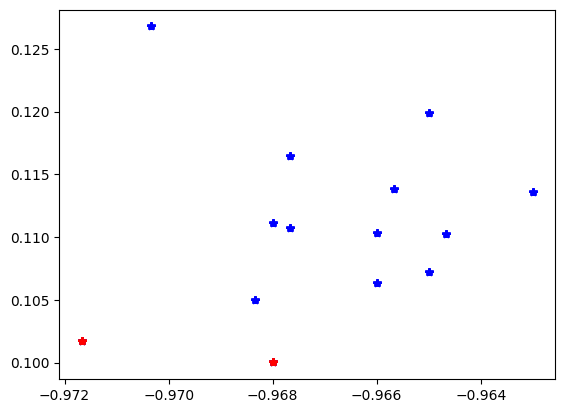

In [ ]:
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")

In [ ]:
ga4 = GeneticAlgorithm(10, train_images, test_images, train_labels, test_labels)
result = ga4.solve(generations=10)
frontier_loss = []
frontier_acc = []
for individual in ga4.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga4.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)

Generation 0


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 6s 42ms/step - loss: 0.8777 - accuracy: 0.7445 - val_loss: 0.3419 - val_accuracy: 0.8986
Epoch 2/10
88/88 [==============================] - 5s 51ms/step - loss: 0.2974 - accuracy: 0.9155 - val_loss: 0.2790 - val_accuracy: 0.9186
Epoch 3/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2155 - accuracy: 0.9389 - val_loss: 0.2777 - val_accuracy: 0.9179
Epoch 4/10
88/88 [==============================] - 2s 19ms/step - loss: 0.1806 - accuracy: 0.9477 - val_loss: 0.2474 - val_accuracy: 0.9250
Epoch 5/10
88/88 [==============================] - 2s 18ms/step - loss: 0.1338 - accuracy: 0.9607 - val_loss: 0.2054 - val_accuracy: 0.9393
Epoch 6/10
88/88 [==============================] - 2s 18ms/step - loss: 0.1010 - accuracy: 0.9712 - val_loss: 0.1741 - val_accuracy: 0.9450
Epoch 7/10
88/88 [==============================] - 2s 18ms/step - loss: 0.0858 - accuracy: 0.9755 - val_loss: 0.2452 - val_accuracy: 0.9229
Epoch 8/10
88

 10%|█         | 1/10 [00:26<03:54, 26.08s/it]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.9083 - accuracy: 0.6941 - val_loss: 0.2873 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 22s 251ms/step - loss: 0.2065 - accuracy: 0.9357 - val_loss: 0.2024 - val_accuracy: 0.9443
Epoch 3/10
88/88 [==============================] - 23s 262ms/step - loss: 0.1247 - accuracy: 0.9630 - val_loss: 0.1522 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0855 - accuracy: 0.9737 - val_loss: 0.1130 - val_accuracy: 0.9686
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0596 - accuracy: 0.9802 - val_loss: 0.1204 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0399 - accuracy: 0.9873 - val_loss: 0.0983 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0308 - accuracy: 0.9914 - val_loss: 0.1133 - val_accuracy: 0.9693

 20%|██        | 2/10 [04:13<19:17, 144.66s/it]

Epoch 1/10
88/88 [==============================] - 9s 82ms/step - loss: 1.0781 - accuracy: 0.6500 - val_loss: 0.4435 - val_accuracy: 0.8493
Epoch 2/10
88/88 [==============================] - 8s 95ms/step - loss: 0.2650 - accuracy: 0.9214 - val_loss: 0.3656 - val_accuracy: 0.8836
Epoch 3/10
88/88 [==============================] - 7s 76ms/step - loss: 0.1807 - accuracy: 0.9438 - val_loss: 0.1721 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 8s 90ms/step - loss: 0.1284 - accuracy: 0.9614 - val_loss: 0.1478 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 7s 75ms/step - loss: 0.0961 - accuracy: 0.9739 - val_loss: 0.2138 - val_accuracy: 0.9371
Epoch 6/10
88/88 [==============================] - 8s 91ms/step - loss: 0.0718 - accuracy: 0.9782 - val_loss: 0.1315 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 7s 76ms/step - loss: 0.0550 - accuracy: 0.9830 - val_loss: 0.1205 - val_accuracy: 0.9679
Epoch 8/10
88

 30%|███       | 3/10 [05:39<13:43, 117.60s/it]

Epoch 1/10
88/88 [==============================] - 22s 240ms/step - loss: 0.9008 - accuracy: 0.6975 - val_loss: 0.3312 - val_accuracy: 0.8893
Epoch 2/10
88/88 [==============================] - 23s 258ms/step - loss: 0.2215 - accuracy: 0.9329 - val_loss: 0.1839 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1254 - accuracy: 0.9636 - val_loss: 0.1536 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0901 - accuracy: 0.9709 - val_loss: 0.1564 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0759 - accuracy: 0.9754 - val_loss: 0.1398 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0570 - accuracy: 0.9823 - val_loss: 0.0966 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0358 - accuracy: 0.9889 - val_loss: 0.1067 - val_accuracy: 0.9693

 40%|████      | 4/10 [09:22<15:55, 159.32s/it]

Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 1.3769 - accuracy: 0.5511 - val_loss: 0.6745 - val_accuracy: 0.7914
Epoch 2/10
88/88 [==============================] - 5s 54ms/step - loss: 0.4822 - accuracy: 0.8571 - val_loss: 0.3490 - val_accuracy: 0.9007
Epoch 3/10
88/88 [==============================] - 3s 37ms/step - loss: 0.3015 - accuracy: 0.9136 - val_loss: 0.2868 - val_accuracy: 0.9207
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2221 - accuracy: 0.9341 - val_loss: 0.2908 - val_accuracy: 0.9100
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1807 - accuracy: 0.9479 - val_loss: 0.2252 - val_accuracy: 0.9293
Epoch 6/10
88/88 [==============================] - 4s 51ms/step - loss: 0.1495 - accuracy: 0.9552 - val_loss: 0.2474 - val_accuracy: 0.9357
Epoch 7/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1181 - accuracy: 0.9671 - val_loss: 0.2392 - val_accuracy: 0.9329
Epoch 8/10
88

 50%|█████     | 5/10 [10:05<09:47, 117.49s/it]

Epoch 1/10
88/88 [==============================] - 10s 98ms/step - loss: 1.9926 - accuracy: 0.2229 - val_loss: 1.6633 - val_accuracy: 0.3514
Epoch 2/10
88/88 [==============================] - 7s 78ms/step - loss: 1.5042 - accuracy: 0.3743 - val_loss: 1.4468 - val_accuracy: 0.4721
Epoch 3/10
88/88 [==============================] - 8s 94ms/step - loss: 1.3273 - accuracy: 0.5150 - val_loss: 1.2870 - val_accuracy: 0.5329
Epoch 4/10
88/88 [==============================] - 8s 92ms/step - loss: 1.1727 - accuracy: 0.5914 - val_loss: 1.2986 - val_accuracy: 0.5757
Epoch 5/10
88/88 [==============================] - 7s 82ms/step - loss: 1.0809 - accuracy: 0.6261 - val_loss: 1.1518 - val_accuracy: 0.6300
Epoch 6/10
88/88 [==============================] - 8s 95ms/step - loss: 0.9865 - accuracy: 0.6623 - val_loss: 1.0408 - val_accuracy: 0.6564
Epoch 7/10
88/88 [==============================] - 7s 79ms/step - loss: 0.9176 - accuracy: 0.6773 - val_loss: 0.9470 - val_accuracy: 0.6779
Epoch 8/10
8

 60%|██████    | 6/10 [11:26<07:00, 105.14s/it]

Epoch 1/10
88/88 [==============================] - 3s 19ms/step - loss: 1.1271 - accuracy: 0.6441 - val_loss: 0.3919 - val_accuracy: 0.8764
Epoch 2/10
88/88 [==============================] - 2s 20ms/step - loss: 0.3111 - accuracy: 0.9116 - val_loss: 0.2948 - val_accuracy: 0.9150
Epoch 3/10
88/88 [==============================] - 3s 30ms/step - loss: 0.2276 - accuracy: 0.9327 - val_loss: 0.2675 - val_accuracy: 0.9221
Epoch 4/10
88/88 [==============================] - 2s 19ms/step - loss: 0.1864 - accuracy: 0.9448 - val_loss: 0.2731 - val_accuracy: 0.9207
Epoch 5/10
88/88 [==============================] - 2s 17ms/step - loss: 0.1610 - accuracy: 0.9545 - val_loss: 0.2153 - val_accuracy: 0.9314
Epoch 6/10
88/88 [==============================] - 2s 17ms/step - loss: 0.1197 - accuracy: 0.9679 - val_loss: 0.1914 - val_accuracy: 0.9436
Epoch 7/10
88/88 [==============================] - 2s 17ms/step - loss: 0.0958 - accuracy: 0.9737 - val_loss: 0.1937 - val_accuracy: 0.9421
Epoch 8/10
88

 70%|███████   | 7/10 [11:49<03:54, 78.03s/it] 

Epoch 1/10
88/88 [==============================] - 23s 247ms/step - loss: 0.8761 - accuracy: 0.7064 - val_loss: 0.2724 - val_accuracy: 0.9157
Epoch 2/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1894 - accuracy: 0.9398 - val_loss: 0.1692 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 23s 263ms/step - loss: 0.1148 - accuracy: 0.9661 - val_loss: 0.2532 - val_accuracy: 0.9236
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0958 - accuracy: 0.9709 - val_loss: 0.1225 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0536 - accuracy: 0.9830 - val_loss: 0.1303 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0491 - accuracy: 0.9852 - val_loss: 0.1386 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0457 - accuracy: 0.9854 - val_loss: 0.1200 - val_accuracy: 0.9643

 80%|████████  | 8/10 [16:15<04:36, 138.12s/it]

Epoch 1/10
88/88 [==============================] - 4s 39ms/step - loss: 0.8464 - accuracy: 0.7282 - val_loss: 0.3245 - val_accuracy: 0.9157
Epoch 2/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2769 - accuracy: 0.9220 - val_loss: 0.2443 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 5s 54ms/step - loss: 0.2039 - accuracy: 0.9407 - val_loss: 0.2226 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1397 - accuracy: 0.9616 - val_loss: 0.1802 - val_accuracy: 0.9436
Epoch 5/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1052 - accuracy: 0.9716 - val_loss: 0.1610 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.0783 - accuracy: 0.9793 - val_loss: 0.1869 - val_accuracy: 0.9379
Epoch 7/10
88/88 [==============================] - 5s 55ms/step - loss: 0.0568 - accuracy: 0.9870 - val_loss: 0.1466 - val_accuracy: 0.9550
Epoch 8/10
88

 90%|█████████ | 9/10 [16:58<01:48, 108.24s/it]

Epoch 1/10
88/88 [==============================] - 3s 24ms/step - loss: 2.3022 - accuracy: 0.1086 - val_loss: 2.3022 - val_accuracy: 0.0986
Epoch 2/10
88/88 [==============================] - 2s 24ms/step - loss: 2.3014 - accuracy: 0.1045 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 3/10
88/88 [==============================] - 3s 37ms/step - loss: 2.3008 - accuracy: 0.1116 - val_loss: 2.3019 - val_accuracy: 0.1136
Epoch 4/10
88/88 [==============================] - 2s 25ms/step - loss: 2.3006 - accuracy: 0.1063 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 5/10
88/88 [==============================] - 2s 24ms/step - loss: 2.3004 - accuracy: 0.1116 - val_loss: 2.3021 - val_accuracy: 0.1136
Epoch 6/10
88/88 [==============================] - 2s 24ms/step - loss: 2.3003 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 7/10
88/88 [==============================] - 2s 22ms/step - loss: 2.3002 - accuracy: 0.1075 - val_loss: 2.3022 - val_accuracy: 0.1136
Epoch 8/10
88

100%|██████████| 10/10 [17:41<00:00, 106.16s/it]


Best Solution -> G:0 ->  Eval: 0.968  Gene: [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Generation 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 23s 253ms/step - loss: 0.7770 - accuracy: 0.7445 - val_loss: 0.2518 - val_accuracy: 0.9150
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1960 - accuracy: 0.9407 - val_loss: 0.1989 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1196 - accuracy: 0.9632 - val_loss: 0.1604 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0795 - accuracy: 0.9782 - val_loss: 0.1053 - val_accuracy: 0.9729
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0564 - accuracy: 0.9829 - val_loss: 0.0932 - val_accuracy: 0.9764
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0520 - accuracy: 0.9839 - val_loss: 0.1141 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0310 - accuracy: 0.9911 - val_loss: 0.1237 - val_accuracy: 0.9679

 10%|█         | 1/10 [04:26<39:54, 266.08s/it]

Epoch 1/10
88/88 [==============================] - 24s 250ms/step - loss: 0.8585 - accuracy: 0.7232 - val_loss: 0.2478 - val_accuracy: 0.9286
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1997 - accuracy: 0.9407 - val_loss: 0.1892 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1158 - accuracy: 0.9646 - val_loss: 0.2045 - val_accuracy: 0.9371
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0896 - accuracy: 0.9727 - val_loss: 0.0962 - val_accuracy: 0.9700
Epoch 5/10
88/88 [==============================] - 21s 245ms/step - loss: 0.0621 - accuracy: 0.9818 - val_loss: 0.1256 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0515 - accuracy: 0.9834 - val_loss: 0.1539 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0327 - accuracy: 0.9900 - val_loss: 0.1051 - val_accuracy: 0.9757

 20%|██        | 2/10 [08:52<35:30, 266.35s/it]

Epoch 1/10
88/88 [==============================] - 9s 89ms/step - loss: 0.5785 - accuracy: 0.8284 - val_loss: 0.2922 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 7s 76ms/step - loss: 0.2146 - accuracy: 0.9393 - val_loss: 0.2220 - val_accuracy: 0.9257
Epoch 3/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1299 - accuracy: 0.9648 - val_loss: 0.1947 - val_accuracy: 0.9379
Epoch 4/10
88/88 [==============================] - 6s 74ms/step - loss: 0.0828 - accuracy: 0.9759 - val_loss: 0.1610 - val_accuracy: 0.9479
Epoch 5/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0590 - accuracy: 0.9859 - val_loss: 0.1918 - val_accuracy: 0.9343
Epoch 6/10
88/88 [==============================] - 7s 75ms/step - loss: 0.0419 - accuracy: 0.9895 - val_loss: 0.1453 - val_accuracy: 0.9500
Epoch 7/10
88/88 [==============================] - 8s 91ms/step - loss: 0.0279 - accuracy: 0.9932 - val_loss: 0.1476 - val_accuracy: 0.9571
Epoch 8/10
88

 30%|███       | 3/10 [10:16<21:20, 182.97s/it]

Epoch 1/10
88/88 [==============================] - 23s 242ms/step - loss: 0.9700 - accuracy: 0.6670 - val_loss: 0.3204 - val_accuracy: 0.9050
Epoch 2/10
88/88 [==============================] - 21s 245ms/step - loss: 0.2296 - accuracy: 0.9305 - val_loss: 0.1832 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1354 - accuracy: 0.9568 - val_loss: 0.1612 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1069 - accuracy: 0.9663 - val_loss: 0.1782 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0751 - accuracy: 0.9770 - val_loss: 0.1284 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0606 - accuracy: 0.9804 - val_loss: 0.1921 - val_accuracy: 0.9450
Epoch 7/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0458 - accuracy: 0.9852 - val_loss: 0.1832 - val_accuracy: 0.9579

 40%|████      | 4/10 [14:42<21:35, 215.94s/it]

Epoch 1/10
88/88 [==============================] - 23s 246ms/step - loss: 0.8541 - accuracy: 0.7241 - val_loss: 0.2912 - val_accuracy: 0.9107
Epoch 2/10
88/88 [==============================] - 20s 229ms/step - loss: 0.2258 - accuracy: 0.9355 - val_loss: 0.1489 - val_accuracy: 0.9564
Epoch 3/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1238 - accuracy: 0.9632 - val_loss: 0.1540 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0938 - accuracy: 0.9720 - val_loss: 0.1815 - val_accuracy: 0.9457
Epoch 5/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0746 - accuracy: 0.9771 - val_loss: 0.1179 - val_accuracy: 0.9679
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0572 - accuracy: 0.9836 - val_loss: 0.0982 - val_accuracy: 0.9736
Epoch 7/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0366 - accuracy: 0.9889 - val_loss: 0.1675 - val_accuracy: 0.9600

 50%|█████     | 5/10 [19:08<19:29, 233.92s/it]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 0.9113 - accuracy: 0.6886 - val_loss: 0.3619 - val_accuracy: 0.8871
Epoch 2/10
88/88 [==============================] - 20s 230ms/step - loss: 0.2317 - accuracy: 0.9336 - val_loss: 0.2087 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1396 - accuracy: 0.9600 - val_loss: 0.1652 - val_accuracy: 0.9471
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1132 - accuracy: 0.9655 - val_loss: 0.1158 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0723 - accuracy: 0.9796 - val_loss: 0.1080 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0670 - accuracy: 0.9789 - val_loss: 0.1197 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0615 - accuracy: 0.9805 - val_loss: 0.0979 - val_accuracy: 0.9736

 60%|██████    | 6/10 [22:43<15:10, 227.56s/it]

Epoch 1/10
88/88 [==============================] - 21s 230ms/step - loss: 1.7071 - accuracy: 0.3309 - val_loss: 1.2459 - val_accuracy: 0.5157
Epoch 2/10
88/88 [==============================] - 21s 243ms/step - loss: 0.8444 - accuracy: 0.6954 - val_loss: 0.4929 - val_accuracy: 0.8607
Epoch 3/10
88/88 [==============================] - 20s 229ms/step - loss: 0.3736 - accuracy: 0.9002 - val_loss: 0.2849 - val_accuracy: 0.9229
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.2101 - accuracy: 0.9439 - val_loss: 0.2089 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 20s 229ms/step - loss: 0.1481 - accuracy: 0.9618 - val_loss: 0.1897 - val_accuracy: 0.9457
Epoch 6/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1191 - accuracy: 0.9661 - val_loss: 0.1369 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0838 - accuracy: 0.9771 - val_loss: 0.1377 - val_accuracy: 0.9614

 70%|███████   | 7/10 [27:10<12:00, 240.22s/it]

Epoch 1/10
88/88 [==============================] - 22s 233ms/step - loss: 0.8944 - accuracy: 0.7111 - val_loss: 0.3547 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 23s 262ms/step - loss: 0.2250 - accuracy: 0.9334 - val_loss: 0.1647 - val_accuracy: 0.9550
Epoch 3/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1498 - accuracy: 0.9568 - val_loss: 0.1858 - val_accuracy: 0.9393
Epoch 4/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1005 - accuracy: 0.9684 - val_loss: 0.1514 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0716 - accuracy: 0.9773 - val_loss: 0.1160 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0486 - accuracy: 0.9850 - val_loss: 0.1154 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0488 - accuracy: 0.9837 - val_loss: 0.0960 - val_accuracy: 0.9764

 80%|████████  | 8/10 [30:47<07:45, 232.86s/it]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 0.8867 - accuracy: 0.7161 - val_loss: 0.2926 - val_accuracy: 0.9086
Epoch 2/10
88/88 [==============================] - 20s 229ms/step - loss: 0.2292 - accuracy: 0.9321 - val_loss: 0.1601 - val_accuracy: 0.9579
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1394 - accuracy: 0.9577 - val_loss: 0.1966 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 20s 233ms/step - loss: 0.1007 - accuracy: 0.9720 - val_loss: 0.2003 - val_accuracy: 0.9386
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0836 - accuracy: 0.9750 - val_loss: 0.1662 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0597 - accuracy: 0.9812 - val_loss: 0.1043 - val_accuracy: 0.9721
Epoch 7/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0385 - accuracy: 0.9880 - val_loss: 0.1389 - val_accuracy: 0.9593

 90%|█████████ | 9/10 [34:24<03:47, 227.83s/it]

Epoch 1/10
88/88 [==============================] - 23s 249ms/step - loss: 0.8916 - accuracy: 0.7195 - val_loss: 0.2902 - val_accuracy: 0.9179
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.2118 - accuracy: 0.9418 - val_loss: 0.1904 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1312 - accuracy: 0.9623 - val_loss: 0.1842 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0879 - accuracy: 0.9725 - val_loss: 0.1565 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0748 - accuracy: 0.9762 - val_loss: 0.1352 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0533 - accuracy: 0.9834 - val_loss: 0.1404 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0388 - accuracy: 0.9866 - val_loss: 0.1391 - val_accuracy: 0.9657

100%|██████████| 10/10 [38:04<00:00, 228.45s/it]


Best Solution -> G:1 ->  Eval: 0.971  Gene: [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Generation 2


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 259ms/step - loss: 0.9796 - accuracy: 0.6666 - val_loss: 0.2936 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.2162 - accuracy: 0.9404 - val_loss: 0.1824 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1368 - accuracy: 0.9593 - val_loss: 0.1464 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1062 - accuracy: 0.9695 - val_loss: 0.1414 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0659 - accuracy: 0.9807 - val_loss: 0.1233 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0580 - accuracy: 0.9845 - val_loss: 0.1364 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0433 - accuracy: 0.9871 - val_loss: 0.1734 - val_accuracy: 0.9443

 10%|█         | 1/10 [04:28<40:19, 268.83s/it]

Epoch 1/10
88/88 [==============================] - 25s 261ms/step - loss: 1.0757 - accuracy: 0.6441 - val_loss: 0.3524 - val_accuracy: 0.8871
Epoch 2/10
88/88 [==============================] - 20s 230ms/step - loss: 0.2456 - accuracy: 0.9237 - val_loss: 0.1895 - val_accuracy: 0.9443
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1426 - accuracy: 0.9575 - val_loss: 0.2080 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1098 - accuracy: 0.9661 - val_loss: 0.1231 - val_accuracy: 0.9664
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0772 - accuracy: 0.9768 - val_loss: 0.1514 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0594 - accuracy: 0.9829 - val_loss: 0.1429 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0556 - accuracy: 0.9823 - val_loss: 0.1529 - val_accuracy: 0.9571

 20%|██        | 2/10 [08:05<31:46, 238.35s/it]

Epoch 1/10
88/88 [==============================] - 22s 233ms/step - loss: 0.8982 - accuracy: 0.7121 - val_loss: 0.3177 - val_accuracy: 0.9007
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.2016 - accuracy: 0.9420 - val_loss: 0.2509 - val_accuracy: 0.9157
Epoch 3/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1275 - accuracy: 0.9620 - val_loss: 0.1904 - val_accuracy: 0.9329
Epoch 4/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0938 - accuracy: 0.9718 - val_loss: 0.1529 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0664 - accuracy: 0.9780 - val_loss: 0.1490 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0541 - accuracy: 0.9846 - val_loss: 0.1235 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0398 - accuracy: 0.9871 - val_loss: 0.1338 - val_accuracy: 0.9607

 30%|███       | 3/10 [12:32<29:18, 251.17s/it]

Epoch 1/10
88/88 [==============================] - 22s 232ms/step - loss: 0.6509 - accuracy: 0.7987 - val_loss: 0.2746 - val_accuracy: 0.9250
Epoch 2/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1742 - accuracy: 0.9477 - val_loss: 0.1315 - val_accuracy: 0.9643
Epoch 3/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0988 - accuracy: 0.9721 - val_loss: 0.1218 - val_accuracy: 0.9643
Epoch 4/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0719 - accuracy: 0.9771 - val_loss: 0.1185 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0475 - accuracy: 0.9870 - val_loss: 0.1005 - val_accuracy: 0.9736
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0371 - accuracy: 0.9889 - val_loss: 0.1197 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0854 - val_accuracy: 0.9779

 40%|████      | 4/10 [16:05<23:38, 236.38s/it]

Epoch 1/10
88/88 [==============================] - 24s 256ms/step - loss: 0.8997 - accuracy: 0.7230 - val_loss: 0.2804 - val_accuracy: 0.9107
Epoch 2/10
88/88 [==============================] - 20s 229ms/step - loss: 0.1942 - accuracy: 0.9434 - val_loss: 0.2230 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1210 - accuracy: 0.9621 - val_loss: 0.1430 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0910 - accuracy: 0.9709 - val_loss: 0.1225 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0591 - accuracy: 0.9825 - val_loss: 0.1292 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0463 - accuracy: 0.9839 - val_loss: 0.1095 - val_accuracy: 0.9729
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0431 - accuracy: 0.9855 - val_loss: 0.1209 - val_accuracy: 0.9664

 50%|█████     | 5/10 [20:31<20:35, 247.00s/it]

Epoch 1/10
88/88 [==============================] - 23s 246ms/step - loss: 0.7145 - accuracy: 0.7777 - val_loss: 0.2101 - val_accuracy: 0.9379
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1620 - accuracy: 0.9513 - val_loss: 0.1339 - val_accuracy: 0.9564
Epoch 3/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1056 - accuracy: 0.9698 - val_loss: 0.1341 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0738 - accuracy: 0.9764 - val_loss: 0.1024 - val_accuracy: 0.9764
Epoch 5/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0506 - accuracy: 0.9852 - val_loss: 0.1060 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0368 - accuracy: 0.9889 - val_loss: 0.1027 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 0.1131 - val_accuracy: 0.9700

 60%|██████    | 6/10 [24:57<16:53, 253.29s/it]

Epoch 1/10
88/88 [==============================] - 23s 247ms/step - loss: 0.9650 - accuracy: 0.6718 - val_loss: 0.3394 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.2509 - accuracy: 0.9280 - val_loss: 0.2075 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 22s 251ms/step - loss: 0.1662 - accuracy: 0.9504 - val_loss: 0.1669 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 20s 228ms/step - loss: 0.1046 - accuracy: 0.9693 - val_loss: 0.1374 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0735 - accuracy: 0.9768 - val_loss: 0.1278 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0612 - accuracy: 0.9793 - val_loss: 0.1092 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0478 - accuracy: 0.9855 - val_loss: 0.1379 - val_accuracy: 0.9607

 70%|███████   | 7/10 [29:23<12:52, 257.46s/it]

Epoch 1/10
88/88 [==============================] - 23s 251ms/step - loss: 0.7704 - accuracy: 0.7384 - val_loss: 0.3423 - val_accuracy: 0.8829
Epoch 2/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1845 - accuracy: 0.9432 - val_loss: 0.2324 - val_accuracy: 0.9229
Epoch 3/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1170 - accuracy: 0.9636 - val_loss: 0.1183 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0825 - accuracy: 0.9730 - val_loss: 0.1451 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0612 - accuracy: 0.9804 - val_loss: 0.1243 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0503 - accuracy: 0.9850 - val_loss: 0.1171 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0375 - accuracy: 0.9859 - val_loss: 0.1094 - val_accuracy: 0.9721

 80%|████████  | 8/10 [33:49<08:40, 260.19s/it]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 1.0690 - accuracy: 0.6320 - val_loss: 0.3857 - val_accuracy: 0.8921
Epoch 2/10
88/88 [==============================] - 21s 234ms/step - loss: 0.2599 - accuracy: 0.9257 - val_loss: 0.2447 - val_accuracy: 0.9250
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1505 - accuracy: 0.9557 - val_loss: 0.1836 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0956 - accuracy: 0.9732 - val_loss: 0.1604 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0863 - accuracy: 0.9750 - val_loss: 0.1130 - val_accuracy: 0.9714
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0618 - accuracy: 0.9805 - val_loss: 0.1691 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0460 - accuracy: 0.9859 - val_loss: 0.1139 - val_accuracy: 0.9743

 90%|█████████ | 9/10 [37:27<04:06, 246.90s/it]

Epoch 1/10
88/88 [==============================] - 8s 79ms/step - loss: 1.0435 - accuracy: 0.6538 - val_loss: 0.3788 - val_accuracy: 0.8921
Epoch 2/10
88/88 [==============================] - 8s 95ms/step - loss: 0.2623 - accuracy: 0.9275 - val_loss: 0.2117 - val_accuracy: 0.9286
Epoch 3/10
88/88 [==============================] - 7s 79ms/step - loss: 0.1839 - accuracy: 0.9484 - val_loss: 0.2072 - val_accuracy: 0.9286
Epoch 4/10
88/88 [==============================] - 8s 93ms/step - loss: 0.1288 - accuracy: 0.9621 - val_loss: 0.1415 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 8s 96ms/step - loss: 0.0990 - accuracy: 0.9696 - val_loss: 0.1832 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 7s 79ms/step - loss: 0.0855 - accuracy: 0.9745 - val_loss: 0.1333 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0574 - accuracy: 0.9829 - val_loss: 0.1455 - val_accuracy: 0.9621
Epoch 8/10
88

100%|██████████| 10/10 [38:51<00:00, 233.18s/it]


Best Solution -> G:2 ->  Eval: 0.973  Gene: [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]
Generation 3


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 254ms/step - loss: 0.8987 - accuracy: 0.7154 - val_loss: 0.3164 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 21s 235ms/step - loss: 0.2120 - accuracy: 0.9364 - val_loss: 0.2025 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1464 - accuracy: 0.9552 - val_loss: 0.1640 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1022 - accuracy: 0.9686 - val_loss: 0.1650 - val_accuracy: 0.9500
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0738 - accuracy: 0.9771 - val_loss: 0.1304 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0582 - accuracy: 0.9814 - val_loss: 0.1232 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0504 - accuracy: 0.9845 - val_loss: 0.1114 - val_accuracy: 0.9679

 10%|█         | 1/10 [03:39<32:59, 219.90s/it]

Epoch 1/10
88/88 [==============================] - 23s 251ms/step - loss: 0.8785 - accuracy: 0.7088 - val_loss: 0.2505 - val_accuracy: 0.9221
Epoch 2/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1979 - accuracy: 0.9466 - val_loss: 0.1678 - val_accuracy: 0.9450
Epoch 3/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1084 - accuracy: 0.9686 - val_loss: 0.1521 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0755 - accuracy: 0.9766 - val_loss: 0.1468 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0548 - accuracy: 0.9846 - val_loss: 0.1179 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0578 - accuracy: 0.9812 - val_loss: 0.1039 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0397 - accuracy: 0.9886 - val_loss: 0.1344 - val_accuracy: 0.9693

 20%|██        | 2/10 [08:05<32:55, 246.95s/it]

Epoch 1/10
88/88 [==============================] - 24s 257ms/step - loss: 0.8142 - accuracy: 0.7357 - val_loss: 0.2497 - val_accuracy: 0.9286
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.2097 - accuracy: 0.9414 - val_loss: 0.1927 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1366 - accuracy: 0.9582 - val_loss: 0.1554 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0924 - accuracy: 0.9734 - val_loss: 0.1361 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0716 - accuracy: 0.9771 - val_loss: 0.1266 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0498 - accuracy: 0.9839 - val_loss: 0.1372 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0383 - accuracy: 0.9871 - val_loss: 0.1021 - val_accuracy: 0.9757

 30%|███       | 3/10 [12:32<29:52, 256.06s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.9279 - accuracy: 0.6848 - val_loss: 0.2992 - val_accuracy: 0.9114
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1970 - accuracy: 0.9402 - val_loss: 0.1855 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 22s 251ms/step - loss: 0.1249 - accuracy: 0.9605 - val_loss: 0.1564 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0945 - accuracy: 0.9714 - val_loss: 0.1281 - val_accuracy: 0.9664
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0675 - accuracy: 0.9775 - val_loss: 0.1656 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0568 - accuracy: 0.9805 - val_loss: 0.1045 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.1339 - val_accuracy: 0.9629

 40%|████      | 4/10 [17:00<26:03, 260.59s/it]

Epoch 1/10
88/88 [==============================] - 22s 235ms/step - loss: 0.8863 - accuracy: 0.7002 - val_loss: 0.3135 - val_accuracy: 0.8979
Epoch 2/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1950 - accuracy: 0.9414 - val_loss: 0.2164 - val_accuracy: 0.9236
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1301 - accuracy: 0.9620 - val_loss: 0.1327 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0802 - accuracy: 0.9752 - val_loss: 0.1475 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0823 - accuracy: 0.9723 - val_loss: 0.1419 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0507 - accuracy: 0.9848 - val_loss: 0.1426 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0354 - accuracy: 0.9887 - val_loss: 0.1265 - val_accuracy: 0.9657

 50%|█████     | 5/10 [21:29<21:58, 263.79s/it]

Epoch 1/10
88/88 [==============================] - 23s 249ms/step - loss: 1.0731 - accuracy: 0.6525 - val_loss: 0.3401 - val_accuracy: 0.8964
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.2522 - accuracy: 0.9257 - val_loss: 0.1660 - val_accuracy: 0.9514
Epoch 3/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1383 - accuracy: 0.9573 - val_loss: 0.1352 - val_accuracy: 0.9579
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1038 - accuracy: 0.9663 - val_loss: 0.1253 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0815 - accuracy: 0.9746 - val_loss: 0.1397 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0517 - accuracy: 0.9829 - val_loss: 0.1216 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0354 - accuracy: 0.9886 - val_loss: 0.0962 - val_accuracy: 0.9757

 60%|██████    | 6/10 [25:55<17:38, 264.58s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.8346 - accuracy: 0.7377 - val_loss: 0.2605 - val_accuracy: 0.9171
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1803 - accuracy: 0.9475 - val_loss: 0.1645 - val_accuracy: 0.9557
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1193 - accuracy: 0.9646 - val_loss: 0.1462 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0742 - accuracy: 0.9762 - val_loss: 0.1135 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0662 - accuracy: 0.9802 - val_loss: 0.1025 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0381 - accuracy: 0.9864 - val_loss: 0.0960 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.1195 - val_accuracy: 0.9657

 70%|███████   | 7/10 [29:29<12:23, 247.78s/it]

Epoch 1/10
88/88 [==============================] - 23s 234ms/step - loss: 1.0362 - accuracy: 0.6573 - val_loss: 0.4086 - val_accuracy: 0.8807
Epoch 2/10
88/88 [==============================] - 22s 251ms/step - loss: 0.2601 - accuracy: 0.9266 - val_loss: 0.2438 - val_accuracy: 0.9243
Epoch 3/10
88/88 [==============================] - 20s 229ms/step - loss: 0.1354 - accuracy: 0.9595 - val_loss: 0.1670 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1162 - accuracy: 0.9670 - val_loss: 0.1321 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0716 - accuracy: 0.9771 - val_loss: 0.0935 - val_accuracy: 0.9714
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0697 - accuracy: 0.9787 - val_loss: 0.1164 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0541 - accuracy: 0.9839 - val_loss: 0.1459 - val_accuracy: 0.9579

 80%|████████  | 8/10 [33:02<07:53, 236.92s/it]

Epoch 1/10
88/88 [==============================] - 23s 251ms/step - loss: 0.9480 - accuracy: 0.6966 - val_loss: 0.3863 - val_accuracy: 0.8807
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.2174 - accuracy: 0.9373 - val_loss: 0.1567 - val_accuracy: 0.9564
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1398 - accuracy: 0.9577 - val_loss: 0.1729 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0949 - accuracy: 0.9704 - val_loss: 0.1541 - val_accuracy: 0.9529
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0777 - accuracy: 0.9762 - val_loss: 0.1746 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0554 - accuracy: 0.9843 - val_loss: 0.1149 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0406 - accuracy: 0.9866 - val_loss: 0.1183 - val_accuracy: 0.9636

 90%|█████████ | 9/10 [37:28<04:06, 246.07s/it]

Epoch 1/10
88/88 [==============================] - 22s 239ms/step - loss: 0.7804 - accuracy: 0.7439 - val_loss: 0.3654 - val_accuracy: 0.8900
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1900 - accuracy: 0.9457 - val_loss: 0.1850 - val_accuracy: 0.9521
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1190 - accuracy: 0.9661 - val_loss: 0.1278 - val_accuracy: 0.9664
Epoch 4/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0891 - accuracy: 0.9737 - val_loss: 0.1432 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0611 - accuracy: 0.9809 - val_loss: 0.1186 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0548 - accuracy: 0.9823 - val_loss: 0.2031 - val_accuracy: 0.9407
Epoch 7/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0514 - accuracy: 0.9839 - val_loss: 0.1343 - val_accuracy: 0.9664

100%|██████████| 10/10 [41:54<00:00, 251.49s/it]


Best Solution -> G:1 ->  Eval: 0.975  Gene: [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Generation 4


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 38ms/step - loss: 1.1191 - accuracy: 0.6366 - val_loss: 0.5306 - val_accuracy: 0.8279
Epoch 2/10
88/88 [==============================] - 4s 51ms/step - loss: 0.3635 - accuracy: 0.8923 - val_loss: 0.3639 - val_accuracy: 0.8879
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2336 - accuracy: 0.9307 - val_loss: 0.2379 - val_accuracy: 0.9229
Epoch 4/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1724 - accuracy: 0.9488 - val_loss: 0.2544 - val_accuracy: 0.9186
Epoch 5/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1324 - accuracy: 0.9611 - val_loss: 0.1433 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1088 - accuracy: 0.9677 - val_loss: 0.1383 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0980 - accuracy: 0.9688 - val_loss: 0.1419 - val_accuracy: 0.9629
Epoch 8/10
88

 10%|█         | 1/10 [00:43<06:29, 43.31s/it]

Epoch 1/10
88/88 [==============================] - 5s 39ms/step - loss: 1.2820 - accuracy: 0.5745 - val_loss: 0.4452 - val_accuracy: 0.8636
Epoch 2/10
88/88 [==============================] - 5s 54ms/step - loss: 0.3485 - accuracy: 0.8989 - val_loss: 0.2867 - val_accuracy: 0.9057
Epoch 3/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2290 - accuracy: 0.9336 - val_loss: 0.2109 - val_accuracy: 0.9329
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1610 - accuracy: 0.9520 - val_loss: 0.1762 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1319 - accuracy: 0.9634 - val_loss: 0.1839 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 4s 50ms/step - loss: 0.1348 - accuracy: 0.9598 - val_loss: 0.1412 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1005 - accuracy: 0.9712 - val_loss: 0.1299 - val_accuracy: 0.9643
Epoch 8/10
88

 20%|██        | 2/10 [01:22<05:27, 40.93s/it]

Epoch 1/10
88/88 [==============================] - 23s 243ms/step - loss: 0.9273 - accuracy: 0.7029 - val_loss: 0.3244 - val_accuracy: 0.9071
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.2280 - accuracy: 0.9345 - val_loss: 0.1996 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1271 - accuracy: 0.9618 - val_loss: 0.1332 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0952 - accuracy: 0.9734 - val_loss: 0.1327 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0618 - accuracy: 0.9820 - val_loss: 0.1338 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0467 - accuracy: 0.9848 - val_loss: 0.1090 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0393 - accuracy: 0.9873 - val_loss: 0.1217 - val_accuracy: 0.9593

 30%|███       | 3/10 [04:58<14:04, 120.65s/it]

Epoch 1/10
88/88 [==============================] - 22s 235ms/step - loss: 0.9339 - accuracy: 0.6834 - val_loss: 0.2579 - val_accuracy: 0.9229
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.2178 - accuracy: 0.9346 - val_loss: 0.1829 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1244 - accuracy: 0.9645 - val_loss: 0.1443 - val_accuracy: 0.9579
Epoch 4/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0925 - accuracy: 0.9727 - val_loss: 0.1185 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0725 - accuracy: 0.9789 - val_loss: 0.1618 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0486 - accuracy: 0.9870 - val_loss: 0.1079 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0427 - accuracy: 0.9889 - val_loss: 0.1204 - val_accuracy: 0.9657

 40%|████      | 4/10 [09:24<17:48, 178.11s/it]

Epoch 1/10
88/88 [==============================] - 24s 248ms/step - loss: 1.0068 - accuracy: 0.6675 - val_loss: 0.3525 - val_accuracy: 0.9000
Epoch 2/10
88/88 [==============================] - 23s 257ms/step - loss: 0.2411 - accuracy: 0.9302 - val_loss: 0.1713 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1355 - accuracy: 0.9600 - val_loss: 0.1449 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0941 - accuracy: 0.9737 - val_loss: 0.1040 - val_accuracy: 0.9721
Epoch 5/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0668 - accuracy: 0.9796 - val_loss: 0.1314 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0610 - accuracy: 0.9816 - val_loss: 0.1072 - val_accuracy: 0.9721
Epoch 7/10
88/88 [==============================] - 23s 256ms/step - loss: 0.0372 - accuracy: 0.9880 - val_loss: 0.1235 - val_accuracy: 0.9629

 50%|█████     | 5/10 [13:07<16:11, 194.28s/it]

Epoch 1/10
88/88 [==============================] - 22s 236ms/step - loss: 0.7640 - accuracy: 0.7643 - val_loss: 0.2802 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1811 - accuracy: 0.9463 - val_loss: 0.1525 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1055 - accuracy: 0.9702 - val_loss: 0.1346 - val_accuracy: 0.9621
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0703 - accuracy: 0.9793 - val_loss: 0.1427 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0518 - accuracy: 0.9805 - val_loss: 0.1767 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0430 - accuracy: 0.9875 - val_loss: 0.1284 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0343 - accuracy: 0.9887 - val_loss: 0.0996 - val_accuracy: 0.9750

 60%|██████    | 6/10 [16:47<13:32, 203.23s/it]

Epoch 1/10
88/88 [==============================] - 23s 242ms/step - loss: 0.9619 - accuracy: 0.6532 - val_loss: 0.3446 - val_accuracy: 0.9014
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.2200 - accuracy: 0.9364 - val_loss: 0.1935 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1255 - accuracy: 0.9643 - val_loss: 0.1442 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0980 - accuracy: 0.9729 - val_loss: 0.1414 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0764 - accuracy: 0.9770 - val_loss: 0.1499 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0639 - accuracy: 0.9820 - val_loss: 0.1410 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0414 - accuracy: 0.9866 - val_loss: 0.1398 - val_accuracy: 0.9636

 70%|███████   | 7/10 [20:30<10:28, 209.62s/it]

Epoch 1/10
88/88 [==============================] - 25s 269ms/step - loss: 1.1019 - accuracy: 0.6279 - val_loss: 0.3784 - val_accuracy: 0.8807
Epoch 2/10
88/88 [==============================] - 21s 242ms/step - loss: 0.2557 - accuracy: 0.9237 - val_loss: 0.2141 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1514 - accuracy: 0.9541 - val_loss: 0.1664 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1019 - accuracy: 0.9704 - val_loss: 0.1241 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0794 - accuracy: 0.9773 - val_loss: 0.1500 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0679 - accuracy: 0.9807 - val_loss: 0.1344 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0486 - accuracy: 0.9862 - val_loss: 0.1226 - val_accuracy: 0.9679

 80%|████████  | 8/10 [24:56<07:35, 227.60s/it]

Epoch 1/10
88/88 [==============================] - 24s 253ms/step - loss: 0.7569 - accuracy: 0.7550 - val_loss: 0.2116 - val_accuracy: 0.9443
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1737 - accuracy: 0.9482 - val_loss: 0.1425 - val_accuracy: 0.9600
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1047 - accuracy: 0.9679 - val_loss: 0.1332 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0747 - accuracy: 0.9771 - val_loss: 0.1393 - val_accuracy: 0.9564
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0557 - accuracy: 0.9846 - val_loss: 0.0967 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0364 - accuracy: 0.9898 - val_loss: 0.0890 - val_accuracy: 0.9757
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0480 - accuracy: 0.9846 - val_loss: 0.1113 - val_accuracy: 0.9707

 90%|█████████ | 9/10 [28:32<03:43, 223.80s/it]

Epoch 1/10
88/88 [==============================] - 23s 234ms/step - loss: 1.0468 - accuracy: 0.6538 - val_loss: 0.3121 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 22s 245ms/step - loss: 0.2356 - accuracy: 0.9309 - val_loss: 0.1947 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1420 - accuracy: 0.9595 - val_loss: 0.1467 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1033 - accuracy: 0.9696 - val_loss: 0.1497 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0812 - accuracy: 0.9762 - val_loss: 0.1296 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0597 - accuracy: 0.9818 - val_loss: 0.1353 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0405 - accuracy: 0.9877 - val_loss: 0.1529 - val_accuracy: 0.9479

100%|██████████| 10/10 [32:58<00:00, 197.89s/it]


Best Solution -> G:1 ->  Eval: 0.975  Gene: [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Generation 5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 249ms/step - loss: 1.0261 - accuracy: 0.6695 - val_loss: 0.2967 - val_accuracy: 0.9136
Epoch 2/10
88/88 [==============================] - 22s 246ms/step - loss: 0.2507 - accuracy: 0.9264 - val_loss: 0.2114 - val_accuracy: 0.9379
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1504 - accuracy: 0.9559 - val_loss: 0.1841 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1115 - accuracy: 0.9675 - val_loss: 0.1447 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 20s 227ms/step - loss: 0.0749 - accuracy: 0.9775 - val_loss: 0.1500 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.1405 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0570 - accuracy: 0.9837 - val_loss: 0.1259 - val_accuracy: 0.9586

 10%|█         | 1/10 [04:26<39:57, 266.41s/it]

Epoch 1/10
88/88 [==============================] - 23s 249ms/step - loss: 0.8209 - accuracy: 0.7182 - val_loss: 0.2867 - val_accuracy: 0.9114
Epoch 2/10
88/88 [==============================] - 20s 226ms/step - loss: 0.2049 - accuracy: 0.9370 - val_loss: 0.1912 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1315 - accuracy: 0.9609 - val_loss: 0.1638 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0944 - accuracy: 0.9725 - val_loss: 0.1028 - val_accuracy: 0.9707
Epoch 5/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0751 - accuracy: 0.9775 - val_loss: 0.1260 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0557 - accuracy: 0.9843 - val_loss: 0.0991 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0399 - accuracy: 0.9875 - val_loss: 0.1100 - val_accuracy: 0.9729

 20%|██        | 2/10 [08:00<31:23, 235.44s/it]

Epoch 1/10
88/88 [==============================] - 22s 232ms/step - loss: 0.8620 - accuracy: 0.7066 - val_loss: 0.2948 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 22s 247ms/step - loss: 0.2108 - accuracy: 0.9388 - val_loss: 0.1955 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1301 - accuracy: 0.9621 - val_loss: 0.1552 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0951 - accuracy: 0.9716 - val_loss: 0.1697 - val_accuracy: 0.9479
Epoch 5/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0817 - accuracy: 0.9743 - val_loss: 0.1381 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0501 - accuracy: 0.9843 - val_loss: 0.1019 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0398 - accuracy: 0.9886 - val_loss: 0.1615 - val_accuracy: 0.9564

 30%|███       | 3/10 [11:32<26:15, 225.07s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.8971 - accuracy: 0.7121 - val_loss: 0.2952 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 20s 228ms/step - loss: 0.2200 - accuracy: 0.9361 - val_loss: 0.2689 - val_accuracy: 0.9136
Epoch 3/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1323 - accuracy: 0.9609 - val_loss: 0.1922 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1012 - accuracy: 0.9691 - val_loss: 0.1415 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 21s 245ms/step - loss: 0.0707 - accuracy: 0.9793 - val_loss: 0.0965 - val_accuracy: 0.9750
Epoch 6/10
88/88 [==============================] - 20s 227ms/step - loss: 0.0559 - accuracy: 0.9837 - val_loss: 0.1102 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0459 - accuracy: 0.9854 - val_loss: 0.1091 - val_accuracy: 0.9700

 40%|████      | 4/10 [15:58<24:06, 241.15s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.7522 - accuracy: 0.7627 - val_loss: 0.2636 - val_accuracy: 0.9229
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1975 - accuracy: 0.9395 - val_loss: 0.1894 - val_accuracy: 0.9457
Epoch 3/10
88/88 [==============================] - 22s 255ms/step - loss: 0.1167 - accuracy: 0.9659 - val_loss: 0.1386 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0769 - accuracy: 0.9759 - val_loss: 0.1013 - val_accuracy: 0.9736
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0549 - accuracy: 0.9816 - val_loss: 0.1240 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.1075 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0305 - accuracy: 0.9900 - val_loss: 0.1317 - val_accuracy: 0.9657

 50%|█████     | 5/10 [19:33<19:17, 231.59s/it]

Epoch 1/10
88/88 [==============================] - 23s 235ms/step - loss: 0.9719 - accuracy: 0.6704 - val_loss: 0.2827 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 22s 248ms/step - loss: 0.2508 - accuracy: 0.9270 - val_loss: 0.1660 - val_accuracy: 0.9514
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1423 - accuracy: 0.9582 - val_loss: 0.1502 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1111 - accuracy: 0.9654 - val_loss: 0.1483 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0886 - accuracy: 0.9725 - val_loss: 0.1293 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0605 - accuracy: 0.9832 - val_loss: 0.1310 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0380 - accuracy: 0.9886 - val_loss: 0.1128 - val_accuracy: 0.9664

 60%|██████    | 6/10 [24:00<16:14, 243.56s/it]

Epoch 1/10
88/88 [==============================] - 23s 245ms/step - loss: 0.9580 - accuracy: 0.6846 - val_loss: 0.2861 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 23s 262ms/step - loss: 0.2003 - accuracy: 0.9418 - val_loss: 0.1640 - val_accuracy: 0.9521
Epoch 3/10
88/88 [==============================] - 20s 233ms/step - loss: 0.1263 - accuracy: 0.9630 - val_loss: 0.1899 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0918 - accuracy: 0.9752 - val_loss: 0.1314 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0629 - accuracy: 0.9805 - val_loss: 0.1183 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.1361 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0507 - accuracy: 0.9848 - val_loss: 0.0998 - val_accuracy: 0.9729

 70%|███████   | 7/10 [27:38<11:46, 235.40s/it]

Epoch 1/10
88/88 [==============================] - 24s 256ms/step - loss: 0.8553 - accuracy: 0.7166 - val_loss: 0.2955 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1959 - accuracy: 0.9421 - val_loss: 0.1566 - val_accuracy: 0.9571
Epoch 3/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1145 - accuracy: 0.9657 - val_loss: 0.1273 - val_accuracy: 0.9657
Epoch 4/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0784 - accuracy: 0.9762 - val_loss: 0.1485 - val_accuracy: 0.9586
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0611 - accuracy: 0.9800 - val_loss: 0.1277 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0450 - accuracy: 0.9866 - val_loss: 0.1650 - val_accuracy: 0.9521
Epoch 7/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0493 - accuracy: 0.9852 - val_loss: 0.0913 - val_accuracy: 0.9771

 80%|████████  | 8/10 [32:04<08:10, 245.16s/it]

Epoch 1/10
88/88 [==============================] - 25s 265ms/step - loss: 0.8696 - accuracy: 0.7234 - val_loss: 0.2966 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.2229 - accuracy: 0.9364 - val_loss: 0.2481 - val_accuracy: 0.9186
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1534 - accuracy: 0.9541 - val_loss: 0.1645 - val_accuracy: 0.9464
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1014 - accuracy: 0.9723 - val_loss: 0.1773 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0779 - accuracy: 0.9762 - val_loss: 0.1620 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0621 - accuracy: 0.9812 - val_loss: 0.1345 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0418 - accuracy: 0.9871 - val_loss: 0.1125 - val_accuracy: 0.9707

 90%|█████████ | 9/10 [35:44<03:57, 237.13s/it]

Epoch 1/10
88/88 [==============================] - 21s 226ms/step - loss: 0.9875 - accuracy: 0.6587 - val_loss: 0.3085 - val_accuracy: 0.8986
Epoch 2/10
88/88 [==============================] - 19s 218ms/step - loss: 0.2126 - accuracy: 0.9354 - val_loss: 0.1987 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 19s 216ms/step - loss: 0.1349 - accuracy: 0.9613 - val_loss: 0.1769 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0981 - accuracy: 0.9686 - val_loss: 0.2201 - val_accuracy: 0.9379
Epoch 5/10
88/88 [==============================] - 19s 216ms/step - loss: 0.0878 - accuracy: 0.9730 - val_loss: 0.1084 - val_accuracy: 0.9729
Epoch 6/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0590 - accuracy: 0.9825 - val_loss: 0.1879 - val_accuracy: 0.9464
Epoch 7/10
88/88 [==============================] - 19s 216ms/step - loss: 0.0492 - accuracy: 0.9839 - val_loss: 0.1242 - val_accuracy: 0.9664

100%|██████████| 10/10 [39:10<00:00, 235.03s/it]


Best Solution -> G:1 ->  Eval: 0.975  Gene: [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Generation 6


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 10s 97ms/step - loss: 0.7831 - accuracy: 0.7634 - val_loss: 0.3477 - val_accuracy: 0.8929
Epoch 2/10
88/88 [==============================] - 7s 80ms/step - loss: 0.2713 - accuracy: 0.9259 - val_loss: 0.2199 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 8s 96ms/step - loss: 0.1619 - accuracy: 0.9546 - val_loss: 0.1992 - val_accuracy: 0.9279
Epoch 4/10
88/88 [==============================] - 7s 81ms/step - loss: 0.1061 - accuracy: 0.9695 - val_loss: 0.1416 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 8s 92ms/step - loss: 0.0722 - accuracy: 0.9789 - val_loss: 0.1558 - val_accuracy: 0.9464
Epoch 6/10
88/88 [==============================] - 8s 94ms/step - loss: 0.0470 - accuracy: 0.9861 - val_loss: 0.1353 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 7s 78ms/step - loss: 0.0337 - accuracy: 0.9895 - val_loss: 0.1296 - val_accuracy: 0.9564
Epoch 8/10
8

 10%|█         | 1/10 [01:24<12:37, 84.15s/it]

Epoch 1/10
88/88 [==============================] - 9s 90ms/step - loss: 0.8103 - accuracy: 0.7430 - val_loss: 0.3600 - val_accuracy: 0.8893
Epoch 2/10
88/88 [==============================] - 7s 76ms/step - loss: 0.2566 - accuracy: 0.9250 - val_loss: 0.2485 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 8s 86ms/step - loss: 0.1647 - accuracy: 0.9505 - val_loss: 0.2113 - val_accuracy: 0.9371
Epoch 4/10
88/88 [==============================] - 7s 76ms/step - loss: 0.1190 - accuracy: 0.9661 - val_loss: 0.1677 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0714 - accuracy: 0.9796 - val_loss: 0.1824 - val_accuracy: 0.9450
Epoch 6/10
88/88 [==============================] - 7s 78ms/step - loss: 0.0532 - accuracy: 0.9845 - val_loss: 0.1669 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 7s 80ms/step - loss: 0.0354 - accuracy: 0.9923 - val_loss: 0.1615 - val_accuracy: 0.9550
Epoch 8/10
88

 20%|██        | 2/10 [02:37<10:22, 77.87s/it]

Epoch 1/10
88/88 [==============================] - 22s 238ms/step - loss: 0.9660 - accuracy: 0.6789 - val_loss: 0.3536 - val_accuracy: 0.8936
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.2350 - accuracy: 0.9309 - val_loss: 0.1682 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1402 - accuracy: 0.9600 - val_loss: 0.1404 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0886 - accuracy: 0.9736 - val_loss: 0.1450 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0745 - accuracy: 0.9775 - val_loss: 0.1328 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0505 - accuracy: 0.9864 - val_loss: 0.1072 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0434 - accuracy: 0.9879 - val_loss: 0.1141 - val_accuracy: 0.9693

 30%|███       | 3/10 [06:16<16:36, 142.34s/it]

Epoch 1/10
88/88 [==============================] - 23s 240ms/step - loss: 0.8577 - accuracy: 0.7166 - val_loss: 0.2938 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.2087 - accuracy: 0.9375 - val_loss: 0.2161 - val_accuracy: 0.9379
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1230 - accuracy: 0.9627 - val_loss: 0.1108 - val_accuracy: 0.9729
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0776 - accuracy: 0.9762 - val_loss: 0.1607 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0680 - accuracy: 0.9780 - val_loss: 0.1040 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0451 - accuracy: 0.9855 - val_loss: 0.1380 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0372 - accuracy: 0.9898 - val_loss: 0.1629 - val_accuracy: 0.9479

 40%|████      | 4/10 [10:45<19:13, 192.27s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.6866 - accuracy: 0.7846 - val_loss: 0.2232 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 22s 251ms/step - loss: 0.1657 - accuracy: 0.9488 - val_loss: 0.1476 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1047 - accuracy: 0.9696 - val_loss: 0.1576 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0779 - accuracy: 0.9741 - val_loss: 0.1041 - val_accuracy: 0.9700
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0486 - accuracy: 0.9854 - val_loss: 0.1018 - val_accuracy: 0.9714
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 0.1103 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0255 - accuracy: 0.9912 - val_loss: 0.0993 - val_accuracy: 0.9743

 50%|█████     | 5/10 [15:13<18:18, 219.70s/it]

Epoch 1/10
88/88 [==============================] - 25s 258ms/step - loss: 0.9328 - accuracy: 0.6873 - val_loss: 0.3110 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 21s 233ms/step - loss: 0.2510 - accuracy: 0.9248 - val_loss: 0.2174 - val_accuracy: 0.9286
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1503 - accuracy: 0.9555 - val_loss: 0.1673 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1031 - accuracy: 0.9707 - val_loss: 0.1157 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0672 - accuracy: 0.9816 - val_loss: 0.1272 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0611 - accuracy: 0.9809 - val_loss: 0.0892 - val_accuracy: 0.9757
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0471 - accuracy: 0.9845 - val_loss: 0.1298 - val_accuracy: 0.9586

 60%|██████    | 6/10 [19:41<15:43, 235.87s/it]

Epoch 1/10
88/88 [==============================] - 23s 242ms/step - loss: 0.8951 - accuracy: 0.7146 - val_loss: 0.3017 - val_accuracy: 0.9236
Epoch 2/10
88/88 [==============================] - 21s 235ms/step - loss: 0.2445 - accuracy: 0.9262 - val_loss: 0.1929 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 22s 251ms/step - loss: 0.1341 - accuracy: 0.9614 - val_loss: 0.1218 - val_accuracy: 0.9657
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0872 - accuracy: 0.9741 - val_loss: 0.1223 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0673 - accuracy: 0.9796 - val_loss: 0.1454 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0461 - accuracy: 0.9859 - val_loss: 0.1046 - val_accuracy: 0.9714
Epoch 7/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0340 - accuracy: 0.9898 - val_loss: 0.1540 - val_accuracy: 0.9593

 70%|███████   | 7/10 [23:14<11:25, 228.58s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 1.0561 - accuracy: 0.6855 - val_loss: 0.3555 - val_accuracy: 0.8836
Epoch 2/10
88/88 [==============================] - 3s 35ms/step - loss: 0.2885 - accuracy: 0.9177 - val_loss: 0.2352 - val_accuracy: 0.9229
Epoch 3/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1721 - accuracy: 0.9475 - val_loss: 0.1827 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 5s 54ms/step - loss: 0.1342 - accuracy: 0.9613 - val_loss: 0.1456 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1131 - accuracy: 0.9652 - val_loss: 0.1897 - val_accuracy: 0.9400
Epoch 6/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0880 - accuracy: 0.9718 - val_loss: 0.1364 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0717 - accuracy: 0.9782 - val_loss: 0.1352 - val_accuracy: 0.9643
Epoch 8/10
88

 80%|████████  | 8/10 [23:52<05:35, 167.93s/it]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 0.8813 - accuracy: 0.7186 - val_loss: 0.2813 - val_accuracy: 0.9086
Epoch 2/10
88/88 [==============================] - 20s 227ms/step - loss: 0.1934 - accuracy: 0.9413 - val_loss: 0.1720 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1155 - accuracy: 0.9661 - val_loss: 0.2062 - val_accuracy: 0.9357
Epoch 4/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0805 - accuracy: 0.9754 - val_loss: 0.1378 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0614 - accuracy: 0.9802 - val_loss: 0.1293 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0435 - accuracy: 0.9868 - val_loss: 0.1082 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0413 - accuracy: 0.9871 - val_loss: 0.1137 - val_accuracy: 0.9700

 90%|█████████ | 9/10 [28:18<03:18, 198.52s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 1.4017 - accuracy: 0.4791 - val_loss: 0.6456 - val_accuracy: 0.8121
Epoch 2/10
88/88 [==============================] - 20s 228ms/step - loss: 0.4455 - accuracy: 0.8739 - val_loss: 0.3352 - val_accuracy: 0.9107
Epoch 3/10
88/88 [==============================] - 21s 244ms/step - loss: 0.2673 - accuracy: 0.9270 - val_loss: 0.2532 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 20s 228ms/step - loss: 0.1907 - accuracy: 0.9475 - val_loss: 0.2870 - val_accuracy: 0.9207
Epoch 5/10
88/88 [==============================] - 21s 242ms/step - loss: 0.1563 - accuracy: 0.9546 - val_loss: 0.2702 - val_accuracy: 0.9229
Epoch 6/10
88/88 [==============================] - 20s 227ms/step - loss: 0.1151 - accuracy: 0.9661 - val_loss: 0.1944 - val_accuracy: 0.9429
Epoch 7/10
88/88 [==============================] - 21s 245ms/step - loss: 0.0920 - accuracy: 0.9721 - val_loss: 0.2183 - val_accuracy: 0.9386

100%|██████████| 10/10 [32:44<00:00, 196.45s/it]


Best Solution -> G:1 ->  Eval: 0.975  Gene: [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Generation 7


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 23s 247ms/step - loss: 0.9216 - accuracy: 0.6970 - val_loss: 0.2996 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 20s 229ms/step - loss: 0.2307 - accuracy: 0.9307 - val_loss: 0.1639 - val_accuracy: 0.9543
Epoch 3/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1388 - accuracy: 0.9580 - val_loss: 0.1240 - val_accuracy: 0.9679
Epoch 4/10
88/88 [==============================] - 20s 226ms/step - loss: 0.0986 - accuracy: 0.9693 - val_loss: 0.1476 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0867 - accuracy: 0.9741 - val_loss: 0.1128 - val_accuracy: 0.9707
Epoch 6/10
88/88 [==============================] - 20s 229ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 0.1211 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0565 - accuracy: 0.9821 - val_loss: 0.1213 - val_accuracy: 0.9629

 10%|█         | 1/10 [03:31<31:45, 211.77s/it]

Epoch 1/10
88/88 [==============================] - 23s 235ms/step - loss: 0.8473 - accuracy: 0.7186 - val_loss: 0.2719 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 21s 243ms/step - loss: 0.2032 - accuracy: 0.9382 - val_loss: 0.2176 - val_accuracy: 0.9336
Epoch 3/10
88/88 [==============================] - 20s 230ms/step - loss: 0.1272 - accuracy: 0.9605 - val_loss: 0.1902 - val_accuracy: 0.9350
Epoch 4/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0957 - accuracy: 0.9700 - val_loss: 0.1446 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.1170 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0539 - accuracy: 0.9834 - val_loss: 0.1986 - val_accuracy: 0.9450
Epoch 7/10
88/88 [==============================] - 20s 228ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.0993 - val_accuracy: 0.9743

 20%|██        | 2/10 [07:58<32:32, 244.06s/it]

Epoch 1/10
88/88 [==============================] - 23s 247ms/step - loss: 0.9633 - accuracy: 0.6739 - val_loss: 0.3052 - val_accuracy: 0.9157
Epoch 2/10
88/88 [==============================] - 22s 246ms/step - loss: 0.2271 - accuracy: 0.9337 - val_loss: 0.2002 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1519 - accuracy: 0.9564 - val_loss: 0.1491 - val_accuracy: 0.9536
Epoch 4/10
88/88 [==============================] - 21s 245ms/step - loss: 0.1112 - accuracy: 0.9659 - val_loss: 0.1335 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0733 - accuracy: 0.9805 - val_loss: 0.1295 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 245ms/step - loss: 0.0521 - accuracy: 0.9837 - val_loss: 0.1107 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0517 - accuracy: 0.9845 - val_loss: 0.1251 - val_accuracy: 0.9671

 30%|███       | 3/10 [12:24<29:38, 254.12s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 1.0819 - accuracy: 0.6112 - val_loss: 0.3163 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.2476 - accuracy: 0.9289 - val_loss: 0.1997 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1427 - accuracy: 0.9577 - val_loss: 0.1845 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0969 - accuracy: 0.9704 - val_loss: 0.1177 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0753 - accuracy: 0.9755 - val_loss: 0.1334 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0569 - accuracy: 0.9830 - val_loss: 0.2045 - val_accuracy: 0.9393
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0507 - accuracy: 0.9843 - val_loss: 0.1195 - val_accuracy: 0.9657

 40%|████      | 4/10 [16:01<23:57, 239.59s/it]

Epoch 1/10
88/88 [==============================] - 7s 72ms/step - loss: 0.7140 - accuracy: 0.7830 - val_loss: 0.3886 - val_accuracy: 0.8743
Epoch 2/10
88/88 [==============================] - 8s 87ms/step - loss: 0.2420 - accuracy: 0.9298 - val_loss: 0.2970 - val_accuracy: 0.9057
Epoch 3/10
88/88 [==============================] - 6s 69ms/step - loss: 0.1536 - accuracy: 0.9546 - val_loss: 0.2099 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 7s 84ms/step - loss: 0.1070 - accuracy: 0.9700 - val_loss: 0.1522 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 6s 72ms/step - loss: 0.0770 - accuracy: 0.9779 - val_loss: 0.1723 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0535 - accuracy: 0.9855 - val_loss: 0.1616 - val_accuracy: 0.9507
Epoch 7/10
88/88 [==============================] - 6s 70ms/step - loss: 0.0370 - accuracy: 0.9905 - val_loss: 0.1797 - val_accuracy: 0.9486
Epoch 8/10
88

 50%|█████     | 5/10 [17:26<15:18, 183.65s/it]

Epoch 1/10
88/88 [==============================] - 10s 100ms/step - loss: 1.0498 - accuracy: 0.6436 - val_loss: 0.3890 - val_accuracy: 0.8786
Epoch 2/10
88/88 [==============================] - 7s 80ms/step - loss: 0.2746 - accuracy: 0.9195 - val_loss: 0.2423 - val_accuracy: 0.9264
Epoch 3/10
88/88 [==============================] - 8s 96ms/step - loss: 0.1578 - accuracy: 0.9536 - val_loss: 0.1969 - val_accuracy: 0.9421
Epoch 4/10
88/88 [==============================] - 9s 98ms/step - loss: 0.1048 - accuracy: 0.9691 - val_loss: 0.1442 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0792 - accuracy: 0.9762 - val_loss: 0.1600 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 9s 98ms/step - loss: 0.0538 - accuracy: 0.9837 - val_loss: 0.1420 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 7s 81ms/step - loss: 0.0496 - accuracy: 0.9843 - val_loss: 0.1216 - val_accuracy: 0.9700
Epoch 8/10


 60%|██████    | 6/10 [18:51<10:00, 150.03s/it]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.8733 - accuracy: 0.7163 - val_loss: 0.2895 - val_accuracy: 0.9043
Epoch 2/10
88/88 [==============================] - 22s 246ms/step - loss: 0.2242 - accuracy: 0.9357 - val_loss: 0.1809 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 21s 233ms/step - loss: 0.1364 - accuracy: 0.9618 - val_loss: 0.1883 - val_accuracy: 0.9350
Epoch 4/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0867 - accuracy: 0.9757 - val_loss: 0.1524 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0718 - accuracy: 0.9804 - val_loss: 0.1373 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0569 - accuracy: 0.9830 - val_loss: 0.1250 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0377 - accuracy: 0.9889 - val_loss: 0.1170 - val_accuracy: 0.9650

 70%|███████   | 7/10 [23:16<09:23, 187.89s/it]

Epoch 1/10
88/88 [==============================] - 24s 256ms/step - loss: 0.6679 - accuracy: 0.7925 - val_loss: 0.2099 - val_accuracy: 0.9421
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1619 - accuracy: 0.9504 - val_loss: 0.1401 - val_accuracy: 0.9607
Epoch 3/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0959 - accuracy: 0.9700 - val_loss: 0.1695 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0641 - accuracy: 0.9830 - val_loss: 0.0981 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 22s 244ms/step - loss: 0.0474 - accuracy: 0.9871 - val_loss: 0.0868 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0345 - accuracy: 0.9889 - val_loss: 0.1041 - val_accuracy: 0.9721
Epoch 7/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0965 - val_accuracy: 0.9679

 80%|████████  | 8/10 [26:58<06:37, 198.74s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.6739 - accuracy: 0.7882 - val_loss: 0.3114 - val_accuracy: 0.8979
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1572 - accuracy: 0.9538 - val_loss: 0.1534 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1004 - accuracy: 0.9700 - val_loss: 0.1354 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0713 - accuracy: 0.9796 - val_loss: 0.0821 - val_accuracy: 0.9764
Epoch 5/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0511 - accuracy: 0.9843 - val_loss: 0.1105 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0371 - accuracy: 0.9893 - val_loss: 0.1363 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0322 - accuracy: 0.9886 - val_loss: 0.1826 - val_accuracy: 0.9400

 90%|█████████ | 9/10 [31:24<03:39, 219.62s/it]

Epoch 1/10
88/88 [==============================] - 23s 252ms/step - loss: 0.8787 - accuracy: 0.7071 - val_loss: 0.2721 - val_accuracy: 0.9114
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.2051 - accuracy: 0.9395 - val_loss: 0.1958 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 22s 251ms/step - loss: 0.1283 - accuracy: 0.9616 - val_loss: 0.1501 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0943 - accuracy: 0.9718 - val_loss: 0.1490 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0774 - accuracy: 0.9782 - val_loss: 0.1473 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0561 - accuracy: 0.9841 - val_loss: 0.1038 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0427 - accuracy: 0.9871 - val_loss: 0.1389 - val_accuracy: 0.9593

100%|██████████| 10/10 [35:03<00:00, 210.39s/it]


Best Solution -> G:1 ->  Eval: 0.975  Gene: [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Generation 8


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 23s 251ms/step - loss: 0.8661 - accuracy: 0.7143 - val_loss: 0.3249 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1961 - accuracy: 0.9421 - val_loss: 0.1939 - val_accuracy: 0.9336
Epoch 3/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1212 - accuracy: 0.9639 - val_loss: 0.1925 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0897 - accuracy: 0.9716 - val_loss: 0.1294 - val_accuracy: 0.9586
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0617 - accuracy: 0.9823 - val_loss: 0.1160 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0487 - accuracy: 0.9852 - val_loss: 0.1317 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0363 - accuracy: 0.9904 - val_loss: 0.0930 - val_accuracy: 0.9729

 10%|█         | 1/10 [04:26<39:56, 266.25s/it]

Epoch 1/10
88/88 [==============================] - 4s 39ms/step - loss: 0.9683 - accuracy: 0.7143 - val_loss: 0.3610 - val_accuracy: 0.8829
Epoch 2/10
88/88 [==============================] - 3s 36ms/step - loss: 0.2800 - accuracy: 0.9132 - val_loss: 0.2305 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1884 - accuracy: 0.9455 - val_loss: 0.2304 - val_accuracy: 0.9236
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1296 - accuracy: 0.9643 - val_loss: 0.1558 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1038 - accuracy: 0.9689 - val_loss: 0.1453 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0810 - accuracy: 0.9757 - val_loss: 0.1614 - val_accuracy: 0.9479
Epoch 7/10
88/88 [==============================] - 5s 53ms/step - loss: 0.0672 - accuracy: 0.9805 - val_loss: 0.1247 - val_accuracy: 0.9657
Epoch 8/10
88

 20%|██        | 2/10 [05:09<17:58, 134.79s/it]

Epoch 1/10
88/88 [==============================] - 24s 253ms/step - loss: 0.8584 - accuracy: 0.7329 - val_loss: 0.2641 - val_accuracy: 0.9221
Epoch 2/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1802 - accuracy: 0.9484 - val_loss: 0.1868 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 22s 254ms/step - loss: 0.1164 - accuracy: 0.9663 - val_loss: 0.1260 - val_accuracy: 0.9629
Epoch 4/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0741 - accuracy: 0.9771 - val_loss: 0.1323 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0623 - accuracy: 0.9811 - val_loss: 0.1225 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0474 - accuracy: 0.9843 - val_loss: 0.1355 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0417 - accuracy: 0.9886 - val_loss: 0.0912 - val_accuracy: 0.9764

 30%|███       | 3/10 [09:35<22:43, 194.74s/it]

Epoch 1/10
88/88 [==============================] - 22s 241ms/step - loss: 0.6424 - accuracy: 0.7962 - val_loss: 0.1984 - val_accuracy: 0.9379
Epoch 2/10
88/88 [==============================] - 21s 241ms/step - loss: 0.1436 - accuracy: 0.9550 - val_loss: 0.1617 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0843 - accuracy: 0.9741 - val_loss: 0.1286 - val_accuracy: 0.9650
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0580 - accuracy: 0.9830 - val_loss: 0.1013 - val_accuracy: 0.9700
Epoch 5/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0449 - accuracy: 0.9855 - val_loss: 0.1076 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0262 - accuracy: 0.9927 - val_loss: 0.1446 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0313 - accuracy: 0.9900 - val_loss: 0.1032 - val_accuracy: 0.9693

 40%|████      | 4/10 [14:01<22:17, 222.92s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.6709 - accuracy: 0.7937 - val_loss: 0.2159 - val_accuracy: 0.9386
Epoch 2/10
88/88 [==============================] - 22s 251ms/step - loss: 0.1537 - accuracy: 0.9527 - val_loss: 0.1469 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0851 - accuracy: 0.9761 - val_loss: 0.1094 - val_accuracy: 0.9664
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0663 - accuracy: 0.9811 - val_loss: 0.0919 - val_accuracy: 0.9729
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.1031 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0322 - accuracy: 0.9879 - val_loss: 0.0930 - val_accuracy: 0.9764
Epoch 7/10
88/88 [==============================] - 21s 245ms/step - loss: 0.0291 - accuracy: 0.9916 - val_loss: 0.0951 - val_accuracy: 0.9729

 50%|█████     | 5/10 [17:38<18:23, 220.72s/it]

Epoch 1/10
88/88 [==============================] - 23s 237ms/step - loss: 0.8411 - accuracy: 0.7289 - val_loss: 0.2590 - val_accuracy: 0.9293
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.2150 - accuracy: 0.9362 - val_loss: 0.1862 - val_accuracy: 0.9457
Epoch 3/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1287 - accuracy: 0.9621 - val_loss: 0.1589 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0902 - accuracy: 0.9748 - val_loss: 0.1220 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0776 - accuracy: 0.9755 - val_loss: 0.1400 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0529 - accuracy: 0.9839 - val_loss: 0.1141 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0359 - accuracy: 0.9887 - val_loss: 0.1513 - val_accuracy: 0.9564

 60%|██████    | 6/10 [21:15<14:38, 219.54s/it]

Epoch 1/10
88/88 [==============================] - 25s 246ms/step - loss: 1.0070 - accuracy: 0.6511 - val_loss: 0.2800 - val_accuracy: 0.9207
Epoch 2/10
88/88 [==============================] - 22s 247ms/step - loss: 0.2519 - accuracy: 0.9268 - val_loss: 0.1658 - val_accuracy: 0.9486
Epoch 3/10
88/88 [==============================] - 21s 233ms/step - loss: 0.1485 - accuracy: 0.9555 - val_loss: 0.1706 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0977 - accuracy: 0.9714 - val_loss: 0.1635 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0654 - accuracy: 0.9787 - val_loss: 0.1554 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0609 - accuracy: 0.9818 - val_loss: 0.0919 - val_accuracy: 0.9736
Epoch 7/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0429 - accuracy: 0.9852 - val_loss: 0.1178 - val_accuracy: 0.9657

 70%|███████   | 7/10 [25:43<11:45, 235.31s/it]

Epoch 1/10
88/88 [==============================] - 24s 252ms/step - loss: 0.8588 - accuracy: 0.7157 - val_loss: 0.2952 - val_accuracy: 0.9093
Epoch 2/10
88/88 [==============================] - 20s 233ms/step - loss: 0.2011 - accuracy: 0.9409 - val_loss: 0.1701 - val_accuracy: 0.9493
Epoch 3/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1275 - accuracy: 0.9623 - val_loss: 0.1435 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0908 - accuracy: 0.9743 - val_loss: 0.1758 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0643 - accuracy: 0.9804 - val_loss: 0.1148 - val_accuracy: 0.9714
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0498 - accuracy: 0.9829 - val_loss: 0.1264 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0280 - accuracy: 0.9927 - val_loss: 0.1137 - val_accuracy: 0.9679

 80%|████████  | 8/10 [29:21<07:39, 229.90s/it]

Epoch 1/10
88/88 [==============================] - 24s 258ms/step - loss: 0.8908 - accuracy: 0.6980 - val_loss: 0.3121 - val_accuracy: 0.9107
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.2173 - accuracy: 0.9350 - val_loss: 0.1742 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1307 - accuracy: 0.9609 - val_loss: 0.1166 - val_accuracy: 0.9650
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0908 - accuracy: 0.9725 - val_loss: 0.1061 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0665 - accuracy: 0.9795 - val_loss: 0.1455 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0533 - accuracy: 0.9845 - val_loss: 0.1225 - val_accuracy: 0.9679
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0377 - accuracy: 0.9895 - val_loss: 0.0951 - val_accuracy: 0.9736

 90%|█████████ | 9/10 [33:47<04:01, 241.15s/it]

Epoch 1/10
88/88 [==============================] - 20s 217ms/step - loss: 0.6027 - accuracy: 0.8177 - val_loss: 0.1996 - val_accuracy: 0.9364
Epoch 2/10
88/88 [==============================] - 20s 228ms/step - loss: 0.1358 - accuracy: 0.9596 - val_loss: 0.1670 - val_accuracy: 0.9493
Epoch 3/10
88/88 [==============================] - 19s 211ms/step - loss: 0.0824 - accuracy: 0.9750 - val_loss: 0.1312 - val_accuracy: 0.9621
Epoch 4/10
88/88 [==============================] - 19s 212ms/step - loss: 0.0689 - accuracy: 0.9791 - val_loss: 0.1183 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 20s 225ms/step - loss: 0.0411 - accuracy: 0.9880 - val_loss: 0.1171 - val_accuracy: 0.9707
Epoch 6/10
88/88 [==============================] - 19s 213ms/step - loss: 0.0305 - accuracy: 0.9909 - val_loss: 0.1046 - val_accuracy: 0.9750
Epoch 7/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.1088 - val_accuracy: 0.9707

100%|██████████| 10/10 [37:03<00:00, 222.38s/it]


Best Solution -> G:4 ->  Eval: 0.976  Gene: [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Generation 9


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 23s 248ms/step - loss: 0.6939 - accuracy: 0.7827 - val_loss: 0.2121 - val_accuracy: 0.9343
Epoch 2/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1721 - accuracy: 0.9509 - val_loss: 0.1380 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1048 - accuracy: 0.9696 - val_loss: 0.1234 - val_accuracy: 0.9679
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0748 - accuracy: 0.9771 - val_loss: 0.1029 - val_accuracy: 0.9664
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0517 - accuracy: 0.9841 - val_loss: 0.0910 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0358 - accuracy: 0.9896 - val_loss: 0.0893 - val_accuracy: 0.9729
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0254 - accuracy: 0.9925 - val_loss: 0.0671 - val_accuracy: 0.9807

 10%|█         | 1/10 [04:25<39:52, 265.79s/it]

Epoch 1/10
88/88 [==============================] - 23s 244ms/step - loss: 0.8856 - accuracy: 0.7154 - val_loss: 0.2759 - val_accuracy: 0.9164
Epoch 2/10
88/88 [==============================] - 21s 236ms/step - loss: 0.1974 - accuracy: 0.9414 - val_loss: 0.1590 - val_accuracy: 0.9507
Epoch 3/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1135 - accuracy: 0.9661 - val_loss: 0.1145 - val_accuracy: 0.9650
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0874 - accuracy: 0.9736 - val_loss: 0.1428 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0589 - accuracy: 0.9823 - val_loss: 0.1077 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0492 - accuracy: 0.9845 - val_loss: 0.0970 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0325 - accuracy: 0.9884 - val_loss: 0.0914 - val_accuracy: 0.9714

 20%|██        | 2/10 [08:00<31:23, 235.45s/it]

Epoch 1/10
88/88 [==============================] - 22s 237ms/step - loss: 0.6703 - accuracy: 0.7946 - val_loss: 0.2077 - val_accuracy: 0.9414
Epoch 2/10
88/88 [==============================] - 22s 255ms/step - loss: 0.1706 - accuracy: 0.9505 - val_loss: 0.1453 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1061 - accuracy: 0.9698 - val_loss: 0.1650 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0748 - accuracy: 0.9761 - val_loss: 0.1700 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0584 - accuracy: 0.9821 - val_loss: 0.0991 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0408 - accuracy: 0.9882 - val_loss: 0.0936 - val_accuracy: 0.9779
Epoch 7/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0321 - accuracy: 0.9877 - val_loss: 0.0928 - val_accuracy: 0.9793

 30%|███       | 3/10 [12:26<29:05, 249.41s/it]

Epoch 1/10
88/88 [==============================] - 23s 250ms/step - loss: 0.8744 - accuracy: 0.7114 - val_loss: 0.2958 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.2031 - accuracy: 0.9407 - val_loss: 0.1556 - val_accuracy: 0.9536
Epoch 3/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1158 - accuracy: 0.9657 - val_loss: 0.1716 - val_accuracy: 0.9421
Epoch 4/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0802 - accuracy: 0.9762 - val_loss: 0.1749 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0588 - accuracy: 0.9814 - val_loss: 0.1078 - val_accuracy: 0.9679
Epoch 6/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0513 - accuracy: 0.9839 - val_loss: 0.1629 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.1019 - val_accuracy: 0.9743

 40%|████      | 4/10 [16:03<23:39, 236.62s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.8538 - accuracy: 0.7218 - val_loss: 0.3011 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 20s 229ms/step - loss: 0.2052 - accuracy: 0.9389 - val_loss: 0.1887 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1248 - accuracy: 0.9652 - val_loss: 0.1769 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0828 - accuracy: 0.9737 - val_loss: 0.1270 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0609 - accuracy: 0.9825 - val_loss: 0.0950 - val_accuracy: 0.9750
Epoch 6/10
88/88 [==============================] - 20s 230ms/step - loss: 0.0434 - accuracy: 0.9866 - val_loss: 0.0983 - val_accuracy: 0.9750
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0540 - accuracy: 0.9836 - val_loss: 0.1035 - val_accuracy: 0.9707

 50%|█████     | 5/10 [19:39<19:07, 229.47s/it]

Epoch 1/10
88/88 [==============================] - 5s 39ms/step - loss: 1.9973 - accuracy: 0.2471 - val_loss: 1.7205 - val_accuracy: 0.2964
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 1.3937 - accuracy: 0.4596 - val_loss: 1.0895 - val_accuracy: 0.6407
Epoch 3/10
88/88 [==============================] - 4s 47ms/step - loss: 0.9014 - accuracy: 0.7002 - val_loss: 0.7666 - val_accuracy: 0.7679
Epoch 4/10
88/88 [==============================] - 4s 46ms/step - loss: 0.6321 - accuracy: 0.7904 - val_loss: 0.5550 - val_accuracy: 0.8121
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.4724 - accuracy: 0.8479 - val_loss: 0.4530 - val_accuracy: 0.8643
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.3335 - accuracy: 0.8991 - val_loss: 0.3216 - val_accuracy: 0.9114
Epoch 7/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2607 - accuracy: 0.9279 - val_loss: 0.2842 - val_accuracy: 0.9207
Epoch 8/10
88

 60%|██████    | 6/10 [20:23<11:04, 166.16s/it]

Epoch 1/10
88/88 [==============================] - 23s 245ms/step - loss: 0.9729 - accuracy: 0.6618 - val_loss: 0.3204 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.2628 - accuracy: 0.9262 - val_loss: 0.1901 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1430 - accuracy: 0.9575 - val_loss: 0.1422 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0961 - accuracy: 0.9696 - val_loss: 0.1641 - val_accuracy: 0.9500
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0653 - accuracy: 0.9800 - val_loss: 0.1242 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0599 - accuracy: 0.9827 - val_loss: 0.1575 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0445 - accuracy: 0.9855 - val_loss: 0.1386 - val_accuracy: 0.9571

 70%|███████   | 7/10 [24:51<09:58, 199.66s/it]

Epoch 1/10
88/88 [==============================] - 23s 254ms/step - loss: 0.6546 - accuracy: 0.7900 - val_loss: 0.1974 - val_accuracy: 0.9400
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1403 - accuracy: 0.9557 - val_loss: 0.1499 - val_accuracy: 0.9507
Epoch 3/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0840 - accuracy: 0.9750 - val_loss: 0.1210 - val_accuracy: 0.9571
Epoch 4/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0599 - accuracy: 0.9811 - val_loss: 0.1478 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.1088 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0351 - accuracy: 0.9877 - val_loss: 0.0992 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.1058 - val_accuracy: 0.9671

 80%|████████  | 8/10 [28:30<06:51, 205.62s/it]

Epoch 1/10
88/88 [==============================] - 21s 233ms/step - loss: 0.6559 - accuracy: 0.7868 - val_loss: 0.2405 - val_accuracy: 0.9236
Epoch 2/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1652 - accuracy: 0.9489 - val_loss: 0.1294 - val_accuracy: 0.9643
Epoch 3/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0988 - accuracy: 0.9698 - val_loss: 0.1017 - val_accuracy: 0.9707
Epoch 4/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0632 - accuracy: 0.9823 - val_loss: 0.1145 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0543 - accuracy: 0.9820 - val_loss: 0.1464 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0412 - accuracy: 0.9887 - val_loss: 0.1195 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0250 - accuracy: 0.9932 - val_loss: 0.1325 - val_accuracy: 0.9643

 90%|█████████ | 9/10 [32:58<03:45, 225.21s/it]

Epoch 1/10
88/88 [==============================] - 24s 253ms/step - loss: 0.8792 - accuracy: 0.7218 - val_loss: 0.2844 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 21s 234ms/step - loss: 0.2116 - accuracy: 0.9371 - val_loss: 0.2073 - val_accuracy: 0.9364
Epoch 3/10
88/88 [==============================] - 22s 248ms/step - loss: 0.1348 - accuracy: 0.9595 - val_loss: 0.1526 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.1038 - accuracy: 0.9671 - val_loss: 0.1468 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0737 - accuracy: 0.9779 - val_loss: 0.2118 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 20s 231ms/step - loss: 0.0560 - accuracy: 0.9834 - val_loss: 0.1526 - val_accuracy: 0.9521
Epoch 7/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0394 - accuracy: 0.9871 - val_loss: 0.1477 - val_accuracy: 0.9607

100%|██████████| 10/10 [37:24<00:00, 224.42s/it]


Best Solution -> G:4 ->  Eval: 0.976  Gene: [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Generation 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 22s 236ms/step - loss: 0.6780 - accuracy: 0.7904 - val_loss: 0.2198 - val_accuracy: 0.9257
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1601 - accuracy: 0.9529 - val_loss: 0.1372 - val_accuracy: 0.9679
Epoch 3/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1069 - accuracy: 0.9693 - val_loss: 0.1667 - val_accuracy: 0.9436
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0667 - accuracy: 0.9779 - val_loss: 0.1100 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0484 - accuracy: 0.9864 - val_loss: 0.1134 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0364 - accuracy: 0.9882 - val_loss: 0.1025 - val_accuracy: 0.9729
Epoch 7/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0257 - accuracy: 0.9918 - val_loss: 0.1037 - val_accuracy: 0.9707

 10%|█         | 1/10 [03:39<32:58, 219.86s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 1.3020 - accuracy: 0.5845 - val_loss: 0.4565 - val_accuracy: 0.8607
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.4073 - accuracy: 0.8780 - val_loss: 0.3158 - val_accuracy: 0.9029
Epoch 3/10
88/88 [==============================] - 5s 59ms/step - loss: 0.2712 - accuracy: 0.9202 - val_loss: 0.3290 - val_accuracy: 0.8957
Epoch 4/10
88/88 [==============================] - 3s 40ms/step - loss: 0.2110 - accuracy: 0.9359 - val_loss: 0.2074 - val_accuracy: 0.9343
Epoch 5/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1619 - accuracy: 0.9534 - val_loss: 0.2098 - val_accuracy: 0.9264
Epoch 6/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1369 - accuracy: 0.9625 - val_loss: 0.1712 - val_accuracy: 0.9486
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1079 - accuracy: 0.9695 - val_loss: 0.1379 - val_accuracy: 0.9557
Epoch 8/10
88

 20%|██        | 2/10 [04:22<15:24, 115.55s/it]

Epoch 1/10
88/88 [==============================] - 10s 97ms/step - loss: 0.9862 - accuracy: 0.6830 - val_loss: 0.3984 - val_accuracy: 0.8750
Epoch 2/10
88/88 [==============================] - 8s 87ms/step - loss: 0.2501 - accuracy: 0.9273 - val_loss: 0.2352 - val_accuracy: 0.9150
Epoch 3/10
88/88 [==============================] - 9s 103ms/step - loss: 0.1694 - accuracy: 0.9509 - val_loss: 0.2149 - val_accuracy: 0.9350
Epoch 4/10
88/88 [==============================] - 7s 85ms/step - loss: 0.1117 - accuracy: 0.9684 - val_loss: 0.1372 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 9s 102ms/step - loss: 0.0897 - accuracy: 0.9734 - val_loss: 0.1560 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 9s 106ms/step - loss: 0.0720 - accuracy: 0.9798 - val_loss: 0.1378 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 7s 85ms/step - loss: 0.0582 - accuracy: 0.9837 - val_loss: 0.1234 - val_accuracy: 0.9664
Epoch 8/1

 30%|███       | 3/10 [05:48<11:55, 102.28s/it]

Epoch 1/10
88/88 [==============================] - 24s 255ms/step - loss: 1.0831 - accuracy: 0.6289 - val_loss: 0.3725 - val_accuracy: 0.8857
Epoch 2/10
88/88 [==============================] - 20s 232ms/step - loss: 0.2523 - accuracy: 0.9266 - val_loss: 0.2059 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1454 - accuracy: 0.9582 - val_loss: 0.1707 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 20s 233ms/step - loss: 0.1005 - accuracy: 0.9670 - val_loss: 0.1439 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0918 - accuracy: 0.9716 - val_loss: 0.1439 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0746 - accuracy: 0.9762 - val_loss: 0.1533 - val_accuracy: 0.9557
Epoch 7/10
88/88 [==============================] - 22s 244ms/step - loss: 0.0506 - accuracy: 0.9841 - val_loss: 0.1210 - val_accuracy: 0.9664

 40%|████      | 4/10 [10:14<16:41, 166.92s/it]

Epoch 1/10
88/88 [==============================] - 25s 262ms/step - loss: 0.9548 - accuracy: 0.6888 - val_loss: 0.3167 - val_accuracy: 0.9079
Epoch 2/10
88/88 [==============================] - 21s 235ms/step - loss: 0.2071 - accuracy: 0.9355 - val_loss: 0.1935 - val_accuracy: 0.9364
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1265 - accuracy: 0.9634 - val_loss: 0.1375 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0981 - accuracy: 0.9702 - val_loss: 0.1208 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0710 - accuracy: 0.9786 - val_loss: 0.1298 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0495 - accuracy: 0.9837 - val_loss: 0.1226 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0446 - accuracy: 0.9862 - val_loss: 0.1408 - val_accuracy: 0.9607

 50%|█████     | 5/10 [14:41<16:54, 202.97s/it]

Epoch 1/10
88/88 [==============================] - 22s 239ms/step - loss: 0.9105 - accuracy: 0.7075 - val_loss: 0.3013 - val_accuracy: 0.9193
Epoch 2/10
88/88 [==============================] - 22s 251ms/step - loss: 0.2019 - accuracy: 0.9400 - val_loss: 0.2003 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1284 - accuracy: 0.9634 - val_loss: 0.1581 - val_accuracy: 0.9564
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0901 - accuracy: 0.9741 - val_loss: 0.1216 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0547 - accuracy: 0.9837 - val_loss: 0.1172 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0575 - accuracy: 0.9820 - val_loss: 0.1133 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0323 - accuracy: 0.9905 - val_loss: 0.1151 - val_accuracy: 0.9650

 60%|██████    | 6/10 [19:10<15:01, 225.29s/it]

Epoch 1/10
88/88 [==============================] - 22s 235ms/step - loss: 0.9320 - accuracy: 0.6895 - val_loss: 0.3637 - val_accuracy: 0.8793
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.2401 - accuracy: 0.9295 - val_loss: 0.1926 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 21s 233ms/step - loss: 0.1380 - accuracy: 0.9589 - val_loss: 0.1428 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0898 - accuracy: 0.9736 - val_loss: 0.2215 - val_accuracy: 0.9379
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0773 - accuracy: 0.9766 - val_loss: 0.1053 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0481 - accuracy: 0.9855 - val_loss: 0.1160 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0339 - accuracy: 0.9896 - val_loss: 0.0936 - val_accuracy: 0.9750

 70%|███████   | 7/10 [23:39<11:58, 239.46s/it]

Epoch 1/10
88/88 [==============================] - 22s 240ms/step - loss: 0.8785 - accuracy: 0.7130 - val_loss: 0.2712 - val_accuracy: 0.9143
Epoch 2/10
88/88 [==============================] - 22s 253ms/step - loss: 0.2068 - accuracy: 0.9402 - val_loss: 0.1773 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1283 - accuracy: 0.9613 - val_loss: 0.1430 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0817 - accuracy: 0.9737 - val_loss: 0.1543 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0572 - accuracy: 0.9825 - val_loss: 0.1435 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0434 - accuracy: 0.9862 - val_loss: 0.1096 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0368 - accuracy: 0.9900 - val_loss: 0.1178 - val_accuracy: 0.9629

 80%|████████  | 8/10 [27:21<07:47, 233.92s/it]

Epoch 1/10
88/88 [==============================] - 24s 256ms/step - loss: 0.8795 - accuracy: 0.7138 - val_loss: 0.2804 - val_accuracy: 0.9114
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.2074 - accuracy: 0.9346 - val_loss: 0.1964 - val_accuracy: 0.9314
Epoch 3/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1226 - accuracy: 0.9650 - val_loss: 0.1252 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0826 - accuracy: 0.9754 - val_loss: 0.1040 - val_accuracy: 0.9736
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0746 - accuracy: 0.9787 - val_loss: 0.1319 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0454 - accuracy: 0.9861 - val_loss: 0.1160 - val_accuracy: 0.9700
Epoch 7/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0382 - accuracy: 0.9875 - val_loss: 0.2229 - val_accuracy: 0.9357

 90%|█████████ | 9/10 [31:02<03:50, 230.05s/it]

Epoch 1/10
88/88 [==============================] - 24s 257ms/step - loss: 0.9557 - accuracy: 0.6716 - val_loss: 0.3167 - val_accuracy: 0.9036
Epoch 2/10
88/88 [==============================] - 21s 234ms/step - loss: 0.2480 - accuracy: 0.9270 - val_loss: 0.2269 - val_accuracy: 0.9279
Epoch 3/10
88/88 [==============================] - 22s 252ms/step - loss: 0.1462 - accuracy: 0.9580 - val_loss: 0.2106 - val_accuracy: 0.9350
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0988 - accuracy: 0.9698 - val_loss: 0.1265 - val_accuracy: 0.9671
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0796 - accuracy: 0.9764 - val_loss: 0.1285 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0601 - accuracy: 0.9816 - val_loss: 0.0973 - val_accuracy: 0.9721
Epoch 7/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.1373 - val_accuracy: 0.9550

100%|██████████| 10/10 [34:43<00:00, 208.35s/it]


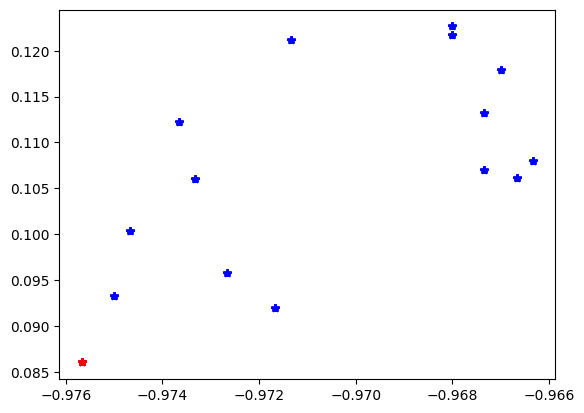

In [ ]:
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")

In [ ]:
ga5 = GeneticAlgorithm(10, train_images, test_images, train_labels, test_labels)
result = ga5.solve(generations=10)
frontier_loss = []
frontier_acc = []
for individual in ga5.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga5.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)

Generation 0


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 10s 53ms/step - loss: 1.2374 - accuracy: 0.6241 - val_loss: 0.5755 - val_accuracy: 0.8236
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 0.4791 - accuracy: 0.8637 - val_loss: 0.4219 - val_accuracy: 0.8814
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.3547 - accuracy: 0.9041 - val_loss: 0.3656 - val_accuracy: 0.8993
Epoch 4/10
88/88 [==============================] - 5s 51ms/step - loss: 0.2995 - accuracy: 0.9171 - val_loss: 0.3228 - val_accuracy: 0.9143
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2481 - accuracy: 0.9316 - val_loss: 0.2848 - val_accuracy: 0.9286
Epoch 6/10
88/88 [==============================] - 2s 26ms/step - loss: 0.2150 - accuracy: 0.9396 - val_loss: 0.3025 - val_accuracy: 0.9164
Epoch 7/10
88/88 [==============================] - 2s 18ms/step - loss: 0.1874 - accuracy: 0.9468 - val_loss: 0.2608 - val_accuracy: 0.9321
Epoch 8/10
8

 10%|█         | 1/10 [00:37<05:39, 37.69s/it]

Epoch 1/10
88/88 [==============================] - 3s 28ms/step - loss: 1.6325 - accuracy: 0.4746 - val_loss: 0.6912 - val_accuracy: 0.8050
Epoch 2/10
88/88 [==============================] - 2s 25ms/step - loss: 0.4502 - accuracy: 0.8670 - val_loss: 0.3515 - val_accuracy: 0.8871
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2752 - accuracy: 0.9204 - val_loss: 0.2334 - val_accuracy: 0.9350
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.2064 - accuracy: 0.9388 - val_loss: 0.2045 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1842 - accuracy: 0.9416 - val_loss: 0.1751 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 2s 25ms/step - loss: 0.1459 - accuracy: 0.9564 - val_loss: 0.1753 - val_accuracy: 0.9436
Epoch 7/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1300 - accuracy: 0.9614 - val_loss: 0.1777 - val_accuracy: 0.9436
Epoch 8/10
88

 20%|██        | 2/10 [01:05<04:17, 32.17s/it]

Epoch 1/10
88/88 [==============================] - 3s 30ms/step - loss: 0.8686 - accuracy: 0.7234 - val_loss: 0.3467 - val_accuracy: 0.9021
Epoch 2/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2900 - accuracy: 0.9132 - val_loss: 0.2688 - val_accuracy: 0.9257
Epoch 3/10
88/88 [==============================] - 2s 25ms/step - loss: 0.2065 - accuracy: 0.9380 - val_loss: 0.2303 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1510 - accuracy: 0.9545 - val_loss: 0.2093 - val_accuracy: 0.9314
Epoch 5/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1145 - accuracy: 0.9655 - val_loss: 0.1823 - val_accuracy: 0.9414
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 0.0874 - accuracy: 0.9757 - val_loss: 0.1870 - val_accuracy: 0.9414
Epoch 7/10
88/88 [==============================] - 2s 28ms/step - loss: 0.0714 - accuracy: 0.9816 - val_loss: 0.1767 - val_accuracy: 0.9471
Epoch 8/10
88

 30%|███       | 3/10 [01:34<03:34, 30.57s/it]

Epoch 1/10
88/88 [==============================] - 2s 20ms/step - loss: 1.0167 - accuracy: 0.7154 - val_loss: 0.4336 - val_accuracy: 0.8714
Epoch 2/10
88/88 [==============================] - 2s 18ms/step - loss: 0.3438 - accuracy: 0.9016 - val_loss: 0.3073 - val_accuracy: 0.9071
Epoch 3/10
88/88 [==============================] - 2s 17ms/step - loss: 0.2678 - accuracy: 0.9230 - val_loss: 0.2705 - val_accuracy: 0.9221
Epoch 4/10
88/88 [==============================] - 2s 17ms/step - loss: 0.2074 - accuracy: 0.9441 - val_loss: 0.2490 - val_accuracy: 0.9243
Epoch 5/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1724 - accuracy: 0.9539 - val_loss: 0.2804 - val_accuracy: 0.9107
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 0.1528 - accuracy: 0.9573 - val_loss: 0.2041 - val_accuracy: 0.9379
Epoch 7/10
88/88 [==============================] - 2s 17ms/step - loss: 0.1340 - accuracy: 0.9625 - val_loss: 0.2039 - val_accuracy: 0.9371
Epoch 8/10
88

 40%|████      | 4/10 [01:54<02:37, 26.21s/it]

Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 1.0052 - accuracy: 0.6850 - val_loss: 0.3674 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 3s 29ms/step - loss: 0.3403 - accuracy: 0.9004 - val_loss: 0.2753 - val_accuracy: 0.9264
Epoch 3/10
88/88 [==============================] - 2s 20ms/step - loss: 0.2027 - accuracy: 0.9409 - val_loss: 0.2112 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 2s 21ms/step - loss: 0.1497 - accuracy: 0.9546 - val_loss: 0.1887 - val_accuracy: 0.9450
Epoch 5/10
88/88 [==============================] - 2s 21ms/step - loss: 0.1116 - accuracy: 0.9689 - val_loss: 0.2047 - val_accuracy: 0.9314
Epoch 6/10
88/88 [==============================] - 2s 20ms/step - loss: 0.0726 - accuracy: 0.9816 - val_loss: 0.1898 - val_accuracy: 0.9429
Epoch 7/10
88/88 [==============================] - 2s 22ms/step - loss: 0.0616 - accuracy: 0.9812 - val_loss: 0.1592 - val_accuracy: 0.9493
Epoch 8/10
88

 50%|█████     | 5/10 [02:19<02:09, 25.93s/it]

Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 1.4135 - accuracy: 0.5263 - val_loss: 0.7489 - val_accuracy: 0.7643
Epoch 2/10
88/88 [==============================] - 5s 59ms/step - loss: 0.5630 - accuracy: 0.8313 - val_loss: 0.3682 - val_accuracy: 0.8879
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.3308 - accuracy: 0.9070 - val_loss: 0.3096 - val_accuracy: 0.8964
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2460 - accuracy: 0.9279 - val_loss: 0.2361 - val_accuracy: 0.9293
Epoch 5/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1860 - accuracy: 0.9448 - val_loss: 0.2277 - val_accuracy: 0.9371
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1646 - accuracy: 0.9513 - val_loss: 0.1766 - val_accuracy: 0.9407
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1304 - accuracy: 0.9616 - val_loss: 0.1639 - val_accuracy: 0.9550
Epoch 8/10
88

 60%|██████    | 6/10 [03:02<02:07, 31.79s/it]

Epoch 1/10
88/88 [==============================] - 10s 106ms/step - loss: 1.8235 - accuracy: 0.2548 - val_loss: 1.5204 - val_accuracy: 0.3571
Epoch 2/10
88/88 [==============================] - 9s 99ms/step - loss: 1.2534 - accuracy: 0.5612 - val_loss: 1.0456 - val_accuracy: 0.6671
Epoch 3/10
88/88 [==============================] - 8s 94ms/step - loss: 0.8314 - accuracy: 0.7854 - val_loss: 0.7498 - val_accuracy: 0.7936
Epoch 4/10
88/88 [==============================] - 10s 108ms/step - loss: 0.5829 - accuracy: 0.8570 - val_loss: 0.5997 - val_accuracy: 0.8321
Epoch 5/10
88/88 [==============================] - 7s 84ms/step - loss: 0.4575 - accuracy: 0.8587 - val_loss: 0.4962 - val_accuracy: 0.8571
Epoch 6/10
88/88 [==============================] - 9s 103ms/step - loss: 0.3703 - accuracy: 0.8734 - val_loss: 0.4600 - val_accuracy: 0.8586
Epoch 7/10
88/88 [==============================] - 9s 105ms/step - loss: 0.3126 - accuracy: 0.8995 - val_loss: 0.4478 - val_accuracy: 0.8850
Epoch 8

 70%|███████   | 7/10 [05:27<03:25, 68.64s/it]

Epoch 1/10
88/88 [==============================] - 6s 54ms/step - loss: 0.9269 - accuracy: 0.7396 - val_loss: 0.2987 - val_accuracy: 0.9086
Epoch 2/10
88/88 [==============================] - 4s 46ms/step - loss: 0.2335 - accuracy: 0.9362 - val_loss: 0.2107 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1502 - accuracy: 0.9550 - val_loss: 0.1413 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1153 - accuracy: 0.9657 - val_loss: 0.1221 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 5s 59ms/step - loss: 0.0896 - accuracy: 0.9741 - val_loss: 0.1187 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0702 - accuracy: 0.9795 - val_loss: 0.1361 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0616 - accuracy: 0.9818 - val_loss: 0.1275 - val_accuracy: 0.9557
Epoch 8/10
88

 80%|████████  | 8/10 [06:08<01:59, 59.96s/it]

Epoch 1/10
88/88 [==============================] - 10s 107ms/step - loss: 0.5359 - accuracy: 0.8429 - val_loss: 0.3135 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 8s 88ms/step - loss: 0.1834 - accuracy: 0.9466 - val_loss: 0.1824 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 9s 97ms/step - loss: 0.1008 - accuracy: 0.9696 - val_loss: 0.1807 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 9s 99ms/step - loss: 0.0648 - accuracy: 0.9823 - val_loss: 0.1488 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 7s 84ms/step - loss: 0.0408 - accuracy: 0.9896 - val_loss: 0.1314 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 9s 106ms/step - loss: 0.0247 - accuracy: 0.9945 - val_loss: 0.1336 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 9s 97ms/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.1403 - val_accuracy: 0.9607
Epoch 8/10

 90%|█████████ | 9/10 [08:32<01:26, 86.27s/it]

Epoch 1/10
88/88 [==============================] - 4s 38ms/step - loss: 0.9896 - accuracy: 0.6959 - val_loss: 0.4037 - val_accuracy: 0.8771
Epoch 2/10
88/88 [==============================] - 3s 35ms/step - loss: 0.3127 - accuracy: 0.9159 - val_loss: 0.3123 - val_accuracy: 0.9000
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2286 - accuracy: 0.9346 - val_loss: 0.2502 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 2s 28ms/step - loss: 0.1802 - accuracy: 0.9496 - val_loss: 0.2584 - val_accuracy: 0.9171
Epoch 5/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1512 - accuracy: 0.9568 - val_loss: 0.2631 - val_accuracy: 0.9171
Epoch 6/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1149 - accuracy: 0.9675 - val_loss: 0.2074 - val_accuracy: 0.9386
Epoch 7/10
88/88 [==============================] - 3s 35ms/step - loss: 0.0873 - accuracy: 0.9745 - val_loss: 0.1665 - val_accuracy: 0.9521
Epoch 8/10
88

100%|██████████| 10/10 [09:02<00:00, 54.21s/it]


Best Solution -> G:0 ->  Eval: 0.964  Gene: [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 261ms/step - loss: 0.6408 - accuracy: 0.8059 - val_loss: 0.1931 - val_accuracy: 0.9436
Epoch 2/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1386 - accuracy: 0.9579 - val_loss: 0.1578 - val_accuracy: 0.9514
Epoch 3/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0946 - accuracy: 0.9734 - val_loss: 0.1730 - val_accuracy: 0.9443
Epoch 4/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0647 - accuracy: 0.9804 - val_loss: 0.1059 - val_accuracy: 0.9743
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0467 - accuracy: 0.9857 - val_loss: 0.1113 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0303 - accuracy: 0.9907 - val_loss: 0.1243 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 21s 236ms/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.1438 - val_accuracy: 0.9579

 10%|█         | 1/10 [04:28<40:13, 268.21s/it]

Epoch 1/10
88/88 [==============================] - 3s 25ms/step - loss: 1.1690 - accuracy: 0.6716 - val_loss: 0.3636 - val_accuracy: 0.8929
Epoch 2/10
88/88 [==============================] - 2s 25ms/step - loss: 0.3137 - accuracy: 0.9114 - val_loss: 0.2600 - val_accuracy: 0.9243
Epoch 3/10
88/88 [==============================] - 2s 23ms/step - loss: 0.2189 - accuracy: 0.9337 - val_loss: 0.2083 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1749 - accuracy: 0.9507 - val_loss: 0.1798 - val_accuracy: 0.9400
Epoch 5/10
88/88 [==============================] - 3s 36ms/step - loss: 0.1468 - accuracy: 0.9591 - val_loss: 0.1448 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1193 - accuracy: 0.9663 - val_loss: 0.1482 - val_accuracy: 0.9507
Epoch 7/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1040 - accuracy: 0.9727 - val_loss: 0.1227 - val_accuracy: 0.9621
Epoch 8/10
88

 20%|██        | 2/10 [05:10<18:04, 135.55s/it]

Epoch 1/10
88/88 [==============================] - 4s 40ms/step - loss: 0.9721 - accuracy: 0.7061 - val_loss: 0.2907 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 5s 58ms/step - loss: 0.2557 - accuracy: 0.9271 - val_loss: 0.2253 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1845 - accuracy: 0.9463 - val_loss: 0.1701 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1291 - accuracy: 0.9639 - val_loss: 0.1562 - val_accuracy: 0.9500
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1048 - accuracy: 0.9689 - val_loss: 0.1678 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 4s 50ms/step - loss: 0.0883 - accuracy: 0.9721 - val_loss: 0.1252 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 3s 37ms/step - loss: 0.0742 - accuracy: 0.9773 - val_loss: 0.1082 - val_accuracy: 0.9686
Epoch 8/10
88

 30%|███       | 3/10 [05:51<10:44, 92.12s/it] 

Epoch 1/10
88/88 [==============================] - 4s 41ms/step - loss: 0.9711 - accuracy: 0.7266 - val_loss: 0.3022 - val_accuracy: 0.9043
Epoch 2/10
88/88 [==============================] - 5s 52ms/step - loss: 0.2292 - accuracy: 0.9380 - val_loss: 0.1916 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1612 - accuracy: 0.9536 - val_loss: 0.1755 - val_accuracy: 0.9386
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1233 - accuracy: 0.9657 - val_loss: 0.1549 - val_accuracy: 0.9507
Epoch 5/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0958 - accuracy: 0.9711 - val_loss: 0.1485 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 5s 58ms/step - loss: 0.0797 - accuracy: 0.9773 - val_loss: 0.1347 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 3s 36ms/step - loss: 0.0649 - accuracy: 0.9816 - val_loss: 0.1275 - val_accuracy: 0.9614
Epoch 8/10
88

 40%|████      | 4/10 [06:33<07:15, 72.57s/it]

Epoch 1/10
88/88 [==============================] - 3s 28ms/step - loss: 1.2566 - accuracy: 0.6227 - val_loss: 0.5035 - val_accuracy: 0.8529
Epoch 2/10
88/88 [==============================] - 2s 26ms/step - loss: 0.4172 - accuracy: 0.8745 - val_loss: 0.3589 - val_accuracy: 0.8929
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2946 - accuracy: 0.9120 - val_loss: 0.2441 - val_accuracy: 0.9243
Epoch 4/10
88/88 [==============================] - 2s 26ms/step - loss: 0.2297 - accuracy: 0.9323 - val_loss: 0.2253 - val_accuracy: 0.9343
Epoch 5/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1856 - accuracy: 0.9454 - val_loss: 0.2468 - val_accuracy: 0.9193
Epoch 6/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1630 - accuracy: 0.9511 - val_loss: 0.2576 - val_accuracy: 0.9136
Epoch 7/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1322 - accuracy: 0.9611 - val_loss: 0.1698 - val_accuracy: 0.9414
Epoch 8/10
88

 50%|█████     | 5/10 [07:16<05:09, 61.80s/it]

Epoch 1/10
88/88 [==============================] - 6s 58ms/step - loss: 1.4515 - accuracy: 0.5204 - val_loss: 0.6277 - val_accuracy: 0.8100
Epoch 2/10
88/88 [==============================] - 3s 37ms/step - loss: 0.4428 - accuracy: 0.8727 - val_loss: 0.3860 - val_accuracy: 0.8807
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.2607 - accuracy: 0.9291 - val_loss: 0.2484 - val_accuracy: 0.9200
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1915 - accuracy: 0.9479 - val_loss: 0.1871 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1518 - accuracy: 0.9561 - val_loss: 0.2073 - val_accuracy: 0.9321
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1213 - accuracy: 0.9627 - val_loss: 0.1575 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1042 - accuracy: 0.9709 - val_loss: 0.1536 - val_accuracy: 0.9521
Epoch 8/10
88

 60%|██████    | 6/10 [07:57<03:38, 54.72s/it]

Epoch 1/10
88/88 [==============================] - 10s 105ms/step - loss: 0.8037 - accuracy: 0.7545 - val_loss: 0.2913 - val_accuracy: 0.9100
Epoch 2/10
88/88 [==============================] - 8s 86ms/step - loss: 0.2315 - accuracy: 0.9330 - val_loss: 0.1908 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 9s 104ms/step - loss: 0.1382 - accuracy: 0.9593 - val_loss: 0.1392 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 9s 106ms/step - loss: 0.1154 - accuracy: 0.9659 - val_loss: 0.1350 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0786 - accuracy: 0.9755 - val_loss: 0.1308 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 9s 107ms/step - loss: 0.0632 - accuracy: 0.9807 - val_loss: 0.1203 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0498 - accuracy: 0.9855 - val_loss: 0.1081 - val_accuracy: 0.9721
Epoch 8/

 70%|███████   | 7/10 [10:22<04:12, 84.12s/it]

Epoch 1/10
88/88 [==============================] - 6s 56ms/step - loss: 1.3299 - accuracy: 0.5929 - val_loss: 0.4698 - val_accuracy: 0.8679
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.3547 - accuracy: 0.8986 - val_loss: 0.2902 - val_accuracy: 0.9107
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.2385 - accuracy: 0.9302 - val_loss: 0.2137 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1927 - accuracy: 0.9434 - val_loss: 0.2084 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 5s 59ms/step - loss: 0.1597 - accuracy: 0.9541 - val_loss: 0.1907 - val_accuracy: 0.9486
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1345 - accuracy: 0.9596 - val_loss: 0.1633 - val_accuracy: 0.9543
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1107 - accuracy: 0.9688 - val_loss: 0.1422 - val_accuracy: 0.9643
Epoch 8/10
88

 80%|████████  | 8/10 [11:04<02:21, 70.94s/it]

Epoch 1/10
88/88 [==============================] - 4s 36ms/step - loss: 0.7100 - accuracy: 0.8050 - val_loss: 0.3113 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 3s 35ms/step - loss: 0.2780 - accuracy: 0.9209 - val_loss: 0.2746 - val_accuracy: 0.9164
Epoch 3/10
88/88 [==============================] - 2s 28ms/step - loss: 0.2141 - accuracy: 0.9339 - val_loss: 0.2334 - val_accuracy: 0.9236
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 0.1515 - accuracy: 0.9550 - val_loss: 0.2039 - val_accuracy: 0.9243
Epoch 5/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1174 - accuracy: 0.9682 - val_loss: 0.1865 - val_accuracy: 0.9379
Epoch 6/10
88/88 [==============================] - 2s 28ms/step - loss: 0.0922 - accuracy: 0.9748 - val_loss: 0.1485 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0695 - accuracy: 0.9814 - val_loss: 0.1584 - val_accuracy: 0.9450
Epoch 8/10
88

 90%|█████████ | 9/10 [11:47<01:02, 62.10s/it]

Epoch 1/10
88/88 [==============================] - 6s 49ms/step - loss: 1.1612 - accuracy: 0.6396 - val_loss: 0.4054 - val_accuracy: 0.8700
Epoch 2/10
88/88 [==============================] - 3s 39ms/step - loss: 0.2937 - accuracy: 0.9114 - val_loss: 0.2598 - val_accuracy: 0.9107
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1829 - accuracy: 0.9489 - val_loss: 0.2077 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1421 - accuracy: 0.9575 - val_loss: 0.1511 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1062 - accuracy: 0.9673 - val_loss: 0.1472 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0884 - accuracy: 0.9746 - val_loss: 0.1533 - val_accuracy: 0.9521
Epoch 7/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0741 - accuracy: 0.9800 - val_loss: 0.1272 - val_accuracy: 0.9643
Epoch 8/10
88

100%|██████████| 10/10 [12:28<00:00, 74.81s/it]


Best Solution -> G:1 ->  Eval: 0.971  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 2


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 254ms/step - loss: 0.6622 - accuracy: 0.8037 - val_loss: 0.2113 - val_accuracy: 0.9293
Epoch 2/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1730 - accuracy: 0.9516 - val_loss: 0.1551 - val_accuracy: 0.9521
Epoch 3/10
88/88 [==============================] - 22s 246ms/step - loss: 0.1046 - accuracy: 0.9666 - val_loss: 0.1180 - val_accuracy: 0.9657
Epoch 4/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0697 - accuracy: 0.9787 - val_loss: 0.1155 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0498 - accuracy: 0.9834 - val_loss: 0.1397 - val_accuracy: 0.9550
Epoch 6/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0446 - accuracy: 0.9843 - val_loss: 0.1485 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0289 - accuracy: 0.9914 - val_loss: 0.0936 - val_accuracy: 0.9764

 10%|█         | 1/10 [03:42<33:21, 222.40s/it]

Epoch 1/10
88/88 [==============================] - 5s 47ms/step - loss: 0.9194 - accuracy: 0.7218 - val_loss: 0.3044 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 5s 52ms/step - loss: 0.2627 - accuracy: 0.9209 - val_loss: 0.2224 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1809 - accuracy: 0.9446 - val_loss: 0.1707 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1235 - accuracy: 0.9638 - val_loss: 0.1441 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0963 - accuracy: 0.9709 - val_loss: 0.1454 - val_accuracy: 0.9550
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0803 - accuracy: 0.9755 - val_loss: 0.1219 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0573 - accuracy: 0.9832 - val_loss: 0.1205 - val_accuracy: 0.9643
Epoch 8/10
88

 20%|██        | 2/10 [04:25<15:33, 116.68s/it]

Epoch 1/10
88/88 [==============================] - 6s 52ms/step - loss: 1.0309 - accuracy: 0.6905 - val_loss: 0.4128 - val_accuracy: 0.8636
Epoch 2/10
88/88 [==============================] - 4s 48ms/step - loss: 0.2884 - accuracy: 0.9157 - val_loss: 0.2137 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1815 - accuracy: 0.9471 - val_loss: 0.1732 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1384 - accuracy: 0.9580 - val_loss: 0.1404 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1203 - accuracy: 0.9636 - val_loss: 0.1604 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0951 - accuracy: 0.9711 - val_loss: 0.1323 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0708 - accuracy: 0.9784 - val_loss: 0.1224 - val_accuracy: 0.9643
Epoch 8/10
88

 30%|███       | 3/10 [05:07<09:39, 82.79s/it] 

Epoch 1/10
88/88 [==============================] - 6s 55ms/step - loss: 1.0686 - accuracy: 0.6346 - val_loss: 0.3650 - val_accuracy: 0.8829
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2616 - accuracy: 0.9259 - val_loss: 0.2210 - val_accuracy: 0.9357
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1744 - accuracy: 0.9473 - val_loss: 0.1752 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1264 - accuracy: 0.9650 - val_loss: 0.1406 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 5s 57ms/step - loss: 0.0945 - accuracy: 0.9727 - val_loss: 0.1618 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0884 - accuracy: 0.9739 - val_loss: 0.1413 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 3s 40ms/step - loss: 0.0704 - accuracy: 0.9782 - val_loss: 0.1300 - val_accuracy: 0.9614
Epoch 8/10
88

 40%|████      | 4/10 [05:48<06:37, 66.27s/it]

Epoch 1/10
88/88 [==============================] - 5s 46ms/step - loss: 1.0871 - accuracy: 0.6848 - val_loss: 0.3296 - val_accuracy: 0.9071
Epoch 2/10
88/88 [==============================] - 5s 52ms/step - loss: 0.2652 - accuracy: 0.9287 - val_loss: 0.2346 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1848 - accuracy: 0.9461 - val_loss: 0.1756 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.1440 - accuracy: 0.9588 - val_loss: 0.1668 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1162 - accuracy: 0.9668 - val_loss: 0.1762 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0954 - accuracy: 0.9725 - val_loss: 0.1424 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0819 - accuracy: 0.9745 - val_loss: 0.1530 - val_accuracy: 0.9579
Epoch 8/10
88

 50%|█████     | 5/10 [06:31<04:48, 57.74s/it]

Epoch 1/10
88/88 [==============================] - 10s 104ms/step - loss: 0.5929 - accuracy: 0.8243 - val_loss: 0.3413 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 7s 84ms/step - loss: 0.2115 - accuracy: 0.9379 - val_loss: 0.1914 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 9s 99ms/step - loss: 0.1245 - accuracy: 0.9659 - val_loss: 0.1670 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 9s 101ms/step - loss: 0.0840 - accuracy: 0.9746 - val_loss: 0.1546 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 7s 84ms/step - loss: 0.0553 - accuracy: 0.9839 - val_loss: 0.1404 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 9s 103ms/step - loss: 0.0366 - accuracy: 0.9921 - val_loss: 0.1641 - val_accuracy: 0.9486
Epoch 7/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0243 - accuracy: 0.9952 - val_loss: 0.1404 - val_accuracy: 0.9607
Epoch 8/1

 60%|██████    | 6/10 [08:55<05:48, 87.14s/it]

Epoch 1/10
88/88 [==============================] - 24s 260ms/step - loss: 0.6777 - accuracy: 0.7962 - val_loss: 0.1964 - val_accuracy: 0.9407
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1504 - accuracy: 0.9577 - val_loss: 0.1346 - val_accuracy: 0.9621
Epoch 3/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0955 - accuracy: 0.9721 - val_loss: 0.1407 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0658 - accuracy: 0.9805 - val_loss: 0.1279 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0485 - accuracy: 0.9857 - val_loss: 0.1142 - val_accuracy: 0.9707
Epoch 6/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0411 - accuracy: 0.9868 - val_loss: 0.1177 - val_accuracy: 0.9729
Epoch 7/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.1123 - val_accuracy: 0.9657

 70%|███████   | 7/10 [13:23<07:18, 146.30s/it]

Epoch 1/10
88/88 [==============================] - 9s 91ms/step - loss: 0.5761 - accuracy: 0.8238 - val_loss: 0.3273 - val_accuracy: 0.8971
Epoch 2/10
88/88 [==============================] - 9s 105ms/step - loss: 0.1929 - accuracy: 0.9454 - val_loss: 0.1978 - val_accuracy: 0.9386
Epoch 3/10
88/88 [==============================] - 9s 100ms/step - loss: 0.1068 - accuracy: 0.9700 - val_loss: 0.1511 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0774 - accuracy: 0.9782 - val_loss: 0.1775 - val_accuracy: 0.9379
Epoch 5/10
88/88 [==============================] - 9s 104ms/step - loss: 0.0507 - accuracy: 0.9864 - val_loss: 0.1366 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 8s 86ms/step - loss: 0.0297 - accuracy: 0.9932 - val_loss: 0.1461 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 9s 101ms/step - loss: 0.0180 - accuracy: 0.9955 - val_loss: 0.1330 - val_accuracy: 0.9636
Epoch 8/1

 80%|████████  | 8/10 [15:47<04:51, 145.62s/it]

Epoch 1/10
88/88 [==============================] - 24s 268ms/step - loss: 0.6536 - accuracy: 0.8118 - val_loss: 0.1862 - val_accuracy: 0.9471
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.1514 - accuracy: 0.9600 - val_loss: 0.1748 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0979 - accuracy: 0.9707 - val_loss: 0.1297 - val_accuracy: 0.9621
Epoch 4/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0662 - accuracy: 0.9795 - val_loss: 0.1026 - val_accuracy: 0.9686
Epoch 5/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0509 - accuracy: 0.9827 - val_loss: 0.0956 - val_accuracy: 0.9736
Epoch 6/10
88/88 [==============================] - 20s 233ms/step - loss: 0.0340 - accuracy: 0.9904 - val_loss: 0.1100 - val_accuracy: 0.9743
Epoch 7/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.1078 - val_accuracy: 0.9721

 90%|█████████ | 9/10 [19:27<02:48, 168.88s/it]

Epoch 1/10
88/88 [==============================] - 23s 244ms/step - loss: 0.6100 - accuracy: 0.8196 - val_loss: 0.2059 - val_accuracy: 0.9393
Epoch 2/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1592 - accuracy: 0.9513 - val_loss: 0.1753 - val_accuracy: 0.9457
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1063 - accuracy: 0.9702 - val_loss: 0.1120 - val_accuracy: 0.9700
Epoch 4/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0658 - accuracy: 0.9800 - val_loss: 0.0983 - val_accuracy: 0.9736
Epoch 5/10
88/88 [==============================] - 20s 232ms/step - loss: 0.0452 - accuracy: 0.9859 - val_loss: 0.1402 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.1167 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0262 - accuracy: 0.9912 - val_loss: 0.1037 - val_accuracy: 0.9729

100%|██████████| 10/10 [23:56<00:00, 143.63s/it]


Best Solution -> G:1 ->  Eval: 0.971  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 3


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 1.1111 - accuracy: 0.6289 - val_loss: 0.4301 - val_accuracy: 0.8693
Epoch 2/10
88/88 [==============================] - 5s 61ms/step - loss: 0.3330 - accuracy: 0.9013 - val_loss: 0.2570 - val_accuracy: 0.9150
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2129 - accuracy: 0.9375 - val_loss: 0.2768 - val_accuracy: 0.9229
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1644 - accuracy: 0.9539 - val_loss: 0.1943 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1410 - accuracy: 0.9580 - val_loss: 0.2015 - val_accuracy: 0.9421
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1143 - accuracy: 0.9659 - val_loss: 0.2019 - val_accuracy: 0.9386
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0909 - accuracy: 0.9732 - val_loss: 0.1461 - val_accuracy: 0.9607
Epoch 8/10
88

 10%|█         | 1/10 [00:42<06:26, 42.89s/it]

Epoch 1/10
88/88 [==============================] - 5s 49ms/step - loss: 0.9863 - accuracy: 0.7141 - val_loss: 0.3568 - val_accuracy: 0.8943
Epoch 2/10
88/88 [==============================] - 5s 53ms/step - loss: 0.3107 - accuracy: 0.9084 - val_loss: 0.2703 - val_accuracy: 0.9164
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.2030 - accuracy: 0.9413 - val_loss: 0.1827 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1536 - accuracy: 0.9550 - val_loss: 0.1463 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1210 - accuracy: 0.9621 - val_loss: 0.1303 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1033 - accuracy: 0.9686 - val_loss: 0.1251 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0840 - accuracy: 0.9759 - val_loss: 0.1187 - val_accuracy: 0.9629
Epoch 8/10
88

 20%|██        | 2/10 [01:25<05:40, 42.57s/it]

Epoch 1/10
88/88 [==============================] - 5s 47ms/step - loss: 1.0224 - accuracy: 0.6857 - val_loss: 0.3170 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 4s 49ms/step - loss: 0.2586 - accuracy: 0.9261 - val_loss: 0.2119 - val_accuracy: 0.9364
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1659 - accuracy: 0.9521 - val_loss: 0.1641 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1177 - accuracy: 0.9657 - val_loss: 0.1479 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0997 - accuracy: 0.9720 - val_loss: 0.2105 - val_accuracy: 0.9321
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0808 - accuracy: 0.9761 - val_loss: 0.1555 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0688 - accuracy: 0.9791 - val_loss: 0.1361 - val_accuracy: 0.9614
Epoch 8/10
88

 30%|███       | 3/10 [02:07<04:58, 42.61s/it]

Epoch 1/10
88/88 [==============================] - 6s 58ms/step - loss: 0.9659 - accuracy: 0.7159 - val_loss: 0.3104 - val_accuracy: 0.9064
Epoch 2/10
88/88 [==============================] - 3s 39ms/step - loss: 0.2576 - accuracy: 0.9221 - val_loss: 0.2255 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1782 - accuracy: 0.9504 - val_loss: 0.2107 - val_accuracy: 0.9336
Epoch 4/10
88/88 [==============================] - 3s 40ms/step - loss: 0.1336 - accuracy: 0.9605 - val_loss: 0.1494 - val_accuracy: 0.9536
Epoch 5/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1009 - accuracy: 0.9705 - val_loss: 0.1594 - val_accuracy: 0.9507
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0816 - accuracy: 0.9771 - val_loss: 0.1185 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0624 - accuracy: 0.9832 - val_loss: 0.1387 - val_accuracy: 0.9579
Epoch 8/10
88

 40%|████      | 4/10 [02:49<04:14, 42.39s/it]

Epoch 1/10
88/88 [==============================] - 24s 258ms/step - loss: 0.6655 - accuracy: 0.7923 - val_loss: 0.2190 - val_accuracy: 0.9321
Epoch 2/10
88/88 [==============================] - 21s 239ms/step - loss: 0.1458 - accuracy: 0.9579 - val_loss: 0.1276 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0909 - accuracy: 0.9732 - val_loss: 0.1389 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0685 - accuracy: 0.9804 - val_loss: 0.1225 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 22s 252ms/step - loss: 0.0410 - accuracy: 0.9887 - val_loss: 0.1123 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 23s 256ms/step - loss: 0.0360 - accuracy: 0.9902 - val_loss: 0.1100 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.1053 - val_accuracy: 0.9750

 50%|█████     | 5/10 [07:15<10:14, 122.94s/it]

Epoch 1/10
88/88 [==============================] - 23s 247ms/step - loss: 0.6709 - accuracy: 0.7929 - val_loss: 0.1949 - val_accuracy: 0.9364
Epoch 2/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1617 - accuracy: 0.9518 - val_loss: 0.1999 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 20s 231ms/step - loss: 0.1011 - accuracy: 0.9705 - val_loss: 0.1171 - val_accuracy: 0.9643
Epoch 4/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0653 - accuracy: 0.9802 - val_loss: 0.1600 - val_accuracy: 0.9493
Epoch 5/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0497 - accuracy: 0.9859 - val_loss: 0.1034 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.1297 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 21s 233ms/step - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.1135 - val_accuracy: 0.9664

 60%|██████    | 6/10 [11:42<11:27, 171.80s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 1.1128 - accuracy: 0.6605 - val_loss: 0.3874 - val_accuracy: 0.8814
Epoch 2/10
88/88 [==============================] - 4s 40ms/step - loss: 0.3084 - accuracy: 0.9141 - val_loss: 0.2863 - val_accuracy: 0.9071
Epoch 3/10
88/88 [==============================] - 5s 59ms/step - loss: 0.2035 - accuracy: 0.9434 - val_loss: 0.2239 - val_accuracy: 0.9229
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1514 - accuracy: 0.9600 - val_loss: 0.1896 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.1214 - accuracy: 0.9657 - val_loss: 0.1488 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0955 - accuracy: 0.9727 - val_loss: 0.1451 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0820 - accuracy: 0.9757 - val_loss: 0.1371 - val_accuracy: 0.9600
Epoch 8/10
88

 70%|███████   | 7/10 [12:24<06:28, 129.56s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 0.9979 - accuracy: 0.7030 - val_loss: 0.3580 - val_accuracy: 0.8843
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2794 - accuracy: 0.9152 - val_loss: 0.2063 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 5s 54ms/step - loss: 0.1762 - accuracy: 0.9496 - val_loss: 0.1766 - val_accuracy: 0.9450
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1382 - accuracy: 0.9595 - val_loss: 0.1665 - val_accuracy: 0.9471
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1081 - accuracy: 0.9661 - val_loss: 0.1464 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 5s 58ms/step - loss: 0.0846 - accuracy: 0.9754 - val_loss: 0.1155 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0706 - accuracy: 0.9786 - val_loss: 0.1229 - val_accuracy: 0.9693
Epoch 8/10
88

 80%|████████  | 8/10 [13:07<03:23, 101.79s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 0.9743 - accuracy: 0.7030 - val_loss: 0.3160 - val_accuracy: 0.9050
Epoch 2/10
88/88 [==============================] - 5s 52ms/step - loss: 0.2605 - accuracy: 0.9239 - val_loss: 0.2402 - val_accuracy: 0.9221
Epoch 3/10
88/88 [==============================] - 5s 51ms/step - loss: 0.1651 - accuracy: 0.9495 - val_loss: 0.2089 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1308 - accuracy: 0.9614 - val_loss: 0.1809 - val_accuracy: 0.9386
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1048 - accuracy: 0.9668 - val_loss: 0.1231 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 5s 61ms/step - loss: 0.0798 - accuracy: 0.9761 - val_loss: 0.1356 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0720 - accuracy: 0.9782 - val_loss: 0.1338 - val_accuracy: 0.9564
Epoch 8/10
88

 90%|█████████ | 9/10 [13:51<01:23, 83.86s/it] 

Epoch 1/10
88/88 [==============================] - 24s 259ms/step - loss: 1.0678 - accuracy: 0.6448 - val_loss: 0.4694 - val_accuracy: 0.8729
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.3121 - accuracy: 0.9196 - val_loss: 0.2310 - val_accuracy: 0.9364
Epoch 3/10
88/88 [==============================] - 22s 253ms/step - loss: 0.1794 - accuracy: 0.9521 - val_loss: 0.2538 - val_accuracy: 0.9250
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.1320 - accuracy: 0.9629 - val_loss: 0.1755 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0959 - accuracy: 0.9730 - val_loss: 0.1374 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0781 - accuracy: 0.9777 - val_loss: 0.1252 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0531 - accuracy: 0.9843 - val_loss: 0.1331 - val_accuracy: 0.9643

100%|██████████| 10/10 [18:17<00:00, 109.73s/it]


Best Solution -> G:1 ->  Eval: 0.971  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 4


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 24s 255ms/step - loss: 0.6565 - accuracy: 0.8018 - val_loss: 0.2537 - val_accuracy: 0.9236
Epoch 2/10
88/88 [==============================] - 25s 284ms/step - loss: 0.1548 - accuracy: 0.9563 - val_loss: 0.1605 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0995 - accuracy: 0.9702 - val_loss: 0.1672 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0672 - accuracy: 0.9812 - val_loss: 0.1261 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0428 - accuracy: 0.9868 - val_loss: 0.1317 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0351 - accuracy: 0.9884 - val_loss: 0.1108 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.1072 - val_accuracy: 0.9707

 10%|█         | 1/10 [04:27<40:04, 267.11s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 1.0604 - accuracy: 0.6909 - val_loss: 0.4130 - val_accuracy: 0.8743
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2975 - accuracy: 0.9148 - val_loss: 0.2626 - val_accuracy: 0.9164
Epoch 3/10
88/88 [==============================] - 5s 60ms/step - loss: 0.2033 - accuracy: 0.9393 - val_loss: 0.1625 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1594 - accuracy: 0.9545 - val_loss: 0.1926 - val_accuracy: 0.9436
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1227 - accuracy: 0.9625 - val_loss: 0.1239 - val_accuracy: 0.9600
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0954 - accuracy: 0.9721 - val_loss: 0.1405 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0798 - accuracy: 0.9748 - val_loss: 0.1729 - val_accuracy: 0.9457
Epoch 8/10
88

 20%|██        | 2/10 [05:51<21:15, 159.47s/it]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.5946 - accuracy: 0.8179 - val_loss: 0.2185 - val_accuracy: 0.9264
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1449 - accuracy: 0.9557 - val_loss: 0.1335 - val_accuracy: 0.9564
Epoch 3/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0875 - accuracy: 0.9743 - val_loss: 0.1113 - val_accuracy: 0.9607
Epoch 4/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0655 - accuracy: 0.9779 - val_loss: 0.0940 - val_accuracy: 0.9707
Epoch 5/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0432 - accuracy: 0.9882 - val_loss: 0.0950 - val_accuracy: 0.9757
Epoch 6/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0285 - accuracy: 0.9920 - val_loss: 0.0945 - val_accuracy: 0.9736
Epoch 7/10
88/88 [==============================] - 22s 244ms/step - loss: 0.0200 - accuracy: 0.9945 - val_loss: 0.0927 - val_accuracy: 0.9693

 30%|███       | 3/10 [09:38<22:13, 190.54s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 1.5990 - accuracy: 0.4737 - val_loss: 0.6269 - val_accuracy: 0.8193
Epoch 2/10
88/88 [==============================] - 5s 61ms/step - loss: 0.4262 - accuracy: 0.8789 - val_loss: 0.3124 - val_accuracy: 0.9043
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2576 - accuracy: 0.9282 - val_loss: 0.2635 - val_accuracy: 0.9200
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2054 - accuracy: 0.9434 - val_loss: 0.2222 - val_accuracy: 0.9271
Epoch 5/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1696 - accuracy: 0.9502 - val_loss: 0.2358 - val_accuracy: 0.9314
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1429 - accuracy: 0.9577 - val_loss: 0.2469 - val_accuracy: 0.9243
Epoch 7/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1380 - accuracy: 0.9607 - val_loss: 0.1814 - val_accuracy: 0.9371
Epoch 8/10
88

 40%|████      | 4/10 [10:22<13:16, 132.74s/it]

Epoch 1/10
88/88 [==============================] - 7s 63ms/step - loss: 1.0071 - accuracy: 0.7111 - val_loss: 0.3169 - val_accuracy: 0.9114
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2412 - accuracy: 0.9284 - val_loss: 0.1861 - val_accuracy: 0.9457
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1570 - accuracy: 0.9557 - val_loss: 0.1673 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1266 - accuracy: 0.9627 - val_loss: 0.1393 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0995 - accuracy: 0.9695 - val_loss: 0.1352 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0827 - accuracy: 0.9741 - val_loss: 0.1251 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0698 - accuracy: 0.9779 - val_loss: 0.1216 - val_accuracy: 0.9664
Epoch 8/10
88

 50%|█████     | 5/10 [11:06<08:22, 100.55s/it]

Epoch 1/10
88/88 [==============================] - 26s 279ms/step - loss: 1.5960 - accuracy: 0.4432 - val_loss: 0.6931 - val_accuracy: 0.7929
Epoch 2/10
88/88 [==============================] - 24s 276ms/step - loss: 0.4208 - accuracy: 0.8729 - val_loss: 0.2858 - val_accuracy: 0.9207
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.2144 - accuracy: 0.9439 - val_loss: 0.2154 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 24s 273ms/step - loss: 0.1367 - accuracy: 0.9630 - val_loss: 0.1723 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 24s 277ms/step - loss: 0.1010 - accuracy: 0.9734 - val_loss: 0.1981 - val_accuracy: 0.9471
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0848 - accuracy: 0.9752 - val_loss: 0.1453 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0690 - accuracy: 0.9777 - val_loss: 0.1311 - val_accuracy: 0.9657

 60%|██████    | 6/10 [15:32<10:27, 156.94s/it]

Epoch 1/10
88/88 [==============================] - 6s 51ms/step - loss: 0.8943 - accuracy: 0.7430 - val_loss: 0.3165 - val_accuracy: 0.9000
Epoch 2/10
88/88 [==============================] - 3s 40ms/step - loss: 0.2473 - accuracy: 0.9271 - val_loss: 0.2454 - val_accuracy: 0.9150
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1733 - accuracy: 0.9504 - val_loss: 0.1939 - val_accuracy: 0.9293
Epoch 4/10
88/88 [==============================] - 5s 60ms/step - loss: 0.1340 - accuracy: 0.9604 - val_loss: 0.1383 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1051 - accuracy: 0.9677 - val_loss: 0.1419 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0864 - accuracy: 0.9748 - val_loss: 0.1275 - val_accuracy: 0.9557
Epoch 7/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0715 - accuracy: 0.9787 - val_loss: 0.1330 - val_accuracy: 0.9614
Epoch 8/10
88

 70%|███████   | 7/10 [16:14<05:58, 119.36s/it]

Epoch 1/10
88/88 [==============================] - 25s 267ms/step - loss: 0.7043 - accuracy: 0.7795 - val_loss: 0.2099 - val_accuracy: 0.9314
Epoch 2/10
88/88 [==============================] - 24s 276ms/step - loss: 0.1583 - accuracy: 0.9516 - val_loss: 0.1485 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 24s 274ms/step - loss: 0.0978 - accuracy: 0.9727 - val_loss: 0.1481 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0658 - accuracy: 0.9791 - val_loss: 0.1002 - val_accuracy: 0.9750
Epoch 5/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0453 - accuracy: 0.9846 - val_loss: 0.1549 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 24s 278ms/step - loss: 0.0339 - accuracy: 0.9891 - val_loss: 0.1810 - val_accuracy: 0.9443
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0294 - accuracy: 0.9916 - val_loss: 0.1294 - val_accuracy: 0.9679

 80%|████████  | 8/10 [20:42<05:33, 166.53s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 1.0782 - accuracy: 0.6723 - val_loss: 0.3801 - val_accuracy: 0.8864
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.3202 - accuracy: 0.8993 - val_loss: 0.2634 - val_accuracy: 0.9171
Epoch 3/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2043 - accuracy: 0.9398 - val_loss: 0.2106 - val_accuracy: 0.9357
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1480 - accuracy: 0.9552 - val_loss: 0.1733 - val_accuracy: 0.9429
Epoch 5/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1202 - accuracy: 0.9646 - val_loss: 0.1943 - val_accuracy: 0.9343
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1015 - accuracy: 0.9707 - val_loss: 0.1290 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 5s 57ms/step - loss: 0.0935 - accuracy: 0.9734 - val_loss: 0.1393 - val_accuracy: 0.9500
Epoch 8/10
88

 90%|█████████ | 9/10 [22:06<02:20, 140.75s/it]

Epoch 1/10
88/88 [==============================] - 23s 255ms/step - loss: 0.6608 - accuracy: 0.8027 - val_loss: 0.2040 - val_accuracy: 0.9379
Epoch 2/10
88/88 [==============================] - 21s 237ms/step - loss: 0.1451 - accuracy: 0.9602 - val_loss: 0.1836 - val_accuracy: 0.9486
Epoch 3/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0905 - accuracy: 0.9741 - val_loss: 0.1173 - val_accuracy: 0.9743
Epoch 4/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0691 - accuracy: 0.9791 - val_loss: 0.1453 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0488 - accuracy: 0.9846 - val_loss: 0.1266 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0338 - accuracy: 0.9895 - val_loss: 0.1326 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0205 - accuracy: 0.9945 - val_loss: 0.1062 - val_accuracy: 0.9757

100%|██████████| 10/10 [26:31<00:00, 159.19s/it]


Best Solution -> G:2 ->  Eval: 0.975  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 6s 59ms/step - loss: 0.9369 - accuracy: 0.7321 - val_loss: 0.3308 - val_accuracy: 0.9000
Epoch 2/10
88/88 [==============================] - 3s 39ms/step - loss: 0.2586 - accuracy: 0.9280 - val_loss: 0.1798 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1646 - accuracy: 0.9543 - val_loss: 0.1638 - val_accuracy: 0.9479
Epoch 4/10
88/88 [==============================] - 5s 56ms/step - loss: 0.1277 - accuracy: 0.9625 - val_loss: 0.1457 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0920 - accuracy: 0.9739 - val_loss: 0.1312 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0759 - accuracy: 0.9784 - val_loss: 0.1440 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0616 - accuracy: 0.9812 - val_loss: 0.1269 - val_accuracy: 0.9650
Epoch 8/10
88

 10%|█         | 1/10 [00:41<06:17, 41.93s/it]

Epoch 1/10
88/88 [==============================] - 6s 61ms/step - loss: 0.9376 - accuracy: 0.7336 - val_loss: 0.3034 - val_accuracy: 0.9150
Epoch 2/10
88/88 [==============================] - 3s 39ms/step - loss: 0.2651 - accuracy: 0.9221 - val_loss: 0.2207 - val_accuracy: 0.9271
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1643 - accuracy: 0.9538 - val_loss: 0.1805 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 5s 52ms/step - loss: 0.1231 - accuracy: 0.9664 - val_loss: 0.1597 - val_accuracy: 0.9479
Epoch 5/10
88/88 [==============================] - 4s 47ms/step - loss: 0.0992 - accuracy: 0.9721 - val_loss: 0.1355 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0824 - accuracy: 0.9764 - val_loss: 0.1293 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0658 - accuracy: 0.9805 - val_loss: 0.1195 - val_accuracy: 0.9657
Epoch 8/10
88

 20%|██        | 2/10 [01:24<05:38, 42.36s/it]

Epoch 1/10
88/88 [==============================] - 25s 274ms/step - loss: 0.6714 - accuracy: 0.7923 - val_loss: 0.2173 - val_accuracy: 0.9421
Epoch 2/10
88/88 [==============================] - 24s 276ms/step - loss: 0.1525 - accuracy: 0.9536 - val_loss: 0.1462 - val_accuracy: 0.9614
Epoch 3/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1036 - accuracy: 0.9693 - val_loss: 0.1533 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0686 - accuracy: 0.9789 - val_loss: 0.1070 - val_accuracy: 0.9686
Epoch 5/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0477 - accuracy: 0.9857 - val_loss: 0.1111 - val_accuracy: 0.9671
Epoch 6/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0369 - accuracy: 0.9887 - val_loss: 0.1113 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 24s 272ms/step - loss: 0.0261 - accuracy: 0.9912 - val_loss: 0.0947 - val_accuracy: 0.9764

 30%|███       | 3/10 [05:53<16:59, 145.62s/it]

Epoch 1/10
88/88 [==============================] - 9s 88ms/step - loss: 0.7968 - accuracy: 0.7741 - val_loss: 0.2767 - val_accuracy: 0.9207
Epoch 2/10
88/88 [==============================] - 9s 102ms/step - loss: 0.2177 - accuracy: 0.9380 - val_loss: 0.1830 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 8s 96ms/step - loss: 0.1336 - accuracy: 0.9643 - val_loss: 0.1568 - val_accuracy: 0.9500
Epoch 4/10
88/88 [==============================] - 8s 93ms/step - loss: 0.0963 - accuracy: 0.9714 - val_loss: 0.1471 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 9s 105ms/step - loss: 0.0697 - accuracy: 0.9807 - val_loss: 0.1283 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 7s 85ms/step - loss: 0.0510 - accuracy: 0.9852 - val_loss: 0.1448 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 9s 104ms/step - loss: 0.0397 - accuracy: 0.9904 - val_loss: 0.1092 - val_accuracy: 0.9643
Epoch 8/10

 40%|████      | 4/10 [07:20<12:15, 122.58s/it]

Epoch 1/10
88/88 [==============================] - 22s 240ms/step - loss: 0.8089 - accuracy: 0.7475 - val_loss: 0.2309 - val_accuracy: 0.9314
Epoch 2/10
88/88 [==============================] - 22s 247ms/step - loss: 0.1922 - accuracy: 0.9457 - val_loss: 0.1905 - val_accuracy: 0.9486
Epoch 3/10
88/88 [==============================] - 22s 250ms/step - loss: 0.1317 - accuracy: 0.9618 - val_loss: 0.1346 - val_accuracy: 0.9600
Epoch 4/10
88/88 [==============================] - 21s 238ms/step - loss: 0.0926 - accuracy: 0.9734 - val_loss: 0.1189 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0682 - accuracy: 0.9804 - val_loss: 0.1312 - val_accuracy: 0.9629
Epoch 6/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0464 - accuracy: 0.9854 - val_loss: 0.1197 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0348 - accuracy: 0.9905 - val_loss: 0.1199 - val_accuracy: 0.9657

 50%|█████     | 5/10 [11:45<14:30, 174.13s/it]

Epoch 1/10
88/88 [==============================] - 24s 265ms/step - loss: 0.7054 - accuracy: 0.7800 - val_loss: 0.2284 - val_accuracy: 0.9286
Epoch 2/10
88/88 [==============================] - 22s 256ms/step - loss: 0.1535 - accuracy: 0.9563 - val_loss: 0.1619 - val_accuracy: 0.9521
Epoch 3/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0997 - accuracy: 0.9686 - val_loss: 0.1501 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0765 - accuracy: 0.9779 - val_loss: 0.1169 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0511 - accuracy: 0.9862 - val_loss: 0.1030 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0385 - accuracy: 0.9905 - val_loss: 0.1457 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0269 - accuracy: 0.9909 - val_loss: 0.1089 - val_accuracy: 0.9707

 60%|██████    | 6/10 [16:14<13:44, 206.15s/it]

Epoch 1/10
88/88 [==============================] - 23s 245ms/step - loss: 0.7710 - accuracy: 0.7477 - val_loss: 0.2497 - val_accuracy: 0.9186
Epoch 2/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1909 - accuracy: 0.9434 - val_loss: 0.1777 - val_accuracy: 0.9493
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.1194 - accuracy: 0.9621 - val_loss: 0.1316 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0802 - accuracy: 0.9745 - val_loss: 0.1877 - val_accuracy: 0.9436
Epoch 5/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0603 - accuracy: 0.9816 - val_loss: 0.1658 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0467 - accuracy: 0.9859 - val_loss: 0.1606 - val_accuracy: 0.9507
Epoch 7/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0396 - accuracy: 0.9870 - val_loss: 0.1428 - val_accuracy: 0.9657

 70%|███████   | 7/10 [20:00<10:38, 212.84s/it]

Epoch 1/10
88/88 [==============================] - 26s 280ms/step - loss: 0.8207 - accuracy: 0.7379 - val_loss: 0.2502 - val_accuracy: 0.9214
Epoch 2/10
88/88 [==============================] - 23s 264ms/step - loss: 0.1845 - accuracy: 0.9432 - val_loss: 0.1482 - val_accuracy: 0.9529
Epoch 3/10
88/88 [==============================] - 25s 279ms/step - loss: 0.1222 - accuracy: 0.9655 - val_loss: 0.1088 - val_accuracy: 0.9664
Epoch 4/10
88/88 [==============================] - 25s 279ms/step - loss: 0.0780 - accuracy: 0.9787 - val_loss: 0.1156 - val_accuracy: 0.9600
Epoch 5/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0626 - accuracy: 0.9784 - val_loss: 0.1319 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 25s 280ms/step - loss: 0.0473 - accuracy: 0.9864 - val_loss: 0.1395 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 25s 279ms/step - loss: 0.0396 - accuracy: 0.9879 - val_loss: 0.0980 - val_accuracy: 0.9707

 80%|████████  | 8/10 [24:29<07:41, 230.51s/it]

Epoch 1/10
88/88 [==============================] - 3s 31ms/step - loss: 0.8157 - accuracy: 0.7680 - val_loss: 0.3281 - val_accuracy: 0.8950
Epoch 2/10
88/88 [==============================] - 3s 29ms/step - loss: 0.2761 - accuracy: 0.9239 - val_loss: 0.2737 - val_accuracy: 0.9164
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1965 - accuracy: 0.9438 - val_loss: 0.2062 - val_accuracy: 0.9364
Epoch 4/10
88/88 [==============================] - 3s 29ms/step - loss: 0.1446 - accuracy: 0.9582 - val_loss: 0.1797 - val_accuracy: 0.9421
Epoch 5/10
88/88 [==============================] - 2s 26ms/step - loss: 0.1074 - accuracy: 0.9700 - val_loss: 0.1590 - val_accuracy: 0.9450
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 0.0855 - accuracy: 0.9766 - val_loss: 0.1672 - val_accuracy: 0.9429
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 0.0695 - accuracy: 0.9809 - val_loss: 0.1457 - val_accuracy: 0.9514
Epoch 8/10
88

 90%|█████████ | 9/10 [25:11<02:51, 171.71s/it]

Epoch 1/10
88/88 [==============================] - 5s 51ms/step - loss: 0.9355 - accuracy: 0.7261 - val_loss: 0.3247 - val_accuracy: 0.9036
Epoch 2/10
88/88 [==============================] - 5s 53ms/step - loss: 0.2615 - accuracy: 0.9250 - val_loss: 0.1928 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1812 - accuracy: 0.9495 - val_loss: 0.1674 - val_accuracy: 0.9529
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1305 - accuracy: 0.9629 - val_loss: 0.1364 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1048 - accuracy: 0.9702 - val_loss: 0.1233 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0835 - accuracy: 0.9773 - val_loss: 0.1297 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0693 - accuracy: 0.9793 - val_loss: 0.1198 - val_accuracy: 0.9650
Epoch 8/10
88

100%|██████████| 10/10 [25:55<00:00, 155.55s/it]


Best Solution -> G:2 ->  Eval: 0.975  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 6


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 11s 110ms/step - loss: 0.9269 - accuracy: 0.6955 - val_loss: 0.3165 - val_accuracy: 0.8950
Epoch 2/10
88/88 [==============================] - 10s 109ms/step - loss: 0.2643 - accuracy: 0.9196 - val_loss: 0.2301 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 8s 89ms/step - loss: 0.1685 - accuracy: 0.9513 - val_loss: 0.1934 - val_accuracy: 0.9400
Epoch 4/10
88/88 [==============================] - 9s 107ms/step - loss: 0.1239 - accuracy: 0.9621 - val_loss: 0.1596 - val_accuracy: 0.9479
Epoch 5/10
88/88 [==============================] - 9s 100ms/step - loss: 0.0930 - accuracy: 0.9720 - val_loss: 0.1331 - val_accuracy: 0.9557
Epoch 6/10
88/88 [==============================] - 8s 95ms/step - loss: 0.0755 - accuracy: 0.9773 - val_loss: 0.1252 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 9s 106ms/step - loss: 0.0604 - accuracy: 0.9821 - val_loss: 0.0941 - val_accuracy: 0.9700
Epoch 

 10%|█         | 1/10 [01:31<13:47, 91.94s/it]

Epoch 1/10
88/88 [==============================] - 22s 245ms/step - loss: 0.6391 - accuracy: 0.8071 - val_loss: 0.1999 - val_accuracy: 0.9393
Epoch 2/10
88/88 [==============================] - 23s 266ms/step - loss: 0.1532 - accuracy: 0.9564 - val_loss: 0.1302 - val_accuracy: 0.9600
Epoch 3/10
88/88 [==============================] - 24s 268ms/step - loss: 0.0932 - accuracy: 0.9712 - val_loss: 0.0958 - val_accuracy: 0.9743
Epoch 4/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0616 - accuracy: 0.9812 - val_loss: 0.1153 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0543 - accuracy: 0.9827 - val_loss: 0.1252 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0395 - accuracy: 0.9891 - val_loss: 0.1451 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0302 - accuracy: 0.9918 - val_loss: 0.0854 - val_accuracy: 0.9771

 20%|██        | 2/10 [05:57<25:52, 194.08s/it]

Epoch 1/10
88/88 [==============================] - 6s 61ms/step - loss: 0.8787 - accuracy: 0.7550 - val_loss: 0.3133 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2491 - accuracy: 0.9273 - val_loss: 0.2002 - val_accuracy: 0.9457
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1577 - accuracy: 0.9570 - val_loss: 0.1732 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1173 - accuracy: 0.9643 - val_loss: 0.1305 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 6s 64ms/step - loss: 0.0957 - accuracy: 0.9705 - val_loss: 0.1369 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0804 - accuracy: 0.9746 - val_loss: 0.1496 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0599 - accuracy: 0.9827 - val_loss: 0.1293 - val_accuracy: 0.9629
Epoch 8/10
88

 30%|███       | 3/10 [07:21<16:45, 143.67s/it]

Epoch 1/10
88/88 [==============================] - 6s 55ms/step - loss: 0.8915 - accuracy: 0.7282 - val_loss: 0.3065 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2263 - accuracy: 0.9382 - val_loss: 0.2139 - val_accuracy: 0.9329
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1513 - accuracy: 0.9546 - val_loss: 0.1556 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1112 - accuracy: 0.9677 - val_loss: 0.1876 - val_accuracy: 0.9343
Epoch 5/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0988 - accuracy: 0.9700 - val_loss: 0.1194 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0800 - accuracy: 0.9761 - val_loss: 0.1146 - val_accuracy: 0.9693
Epoch 7/10
88/88 [==============================] - 6s 63ms/step - loss: 0.0640 - accuracy: 0.9814 - val_loss: 0.1327 - val_accuracy: 0.9557
Epoch 8/10
88

 40%|████      | 4/10 [08:07<10:30, 105.05s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 0.9605 - accuracy: 0.7186 - val_loss: 0.3136 - val_accuracy: 0.8943
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2395 - accuracy: 0.9300 - val_loss: 0.1997 - val_accuracy: 0.9400
Epoch 3/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1623 - accuracy: 0.9538 - val_loss: 0.1648 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1292 - accuracy: 0.9632 - val_loss: 0.1622 - val_accuracy: 0.9457
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0998 - accuracy: 0.9702 - val_loss: 0.1342 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 4s 50ms/step - loss: 0.0812 - accuracy: 0.9770 - val_loss: 0.1345 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 5s 53ms/step - loss: 0.0673 - accuracy: 0.9800 - val_loss: 0.1389 - val_accuracy: 0.9586
Epoch 8/10
88

 50%|█████     | 5/10 [09:30<08:06, 97.35s/it] 

Epoch 1/10
88/88 [==============================] - 5s 50ms/step - loss: 1.0276 - accuracy: 0.6816 - val_loss: 0.3618 - val_accuracy: 0.8929
Epoch 2/10
88/88 [==============================] - 5s 57ms/step - loss: 0.2972 - accuracy: 0.9104 - val_loss: 0.2416 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1872 - accuracy: 0.9475 - val_loss: 0.1962 - val_accuracy: 0.9393
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1503 - accuracy: 0.9548 - val_loss: 0.1674 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1186 - accuracy: 0.9655 - val_loss: 0.1342 - val_accuracy: 0.9593
Epoch 6/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0878 - accuracy: 0.9732 - val_loss: 0.1423 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0886 - accuracy: 0.9718 - val_loss: 0.1146 - val_accuracy: 0.9650
Epoch 8/10
88

 60%|██████    | 6/10 [10:55<06:11, 92.98s/it]

Epoch 1/10
88/88 [==============================] - 22s 243ms/step - loss: 0.6493 - accuracy: 0.8011 - val_loss: 0.1974 - val_accuracy: 0.9379
Epoch 2/10
88/88 [==============================] - 23s 264ms/step - loss: 0.1465 - accuracy: 0.9571 - val_loss: 0.1656 - val_accuracy: 0.9414
Epoch 3/10
88/88 [==============================] - 21s 241ms/step - loss: 0.1021 - accuracy: 0.9696 - val_loss: 0.1158 - val_accuracy: 0.9664
Epoch 4/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0625 - accuracy: 0.9816 - val_loss: 0.0912 - val_accuracy: 0.9757
Epoch 5/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0451 - accuracy: 0.9864 - val_loss: 0.1054 - val_accuracy: 0.9714
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0346 - accuracy: 0.9893 - val_loss: 0.1264 - val_accuracy: 0.9686
Epoch 7/10
88/88 [==============================] - 23s 267ms/step - loss: 0.0353 - accuracy: 0.9889 - val_loss: 0.1408 - val_accuracy: 0.9629

 70%|███████   | 7/10 [14:44<06:52, 137.53s/it]

Epoch 1/10
88/88 [==============================] - 24s 265ms/step - loss: 1.1879 - accuracy: 0.6186 - val_loss: 0.5889 - val_accuracy: 0.8143
Epoch 2/10
88/88 [==============================] - 22s 247ms/step - loss: 0.3688 - accuracy: 0.8727 - val_loss: 0.2459 - val_accuracy: 0.9329
Epoch 3/10
88/88 [==============================] - 24s 277ms/step - loss: 0.1468 - accuracy: 0.9595 - val_loss: 0.1783 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 21s 245ms/step - loss: 0.1049 - accuracy: 0.9705 - val_loss: 0.1589 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0798 - accuracy: 0.9770 - val_loss: 0.1578 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0592 - accuracy: 0.9823 - val_loss: 0.2024 - val_accuracy: 0.9379
Epoch 7/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0429 - accuracy: 0.9879 - val_loss: 0.1562 - val_accuracy: 0.9586

 80%|████████  | 8/10 [19:10<05:56, 178.30s/it]

Epoch 1/10
88/88 [==============================] - 25s 275ms/step - loss: 0.6401 - accuracy: 0.8075 - val_loss: 0.2554 - val_accuracy: 0.9164
Epoch 2/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1627 - accuracy: 0.9523 - val_loss: 0.1319 - val_accuracy: 0.9657
Epoch 3/10
88/88 [==============================] - 23s 262ms/step - loss: 0.1062 - accuracy: 0.9695 - val_loss: 0.1410 - val_accuracy: 0.9507
Epoch 4/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0729 - accuracy: 0.9779 - val_loss: 0.1230 - val_accuracy: 0.9657
Epoch 5/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0485 - accuracy: 0.9864 - val_loss: 0.0895 - val_accuracy: 0.9771
Epoch 6/10
88/88 [==============================] - 22s 255ms/step - loss: 0.0363 - accuracy: 0.9889 - val_loss: 0.1480 - val_accuracy: 0.9550
Epoch 7/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0260 - accuracy: 0.9929 - val_loss: 0.1738 - val_accuracy: 0.9557

 90%|█████████ | 9/10 [23:35<03:25, 205.56s/it]

Epoch 1/10
88/88 [==============================] - 5s 51ms/step - loss: 1.2763 - accuracy: 0.6189 - val_loss: 0.4712 - val_accuracy: 0.8671
Epoch 2/10
88/88 [==============================] - 5s 54ms/step - loss: 0.3615 - accuracy: 0.8986 - val_loss: 0.2992 - val_accuracy: 0.9057
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2456 - accuracy: 0.9304 - val_loss: 0.2168 - val_accuracy: 0.9421
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1823 - accuracy: 0.9496 - val_loss: 0.2296 - val_accuracy: 0.9257
Epoch 5/10
88/88 [==============================] - 5s 62ms/step - loss: 0.1395 - accuracy: 0.9595 - val_loss: 0.1588 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1162 - accuracy: 0.9648 - val_loss: 0.1364 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0966 - accuracy: 0.9711 - val_loss: 0.1481 - val_accuracy: 0.9543
Epoch 8/10
88

100%|██████████| 10/10 [24:59<00:00, 149.97s/it]


Best Solution -> G:2 ->  Eval: 0.975  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 7


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 1.1552 - accuracy: 0.6429 - val_loss: 0.4062 - val_accuracy: 0.8764
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.3355 - accuracy: 0.9036 - val_loss: 0.2742 - val_accuracy: 0.9107
Epoch 3/10
88/88 [==============================] - 5s 55ms/step - loss: 0.2021 - accuracy: 0.9420 - val_loss: 0.2613 - val_accuracy: 0.9179
Epoch 4/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1548 - accuracy: 0.9564 - val_loss: 0.1772 - val_accuracy: 0.9414
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1216 - accuracy: 0.9621 - val_loss: 0.1519 - val_accuracy: 0.9536
Epoch 6/10
88/88 [==============================] - 4s 48ms/step - loss: 0.0942 - accuracy: 0.9723 - val_loss: 0.1455 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 5s 53ms/step - loss: 0.0756 - accuracy: 0.9777 - val_loss: 0.1453 - val_accuracy: 0.9593
Epoch 8/10
88

 10%|█         | 1/10 [00:44<06:42, 44.69s/it]

Epoch 1/10
88/88 [==============================] - 4s 34ms/step - loss: 1.2131 - accuracy: 0.6502 - val_loss: 0.4901 - val_accuracy: 0.8350
Epoch 2/10
88/88 [==============================] - 3s 33ms/step - loss: 0.4023 - accuracy: 0.8786 - val_loss: 0.2980 - val_accuracy: 0.9036
Epoch 3/10
88/88 [==============================] - 3s 34ms/step - loss: 0.2814 - accuracy: 0.9146 - val_loss: 0.2551 - val_accuracy: 0.9250
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2175 - accuracy: 0.9345 - val_loss: 0.2442 - val_accuracy: 0.9179
Epoch 5/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1803 - accuracy: 0.9445 - val_loss: 0.2002 - val_accuracy: 0.9257
Epoch 6/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1586 - accuracy: 0.9536 - val_loss: 0.1677 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1319 - accuracy: 0.9582 - val_loss: 0.1974 - val_accuracy: 0.9371
Epoch 8/10
88

 20%|██        | 2/10 [01:27<05:48, 43.60s/it]

Epoch 1/10
88/88 [==============================] - 10s 107ms/step - loss: 1.0613 - accuracy: 0.6445 - val_loss: 0.3287 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 8s 86ms/step - loss: 0.2431 - accuracy: 0.9302 - val_loss: 0.2339 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 9s 103ms/step - loss: 0.1594 - accuracy: 0.9579 - val_loss: 0.1577 - val_accuracy: 0.9550
Epoch 4/10
88/88 [==============================] - 8s 86ms/step - loss: 0.1342 - accuracy: 0.9620 - val_loss: 0.1460 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 9s 99ms/step - loss: 0.0918 - accuracy: 0.9750 - val_loss: 0.1467 - val_accuracy: 0.9586
Epoch 6/10
88/88 [==============================] - 9s 108ms/step - loss: 0.0852 - accuracy: 0.9762 - val_loss: 0.2219 - val_accuracy: 0.9314
Epoch 7/10
88/88 [==============================] - 8s 86ms/step - loss: 0.0717 - accuracy: 0.9786 - val_loss: 0.2230 - val_accuracy: 0.9307
Epoch 8/1

 30%|███       | 3/10 [03:51<10:27, 89.58s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 0.8830 - accuracy: 0.7468 - val_loss: 0.3083 - val_accuracy: 0.9036
Epoch 2/10
88/88 [==============================] - 5s 59ms/step - loss: 0.2444 - accuracy: 0.9318 - val_loss: 0.2017 - val_accuracy: 0.9343
Epoch 3/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1550 - accuracy: 0.9570 - val_loss: 0.1578 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 3s 39ms/step - loss: 0.1267 - accuracy: 0.9618 - val_loss: 0.1522 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1057 - accuracy: 0.9679 - val_loss: 0.1514 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0860 - accuracy: 0.9730 - val_loss: 0.1265 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0673 - accuracy: 0.9800 - val_loss: 0.1213 - val_accuracy: 0.9679
Epoch 8/10
88

 40%|████      | 4/10 [04:34<07:05, 70.91s/it]

Epoch 1/10
88/88 [==============================] - 5s 43ms/step - loss: 1.0091 - accuracy: 0.6836 - val_loss: 0.3334 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 5s 60ms/step - loss: 0.2669 - accuracy: 0.9212 - val_loss: 0.2273 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1754 - accuracy: 0.9477 - val_loss: 0.1727 - val_accuracy: 0.9493
Epoch 4/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1337 - accuracy: 0.9634 - val_loss: 0.1703 - val_accuracy: 0.9471
Epoch 5/10
88/88 [==============================] - 4s 50ms/step - loss: 0.1057 - accuracy: 0.9691 - val_loss: 0.1429 - val_accuracy: 0.9579
Epoch 6/10
88/88 [==============================] - 5s 51ms/step - loss: 0.0809 - accuracy: 0.9757 - val_loss: 0.1461 - val_accuracy: 0.9536
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0725 - accuracy: 0.9779 - val_loss: 0.1152 - val_accuracy: 0.9643
Epoch 8/10
88

 50%|█████     | 5/10 [05:57<06:17, 75.57s/it]

Epoch 1/10
88/88 [==============================] - 6s 58ms/step - loss: 1.0619 - accuracy: 0.6639 - val_loss: 0.3551 - val_accuracy: 0.8907
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2896 - accuracy: 0.9168 - val_loss: 0.2729 - val_accuracy: 0.9143
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2030 - accuracy: 0.9411 - val_loss: 0.1754 - val_accuracy: 0.9436
Epoch 4/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1486 - accuracy: 0.9561 - val_loss: 0.1483 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1172 - accuracy: 0.9646 - val_loss: 0.1295 - val_accuracy: 0.9650
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0908 - accuracy: 0.9750 - val_loss: 0.1507 - val_accuracy: 0.9486
Epoch 7/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0821 - accuracy: 0.9775 - val_loss: 0.1357 - val_accuracy: 0.9550
Epoch 8/10
88

 60%|██████    | 6/10 [07:22<05:13, 78.49s/it]

Epoch 1/10
88/88 [==============================] - 5s 42ms/step - loss: 0.9769 - accuracy: 0.7180 - val_loss: 0.3414 - val_accuracy: 0.9000
Epoch 2/10
88/88 [==============================] - 4s 50ms/step - loss: 0.2538 - accuracy: 0.9316 - val_loss: 0.2258 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1723 - accuracy: 0.9529 - val_loss: 0.1630 - val_accuracy: 0.9514
Epoch 4/10
88/88 [==============================] - 4s 40ms/step - loss: 0.1215 - accuracy: 0.9663 - val_loss: 0.1930 - val_accuracy: 0.9321
Epoch 5/10
88/88 [==============================] - 4s 40ms/step - loss: 0.0981 - accuracy: 0.9709 - val_loss: 0.1402 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 5s 60ms/step - loss: 0.0778 - accuracy: 0.9764 - val_loss: 0.1203 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 3s 39ms/step - loss: 0.0671 - accuracy: 0.9800 - val_loss: 0.1385 - val_accuracy: 0.9557
Epoch 8/10
88

 70%|███████   | 7/10 [08:04<03:20, 66.76s/it]

Epoch 1/10
88/88 [==============================] - 23s 257ms/step - loss: 0.6571 - accuracy: 0.8112 - val_loss: 0.2215 - val_accuracy: 0.9329
Epoch 2/10
88/88 [==============================] - 22s 244ms/step - loss: 0.1578 - accuracy: 0.9570 - val_loss: 0.1326 - val_accuracy: 0.9614
Epoch 3/10
88/88 [==============================] - 24s 269ms/step - loss: 0.0960 - accuracy: 0.9705 - val_loss: 0.1157 - val_accuracy: 0.9679
Epoch 4/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0684 - accuracy: 0.9805 - val_loss: 0.1293 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0530 - accuracy: 0.9829 - val_loss: 0.1039 - val_accuracy: 0.9729
Epoch 6/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0363 - accuracy: 0.9898 - val_loss: 0.0968 - val_accuracy: 0.9707
Epoch 7/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0284 - accuracy: 0.9927 - val_loss: 0.1296 - val_accuracy: 0.9621

 80%|████████  | 8/10 [12:32<04:21, 130.87s/it]

Epoch 1/10
88/88 [==============================] - 7s 66ms/step - loss: 1.0115 - accuracy: 0.6770 - val_loss: 0.3837 - val_accuracy: 0.8850
Epoch 2/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2673 - accuracy: 0.9246 - val_loss: 0.2109 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1873 - accuracy: 0.9475 - val_loss: 0.1944 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================] - 6s 64ms/step - loss: 0.1407 - accuracy: 0.9605 - val_loss: 0.1533 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1145 - accuracy: 0.9682 - val_loss: 0.1552 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0912 - accuracy: 0.9768 - val_loss: 0.1159 - val_accuracy: 0.9679
Epoch 7/10
88/88 [==============================] - 5s 56ms/step - loss: 0.0748 - accuracy: 0.9789 - val_loss: 0.1264 - val_accuracy: 0.9650
Epoch 8/10
88

 90%|█████████ | 9/10 [13:56<01:56, 116.11s/it]

Epoch 1/10
88/88 [==============================] - 24s 268ms/step - loss: 0.6303 - accuracy: 0.8138 - val_loss: 0.1906 - val_accuracy: 0.9479
Epoch 2/10
88/88 [==============================] - 23s 256ms/step - loss: 0.1548 - accuracy: 0.9579 - val_loss: 0.1605 - val_accuracy: 0.9471
Epoch 3/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0939 - accuracy: 0.9723 - val_loss: 0.1334 - val_accuracy: 0.9657
Epoch 4/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0635 - accuracy: 0.9839 - val_loss: 0.0923 - val_accuracy: 0.9736
Epoch 5/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0408 - accuracy: 0.9886 - val_loss: 0.1501 - val_accuracy: 0.9614
Epoch 6/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0349 - accuracy: 0.9893 - val_loss: 0.1190 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0219 - accuracy: 0.9932 - val_loss: 0.0900 - val_accuracy: 0.9771

100%|██████████| 10/10 [17:49<00:00, 106.94s/it]


Best Solution -> G:2 ->  Eval: 0.975  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 8


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.7975 - accuracy: 0.7489 - val_loss: 0.2524 - val_accuracy: 0.9257
Epoch 2/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1998 - accuracy: 0.9416 - val_loss: 0.2084 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 22s 244ms/step - loss: 0.1239 - accuracy: 0.9620 - val_loss: 0.1535 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 23s 265ms/step - loss: 0.0832 - accuracy: 0.9746 - val_loss: 0.1378 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 22s 245ms/step - loss: 0.0607 - accuracy: 0.9814 - val_loss: 0.1400 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0503 - accuracy: 0.9859 - val_loss: 0.2543 - val_accuracy: 0.9314
Epoch 7/10
88/88 [==============================] - 22s 247ms/step - loss: 0.0381 - accuracy: 0.9879 - val_loss: 0.1500 - val_accuracy: 0.9586

 10%|█         | 1/10 [03:50<34:37, 230.86s/it]

Epoch 1/10
88/88 [==============================] - 10s 97ms/step - loss: 0.5850 - accuracy: 0.8325 - val_loss: 0.2804 - val_accuracy: 0.9207
Epoch 2/10
88/88 [==============================] - 9s 104ms/step - loss: 0.2044 - accuracy: 0.9395 - val_loss: 0.1919 - val_accuracy: 0.9393
Epoch 3/10
88/88 [==============================] - 8s 88ms/step - loss: 0.1196 - accuracy: 0.9659 - val_loss: 0.1860 - val_accuracy: 0.9393
Epoch 4/10
88/88 [==============================] - 9s 106ms/step - loss: 0.0729 - accuracy: 0.9825 - val_loss: 0.1483 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 9s 99ms/step - loss: 0.0483 - accuracy: 0.9882 - val_loss: 0.1735 - val_accuracy: 0.9464
Epoch 6/10
88/88 [==============================] - 8s 90ms/step - loss: 0.0345 - accuracy: 0.9911 - val_loss: 0.1234 - val_accuracy: 0.9579
Epoch 7/10
88/88 [==============================] - 9s 103ms/step - loss: 0.0243 - accuracy: 0.9943 - val_loss: 0.1396 - val_accuracy: 0.9629
Epoch 8/1

 20%|██        | 2/10 [06:15<24:00, 180.07s/it]

Epoch 1/10
88/88 [==============================] - 24s 257ms/step - loss: 0.8870 - accuracy: 0.7168 - val_loss: 0.2978 - val_accuracy: 0.9186
Epoch 2/10
88/88 [==============================] - 23s 267ms/step - loss: 0.1856 - accuracy: 0.9441 - val_loss: 0.1626 - val_accuracy: 0.9557
Epoch 3/10
88/88 [==============================] - 21s 243ms/step - loss: 0.1047 - accuracy: 0.9696 - val_loss: 0.1400 - val_accuracy: 0.9579
Epoch 4/10
88/88 [==============================] - 23s 264ms/step - loss: 0.0791 - accuracy: 0.9762 - val_loss: 0.1272 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0562 - accuracy: 0.9843 - val_loss: 0.1423 - val_accuracy: 0.9514
Epoch 6/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0496 - accuracy: 0.9861 - val_loss: 0.1201 - val_accuracy: 0.9636
Epoch 7/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0290 - accuracy: 0.9921 - val_loss: 0.1277 - val_accuracy: 0.9664

 30%|███       | 3/10 [10:43<25:40, 220.10s/it]

Epoch 1/10
88/88 [==============================] - 28s 297ms/step - loss: 0.8760 - accuracy: 0.7061 - val_loss: 0.2862 - val_accuracy: 0.9029
Epoch 2/10
88/88 [==============================] - 23s 262ms/step - loss: 0.2118 - accuracy: 0.9395 - val_loss: 0.2379 - val_accuracy: 0.9314
Epoch 3/10
88/88 [==============================] - 25s 281ms/step - loss: 0.1432 - accuracy: 0.9557 - val_loss: 0.1649 - val_accuracy: 0.9457
Epoch 4/10
88/88 [==============================] - 25s 287ms/step - loss: 0.0949 - accuracy: 0.9707 - val_loss: 0.0967 - val_accuracy: 0.9693
Epoch 5/10
88/88 [==============================] - 24s 272ms/step - loss: 0.0730 - accuracy: 0.9782 - val_loss: 0.0996 - val_accuracy: 0.9743
Epoch 6/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0531 - accuracy: 0.9843 - val_loss: 0.1531 - val_accuracy: 0.9543
Epoch 7/10
88/88 [==============================] - 25s 286ms/step - loss: 0.0518 - accuracy: 0.9830 - val_loss: 0.1043 - val_accuracy: 0.9693

 40%|████      | 4/10 [15:11<23:55, 239.33s/it]

Epoch 1/10
88/88 [==============================] - 24s 263ms/step - loss: 0.6254 - accuracy: 0.8152 - val_loss: 0.2266 - val_accuracy: 0.9407
Epoch 2/10
88/88 [==============================] - 24s 276ms/step - loss: 0.1667 - accuracy: 0.9507 - val_loss: 0.1622 - val_accuracy: 0.9493
Epoch 3/10
88/88 [==============================] - 24s 269ms/step - loss: 0.1090 - accuracy: 0.9673 - val_loss: 0.1256 - val_accuracy: 0.9629
Epoch 4/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0726 - accuracy: 0.9784 - val_loss: 0.1401 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 24s 270ms/step - loss: 0.0576 - accuracy: 0.9834 - val_loss: 0.1179 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0394 - accuracy: 0.9877 - val_loss: 0.1212 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 25s 278ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.1655 - val_accuracy: 0.9543

 50%|█████     | 5/10 [19:38<20:45, 249.00s/it]

Epoch 1/10
88/88 [==============================] - 26s 281ms/step - loss: 0.6687 - accuracy: 0.7937 - val_loss: 0.2673 - val_accuracy: 0.9150
Epoch 2/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1655 - accuracy: 0.9532 - val_loss: 0.1805 - val_accuracy: 0.9371
Epoch 3/10
88/88 [==============================] - 23s 262ms/step - loss: 0.1118 - accuracy: 0.9668 - val_loss: 0.1249 - val_accuracy: 0.9643
Epoch 4/10
88/88 [==============================] - 25s 286ms/step - loss: 0.0713 - accuracy: 0.9787 - val_loss: 0.1624 - val_accuracy: 0.9471
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 0.0510 - accuracy: 0.9846 - val_loss: 0.1026 - val_accuracy: 0.9707
Epoch 6/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0337 - accuracy: 0.9896 - val_loss: 0.1116 - val_accuracy: 0.9657
Epoch 7/10
88/88 [==============================] - 22s 254ms/step - loss: 0.0268 - accuracy: 0.9921 - val_loss: 0.1066 - val_accuracy: 0.9729

 60%|██████    | 6/10 [23:36<16:21, 245.35s/it]

Epoch 1/10
88/88 [==============================] - 4s 32ms/step - loss: 0.6612 - accuracy: 0.8250 - val_loss: 0.2871 - val_accuracy: 0.9186
Epoch 2/10
88/88 [==============================] - 3s 29ms/step - loss: 0.2447 - accuracy: 0.9289 - val_loss: 0.2318 - val_accuracy: 0.9293
Epoch 3/10
88/88 [==============================] - 3s 30ms/step - loss: 0.1704 - accuracy: 0.9521 - val_loss: 0.2009 - val_accuracy: 0.9321
Epoch 4/10
88/88 [==============================] - 4s 49ms/step - loss: 0.1196 - accuracy: 0.9664 - val_loss: 0.1664 - val_accuracy: 0.9486
Epoch 5/10
88/88 [==============================] - 3s 30ms/step - loss: 0.0905 - accuracy: 0.9768 - val_loss: 0.1717 - val_accuracy: 0.9464
Epoch 6/10
88/88 [==============================] - 3s 31ms/step - loss: 0.0642 - accuracy: 0.9839 - val_loss: 0.1338 - val_accuracy: 0.9571
Epoch 7/10
88/88 [==============================] - 3s 29ms/step - loss: 0.0556 - accuracy: 0.9845 - val_loss: 0.1343 - val_accuracy: 0.9571
Epoch 8/10
88

 70%|███████   | 7/10 [24:07<08:45, 175.32s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 1.1802 - accuracy: 0.6186 - val_loss: 0.4894 - val_accuracy: 0.8350
Epoch 2/10
88/88 [==============================] - 6s 64ms/step - loss: 0.3774 - accuracy: 0.8891 - val_loss: 0.2888 - val_accuracy: 0.9136
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2485 - accuracy: 0.9262 - val_loss: 0.2586 - val_accuracy: 0.9300
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1950 - accuracy: 0.9395 - val_loss: 0.1857 - val_accuracy: 0.9514
Epoch 5/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1415 - accuracy: 0.9579 - val_loss: 0.1654 - val_accuracy: 0.9571
Epoch 6/10
88/88 [==============================] - 4s 47ms/step - loss: 0.1227 - accuracy: 0.9616 - val_loss: 0.1586 - val_accuracy: 0.9564
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1018 - accuracy: 0.9705 - val_loss: 0.2239 - val_accuracy: 0.9414
Epoch 8/10
88

 80%|████████  | 8/10 [24:53<04:28, 134.20s/it]

Epoch 1/10
88/88 [==============================] - 6s 58ms/step - loss: 0.8836 - accuracy: 0.7509 - val_loss: 0.3210 - val_accuracy: 0.8993
Epoch 2/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2392 - accuracy: 0.9298 - val_loss: 0.2182 - val_accuracy: 0.9300
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1569 - accuracy: 0.9541 - val_loss: 0.1494 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1226 - accuracy: 0.9611 - val_loss: 0.1395 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 5s 55ms/step - loss: 0.0933 - accuracy: 0.9707 - val_loss: 0.1441 - val_accuracy: 0.9500
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0723 - accuracy: 0.9780 - val_loss: 0.1165 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0618 - accuracy: 0.9809 - val_loss: 0.1372 - val_accuracy: 0.9579
Epoch 8/10
88

 90%|█████████ | 9/10 [25:36<01:45, 105.72s/it]

Epoch 1/10
88/88 [==============================] - 10s 107ms/step - loss: 1.0913 - accuracy: 0.6677 - val_loss: 0.4863 - val_accuracy: 0.8171
Epoch 2/10
88/88 [==============================] - 9s 101ms/step - loss: 0.2914 - accuracy: 0.9130 - val_loss: 0.2640 - val_accuracy: 0.9179
Epoch 3/10
88/88 [==============================] - 8s 89ms/step - loss: 0.1709 - accuracy: 0.9477 - val_loss: 0.1735 - val_accuracy: 0.9543
Epoch 4/10
88/88 [==============================] - 9s 107ms/step - loss: 0.1141 - accuracy: 0.9643 - val_loss: 0.1709 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 8s 87ms/step - loss: 0.0906 - accuracy: 0.9737 - val_loss: 0.1617 - val_accuracy: 0.9521
Epoch 6/10
88/88 [==============================] - 9s 105ms/step - loss: 0.0723 - accuracy: 0.9793 - val_loss: 0.1478 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 9s 107ms/step - loss: 0.0600 - accuracy: 0.9820 - val_loss: 0.1142 - val_accuracy: 0.9671
Epoch 8

100%|██████████| 10/10 [27:07<00:00, 162.72s/it]


Best Solution -> G:2 ->  Eval: 0.975  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 9


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 22s 240ms/step - loss: 0.6878 - accuracy: 0.7921 - val_loss: 0.2569 - val_accuracy: 0.9171
Epoch 2/10
88/88 [==============================] - 23s 263ms/step - loss: 0.1655 - accuracy: 0.9507 - val_loss: 0.1619 - val_accuracy: 0.9571
Epoch 3/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1181 - accuracy: 0.9659 - val_loss: 0.1339 - val_accuracy: 0.9629
Epoch 4/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0746 - accuracy: 0.9796 - val_loss: 0.1338 - val_accuracy: 0.9621
Epoch 5/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0615 - accuracy: 0.9820 - val_loss: 0.1238 - val_accuracy: 0.9693
Epoch 6/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0427 - accuracy: 0.9873 - val_loss: 0.1368 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 21s 244ms/step - loss: 0.0352 - accuracy: 0.9905 - val_loss: 0.1463 - val_accuracy: 0.9529

 10%|█         | 1/10 [04:25<39:50, 265.58s/it]

Epoch 1/10
88/88 [==============================] - 25s 271ms/step - loss: 0.8515 - accuracy: 0.7302 - val_loss: 0.2253 - val_accuracy: 0.9307
Epoch 2/10
88/88 [==============================] - 21s 240ms/step - loss: 0.1976 - accuracy: 0.9386 - val_loss: 0.1810 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 23s 259ms/step - loss: 0.1293 - accuracy: 0.9605 - val_loss: 0.1326 - val_accuracy: 0.9614
Epoch 4/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0890 - accuracy: 0.9732 - val_loss: 0.1314 - val_accuracy: 0.9679
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0715 - accuracy: 0.9771 - val_loss: 0.1196 - val_accuracy: 0.9657
Epoch 6/10
88/88 [==============================] - 21s 239ms/step - loss: 0.0490 - accuracy: 0.9846 - val_loss: 0.1267 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0471 - accuracy: 0.9857 - val_loss: 0.1383 - val_accuracy: 0.9621

 20%|██        | 2/10 [08:11<32:17, 242.16s/it]

Epoch 1/10
88/88 [==============================] - 22s 239ms/step - loss: 0.8694 - accuracy: 0.7163 - val_loss: 0.3514 - val_accuracy: 0.8986
Epoch 2/10
88/88 [==============================] - 22s 254ms/step - loss: 0.2158 - accuracy: 0.9386 - val_loss: 0.3750 - val_accuracy: 0.8879
Epoch 3/10
88/88 [==============================] - 21s 234ms/step - loss: 0.1412 - accuracy: 0.9568 - val_loss: 0.2267 - val_accuracy: 0.9329
Epoch 4/10
88/88 [==============================] - 22s 256ms/step - loss: 0.0991 - accuracy: 0.9684 - val_loss: 0.1544 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 21s 235ms/step - loss: 0.0777 - accuracy: 0.9748 - val_loss: 0.2048 - val_accuracy: 0.9343
Epoch 6/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0609 - accuracy: 0.9848 - val_loss: 0.1405 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 21s 241ms/step - loss: 0.0442 - accuracy: 0.9875 - val_loss: 0.1662 - val_accuracy: 0.9529

 30%|███       | 3/10 [11:51<27:05, 232.28s/it]

Epoch 1/10
88/88 [==============================] - 24s 259ms/step - loss: 0.6462 - accuracy: 0.8071 - val_loss: 0.2287 - val_accuracy: 0.9329
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1646 - accuracy: 0.9509 - val_loss: 0.1850 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0966 - accuracy: 0.9720 - val_loss: 0.1308 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0722 - accuracy: 0.9779 - val_loss: 0.1149 - val_accuracy: 0.9700
Epoch 5/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0491 - accuracy: 0.9837 - val_loss: 0.1076 - val_accuracy: 0.9714
Epoch 6/10
88/88 [==============================] - 21s 243ms/step - loss: 0.0393 - accuracy: 0.9870 - val_loss: 0.1346 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 23s 256ms/step - loss: 0.0284 - accuracy: 0.9900 - val_loss: 0.1445 - val_accuracy: 0.9600

 40%|████      | 4/10 [16:17<24:32, 245.44s/it]

Epoch 1/10
88/88 [==============================] - 26s 284ms/step - loss: 0.6254 - accuracy: 0.8045 - val_loss: 0.2104 - val_accuracy: 0.9386
Epoch 2/10
88/88 [==============================] - 24s 278ms/step - loss: 0.1639 - accuracy: 0.9536 - val_loss: 0.1334 - val_accuracy: 0.9629
Epoch 3/10
88/88 [==============================] - 23s 258ms/step - loss: 0.1030 - accuracy: 0.9705 - val_loss: 0.1358 - val_accuracy: 0.9557
Epoch 4/10
88/88 [==============================] - 25s 287ms/step - loss: 0.0684 - accuracy: 0.9811 - val_loss: 0.1379 - val_accuracy: 0.9629
Epoch 5/10
88/88 [==============================] - 24s 277ms/step - loss: 0.0435 - accuracy: 0.9870 - val_loss: 0.0787 - val_accuracy: 0.9764
Epoch 6/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0364 - accuracy: 0.9879 - val_loss: 0.1323 - val_accuracy: 0.9557
Epoch 7/10
88/88 [==============================] - 24s 275ms/step - loss: 0.0271 - accuracy: 0.9920 - val_loss: 0.0927 - val_accuracy: 0.9729

 50%|█████     | 5/10 [20:24<20:29, 245.87s/it]

Epoch 1/10
88/88 [==============================] - 6s 49ms/step - loss: 0.9221 - accuracy: 0.7359 - val_loss: 0.2640 - val_accuracy: 0.9236
Epoch 2/10
88/88 [==============================] - 4s 41ms/step - loss: 0.2458 - accuracy: 0.9300 - val_loss: 0.2145 - val_accuracy: 0.9307
Epoch 3/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1600 - accuracy: 0.9541 - val_loss: 0.1515 - val_accuracy: 0.9521
Epoch 4/10
88/88 [==============================] - 5s 57ms/step - loss: 0.1154 - accuracy: 0.9659 - val_loss: 0.1393 - val_accuracy: 0.9543
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0896 - accuracy: 0.9743 - val_loss: 0.1178 - val_accuracy: 0.9686
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0733 - accuracy: 0.9766 - val_loss: 0.1226 - val_accuracy: 0.9593
Epoch 7/10
88/88 [==============================] - 5s 63ms/step - loss: 0.0609 - accuracy: 0.9805 - val_loss: 0.1121 - val_accuracy: 0.9657
Epoch 8/10
88

 60%|██████    | 6/10 [21:08<11:48, 177.22s/it]

Epoch 1/10
88/88 [==============================] - 22s 238ms/step - loss: 0.6262 - accuracy: 0.8189 - val_loss: 0.1781 - val_accuracy: 0.9436
Epoch 2/10
88/88 [==============================] - 23s 261ms/step - loss: 0.1527 - accuracy: 0.9550 - val_loss: 0.1628 - val_accuracy: 0.9464
Epoch 3/10
88/88 [==============================] - 21s 240ms/step - loss: 0.0927 - accuracy: 0.9721 - val_loss: 0.1180 - val_accuracy: 0.9657
Epoch 4/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0626 - accuracy: 0.9811 - val_loss: 0.1157 - val_accuracy: 0.9636
Epoch 5/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0473 - accuracy: 0.9836 - val_loss: 0.1130 - val_accuracy: 0.9643
Epoch 6/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0310 - accuracy: 0.9911 - val_loss: 0.1474 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 21s 234ms/step - loss: 0.0235 - accuracy: 0.9918 - val_loss: 0.1044 - val_accuracy: 0.9714

 70%|███████   | 7/10 [25:34<10:19, 206.43s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 1.0222 - accuracy: 0.7014 - val_loss: 0.3584 - val_accuracy: 0.8943
Epoch 2/10
88/88 [==============================] - 4s 45ms/step - loss: 0.2783 - accuracy: 0.9191 - val_loss: 0.2137 - val_accuracy: 0.9407
Epoch 3/10
88/88 [==============================] - 6s 63ms/step - loss: 0.1796 - accuracy: 0.9486 - val_loss: 0.2148 - val_accuracy: 0.9314
Epoch 4/10
88/88 [==============================] - 4s 45ms/step - loss: 0.1397 - accuracy: 0.9593 - val_loss: 0.1469 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 4s 46ms/step - loss: 0.1048 - accuracy: 0.9695 - val_loss: 0.1322 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 6s 65ms/step - loss: 0.0876 - accuracy: 0.9743 - val_loss: 0.1448 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 4s 45ms/step - loss: 0.0747 - accuracy: 0.9770 - val_loss: 0.1444 - val_accuracy: 0.9564
Epoch 8/10
88

 80%|████████  | 8/10 [26:20<05:10, 155.45s/it]

Epoch 1/10
88/88 [==============================] - 5s 45ms/step - loss: 0.9633 - accuracy: 0.7104 - val_loss: 0.3372 - val_accuracy: 0.8950
Epoch 2/10
88/88 [==============================] - 6s 63ms/step - loss: 0.2545 - accuracy: 0.9257 - val_loss: 0.2008 - val_accuracy: 0.9350
Epoch 3/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1776 - accuracy: 0.9473 - val_loss: 0.1714 - val_accuracy: 0.9414
Epoch 4/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1251 - accuracy: 0.9643 - val_loss: 0.1479 - val_accuracy: 0.9593
Epoch 5/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1000 - accuracy: 0.9704 - val_loss: 0.1523 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0874 - accuracy: 0.9734 - val_loss: 0.1568 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.0654 - accuracy: 0.9812 - val_loss: 0.1161 - val_accuracy: 0.9664
Epoch 8/10
88

 90%|█████████ | 9/10 [27:44<02:13, 133.01s/it]

Epoch 1/10
88/88 [==============================] - 6s 60ms/step - loss: 0.9914 - accuracy: 0.7068 - val_loss: 0.3186 - val_accuracy: 0.9121
Epoch 2/10
88/88 [==============================] - 4s 43ms/step - loss: 0.2537 - accuracy: 0.9284 - val_loss: 0.1920 - val_accuracy: 0.9436
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1703 - accuracy: 0.9523 - val_loss: 0.1574 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 6s 63ms/step - loss: 0.1240 - accuracy: 0.9655 - val_loss: 0.1517 - val_accuracy: 0.9521
Epoch 5/10
88/88 [==============================] - 4s 44ms/step - loss: 0.1101 - accuracy: 0.9666 - val_loss: 0.1400 - val_accuracy: 0.9564
Epoch 6/10
88/88 [==============================] - 4s 44ms/step - loss: 0.0858 - accuracy: 0.9741 - val_loss: 0.1289 - val_accuracy: 0.9643
Epoch 7/10
88/88 [==============================] - 6s 66ms/step - loss: 0.0767 - accuracy: 0.9764 - val_loss: 0.1286 - val_accuracy: 0.9714
Epoch 8/10
88

100%|██████████| 10/10 [29:08<00:00, 174.86s/it]


Best Solution -> G:2 ->  Eval: 0.975  Gene: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
88/88 [==============================] - 4s 35ms/step - loss: 1.3299 - accuracy: 0.6130 - val_loss: 0.4842 - val_accuracy: 0.8386
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 0.3984 - accuracy: 0.8804 - val_loss: 0.2859 - val_accuracy: 0.9221
Epoch 3/10
88/88 [==============================] - 4s 42ms/step - loss: 0.2770 - accuracy: 0.9152 - val_loss: 0.2233 - val_accuracy: 0.9371
Epoch 4/10
88/88 [==============================] - 3s 37ms/step - loss: 0.2177 - accuracy: 0.9304 - val_loss: 0.1967 - val_accuracy: 0.9464
Epoch 5/10
88/88 [==============================] - 3s 34ms/step - loss: 0.1737 - accuracy: 0.9482 - val_loss: 0.1635 - val_accuracy: 0.9543
Epoch 6/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1447 - accuracy: 0.9570 - val_loss: 0.1545 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 3s 32ms/step - loss: 0.1244 - accuracy: 0.9620 - val_loss: 0.1724 - val_accuracy: 0.9521
Epoch 8/10
88

 10%|█         | 1/10 [00:42<06:24, 42.75s/it]

Epoch 1/10
88/88 [==============================] - 5s 49ms/step - loss: 1.1564 - accuracy: 0.6457 - val_loss: 0.4784 - val_accuracy: 0.8457
Epoch 2/10
88/88 [==============================] - 6s 67ms/step - loss: 0.3670 - accuracy: 0.8946 - val_loss: 0.2749 - val_accuracy: 0.9129
Epoch 3/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2269 - accuracy: 0.9311 - val_loss: 0.2488 - val_accuracy: 0.9236
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.1626 - accuracy: 0.9514 - val_loss: 0.1473 - val_accuracy: 0.9571
Epoch 5/10
88/88 [==============================] - 5s 61ms/step - loss: 0.1251 - accuracy: 0.9616 - val_loss: 0.1700 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 5s 51ms/step - loss: 0.0998 - accuracy: 0.9716 - val_loss: 0.1283 - val_accuracy: 0.9614
Epoch 7/10
88/88 [==============================] - 4s 49ms/step - loss: 0.0867 - accuracy: 0.9741 - val_loss: 0.1323 - val_accuracy: 0.9636
Epoch 8/10
88

 20%|██        | 2/10 [02:06<08:55, 66.91s/it]

Epoch 1/10
88/88 [==============================] - 24s 262ms/step - loss: 0.7182 - accuracy: 0.7693 - val_loss: 0.2174 - val_accuracy: 0.9293
Epoch 2/10
88/88 [==============================] - 21s 244ms/step - loss: 0.1601 - accuracy: 0.9557 - val_loss: 0.1607 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 22s 251ms/step - loss: 0.0938 - accuracy: 0.9730 - val_loss: 0.1198 - val_accuracy: 0.9693
Epoch 4/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0751 - accuracy: 0.9780 - val_loss: 0.1052 - val_accuracy: 0.9721
Epoch 5/10
88/88 [==============================] - 22s 244ms/step - loss: 0.0535 - accuracy: 0.9859 - val_loss: 0.1510 - val_accuracy: 0.9529
Epoch 6/10
88/88 [==============================] - 23s 267ms/step - loss: 0.0401 - accuracy: 0.9882 - val_loss: 0.1130 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 21s 237ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.1023 - val_accuracy: 0.9743

 30%|███       | 3/10 [05:52<16:15, 139.42s/it]

Epoch 1/10
88/88 [==============================] - 24s 265ms/step - loss: 0.6342 - accuracy: 0.8116 - val_loss: 0.2223 - val_accuracy: 0.9336
Epoch 2/10
88/88 [==============================] - 22s 249ms/step - loss: 0.1554 - accuracy: 0.9566 - val_loss: 0.1798 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0959 - accuracy: 0.9721 - val_loss: 0.1158 - val_accuracy: 0.9664
Epoch 4/10
88/88 [==============================] - 23s 257ms/step - loss: 0.0724 - accuracy: 0.9791 - val_loss: 0.1233 - val_accuracy: 0.9614
Epoch 5/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0485 - accuracy: 0.9855 - val_loss: 0.1350 - val_accuracy: 0.9621
Epoch 6/10
88/88 [==============================] - 23s 267ms/step - loss: 0.0311 - accuracy: 0.9898 - val_loss: 0.1197 - val_accuracy: 0.9621
Epoch 7/10
88/88 [==============================] - 22s 250ms/step - loss: 0.0231 - accuracy: 0.9937 - val_loss: 0.1404 - val_accuracy: 0.9650

 40%|████      | 4/10 [10:17<18:55, 189.25s/it]

Epoch 1/10
88/88 [==============================] - 25s 272ms/step - loss: 0.6134 - accuracy: 0.8152 - val_loss: 0.1982 - val_accuracy: 0.9479
Epoch 2/10
88/88 [==============================] - 24s 270ms/step - loss: 0.1525 - accuracy: 0.9546 - val_loss: 0.1573 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1020 - accuracy: 0.9671 - val_loss: 0.1305 - val_accuracy: 0.9593
Epoch 4/10
88/88 [==============================] - 23s 266ms/step - loss: 0.0651 - accuracy: 0.9805 - val_loss: 0.1211 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 22s 249ms/step - loss: 0.0492 - accuracy: 0.9854 - val_loss: 0.1004 - val_accuracy: 0.9743
Epoch 6/10
88/88 [==============================] - 24s 267ms/step - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.1406 - val_accuracy: 0.9600
Epoch 7/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0246 - accuracy: 0.9925 - val_loss: 0.1028 - val_accuracy: 0.9671

 50%|█████     | 5/10 [14:10<17:03, 204.72s/it]

Epoch 1/10
88/88 [==============================] - 10s 95ms/step - loss: 0.9833 - accuracy: 0.6864 - val_loss: 0.3547 - val_accuracy: 0.8907
Epoch 2/10
88/88 [==============================] - 10s 112ms/step - loss: 0.2487 - accuracy: 0.9302 - val_loss: 0.2388 - val_accuracy: 0.9243
Epoch 3/10
88/88 [==============================] - 10s 111ms/step - loss: 0.1671 - accuracy: 0.9534 - val_loss: 0.2483 - val_accuracy: 0.9129
Epoch 4/10
88/88 [==============================] - 8s 91ms/step - loss: 0.1089 - accuracy: 0.9657 - val_loss: 0.1499 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 10s 113ms/step - loss: 0.0771 - accuracy: 0.9764 - val_loss: 0.1182 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 10s 115ms/step - loss: 0.0644 - accuracy: 0.9789 - val_loss: 0.1186 - val_accuracy: 0.9607
Epoch 7/10
88/88 [==============================] - 8s 94ms/step - loss: 0.0475 - accuracy: 0.9866 - val_loss: 0.1100 - val_accuracy: 0.9629
Epoc

 60%|██████    | 6/10 [16:35<12:18, 184.60s/it]

Epoch 1/10
88/88 [==============================] - 23s 247ms/step - loss: 0.8400 - accuracy: 0.7505 - val_loss: 0.2868 - val_accuracy: 0.9057
Epoch 2/10
88/88 [==============================] - 23s 260ms/step - loss: 0.1886 - accuracy: 0.9432 - val_loss: 0.1907 - val_accuracy: 0.9364
Epoch 3/10
88/88 [==============================] - 22s 245ms/step - loss: 0.1205 - accuracy: 0.9655 - val_loss: 0.1976 - val_accuracy: 0.9429
Epoch 4/10
88/88 [==============================] - 23s 262ms/step - loss: 0.0914 - accuracy: 0.9718 - val_loss: 0.1407 - val_accuracy: 0.9579
Epoch 5/10
88/88 [==============================] - 22s 246ms/step - loss: 0.0680 - accuracy: 0.9795 - val_loss: 0.1241 - val_accuracy: 0.9664
Epoch 6/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0563 - accuracy: 0.9845 - val_loss: 0.1412 - val_accuracy: 0.9629
Epoch 7/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0384 - accuracy: 0.9887 - val_loss: 0.1291 - val_accuracy: 0.9643

 70%|███████   | 7/10 [21:01<10:33, 211.32s/it]

Epoch 1/10
88/88 [==============================] - 26s 291ms/step - loss: 0.7082 - accuracy: 0.7837 - val_loss: 0.2855 - val_accuracy: 0.9114
Epoch 2/10
88/88 [==============================] - 21s 238ms/step - loss: 0.1622 - accuracy: 0.9502 - val_loss: 0.1434 - val_accuracy: 0.9586
Epoch 3/10
88/88 [==============================] - 23s 256ms/step - loss: 0.1054 - accuracy: 0.9684 - val_loss: 0.1121 - val_accuracy: 0.9693
Epoch 4/10
88/88 [==============================] - 21s 242ms/step - loss: 0.0687 - accuracy: 0.9779 - val_loss: 0.1335 - val_accuracy: 0.9557
Epoch 5/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0491 - accuracy: 0.9850 - val_loss: 0.1138 - val_accuracy: 0.9721
Epoch 6/10
88/88 [==============================] - 22s 253ms/step - loss: 0.0346 - accuracy: 0.9886 - val_loss: 0.1201 - val_accuracy: 0.9671
Epoch 7/10
88/88 [==============================] - 24s 271ms/step - loss: 0.0253 - accuracy: 0.9909 - val_loss: 0.1177 - val_accuracy: 0.9729

 80%|████████  | 8/10 [25:27<07:37, 228.62s/it]

Epoch 1/10
88/88 [==============================] - 5s 44ms/step - loss: 0.8622 - accuracy: 0.7541 - val_loss: 0.2938 - val_accuracy: 0.9129
Epoch 2/10
88/88 [==============================] - 5s 62ms/step - loss: 0.2226 - accuracy: 0.9350 - val_loss: 0.1828 - val_accuracy: 0.9429
Epoch 3/10
88/88 [==============================] - 4s 41ms/step - loss: 0.1460 - accuracy: 0.9571 - val_loss: 0.1440 - val_accuracy: 0.9586
Epoch 4/10
88/88 [==============================] - 4s 42ms/step - loss: 0.1074 - accuracy: 0.9704 - val_loss: 0.1479 - val_accuracy: 0.9550
Epoch 5/10
88/88 [==============================] - 5s 52ms/step - loss: 0.0892 - accuracy: 0.9727 - val_loss: 0.1593 - val_accuracy: 0.9479
Epoch 6/10
88/88 [==============================] - 4s 50ms/step - loss: 0.0729 - accuracy: 0.9780 - val_loss: 0.1404 - val_accuracy: 0.9586
Epoch 7/10
88/88 [==============================] - 4s 42ms/step - loss: 0.0618 - accuracy: 0.9805 - val_loss: 0.1179 - val_accuracy: 0.9636
Epoch 8/10
88

 90%|█████████ | 9/10 [26:11<02:50, 170.86s/it]

Epoch 1/10
88/88 [==============================] - 26s 287ms/step - loss: 0.7237 - accuracy: 0.7720 - val_loss: 0.2336 - val_accuracy: 0.9250
Epoch 2/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1754 - accuracy: 0.9504 - val_loss: 0.1797 - val_accuracy: 0.9421
Epoch 3/10
88/88 [==============================] - 23s 263ms/step - loss: 0.1129 - accuracy: 0.9657 - val_loss: 0.1366 - val_accuracy: 0.9636
Epoch 4/10
88/88 [==============================] - 25s 281ms/step - loss: 0.0799 - accuracy: 0.9770 - val_loss: 0.1190 - val_accuracy: 0.9650
Epoch 5/10
88/88 [==============================] - 24s 276ms/step - loss: 0.0631 - accuracy: 0.9811 - val_loss: 0.1166 - val_accuracy: 0.9636
Epoch 6/10
88/88 [==============================] - 23s 263ms/step - loss: 0.0389 - accuracy: 0.9886 - val_loss: 0.1175 - val_accuracy: 0.9650
Epoch 7/10
88/88 [==============================] - 25s 282ms/step - loss: 0.0271 - accuracy: 0.9911 - val_loss: 0.1789 - val_accuracy: 0.9579

100%|██████████| 10/10 [30:18<00:00, 181.87s/it]


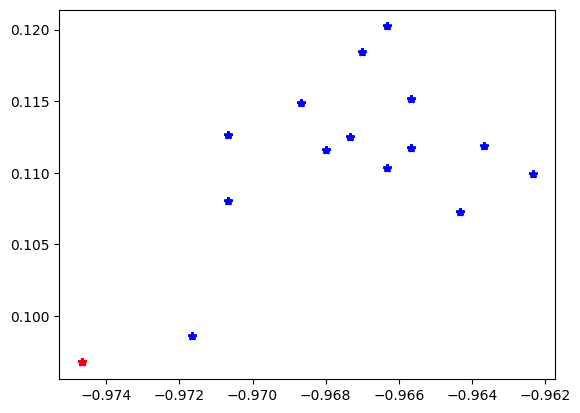

In [ ]:
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")